In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
plt.figure(figsize=(40, 10))

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, train_test_split, cross_val_score
from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
import catboost as cb
import xgboost as xgb

from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error

plt.figure(figsize=(40, 10))

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

In [55]:
df_train = pd.read_excel('data/Data_Train.xlsx')
df_test = pd.read_excel('data/Test_set.xlsx')

In [56]:
size_train_df = df_train.shape[0]
y['Price'] = df_train['Price'].values
df_train.drop(['Price'], axis=1, inplace=True)
df = pd.concat((df_train, df_test)).reset_index(drop=True)

In [57]:
y

,Price
0,3897
1,7662
2,13882
3,6218
4,13302
...,...
10678,4107
10679,4145
10680,7229
10681,12648


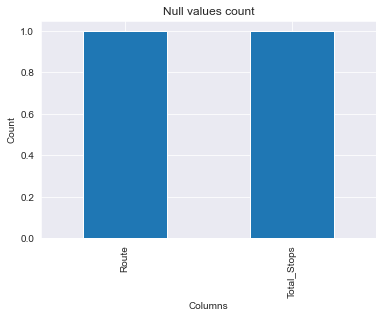

In [58]:
null_count = df.isna().sum().sort_values(ascending=False)

plt.title('Null values count')
plt.xlabel('Columns')
plt.ylabel('Count')
null_count[null_count > 0].plot(kind='bar');

In [59]:
# Рзделяю дату отправки на три фичи для более лучшего переваривания моделью
df['Data'] = df['Date_of_Journey'].str.split('/').str[0]
df['Month'] = df['Date_of_Journey'].str.split('/').str[1]
df['Year'] = df['Date_of_Journey'].str.split('/').str[2]

df.drop(['Date_of_Journey'], axis=1, inplace=True)

In [60]:
# Разделаю места пересадки на отдельные фичи, чтобы было понятнее
df['Route_0'] = df['Route'].str.split('→ ').str[0]
df['Route_1'] = df['Route'].str.split('→ ').str[1]
df['Route_2'] = df['Route'].str.split('→ ').str[2]
df['Route_3'] = df['Route'].str.split('→ ').str[3]
df['Route_4'] = df['Route'].str.split('→ ').str[4]
df['Route_5'] = df['Route'].str.split('→ ').str[5]

df.drop(['Route'], axis=1, inplace=True)

In [61]:
# Разделяю время отправка на две фичи
df['Dep_hour'] = df['Dep_Time'].str.split(':').str[0]
df['Dep_minute'] = df['Dep_Time'].str.split(':').str[0]

df.drop(['Dep_Time'], axis=1, inplace=True)

In [62]:
# Разделяю время прибытия
df['Arrival_hour'] = df['Arrival_Time'].str.split(':').str[0]
df['Arrival_minute'] = df['Arrival_Time'].str.split(':').str[1]
df['Arrival_minute'] = df['Arrival_minute'].str.split(' ').str[0]

df.drop(['Arrival_Time'], axis=1, inplace=True)

In [63]:
# Разделяю время полет(вместе с пересадками)
df['Duration_hour'] = df['Duration'].str.split(' ').str[0]
df['Duration_hour'] = df['Duration_hour'].str.split('h').str[0]
df['Duration_minute'] = df['Duration'].str.split(' ').str[1]
df['Duration_minute'] = df['Duration_minute'].str.split('m').str[0]

df.drop(['Duration'], axis=1, inplace=True)

In [64]:
df['Total_Stops'] = df['Total_Stops'].replace('non-stop', '0 stop')
df['Total_Stops'] = df['Total_Stops'].str.split(' ').str[0]

In [65]:
# Меняем, тип данных у фичей на те, которые им больше к лицу
df['Data'] = df['Data'].astype('int32')
df['Total_Stops'] = df['Data'].astype('int32')
df['Month'] = df['Data'].astype('int32')
df['Year'] = df['Data'].astype('int32')
df['Dep_hour'] = df['Data'].astype('int32')
df['Dep_minute'] = df['Data'].astype('int32')
df['Arrival_hour'] = df['Data'].astype('int32')
df['Arrival_minute'] = df['Data'].astype('int32')
df['Duration_hour'] = df['Data'].astype('int32')
df['Duration_minute'] = df['Data'].astype('int32')

In [66]:
# Ко всем категориальными переменным примения LabelEncoder для улучшения понимания моделью
cols = ['Airline', 'Source', 'Destination', 'Additional_Info', 'Route_0', 'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5']
label_e = LabelEncoder()
for i in range(0, len(cols)):
    df[cols[i]] = label_e.fit_transform(df[cols[i]])
df

,Airline,Source,Destination,Total_Stops,Additional_Info,Data,Month,Year,Route_0,Route_1,Route_2,Route_3,Route_4,Route_5,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hour,Duration_minute
0,3,0,5,24,8,24,24,24,0,13,30,13,5,1,24,24,24,24,24,24
1,1,3,0,1,8,1,1,1,2,25,1,3,5,1,1,1,1,1,1,1
2,4,2,1,9,8,9,9,9,3,32,4,5,5,1,9,9,9,9,9,9
3,3,3,0,12,8,12,12,12,2,34,3,13,5,1,12,12,12,12,12,12
4,3,0,5,1,8,1,1,1,0,34,8,13,5,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13349,1,3,0,6,8,6,6,6,2,14,3,13,5,1,6,6,6,6,6,6
13350,3,3,0,27,8,27,27,27,2,5,30,13,5,1,27,27,27,27,27,27
13351,4,2,1,6,8,6,6,6,3,7,6,13,5,1,6,6,6,6,6,6
13352,1,2,1,6,8,6,6,6,3,7,6,13,5,1,6,6,6,6,6,6


In [67]:
train_df = df[: size_train_df]
test_df = df[size_train_df: ]
train_df.shape, test_df.shape

((10683, 20), (2671, 20))

C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\1732878830.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(x_train, y_train)


<Figure size 3960x2520 with 0 Axes>

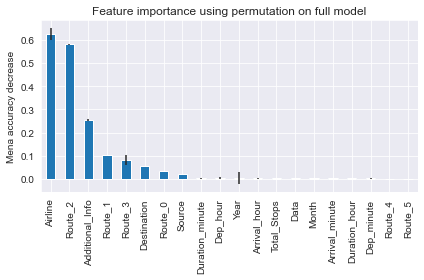

In [69]:
# Спомощью permutation_importance, могу увидеть самые опетитные фичи и отделить их от гадости
x_train, x_test, y_train, y_test = train_test_split(train_df, y, test_size=0.44)

forest = RandomForestRegressor()
forest.fit(x_train, y_train)
feature_names = x_train.columns

result = permutation_importance(forest, x_train, y_train, n_repeats=30, n_jobs=-1)

forest_importance = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(55, 35))
fig, ax = plt.subplots()
forest_importance.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title('Feature importance using permutation on full model')
ax.set_ylabel('Mena accuracy decrease')
fig.tight_layout()
plt.show();

In [70]:
df_model = df[forest_importance[forest_importance > 0.003].index]

In [71]:
pipeline_lr = Pipeline([('LinearRegression', LinearRegression())])
pipeline_knn = Pipeline([('kNN', KNeighborsRegressor())])
pipeline_svm = Pipeline([('SVR', SVR())])
pipeline_rf = Pipeline([('RandomForestRegressor', RandomForestRegressor())])
pipeline_lgbm = Pipeline([('LightGBM', lgbm.LGBMRegressor())])
pipeline_cb = Pipeline([('Catboost', cb.CatBoostRegressor())])
pipeline_xgb = Pipeline([('XGBoost', xgb.XGBRegressor())])

pipelines = [pipeline_lr, pipeline_knn, pipeline_svm, pipeline_rf, pipeline_lgbm, pipeline_cb, pipeline_xgb]
pipe_dict = {0: 'LinearRegression',
             1: 'kNN',
             2: 'SVR',
             3: 'RandomForestRegressor',
             4: 'LightGBM',
             5: 'CatBoost',
             6: 'XGBoost'}

In [73]:
original_results = dict()
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, train_df.values, y['Price'].values.ravel(), scoring=make_scorer(r2_score)).mean()
    original_results[pipe_dict[i]] = cv_score

Learning rate set to 0.057464
0:	learn: 4424.3483485	total: 146ms	remaining: 2m 25s
1:	learn: 4281.3401256	total: 148ms	remaining: 1m 13s
2:	learn: 4159.8362346	total: 149ms	remaining: 49.6s
3:	learn: 4034.5095141	total: 151ms	remaining: 37.6s
4:	learn: 3919.5037999	total: 153ms	remaining: 30.4s
5:	learn: 3810.5258121	total: 154ms	remaining: 25.6s
6:	learn: 3713.1766686	total: 156ms	remaining: 22.1s
7:	learn: 3623.2035971	total: 157ms	remaining: 19.5s
8:	learn: 3543.1295906	total: 159ms	remaining: 17.6s
9:	learn: 3452.1403762	total: 161ms	remaining: 16s
10:	learn: 3385.7187406	total: 163ms	remaining: 14.6s
11:	learn: 3316.6207125	total: 164ms	remaining: 13.5s
12:	learn: 3256.8459990	total: 166ms	remaining: 12.6s
13:	learn: 3207.9874962	total: 168ms	remaining: 11.8s
14:	learn: 3163.4967619	total: 169ms	remaining: 11.1s
15:	learn: 3110.7033470	total: 171ms	remaining: 10.5s
16:	learn: 3055.1631410	total: 173ms	remaining: 10s
17:	learn: 3001.4068080	total: 175ms	remaining: 9.56s
18:	learn:

In [74]:
for key, value in sorted(original_results.items(), key=lambda item: item[1]):
    print(key, value)

SVR 0.06950720604033271
LinearRegression 0.47844066502627314
kNN 0.7310010612506197
RandomForestRegressor 0.792394014671202
LightGBM 0.7927083132274444
XGBoost 0.8112417133438253
CatBoost 0.8166792887761444


In [75]:
x_train, x_test, y_train, y_test = train_test_split(train_df, y, test_size=0.24)

In [76]:
def objective_cb(trial):
    X_train, X_val, Y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

    param = {
        "objective": trial.suggest_categorical("objective", ["MAE", "RMSE"]),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 1, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10),
    }

    model = cb.CatBoostRegressor(**param, iterations = 1000)

    model.fit(X_train, Y_train, eval_set = [(X_val, y_val)], verbose = False)

    preds = model.predict(X_val)
    pred_labels = np.rint(preds)
    accuracy = r2_score(y_val, pred_labels)

    return accuracy

study = optuna.create_study(direction = "maximize")
study.optimize(objective_cb, n_trials = 400, show_progress_bar = True)

[I 2022-11-01 15:26:04,878] A new study created in memory with name: no-name-771c2fbc-bd90-4d61-a5de-307eb507e735
C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/400 [00:00<?, ?it/s]

C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:09,221] Trial 0 finished with value: 0.5645649517285561 and parameters: {'objective': 'MAE', 'learning_rate': 0.01038489286847649, 'colsample_bylevel': 0.06559680618068622, 'max_depth': 5, 'l2_leaf_reg': 0.008819196275738694, 'min_data_in_leaf': 219, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.105119114844239}. Best is trial 0 with value: 0.5645649517285561.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:10,477] Trial 1 finished with value: 0.4073249094320269 and parameters: {'objective': 'RMSE', 'learning_rate': 0.0015972431430711818, 'colsample_bylevel': 0.07896343277408024, 'max_depth': 8, 'l2_leaf_reg': 0.0818565973851515, 'min_data_in_leaf': 183, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.795268171470027}. Best is trial 0 with value: 0.5645649517285561.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:13,260] Trial 2 finished with value: 0.39581298153249833 and parameters: {'objective': 'MAE', 'learning_rate': 0.007395297426037723, 'colsample_bylevel': 0.04658958691505807, 'max_depth': 5, 'l2_leaf_reg': 0.40607924316010025, 'min_data_in_leaf': 128, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.011248306714115}. Best is trial 0 with value: 0.5645649517285561.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:14,216] Trial 3 finished with value: 0.6321484514111988 and parameters: {'objective': 'RMSE', 'learning_rate': 0.005542729563785863, 'colsample_bylevel': 0.06540720435075423, 'max_depth': 14, 'l2_leaf_reg': 0.998135712249927, 'min_data_in_leaf': 207, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.141309589471301}. Best is trial 3 with value: 0.6321484514111988.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:16,477] Trial 4 finished with value: 0.7732763546607091 and parameters: {'objective': 'RMSE', 'learning_rate': 0.19697590338163606, 'colsample_bylevel': 0.09323029989035705, 'max_depth': 7, 'l2_leaf_reg': 0.002025454116805322, 'min_data_in_leaf': 87, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.307852335438765}. Best is trial 4 with value: 0.7732763546607091.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:17,106] Trial 5 finished with value: 0.5129556064639564 and parameters: {'objective': 'RMSE', 'learning_rate': 0.03664241502594809, 'colsample_bylevel': 0.08953671796225943, 'max_depth': 1, 'l2_leaf_reg': 0.007137924366118572, 'min_data_in_leaf': 114, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.302411844601652}. Best is trial 4 with value: 0.7732763546607091.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:18,928] Trial 6 finished with value: 0.4674958352084253 and parameters: {'objective': 'RMSE', 'learning_rate': 0.018054801490859633, 'colsample_bylevel': 0.02413797526204678, 'max_depth': 7, 'l2_leaf_reg': 0.08422750594534394, 'min_data_in_leaf': 137, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.9461302676968706}. Best is trial 4 with value: 0.7732763546607091.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:19,668] Trial 7 finished with value: 0.546950326685091 and parameters: {'objective': 'RMSE', 'learning_rate': 0.012541306018884315, 'colsample_bylevel': 0.047599428767419884, 'max_depth': 2, 'l2_leaf_reg': 0.014387188195400568, 'min_data_in_leaf': 208, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.47470032365956705}. Best is trial 4 with value: 0.7732763546607091.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:20,607] Trial 8 finished with value: 0.6369011890335257 and parameters: {'objective': 'RMSE', 'learning_rate': 0.01938557486994111, 'colsample_bylevel': 0.07082536866264862, 'max_depth': 4, 'l2_leaf_reg': 0.10509619898625865, 'min_data_in_leaf': 109, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.974282617963867}. Best is trial 4 with value: 0.7732763546607091.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:21,280] Trial 9 finished with value: 0.04381093103178135 and parameters: {'objective': 'RMSE', 'learning_rate': 0.0011533330770106946, 'colsample_bylevel': 0.015228692903723915, 'max_depth': 9, 'l2_leaf_reg': 0.016890079680648016, 'min_data_in_leaf': 221, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4082819059320286}. Best is trial 4 with value: 0.7732763546607091.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:24,806] Trial 10 finished with value: 0.769250574570006 and parameters: {'objective': 'MAE', 'learning_rate': 0.24987886710569843, 'colsample_bylevel': 0.09513786573625282, 'max_depth': 11, 'l2_leaf_reg': 0.00021940046731838242, 'min_data_in_leaf': 15, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.516531523153946}. Best is trial 4 with value: 0.7732763546607091.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:28,767] Trial 11 finished with value: 0.7856513710412599 and parameters: {'objective': 'MAE', 'learning_rate': 0.2293985257798043, 'colsample_bylevel': 0.09822867445484115, 'max_depth': 12, 'l2_leaf_reg': 0.00018999836190279563, 'min_data_in_leaf': 13, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.5483338282301515}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:33,144] Trial 12 finished with value: 0.7684510764278593 and parameters: {'objective': 'MAE', 'learning_rate': 0.2921172665988643, 'colsample_bylevel': 0.09575803675147324, 'max_depth': 13, 'l2_leaf_reg': 0.0001660593526729868, 'min_data_in_leaf': 13, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.515776058507994}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:36,048] Trial 13 finished with value: 0.7294404844260868 and parameters: {'objective': 'MAE', 'learning_rate': 0.09195714884821957, 'colsample_bylevel': 0.08255382395016772, 'max_depth': 11, 'l2_leaf_reg': 0.0008452036439276209, 'min_data_in_leaf': 56, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.10894108996753}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:39,616] Trial 14 finished with value: 0.7387893333931428 and parameters: {'objective': 'MAE', 'learning_rate': 0.09497657315757352, 'colsample_bylevel': 0.09741019826449707, 'max_depth': 11, 'l2_leaf_reg': 0.0009736132198615119, 'min_data_in_leaf': 68, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.671893695653846}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:43,334] Trial 15 finished with value: 0.764035054853948 and parameters: {'objective': 'MAE', 'learning_rate': 0.10661392249096426, 'colsample_bylevel': 0.07890202648618462, 'max_depth': 15, 'l2_leaf_reg': 0.0012454191612792725, 'min_data_in_leaf': 62, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.062806820098871}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:45,353] Trial 16 finished with value: 0.6502268774047056 and parameters: {'objective': 'MAE', 'learning_rate': 0.04666422833251726, 'colsample_bylevel': 0.04023506505960923, 'max_depth': 9, 'l2_leaf_reg': 0.002534918249823813, 'min_data_in_leaf': 287, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.614819467648964}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:47,219] Trial 17 finished with value: 0.7233308906076761 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15393054715621268, 'colsample_bylevel': 0.09989771206082804, 'max_depth': 7, 'l2_leaf_reg': 0.000371674907847925, 'min_data_in_leaf': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.0680433145952177}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:49,534] Trial 18 finished with value: 0.7199681042292504 and parameters: {'objective': 'RMSE', 'learning_rate': 0.04713940437592712, 'colsample_bylevel': 0.08397300207576663, 'max_depth': 12, 'l2_leaf_reg': 0.00010887424698655769, 'min_data_in_leaf': 80, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.892268838424806}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:52,099] Trial 19 finished with value: 0.3386042719628102 and parameters: {'objective': 'MAE', 'learning_rate': 0.0030789481035748646, 'colsample_bylevel': 0.060428516040245205, 'max_depth': 9, 'l2_leaf_reg': 0.0031877361969586565, 'min_data_in_leaf': 42, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.738035277144132}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:54,678] Trial 20 finished with value: 0.739391140721327 and parameters: {'objective': 'MAE', 'learning_rate': 0.1708851995473604, 'colsample_bylevel': 0.07122930639876701, 'max_depth': 6, 'l2_leaf_reg': 0.00048202057496281396, 'min_data_in_leaf': 96, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.9161564945210126}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:26:57,849] Trial 21 finished with value: 0.7590112721796141 and parameters: {'objective': 'MAE', 'learning_rate': 0.25040044260753436, 'colsample_bylevel': 0.08984468849297647, 'max_depth': 11, 'l2_leaf_reg': 0.00021953459933599445, 'min_data_in_leaf': 34, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.5439183392158045}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:01,026] Trial 22 finished with value: 0.781801688536858 and parameters: {'objective': 'MAE', 'learning_rate': 0.15104878195567759, 'colsample_bylevel': 0.0901077697154226, 'max_depth': 10, 'l2_leaf_reg': 0.0003092292975944472, 'min_data_in_leaf': 28, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.581869598820884}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:04,567] Trial 23 finished with value: 0.7644014501193708 and parameters: {'objective': 'MAE', 'learning_rate': 0.1417972421512157, 'colsample_bylevel': 0.08890325857857781, 'max_depth': 13, 'l2_leaf_reg': 0.0022287582663719115, 'min_data_in_leaf': 36, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.717172158368322}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:07,067] Trial 24 finished with value: 0.6995986124897873 and parameters: {'objective': 'MAE', 'learning_rate': 0.05850693102073053, 'colsample_bylevel': 0.07477677955847528, 'max_depth': 10, 'l2_leaf_reg': 0.0003858215385344451, 'min_data_in_leaf': 85, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.517753501801653}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:09,767] Trial 25 finished with value: 0.7346579971522872 and parameters: {'objective': 'MAE', 'learning_rate': 0.030973203140286027, 'colsample_bylevel': 0.08774508004092388, 'max_depth': 8, 'l2_leaf_reg': 0.0001009656268096399, 'min_data_in_leaf': 163, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.9603829737002085}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:12,117] Trial 26 finished with value: 0.763677330822302 and parameters: {'objective': 'RMSE', 'learning_rate': 0.06949458428149326, 'colsample_bylevel': 0.09249474065038615, 'max_depth': 13, 'l2_leaf_reg': 0.0006327903252693187, 'min_data_in_leaf': 26, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3072244475288917}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:14,562] Trial 27 finished with value: 0.702136944563842 and parameters: {'objective': 'MAE', 'learning_rate': 0.1831097957273477, 'colsample_bylevel': 0.09889347314041577, 'max_depth': 3, 'l2_leaf_reg': 0.001391540133941897, 'min_data_in_leaf': 50, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.26875829288845}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:16,709] Trial 28 finished with value: 0.6968531805384066 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11516075943340365, 'colsample_bylevel': 0.08262736108727599, 'max_depth': 15, 'l2_leaf_reg': 0.004513972385147577, 'min_data_in_leaf': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.055988277217527}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:19,106] Trial 29 finished with value: 0.7223753438619581 and parameters: {'objective': 'MAE', 'learning_rate': 0.19692945792532976, 'colsample_bylevel': 0.060169283791237704, 'max_depth': 6, 'l2_leaf_reg': 0.00028521380867808444, 'min_data_in_leaf': 72, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.809284219815327}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:21,301] Trial 30 finished with value: 0.47817712772122967 and parameters: {'objective': 'MAE', 'learning_rate': 0.027344539108323945, 'colsample_bylevel': 0.03326997240154685, 'max_depth': 10, 'l2_leaf_reg': 0.006831184530094976, 'min_data_in_leaf': 26, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.568841992116726}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:24,935] Trial 31 finished with value: 0.7429981928213054 and parameters: {'objective': 'MAE', 'learning_rate': 0.2964848690223299, 'colsample_bylevel': 0.09368900519917449, 'max_depth': 12, 'l2_leaf_reg': 0.00018141256066532153, 'min_data_in_leaf': 17, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.147253075189251}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:27,458] Trial 32 finished with value: 0.7552911092252399 and parameters: {'objective': 'MAE', 'learning_rate': 0.23062884833136157, 'colsample_bylevel': 0.07669074440502452, 'max_depth': 10, 'l2_leaf_reg': 0.0005990428162457759, 'min_data_in_leaf': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.149328167753735}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:30,528] Trial 33 finished with value: 0.7751098137069744 and parameters: {'objective': 'MAE', 'learning_rate': 0.07238622809222896, 'colsample_bylevel': 0.08309317639171354, 'max_depth': 12, 'l2_leaf_reg': 0.00021545832548033775, 'min_data_in_leaf': 48, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.369461758838559}. Best is trial 11 with value: 0.7856513710412599.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:32,198] Trial 34 finished with value: 0.7860001945848454 and parameters: {'objective': 'MAE', 'learning_rate': 0.07762536862900765, 'colsample_bylevel': 0.08474220709378881, 'max_depth': 12, 'l2_leaf_reg': 0.001639702322478394, 'min_data_in_leaf': 45, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.206239156229909}. Best is trial 34 with value: 0.7860001945848454.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:34,311] Trial 35 finished with value: 0.7098041040842508 and parameters: {'objective': 'MAE', 'learning_rate': 0.06940909139134337, 'colsample_bylevel': 0.08362774012141874, 'max_depth': 14, 'l2_leaf_reg': 0.00014032779378027286, 'min_data_in_leaf': 49, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.4306332942866105}. Best is trial 34 with value: 0.7860001945848454.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:35,533] Trial 36 finished with value: 0.7898674830930492 and parameters: {'objective': 'MAE', 'learning_rate': 0.08051482315490825, 'colsample_bylevel': 0.06615328543455286, 'max_depth': 14, 'l2_leaf_reg': 0.029658649062843108, 'min_data_in_leaf': 99, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.149430804781453}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:36,710] Trial 37 finished with value: 0.6746086421735384 and parameters: {'objective': 'MAE', 'learning_rate': 0.1410448450943013, 'colsample_bylevel': 0.06597243972478771, 'max_depth': 14, 'l2_leaf_reg': 0.05278140920222505, 'min_data_in_leaf': 102, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.839850088945047}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:37,631] Trial 38 finished with value: 0.37350336582254173 and parameters: {'objective': 'MAE', 'learning_rate': 0.004426707255171857, 'colsample_bylevel': 0.0549320209509366, 'max_depth': 13, 'l2_leaf_reg': 0.03709868161202323, 'min_data_in_leaf': 127, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.357713225462263}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:39,081] Trial 39 finished with value: 0.7088731504687954 and parameters: {'objective': 'MAE', 'learning_rate': 0.023304961846462698, 'colsample_bylevel': 0.07121444892571613, 'max_depth': 15, 'l2_leaf_reg': 0.22782970028352176, 'min_data_in_leaf': 164, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.45139589828428}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:40,113] Trial 40 finished with value: 0.5573071259382009 and parameters: {'objective': 'MAE', 'learning_rate': 0.01375298556636202, 'colsample_bylevel': 0.04868817108608394, 'max_depth': 12, 'l2_leaf_reg': 0.026071222150317156, 'min_data_in_leaf': 126, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.6044582340202567}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:41,845] Trial 41 finished with value: 0.7611548787532385 and parameters: {'objective': 'MAE', 'learning_rate': 0.08841452343552712, 'colsample_bylevel': 0.08723988763591568, 'max_depth': 12, 'l2_leaf_reg': 0.0003317880307415845, 'min_data_in_leaf': 61, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.093901890950445}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:43,626] Trial 42 finished with value: 0.6918628790708297 and parameters: {'objective': 'MAE', 'learning_rate': 0.03762287683088367, 'colsample_bylevel': 0.07892924637645145, 'max_depth': 14, 'l2_leaf_reg': 0.018126453358025218, 'min_data_in_leaf': 33, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.00788448923269}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:44,779] Trial 43 finished with value: 0.7720116682593354 and parameters: {'objective': 'MAE', 'learning_rate': 0.06187524678933279, 'colsample_bylevel': 0.0665248127681134, 'max_depth': 12, 'l2_leaf_reg': 0.0006864213793317519, 'min_data_in_leaf': 90, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.2812529742261045}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:46,152] Trial 44 finished with value: 0.6956838700277875 and parameters: {'objective': 'MAE', 'learning_rate': 0.12294261444606669, 'colsample_bylevel': 0.07473279268264633, 'max_depth': 13, 'l2_leaf_reg': 0.011203427228665349, 'min_data_in_leaf': 21, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.10581682624782}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:47,341] Trial 45 finished with value: 0.6429240030875734 and parameters: {'objective': 'MAE', 'learning_rate': 0.008818382348239473, 'colsample_bylevel': 0.08610110563897234, 'max_depth': 10, 'l2_leaf_reg': 0.1453545013078565, 'min_data_in_leaf': 73, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.18273628566065}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:48,928] Trial 46 finished with value: 0.6989597548350983 and parameters: {'objective': 'MAE', 'learning_rate': 0.08198233136106893, 'colsample_bylevel': 0.09049376319629171, 'max_depth': 11, 'l2_leaf_reg': 0.001673778420103693, 'min_data_in_leaf': 44, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.8538491366461916}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:51,043] Trial 47 finished with value: 0.698178388620781 and parameters: {'objective': 'MAE', 'learning_rate': 0.05586787991335401, 'colsample_bylevel': 0.08070857393965698, 'max_depth': 14, 'l2_leaf_reg': 0.8618762575036182, 'min_data_in_leaf': 115, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.429988644848997}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),
C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:52,614] Trial 48 finished with value: 0.6856687331654153 and parameters: {'objective': 'MAE', 'learning_rate': 0.03729643966743223, 'colsample_bylevel': 0.09512787301606694, 'max_depth': 8, 'l2_leaf_reg': 0.0002324008934869124, 'min_data_in_leaf': 244, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.329731182216608}. Best is trial 36 with value: 0.7898674830930492.
[I 2022-11-01 15:27:53,606] Trial 49 finished with value: 0.710334923703443 and parameters: {'objective': 'MAE', 'learning_rate': 0.214614047102752, 'colsample_bylevel': 0.06075373651625582, 'max_depth': 11, 'l2_leaf_reg': 0.0009736230847210862, 'min_data_in_leaf': 143, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.516801614172134}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:55,844] Trial 50 finished with value: 0.7551828644511996 and parameters: {'objective': 'MAE', 'learning_rate': 0.11424975376154213, 'colsample_bylevel': 0.05392514130651285, 'max_depth': 12, 'l2_leaf_reg': 0.0051960868124437225, 'min_data_in_leaf': 53, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.076763921384344}. Best is trial 36 with value: 0.7898674830930492.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:57,710] Trial 51 finished with value: 0.8040623880313054 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1625796796320712, 'colsample_bylevel': 0.09293584976359573, 'max_depth': 7, 'l2_leaf_reg': 0.00015228377594520237, 'min_data_in_leaf': 63, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.0658653379359926}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:27:59,986] Trial 52 finished with value: 0.7718297225866353 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15974154187012307, 'colsample_bylevel': 0.09689012466570854, 'max_depth': 6, 'l2_leaf_reg': 0.00013634237515367426, 'min_data_in_leaf': 63, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.4722442718717876}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:02,182] Trial 53 finished with value: 0.7293983703002599 and parameters: {'objective': 'RMSE', 'learning_rate': 0.08309051819117395, 'colsample_bylevel': 0.09162590995335082, 'max_depth': 9, 'l2_leaf_reg': 0.00027854374412405753, 'min_data_in_leaf': 41, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.4962858242317107}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:04,071] Trial 54 finished with value: 0.776195376666053 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1332690215187671, 'colsample_bylevel': 0.08520073793041985, 'max_depth': 7, 'l2_leaf_reg': 0.0004353307215662044, 'min_data_in_leaf': 80, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.2794286586727495}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:06,100] Trial 55 finished with value: 0.7658441256731571 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13353277787738216, 'colsample_bylevel': 0.09921296347550404, 'max_depth': 5, 'l2_leaf_reg': 0.0003887365165653254, 'min_data_in_leaf': 79, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.655568520914721}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:07,545] Trial 56 finished with value: 0.5815189325179607 and parameters: {'objective': 'RMSE', 'learning_rate': 0.10553133951133035, 'colsample_bylevel': 0.013283320987563477, 'max_depth': 7, 'l2_leaf_reg': 0.0004335041705594089, 'min_data_in_leaf': 102, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1135852253119636}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:09,709] Trial 57 finished with value: 0.7935683738031056 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2630696739316349, 'colsample_bylevel': 0.09298142253556482, 'max_depth': 5, 'l2_leaf_reg': 0.00013731157603995777, 'min_data_in_leaf': 15, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.364091052357373}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:11,875] Trial 58 finished with value: 0.7220962240734552 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2498124724834583, 'colsample_bylevel': 0.09385513059103665, 'max_depth': 4, 'l2_leaf_reg': 0.00014637036785797498, 'min_data_in_leaf': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.010876293828986139}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:13,807] Trial 59 finished with value: 0.7702969061301146 and parameters: {'objective': 'RMSE', 'learning_rate': 0.18256067015520522, 'colsample_bylevel': 0.09026938702488535, 'max_depth': 4, 'l2_leaf_reg': 0.00011763995360129232, 'min_data_in_leaf': 25, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.0673878081317345}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:15,806] Trial 60 finished with value: 0.4791052061314447 and parameters: {'objective': 'RMSE', 'learning_rate': 0.0019903510372150687, 'colsample_bylevel': 0.09439210651324202, 'max_depth': 5, 'l2_leaf_reg': 0.00010006963012505571, 'min_data_in_leaf': 13, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.65079460836173}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:17,582] Trial 61 finished with value: 0.7556671114398078 and parameters: {'objective': 'RMSE', 'learning_rate': 0.28864994569015057, 'colsample_bylevel': 0.08618821316792746, 'max_depth': 8, 'l2_leaf_reg': 0.00017885646022327133, 'min_data_in_leaf': 36, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.403831979682623}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:19,811] Trial 62 finished with value: 0.7773852081683092 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16887293891847752, 'colsample_bylevel': 0.0852559186198323, 'max_depth': 6, 'l2_leaf_reg': 0.0005133171264036204, 'min_data_in_leaf': 57, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7009707901602467}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:22,079] Trial 63 finished with value: 0.7844943111643602 and parameters: {'objective': 'RMSE', 'learning_rate': 0.20014336134620817, 'colsample_bylevel': 0.09777768935436854, 'max_depth': 6, 'l2_leaf_reg': 0.0008472793651304987, 'min_data_in_leaf': 28, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8397717871949648}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:23,900] Trial 64 finished with value: 0.7574017801625931 and parameters: {'objective': 'RMSE', 'learning_rate': 0.21586124194766845, 'colsample_bylevel': 0.09752786359292638, 'max_depth': 3, 'l2_leaf_reg': 0.0008772203919458125, 'min_data_in_leaf': 28, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4485787703692934}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:25,898] Trial 65 finished with value: 0.7581493480309484 and parameters: {'objective': 'RMSE', 'learning_rate': 0.19872998986560822, 'colsample_bylevel': 0.09155131318450356, 'max_depth': 5, 'l2_leaf_reg': 0.00027443646864647755, 'min_data_in_leaf': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.7562655092138302}. Best is trial 51 with value: 0.8040623880313054.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:27,989] Trial 66 finished with value: 0.81300313087394 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2571986852729806, 'colsample_bylevel': 0.09950753549142798, 'max_depth': 6, 'l2_leaf_reg': 0.002825911642009957, 'min_data_in_leaf': 20, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7983010203536238}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:30,292] Trial 67 finished with value: 0.7782553611319211 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2538925553367609, 'colsample_bylevel': 0.09916372217553479, 'max_depth': 6, 'l2_leaf_reg': 0.003888848823094473, 'min_data_in_leaf': 18, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9197957615440875}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:32,481] Trial 68 finished with value: 0.7382437554627892 and parameters: {'objective': 'RMSE', 'learning_rate': 0.27917793182439876, 'colsample_bylevel': 0.09681463439559987, 'max_depth': 5, 'l2_leaf_reg': 0.0029624842984282435, 'min_data_in_leaf': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.5513942974393289}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:33,502] Trial 69 finished with value: 0.7496284355836159 and parameters: {'objective': 'RMSE', 'learning_rate': 0.10011743785582361, 'colsample_bylevel': 0.09384842409418583, 'max_depth': 6, 'l2_leaf_reg': 0.007763245661704878, 'min_data_in_leaf': 37, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2114345169191041}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:35,405] Trial 70 finished with value: 0.7393914913625211 and parameters: {'objective': 'RMSE', 'learning_rate': 0.04756912713425945, 'colsample_bylevel': 0.0999507445686267, 'max_depth': 7, 'l2_leaf_reg': 0.0017900321213175218, 'min_data_in_leaf': 67, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.8606679954703313}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:37,302] Trial 71 finished with value: 0.7356592825038271 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16654513841287547, 'colsample_bylevel': 0.08975252373614068, 'max_depth': 8, 'l2_leaf_reg': 0.0011769038203454595, 'min_data_in_leaf': 29, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7127218251055325}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:39,362] Trial 72 finished with value: 0.7809124709671833 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2239686263059409, 'colsample_bylevel': 0.09633755686017928, 'max_depth': 7, 'l2_leaf_reg': 0.0007364108099221924, 'min_data_in_leaf': 20, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.586639431396158}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:41,107] Trial 73 finished with value: 0.7581399241419483 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15158447238722958, 'colsample_bylevel': 0.032777137117634796, 'max_depth': 4, 'l2_leaf_reg': 0.00237459202678446, 'min_data_in_leaf': 47, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.8612210043217}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:43,128] Trial 74 finished with value: 0.7806369442681556 and parameters: {'objective': 'RMSE', 'learning_rate': 0.19013144176503688, 'colsample_bylevel': 0.08792020459258162, 'max_depth': 9, 'l2_leaf_reg': 0.00018513171544681572, 'min_data_in_leaf': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.031961927135986}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:45,406] Trial 75 finished with value: 0.7135700405835624 and parameters: {'objective': 'MAE', 'learning_rate': 0.24258578887821702, 'colsample_bylevel': 0.081110551705315, 'max_depth': 3, 'l2_leaf_reg': 0.0003166498157216962, 'min_data_in_leaf': 192, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.804399548817154}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:48,178] Trial 76 finished with value: 0.7482517656400955 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2995709762311115, 'colsample_bylevel': 0.09289883757090425, 'max_depth': 6, 'l2_leaf_reg': 0.05117302460873363, 'min_data_in_leaf': 40, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.463643504969273}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:50,124] Trial 77 finished with value: 0.7720998567791225 and parameters: {'objective': 'MAE', 'learning_rate': 0.12384874146769558, 'colsample_bylevel': 0.0760837941764706, 'max_depth': 13, 'l2_leaf_reg': 0.001303480862308725, 'min_data_in_leaf': 31, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.980021656362522}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:53,386] Trial 78 finished with value: 0.7770709775106697 and parameters: {'objective': 'MAE', 'learning_rate': 0.20141577314175807, 'colsample_bylevel': 0.08845752935362716, 'max_depth': 10, 'l2_leaf_reg': 0.0005978468996646781, 'min_data_in_leaf': 56, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.8804165586300763}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:53,959] Trial 79 finished with value: 0.6311795906601699 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14702488628412522, 'colsample_bylevel': 0.09601702536027018, 'max_depth': 1, 'l2_leaf_reg': 0.00022902599173310666, 'min_data_in_leaf': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.177131767713944}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:57,079] Trial 80 finished with value: 0.731951441745931 and parameters: {'objective': 'MAE', 'learning_rate': 0.10405969378284566, 'colsample_bylevel': 0.09095060690676635, 'max_depth': 11, 'l2_leaf_reg': 0.010015891354915084, 'min_data_in_leaf': 22, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.6190896392835015}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:28:59,117] Trial 81 finished with value: 0.7852896025831008 and parameters: {'objective': 'RMSE', 'learning_rate': 0.23111622069420223, 'colsample_bylevel': 0.09581757140551303, 'max_depth': 7, 'l2_leaf_reg': 0.0009774309003382808, 'min_data_in_leaf': 21, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.676199107430378}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:01,224] Trial 82 finished with value: 0.7545740069207232 and parameters: {'objective': 'RMSE', 'learning_rate': 0.25461742216528704, 'colsample_bylevel': 0.09741319699307498, 'max_depth': 7, 'l2_leaf_reg': 0.0015505859181455756, 'min_data_in_leaf': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.778663504517464}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:03,348] Trial 83 finished with value: 0.7528816669830352 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17623441986932128, 'colsample_bylevel': 0.09261533536342881, 'max_depth': 8, 'l2_leaf_reg': 0.002141953242360671, 'min_data_in_leaf': 46, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.81211369134348}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:05,160] Trial 84 finished with value: 0.7919851793754207 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2217634693319213, 'colsample_bylevel': 0.0686522052928287, 'max_depth': 6, 'l2_leaf_reg': 0.0009400548988115358, 'min_data_in_leaf': 30, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.287078861814433}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:06,930] Trial 85 finished with value: 0.6991943735965859 and parameters: {'objective': 'RMSE', 'learning_rate': 0.21141969720080558, 'colsample_bylevel': 0.06760288982134152, 'max_depth': 6, 'l2_leaf_reg': 0.0010986651989978544, 'min_data_in_leaf': 37, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.761297521303637}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:08,829] Trial 86 finished with value: 0.7516739808099542 and parameters: {'objective': 'RMSE', 'learning_rate': 0.26389589038115047, 'colsample_bylevel': 0.06411701214368479, 'max_depth': 5, 'l2_leaf_reg': 0.00562146163478711, 'min_data_in_leaf': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.907648828528628}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:09,658] Trial 87 finished with value: 0.7874536050527825 and parameters: {'objective': 'RMSE', 'learning_rate': 0.22664634434792671, 'colsample_bylevel': 0.0516064381290085, 'max_depth': 7, 'l2_leaf_reg': 0.003358149214832598, 'min_data_in_leaf': 72, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3586112236603345}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:10,543] Trial 88 finished with value: 0.7329886704552786 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2324727437172657, 'colsample_bylevel': 0.05774722164181091, 'max_depth': 7, 'l2_leaf_reg': 0.02391439920453194, 'min_data_in_leaf': 94, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.182043022211431}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:11,296] Trial 89 finished with value: 0.7249646310869857 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1631092113147322, 'colsample_bylevel': 0.049275184962857994, 'max_depth': 15, 'l2_leaf_reg': 0.004069350162904799, 'min_data_in_leaf': 64, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.398185190462163}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:12,042] Trial 90 finished with value: 0.7285823098523804 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11883873682948003, 'colsample_bylevel': 0.041416688303788286, 'max_depth': 7, 'l2_leaf_reg': 0.0029430043074078075, 'min_data_in_leaf': 71, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.2557096672064931}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:12,854] Trial 91 finished with value: 0.7622375232199882 and parameters: {'objective': 'RMSE', 'learning_rate': 0.19182991906185964, 'colsample_bylevel': 0.05287118047186527, 'max_depth': 6, 'l2_leaf_reg': 0.013001220941408377, 'min_data_in_leaf': 53, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.6544374932235868}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:13,562] Trial 92 finished with value: 0.7983512181516446 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2968490119843108, 'colsample_bylevel': 0.05134656561947251, 'max_depth': 6, 'l2_leaf_reg': 0.0007601078475123793, 'min_data_in_leaf': 24, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3932745305031262}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:14,311] Trial 93 finished with value: 0.80901264040338 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2961069758903688, 'colsample_bylevel': 0.05612651864093976, 'max_depth': 8, 'l2_leaf_reg': 0.0018002626697819731, 'min_data_in_leaf': 22, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3438757300339075}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:14,995] Trial 94 finished with value: 0.7382260880170546 and parameters: {'objective': 'RMSE', 'learning_rate': 0.26503045927636165, 'colsample_bylevel': 0.04548687960252208, 'max_depth': 8, 'l2_leaf_reg': 0.0020043699539032222, 'min_data_in_leaf': 85, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.1241749768891363}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:15,734] Trial 95 finished with value: 0.7855363474412662 and parameters: {'objective': 'RMSE', 'learning_rate': 0.29590906607267004, 'colsample_bylevel': 0.057236080443319765, 'max_depth': 5, 'l2_leaf_reg': 0.003116549361343792, 'min_data_in_leaf': 75, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.2993571925693637}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:16,497] Trial 96 finished with value: 0.788303780529835 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2991968048294357, 'colsample_bylevel': 0.06228832255151983, 'max_depth': 14, 'l2_leaf_reg': 0.0015202509406556566, 'min_data_in_leaf': 42, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.384158913408541}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:17,445] Trial 97 finished with value: 0.7753519148246444 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2695732255168258, 'colsample_bylevel': 0.06970243751371959, 'max_depth': 14, 'l2_leaf_reg': 0.0015071958039944637, 'min_data_in_leaf': 116, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3886022442018149}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:18,298] Trial 98 finished with value: 0.5929060233043141 and parameters: {'objective': 'RMSE', 'learning_rate': 0.006081864521745566, 'colsample_bylevel': 0.062494628782533986, 'max_depth': 8, 'l2_leaf_reg': 0.0019022258081994065, 'min_data_in_leaf': 61, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.9091118049498705}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:19,135] Trial 99 finished with value: 0.7892275991106642 and parameters: {'objective': 'RMSE', 'learning_rate': 0.22878224592753005, 'colsample_bylevel': 0.05838432280365992, 'max_depth': 14, 'l2_leaf_reg': 0.005843047522410256, 'min_data_in_leaf': 46, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.424836387057014}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:19,904] Trial 100 finished with value: 0.7568088220382313 and parameters: {'objective': 'RMSE', 'learning_rate': 0.297067086963375, 'colsample_bylevel': 0.050688446397086535, 'max_depth': 14, 'l2_leaf_reg': 0.005383941360138587, 'min_data_in_leaf': 52, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.420981937545677}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:20,713] Trial 101 finished with value: 0.7507212103023885 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2331669624763568, 'colsample_bylevel': 0.05792128710941137, 'max_depth': 14, 'l2_leaf_reg': 0.00384044536639101, 'min_data_in_leaf': 41, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.2254952141884985}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:21,451] Trial 102 finished with value: 0.6088734485273175 and parameters: {'objective': 'RMSE', 'learning_rate': 0.015315883643394639, 'colsample_bylevel': 0.045666812700380706, 'max_depth': 15, 'l2_leaf_reg': 0.008404808977462434, 'min_data_in_leaf': 33, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.6071707748257367}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:22,405] Trial 103 finished with value: 0.7965779316616184 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17874757714139333, 'colsample_bylevel': 0.062113390105065225, 'max_depth': 9, 'l2_leaf_reg': 0.006610329080426265, 'min_data_in_leaf': 45, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5965444831340099}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:23,116] Trial 104 finished with value: 0.7805785916623595 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17598528209457387, 'colsample_bylevel': 0.05610146691843156, 'max_depth': 5, 'l2_leaf_reg': 0.0066014547655247405, 'min_data_in_leaf': 59, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1385756985797704}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:23,849] Trial 105 finished with value: 0.7953545365990491 and parameters: {'objective': 'RMSE', 'learning_rate': 0.21761703684024722, 'colsample_bylevel': 0.06204782625064186, 'max_depth': 4, 'l2_leaf_reg': 0.004796918278273503, 'min_data_in_leaf': 269, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.27028092789066926}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:24,561] Trial 106 finished with value: 0.7851386662964454 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14873452510230645, 'colsample_bylevel': 0.06012777305002657, 'max_depth': 4, 'l2_leaf_reg': 0.015364609334593986, 'min_data_in_leaf': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5953207721772799}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:25,318] Trial 107 finished with value: 0.7706951504169166 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2088403451918938, 'colsample_bylevel': 0.06212503464863315, 'max_depth': 4, 'l2_leaf_reg': 0.0026997138953405307, 'min_data_in_leaf': 298, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.20289443517811678}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:26,002] Trial 108 finished with value: 0.7961340315651253 and parameters: {'objective': 'RMSE', 'learning_rate': 0.26871989297527044, 'colsample_bylevel': 0.06927954407183265, 'max_depth': 3, 'l2_leaf_reg': 0.005939493596378222, 'min_data_in_leaf': 172, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3637046203811927}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:26,641] Trial 109 finished with value: 0.6834808491131528 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1374896819006516, 'colsample_bylevel': 0.07267720520417575, 'max_depth': 2, 'l2_leaf_reg': 0.004687040591276179, 'min_data_in_leaf': 261, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.17306340399945658}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:27,273] Trial 110 finished with value: 0.7392784530011495 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2560705537788656, 'colsample_bylevel': 0.06656210161150836, 'max_depth': 2, 'l2_leaf_reg': 0.006749495941865633, 'min_data_in_leaf': 218, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5278795459107732}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:28,082] Trial 111 finished with value: 0.7237993966096155 and parameters: {'objective': 'RMSE', 'learning_rate': 0.27356149335708635, 'colsample_bylevel': 0.0685626506134262, 'max_depth': 3, 'l2_leaf_reg': 0.00972732751622941, 'min_data_in_leaf': 266, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8173848885753793}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:28,937] Trial 112 finished with value: 0.777448066301857 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1829051570542119, 'colsample_bylevel': 0.06339601080268291, 'max_depth': 4, 'l2_leaf_reg': 0.002577169615041762, 'min_data_in_leaf': 138, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.0010842297196011486}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:29,734] Trial 113 finished with value: 0.7523572378291108 and parameters: {'objective': 'RMSE', 'learning_rate': 0.21027235416385728, 'colsample_bylevel': 0.06495594691491204, 'max_depth': 3, 'l2_leaf_reg': 0.005773399296464355, 'min_data_in_leaf': 183, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.36858053319028095}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:30,611] Trial 114 finished with value: 0.22087007596807628 and parameters: {'objective': 'RMSE', 'learning_rate': 0.0010074292156822843, 'colsample_bylevel': 0.06141894990293744, 'max_depth': 5, 'l2_leaf_reg': 0.004363896374796134, 'min_data_in_leaf': 156, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.0860152689582834}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:31,298] Trial 115 finished with value: 0.7626951114288395 and parameters: {'objective': 'RMSE', 'learning_rate': 0.239340116943848, 'colsample_bylevel': 0.05453035287910879, 'max_depth': 2, 'l2_leaf_reg': 0.012439338649925481, 'min_data_in_leaf': 239, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.1947827374080013}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:32,169] Trial 116 finished with value: 0.7320063817409044 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1716022860640942, 'colsample_bylevel': 0.059979391897112974, 'max_depth': 9, 'l2_leaf_reg': 0.0189616264667706, 'min_data_in_leaf': 24, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9047498496516351}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:33,009] Trial 117 finished with value: 0.7713944077494806 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2988452021067793, 'colsample_bylevel': 0.06523807137232303, 'max_depth': 13, 'l2_leaf_reg': 0.009027455923072827, 'min_data_in_leaf': 170, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.6073725805220547}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:33,758] Trial 118 finished with value: 0.7443776045968902 and parameters: {'objective': 'RMSE', 'learning_rate': 0.19725588501567626, 'colsample_bylevel': 0.058851951833221165, 'max_depth': 15, 'l2_leaf_reg': 0.09950255574232961, 'min_data_in_leaf': 121, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.33619244645559654}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:34,486] Trial 119 finished with value: 0.737511028252583 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2558958226206167, 'colsample_bylevel': 0.05558357095998769, 'max_depth': 6, 'l2_leaf_reg': 0.0034127493586408398, 'min_data_in_leaf': 108, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6923532510985926}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:35,350] Trial 120 finished with value: 0.7197632139954404 and parameters: {'objective': 'RMSE', 'learning_rate': 0.021238906777457982, 'colsample_bylevel': 0.07392475119639828, 'max_depth': 6, 'l2_leaf_reg': 0.00012842876451082087, 'min_data_in_leaf': 34, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.9642340451904374}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:36,076] Trial 121 finished with value: 0.8009173743402173 and parameters: {'objective': 'RMSE', 'learning_rate': 0.23406002218977584, 'colsample_bylevel': 0.05214587677212401, 'max_depth': 7, 'l2_leaf_reg': 0.0035066174092895732, 'min_data_in_leaf': 43, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.7101426819371137}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:36,933] Trial 122 finished with value: 0.7745979511481393 and parameters: {'objective': 'RMSE', 'learning_rate': 0.221767529945718, 'colsample_bylevel': 0.06942698271566472, 'max_depth': 8, 'l2_leaf_reg': 0.006653270019438827, 'min_data_in_leaf': 199, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.6994822779201213}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:37,727] Trial 123 finished with value: 0.7713185160631135 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2686085448162945, 'colsample_bylevel': 0.047551829050506186, 'max_depth': 7, 'l2_leaf_reg': 0.0022783259160759975, 'min_data_in_leaf': 42, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.5166426476016621}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:38,534] Trial 124 finished with value: 0.7636271817422242 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1562846229684575, 'colsample_bylevel': 0.0519552208288324, 'max_depth': 6, 'l2_leaf_reg': 0.004930899878521415, 'min_data_in_leaf': 49, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9346646377795763}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:39,371] Trial 125 finished with value: 0.7747631429389208 and parameters: {'objective': 'RMSE', 'learning_rate': 0.22945814968586536, 'colsample_bylevel': 0.06334013072023767, 'max_depth': 5, 'l2_leaf_reg': 0.001188519421751007, 'min_data_in_leaf': 29, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.179708107224185}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:40,170] Trial 126 finished with value: 0.6759750308053672 and parameters: {'objective': 'RMSE', 'learning_rate': 0.18495550404951722, 'colsample_bylevel': 0.053700663266137295, 'max_depth': 4, 'l2_leaf_reg': 0.0036810739906378213, 'min_data_in_leaf': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4767758554025891}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:40,832] Trial 127 finished with value: 0.3929301699329967 and parameters: {'objective': 'RMSE', 'learning_rate': 0.011090594704504292, 'colsample_bylevel': 0.02033241066073837, 'max_depth': 7, 'l2_leaf_reg': 0.007836699856596718, 'min_data_in_leaf': 39, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.9505641573387134}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:41,843] Trial 128 finished with value: 0.7708558511392207 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13099307389493572, 'colsample_bylevel': 0.0715508169877877, 'max_depth': 13, 'l2_leaf_reg': 0.0007749422735770981, 'min_data_in_leaf': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.296002821163654}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:42,559] Trial 129 finished with value: 0.798787641848028 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2086706490052477, 'colsample_bylevel': 0.05666613371969966, 'max_depth': 14, 'l2_leaf_reg': 0.0014200321427487704, 'min_data_in_leaf': 22, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.7603083337628034}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:43,294] Trial 130 finished with value: 0.7368874944747175 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2088978386268516, 'colsample_bylevel': 0.05556842165158532, 'max_depth': 6, 'l2_leaf_reg': 0.0005247152151255876, 'min_data_in_leaf': 25, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.5580585275908976}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:43,940] Trial 131 finished with value: 0.7785036666345986 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2585833678801781, 'colsample_bylevel': 0.04991331235740472, 'max_depth': 14, 'l2_leaf_reg': 0.0014542610454638472, 'min_data_in_leaf': 31, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.9337765775393834}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:44,695] Trial 132 finished with value: 0.7761756722960189 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2990533527094531, 'colsample_bylevel': 0.058695261669805175, 'max_depth': 14, 'l2_leaf_reg': 0.0017922369387576263, 'min_data_in_leaf': 20, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.7693029033367873}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:45,696] Trial 133 finished with value: 0.7729267817525801 and parameters: {'objective': 'RMSE', 'learning_rate': 0.24739467907939516, 'colsample_bylevel': 0.0675290336842673, 'max_depth': 15, 'l2_leaf_reg': 0.002766075292735297, 'min_data_in_leaf': 46, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3860523708839967}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:46,397] Trial 134 finished with value: 0.7366533282927408 and parameters: {'objective': 'RMSE', 'learning_rate': 0.18803621203674584, 'colsample_bylevel': 0.05715715819274004, 'max_depth': 13, 'l2_leaf_reg': 0.0010552050574476498, 'min_data_in_leaf': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.711177652637808}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:47,331] Trial 135 finished with value: 0.8044355458931676 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16430854910032888, 'colsample_bylevel': 0.06082667723158422, 'max_depth': 14, 'l2_leaf_reg': 0.00015274321710467056, 'min_data_in_leaf': 38, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.022759289357242}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:48,205] Trial 136 finished with value: 0.7714466043416252 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15780346568112608, 'colsample_bylevel': 0.05342070599795238, 'max_depth': 9, 'l2_leaf_reg': 0.0001437424506574873, 'min_data_in_leaf': 25, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.9797132321811632}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:48,990] Trial 137 finished with value: 0.7130980930907314 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2094855313123811, 'colsample_bylevel': 0.059814432585864455, 'max_depth': 3, 'l2_leaf_reg': 0.00016029376456742366, 'min_data_in_leaf': 34, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.253062365343484}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:49,865] Trial 138 finished with value: 0.7408789467426504 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17501313175135197, 'colsample_bylevel': 0.064847002024281, 'max_depth': 6, 'l2_leaf_reg': 0.00010958170179252696, 'min_data_in_leaf': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.409176863115838}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:50,676] Trial 139 finished with value: 0.7650853545619419 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14134034397986286, 'colsample_bylevel': 0.05628676352051959, 'max_depth': 7, 'l2_leaf_reg': 0.00025099312026673697, 'min_data_in_leaf': 56, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.145300897104026}. Best is trial 66 with value: 0.81300313087394.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:51,442] Trial 140 finished with value: 0.813894306122092 and parameters: {'objective': 'RMSE', 'learning_rate': 0.23520122764293216, 'colsample_bylevel': 0.061029724844906305, 'max_depth': 5, 'l2_leaf_reg': 0.00020952130228542713, 'min_data_in_leaf': 20, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.83683632431846}. Best is trial 140 with value: 0.813894306122092.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:52,167] Trial 141 finished with value: 0.802272777670432 and parameters: {'objective': 'RMSE', 'learning_rate': 0.23909156769741202, 'colsample_bylevel': 0.06125029418250014, 'max_depth': 5, 'l2_leaf_reg': 0.006076968139137252, 'min_data_in_leaf': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.764215933986689}. Best is trial 140 with value: 0.813894306122092.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:52,923] Trial 142 finished with value: 0.7658565404465655 and parameters: {'objective': 'RMSE', 'learning_rate': 0.20223733491104037, 'colsample_bylevel': 0.06144994897176295, 'max_depth': 5, 'l2_leaf_reg': 0.0002106970650930439, 'min_data_in_leaf': 19, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.718336064136405}. Best is trial 140 with value: 0.813894306122092.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:53,642] Trial 143 finished with value: 0.7781463552732466 and parameters: {'objective': 'RMSE', 'learning_rate': 0.24342887092999219, 'colsample_bylevel': 0.06666247164287596, 'max_depth': 4, 'l2_leaf_reg': 0.00017364251633650364, 'min_data_in_leaf': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.803131305085433}. Best is trial 140 with value: 0.813894306122092.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:54,367] Trial 144 finished with value: 0.826158355012987 and parameters: {'objective': 'RMSE', 'learning_rate': 0.26989924965044715, 'colsample_bylevel': 0.06386358857381604, 'max_depth': 5, 'l2_leaf_reg': 0.0003465075093119666, 'min_data_in_leaf': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.6303132044082043}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:55,113] Trial 145 finished with value: 0.7498281598362624 and parameters: {'objective': 'RMSE', 'learning_rate': 0.26910399756973974, 'colsample_bylevel': 0.06344737504018441, 'max_depth': 5, 'l2_leaf_reg': 0.0003477245987560636, 'min_data_in_leaf': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.7770320197130185}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:55,875] Trial 146 finished with value: 0.6948188326778922 and parameters: {'objective': 'RMSE', 'learning_rate': 0.23011509331182936, 'colsample_bylevel': 0.06074672504029904, 'max_depth': 5, 'l2_leaf_reg': 0.00012372252465899934, 'min_data_in_leaf': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.4512258287401445}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:56,594] Trial 147 finished with value: 0.7824597200093323 and parameters: {'objective': 'RMSE', 'learning_rate': 0.18775825982598357, 'colsample_bylevel': 0.043334075337073466, 'max_depth': 5, 'l2_leaf_reg': 0.00019518095652831867, 'min_data_in_leaf': 24, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.5074835052595903}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:58,426] Trial 148 finished with value: 0.7623437835407083 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2707960010018391, 'colsample_bylevel': 0.05191537632910033, 'max_depth': 4, 'l2_leaf_reg': 0.0001587585440627198, 'min_data_in_leaf': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1258867002420117}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:29:59,307] Trial 149 finished with value: 0.7729852884609072 and parameters: {'objective': 'RMSE', 'learning_rate': 0.21996065858379193, 'colsample_bylevel': 0.059158333983731784, 'max_depth': 5, 'l2_leaf_reg': 0.0002955624796717257, 'min_data_in_leaf': 19, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.1542697828768094}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:01,037] Trial 150 finished with value: 0.20941852888860701 and parameters: {'objective': 'RMSE', 'learning_rate': 0.0019100303620386689, 'colsample_bylevel': 0.03481171929610828, 'max_depth': 6, 'l2_leaf_reg': 0.00038988100405376163, 'min_data_in_leaf': 30, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.614052511433811}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:01,828] Trial 151 finished with value: 0.8259562999063811 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16269181174618805, 'colsample_bylevel': 0.06517668098316509, 'max_depth': 6, 'l2_leaf_reg': 0.19149598052807149, 'min_data_in_leaf': 26, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3112502353740306}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:02,643] Trial 152 finished with value: 0.8249298194576118 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16480681702071057, 'colsample_bylevel': 0.06497522074280611, 'max_depth': 6, 'l2_leaf_reg': 0.6067771688279534, 'min_data_in_leaf': 36, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.26383888041864134}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:03,403] Trial 153 finished with value: 0.8004717200251565 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16268509436423126, 'colsample_bylevel': 0.06227269609490626, 'max_depth': 6, 'l2_leaf_reg': 0.38389239210723203, 'min_data_in_leaf': 37, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.15813999852408553}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:04,198] Trial 154 finished with value: 0.7634067024583548 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11397580493323928, 'colsample_bylevel': 0.06409486667676666, 'max_depth': 6, 'l2_leaf_reg': 0.4893547824702374, 'min_data_in_leaf': 37, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2682499151452587}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:04,970] Trial 155 finished with value: 0.8180806563844942 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1650616477712231, 'colsample_bylevel': 0.06171212351725111, 'max_depth': 6, 'l2_leaf_reg': 0.4071581527845468, 'min_data_in_leaf': 23, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4723588327565451}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:05,738] Trial 156 finished with value: 0.7246775923054926 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15678025116426864, 'colsample_bylevel': 0.057264349694055, 'max_depth': 7, 'l2_leaf_reg': 0.4203707647345286, 'min_data_in_leaf': 179, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5298030579918909}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:06,687] Trial 157 finished with value: 0.7901554727532083 and parameters: {'objective': 'RMSE', 'learning_rate': 0.09338759841651428, 'colsample_bylevel': 0.06606362446027042, 'max_depth': 6, 'l2_leaf_reg': 0.6030653729223211, 'min_data_in_leaf': 24, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.03359901414313837}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:07,659] Trial 158 finished with value: 0.7534208626573002 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12557380634068482, 'colsample_bylevel': 0.06144169028307426, 'max_depth': 7, 'l2_leaf_reg': 0.16745108912696519, 'min_data_in_leaf': 35, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9613965460761087}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:08,519] Trial 159 finished with value: 0.7684834663717818 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16276593310503634, 'colsample_bylevel': 0.05418787180190939, 'max_depth': 6, 'l2_leaf_reg': 0.788632612450811, 'min_data_in_leaf': 27, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6273621475552215}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:09,380] Trial 160 finished with value: 0.80992437965465 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1790885586734249, 'colsample_bylevel': 0.06375749997261207, 'max_depth': 6, 'l2_leaf_reg': 0.2837455287483244, 'min_data_in_leaf': 40, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8397519199340445}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:10,286] Trial 161 finished with value: 0.8034076602871092 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14116564940098314, 'colsample_bylevel': 0.06419267455853764, 'max_depth': 6, 'l2_leaf_reg': 0.24203098547383348, 'min_data_in_leaf': 39, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.43303308687863695}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:11,057] Trial 162 finished with value: 0.7916311754097598 and parameters: {'objective': 'RMSE', 'learning_rate': 0.139333792094672, 'colsample_bylevel': 0.063656566723636, 'max_depth': 6, 'l2_leaf_reg': 0.27353532644902084, 'min_data_in_leaf': 50, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7807405858237834}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:11,809] Trial 163 finished with value: 0.8145668912447168 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16615070723384093, 'colsample_bylevel': 0.059732562237581104, 'max_depth': 6, 'l2_leaf_reg': 0.28934887695962913, 'min_data_in_leaf': 39, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.09584747219914747}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:12,584] Trial 164 finished with value: 0.7919815145736819 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1535425012845718, 'colsample_bylevel': 0.05991098452246307, 'max_depth': 6, 'l2_leaf_reg': 0.27219302446191107, 'min_data_in_leaf': 38, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4387531583039341}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:13,287] Trial 165 finished with value: 0.7669081124358694 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11082061390313552, 'colsample_bylevel': 0.056347854157437836, 'max_depth': 5, 'l2_leaf_reg': 0.3020495523477342, 'min_data_in_leaf': 32, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.047420188831968024}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:14,096] Trial 166 finished with value: 0.5246783532437379 and parameters: {'objective': 'RMSE', 'learning_rate': 0.0038118481792380142, 'colsample_bylevel': 0.06562657352355591, 'max_depth': 6, 'l2_leaf_reg': 0.1803323971637731, 'min_data_in_leaf': 20, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.22160218493066167}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:14,837] Trial 167 finished with value: 0.7676744504602853 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17027751204793237, 'colsample_bylevel': 0.05878365298086506, 'max_depth': 7, 'l2_leaf_reg': 0.3188651446750475, 'min_data_in_leaf': 40, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.968514431575465}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:15,676] Trial 168 finished with value: 0.7370195089452727 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13436559714409332, 'colsample_bylevel': 0.0606942020890498, 'max_depth': 6, 'l2_leaf_reg': 0.3852258218711049, 'min_data_in_leaf': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.272409311425378}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:16,595] Trial 169 finished with value: 0.7709439923978564 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1918272182396347, 'colsample_bylevel': 0.06446811920181808, 'max_depth': 7, 'l2_leaf_reg': 0.59470666524049, 'min_data_in_leaf': 27, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4240182707781017}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:17,505] Trial 170 finished with value: 0.814995570680024 and parameters: {'objective': 'RMSE', 'learning_rate': 0.150500911084006, 'colsample_bylevel': 0.06280137862648899, 'max_depth': 6, 'l2_leaf_reg': 0.19554285947486788, 'min_data_in_leaf': 19, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8618845760225834}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:18,418] Trial 171 finished with value: 0.6995700035977406 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12358860335608216, 'colsample_bylevel': 0.06260534761635116, 'max_depth': 6, 'l2_leaf_reg': 0.23830676725779704, 'min_data_in_leaf': 18, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.81426369024717}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:19,265] Trial 172 finished with value: 0.8087854228683132 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15012540251602108, 'colsample_bylevel': 0.05769380173390748, 'max_depth': 6, 'l2_leaf_reg': 0.21172208367771075, 'min_data_in_leaf': 33, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.16388869687984475}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:20,060] Trial 173 finished with value: 0.7628910112483425 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14439325834726568, 'colsample_bylevel': 0.057492939055229446, 'max_depth': 6, 'l2_leaf_reg': 0.5141778190780436, 'min_data_in_leaf': 32, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.14134247132792194}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:20,845] Trial 174 finished with value: 0.7890872258150508 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16389300931737186, 'colsample_bylevel': 0.06770454076497293, 'max_depth': 5, 'l2_leaf_reg': 0.36880321253548937, 'min_data_in_leaf': 43, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5809628112655731}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:21,572] Trial 175 finished with value: 0.7822465681057744 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14722599404967124, 'colsample_bylevel': 0.05988540643279236, 'max_depth': 6, 'l2_leaf_reg': 0.20823877186816606, 'min_data_in_leaf': 36, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.39435220035048996}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:22,307] Trial 176 finished with value: 0.7936372932901428 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17725724195135834, 'colsample_bylevel': 0.0625518471371226, 'max_depth': 5, 'l2_leaf_reg': 0.210165415837259, 'min_data_in_leaf': 21, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.01188552270423894}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:23,072] Trial 177 finished with value: 0.8071877622021342 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12746616854202272, 'colsample_bylevel': 0.05488318413773759, 'max_depth': 7, 'l2_leaf_reg': 0.15051363376605667, 'min_data_in_leaf': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7131156840648143}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:23,887] Trial 178 finished with value: 0.7683813724127984 and parameters: {'objective': 'RMSE', 'learning_rate': 0.10453801485388887, 'colsample_bylevel': 0.06452416545803434, 'max_depth': 7, 'l2_leaf_reg': 0.1636714426546458, 'min_data_in_leaf': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7430703826625975}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:24,640] Trial 179 finished with value: 0.7373181961884276 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12329133988903873, 'colsample_bylevel': 0.054274118479877516, 'max_depth': 8, 'l2_leaf_reg': 0.24496029877394743, 'min_data_in_leaf': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2701450512489034}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:25,560] Trial 180 finished with value: 0.767402770437128 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13984354806782925, 'colsample_bylevel': 0.06146883057971244, 'max_depth': 7, 'l2_leaf_reg': 0.1413015055932853, 'min_data_in_leaf': 51, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5657843547162298}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:26,448] Trial 181 finished with value: 0.7565914171693465 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16477680270079095, 'colsample_bylevel': 0.05559655057455954, 'max_depth': 6, 'l2_leaf_reg': 0.32557872111385117, 'min_data_in_leaf': 29, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9103448188706968}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:27,288] Trial 182 finished with value: 0.8073206923157225 and parameters: {'objective': 'RMSE', 'learning_rate': 0.19258871282279133, 'colsample_bylevel': 0.057344096331060704, 'max_depth': 5, 'l2_leaf_reg': 0.11980241839084928, 'min_data_in_leaf': 17, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.23505628173919624}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:28,190] Trial 183 finished with value: 0.7764470516291115 and parameters: {'objective': 'RMSE', 'learning_rate': 0.18652953362034108, 'colsample_bylevel': 0.05916877506117976, 'max_depth': 5, 'l2_leaf_reg': 0.1214744368007358, 'min_data_in_leaf': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.27452029586110466}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:29,039] Trial 184 finished with value: 0.7068812308834824 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15198641643485541, 'colsample_bylevel': 0.058377768041468575, 'max_depth': 7, 'l2_leaf_reg': 0.09375282543189736, 'min_data_in_leaf': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.0824818037636612}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:29,818] Trial 185 finished with value: 0.8024106565255826 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12757405808111577, 'colsample_bylevel': 0.06633897276096906, 'max_depth': 5, 'l2_leaf_reg': 0.07248092281324744, 'min_data_in_leaf': 41, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5201287211201436}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:30,635] Trial 186 finished with value: 0.7829037850065836 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12617978475699582, 'colsample_bylevel': 0.07074812583248846, 'max_depth': 5, 'l2_leaf_reg': 0.06241298280424729, 'min_data_in_leaf': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6312298162923109}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:31,411] Trial 187 finished with value: 0.7463555247196669 and parameters: {'objective': 'RMSE', 'learning_rate': 0.09417245938201832, 'colsample_bylevel': 0.0655938026230941, 'max_depth': 5, 'l2_leaf_reg': 0.11616765978667105, 'min_data_in_leaf': 27, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4219125774731359}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:32,230] Trial 188 finished with value: 0.7756674097300091 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11557028264508076, 'colsample_bylevel': 0.06702970793803162, 'max_depth': 6, 'l2_leaf_reg': 0.1900514362469598, 'min_data_in_leaf': 43, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8228350851429953}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:33,005] Trial 189 finished with value: 0.7725360939959804 and parameters: {'objective': 'RMSE', 'learning_rate': 0.18589732846926527, 'colsample_bylevel': 0.06329852742854152, 'max_depth': 5, 'l2_leaf_reg': 0.12248026390406332, 'min_data_in_leaf': 17, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1028751804349977}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:33,713] Trial 190 finished with value: 0.7603243303788412 and parameters: {'objective': 'RMSE', 'learning_rate': 0.20277834028734662, 'colsample_bylevel': 0.052762535042996536, 'max_depth': 6, 'l2_leaf_reg': 0.13724411693217436, 'min_data_in_leaf': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5483015555825608}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:34,575] Trial 191 finished with value: 0.807851587532888 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1660912630031896, 'colsample_bylevel': 0.06070170540997, 'max_depth': 8, 'l2_leaf_reg': 0.07749695959456349, 'min_data_in_leaf': 37, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.19404185743574975}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:35,466] Trial 192 finished with value: 0.7841440992977047 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13664087538682948, 'colsample_bylevel': 0.059760005665655654, 'max_depth': 8, 'l2_leaf_reg': 0.07915911089502004, 'min_data_in_leaf': 32, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.46417415673257567}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:36,345] Trial 193 finished with value: 0.7930401038789059 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16931047084658635, 'colsample_bylevel': 0.0606441251533411, 'max_depth': 8, 'l2_leaf_reg': 0.06434012141309643, 'min_data_in_leaf': 48, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2187087325654453}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:37,223] Trial 194 finished with value: 0.7766179049310981 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14999655504810835, 'colsample_bylevel': 0.05745567170624293, 'max_depth': 8, 'l2_leaf_reg': 0.22498429121678518, 'min_data_in_leaf': 22, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7099279525457721}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:38,129] Trial 195 finished with value: 0.788756876070051 and parameters: {'objective': 'RMSE', 'learning_rate': 0.19499227755637974, 'colsample_bylevel': 0.06359438670634042, 'max_depth': 5, 'l2_leaf_reg': 0.470943236812866, 'min_data_in_leaf': 37, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.0433922350118241}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:38,997] Trial 196 finished with value: 0.7659806916755226 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2413263432932005, 'colsample_bylevel': 0.06148469091338603, 'max_depth': 7, 'l2_leaf_reg': 0.15080265793597386, 'min_data_in_leaf': 55, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.37378426831190803}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:39,795] Trial 197 finished with value: 0.7933876124393552 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17798212929212895, 'colsample_bylevel': 0.06572853231397895, 'max_depth': 6, 'l2_leaf_reg': 0.03746544287984347, 'min_data_in_leaf': 28, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8772570075574905}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:40,544] Trial 198 finished with value: 0.6538463842183826 and parameters: {'objective': 'RMSE', 'learning_rate': 0.028715913544746886, 'colsample_bylevel': 0.05497967051330807, 'max_depth': 7, 'l2_leaf_reg': 0.08272450615603126, 'min_data_in_leaf': 41, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.013882166242621896}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:41,312] Trial 199 finished with value: 0.7467567489367363 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1341764798396313, 'colsample_bylevel': 0.06839616268675461, 'max_depth': 5, 'l2_leaf_reg': 0.7281067570579217, 'min_data_in_leaf': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.2559296795069457}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:42,062] Trial 200 finished with value: 0.7948789213009054 and parameters: {'objective': 'RMSE', 'learning_rate': 0.20261959527934512, 'colsample_bylevel': 0.05853745827942149, 'max_depth': 6, 'l2_leaf_reg': 0.2844914869609784, 'min_data_in_leaf': 32, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.35724950047186926}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:42,850] Trial 201 finished with value: 0.796132170303063 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15198459727315278, 'colsample_bylevel': 0.06269334521435613, 'max_depth': 6, 'l2_leaf_reg': 0.3974577839475281, 'min_data_in_leaf': 39, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.25328318396806354}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:43,648] Trial 202 finished with value: 0.7992693834402634 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16527776115009538, 'colsample_bylevel': 0.06137511174112973, 'max_depth': 6, 'l2_leaf_reg': 0.1882649382330747, 'min_data_in_leaf': 24, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.061001649935891}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:44,617] Trial 203 finished with value: 0.8071128934944491 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1595160873559377, 'colsample_bylevel': 0.06447295883593551, 'max_depth': 7, 'l2_leaf_reg': 0.3552468502775174, 'min_data_in_leaf': 45, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2371321005942475}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:45,605] Trial 204 finished with value: 0.7751322955139599 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1270853131168275, 'colsample_bylevel': 0.06445324623550341, 'max_depth': 7, 'l2_leaf_reg': 0.24965857839381225, 'min_data_in_leaf': 50, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5020190683562904}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:46,614] Trial 205 finished with value: 0.7186961581736522 and parameters: {'objective': 'RMSE', 'learning_rate': 0.21700946938181273, 'colsample_bylevel': 0.06693197351365957, 'max_depth': 8, 'l2_leaf_reg': 0.34770846803735267, 'min_data_in_leaf': 44, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6830167402669733}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:47,429] Trial 206 finished with value: 0.7514292167228762 and parameters: {'objective': 'RMSE', 'learning_rate': 0.10768869680611812, 'colsample_bylevel': 0.0490050665233908, 'max_depth': 7, 'l2_leaf_reg': 0.20110059543031122, 'min_data_in_leaf': 32, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.20332639798026628}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:48,308] Trial 207 finished with value: 0.7544693890939222 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17513345798520652, 'colsample_bylevel': 0.06470289926224801, 'max_depth': 5, 'l2_leaf_reg': 0.6210524774579684, 'min_data_in_leaf': 19, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6120730548711273}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:49,072] Trial 208 finished with value: 0.7768514337801815 and parameters: {'objective': 'RMSE', 'learning_rate': 0.23221295099229727, 'colsample_bylevel': 0.05676242514056608, 'max_depth': 7, 'l2_leaf_reg': 0.15816200160412563, 'min_data_in_leaf': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9834646780624815}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:49,786] Trial 209 finished with value: 0.8041111763252192 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14466805431842558, 'colsample_bylevel': 0.059599732333469345, 'max_depth': 6, 'l2_leaf_reg': 0.29127685841866313, 'min_data_in_leaf': 25, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.36128921829284605}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:50,521] Trial 210 finished with value: 0.8145125476735299 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14093399979495502, 'colsample_bylevel': 0.06018241883911412, 'max_depth': 6, 'l2_leaf_reg': 0.31256528489484303, 'min_data_in_leaf': 25, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.36207012010701245}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:51,283] Trial 211 finished with value: 0.7360435838649408 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14569139991131183, 'colsample_bylevel': 0.05981693154184378, 'max_depth': 6, 'l2_leaf_reg': 0.31578309455936115, 'min_data_in_leaf': 25, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3161143675667404}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:52,086] Trial 212 finished with value: 0.8089576682088728 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1378942323440994, 'colsample_bylevel': 0.06098833018384836, 'max_depth': 6, 'l2_leaf_reg': 0.2813383612215306, 'min_data_in_leaf': 17, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.13689689093882884}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:52,865] Trial 213 finished with value: 0.7346832208213439 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13450530950324244, 'colsample_bylevel': 0.058476314378647865, 'max_depth': 6, 'l2_leaf_reg': 0.26791748920271746, 'min_data_in_leaf': 23, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.14116691431684986}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:53,790] Trial 214 finished with value: 0.8184081160076426 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15065233373995976, 'colsample_bylevel': 0.06296275138537376, 'max_depth': 6, 'l2_leaf_reg': 0.4748276908027528, 'min_data_in_leaf': 33, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.005635060023831018}. Best is trial 144 with value: 0.826158355012987.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:54,657] Trial 215 finished with value: 0.8321074951595175 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1531715296542776, 'colsample_bylevel': 0.06281735228270618, 'max_depth': 6, 'l2_leaf_reg': 0.9706712237785381, 'min_data_in_leaf': 28, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.01513580127579564}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:55,527] Trial 216 finished with value: 0.7839209129181637 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16224887911433739, 'colsample_bylevel': 0.06045137701511139, 'max_depth': 6, 'l2_leaf_reg': 0.45443525288963227, 'min_data_in_leaf': 28, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.02081909028985887}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:56,407] Trial 217 finished with value: 0.754221632577178 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1539855231155315, 'colsample_bylevel': 0.05830785301141331, 'max_depth': 6, 'l2_leaf_reg': 0.645408642139235, 'min_data_in_leaf': 19, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.17601309238062185}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:57,320] Trial 218 finished with value: 0.7612800625172607 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11521425740230204, 'colsample_bylevel': 0.062472275785618425, 'max_depth': 6, 'l2_leaf_reg': 0.5008851931056836, 'min_data_in_leaf': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2308848985410737}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:58,116] Trial 219 finished with value: 0.7572372257864574 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17897788757779023, 'colsample_bylevel': 0.055803920445404755, 'max_depth': 6, 'l2_leaf_reg': 0.9070067044777909, 'min_data_in_leaf': 33, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.0451859405464185}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:58,891] Trial 220 finished with value: 0.8132890601466726 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15048786601995587, 'colsample_bylevel': 0.060931242477725085, 'max_depth': 6, 'l2_leaf_reg': 0.3096065827207894, 'min_data_in_leaf': 27, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.34957418738162116}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:30:59,643] Trial 221 finished with value: 0.7998650242808842 and parameters: {'objective': 'RMSE', 'learning_rate': 0.148976442025802, 'colsample_bylevel': 0.06034463482543651, 'max_depth': 6, 'l2_leaf_reg': 0.9871520813300246, 'min_data_in_leaf': 26, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3327904958813505}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:00,151] Trial 222 finished with value: 0.5838863970542998 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16217058582031407, 'colsample_bylevel': 0.010362178624092805, 'max_depth': 6, 'l2_leaf_reg': 0.3191742347166914, 'min_data_in_leaf': 17, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.347363915760108}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:00,913] Trial 223 finished with value: 0.8044623236517866 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13840678429281414, 'colsample_bylevel': 0.06323793428514134, 'max_depth': 7, 'l2_leaf_reg': 0.37894863471219564, 'min_data_in_leaf': 22, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.015005955561057494}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:01,674] Trial 224 finished with value: 0.8044995337063959 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13518090003596725, 'colsample_bylevel': 0.06330854670445794, 'max_depth': 6, 'l2_leaf_reg': 0.3991414506391183, 'min_data_in_leaf': 21, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.014970940129707205}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:02,435] Trial 225 finished with value: 0.747685799207777 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11682016068818614, 'colsample_bylevel': 0.06289214537489848, 'max_depth': 6, 'l2_leaf_reg': 0.3850215477150954, 'min_data_in_leaf': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.043115938616724914}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:03,382] Trial 226 finished with value: 0.7563974513579398 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1287408165722569, 'colsample_bylevel': 0.06348243399788792, 'max_depth': 7, 'l2_leaf_reg': 0.421099332914076, 'min_data_in_leaf': 29, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.016864333139400625}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:04,307] Trial 227 finished with value: 0.7997738276430204 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13749984647187083, 'colsample_bylevel': 0.06208290906081745, 'max_depth': 6, 'l2_leaf_reg': 0.5100273701583926, 'min_data_in_leaf': 20, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2203085153626203}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:05,277] Trial 228 finished with value: 0.752776154548662 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1924424174269282, 'colsample_bylevel': 0.06500384885746405, 'max_depth': 7, 'l2_leaf_reg': 0.563456913916701, 'min_data_in_leaf': 35, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.01037163009640312}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:06,177] Trial 229 finished with value: 0.7957653699197046 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16967651610069762, 'colsample_bylevel': 0.061265162947074146, 'max_depth': 6, 'l2_leaf_reg': 0.34378426277338275, 'min_data_in_leaf': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5985110465873358}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:07,158] Trial 230 finished with value: 0.798623024560716 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15481606192134253, 'colsample_bylevel': 0.06375563480077333, 'max_depth': 9, 'l2_leaf_reg': 0.7301901337558975, 'min_data_in_leaf': 21, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.19012866288620434}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:07,939] Trial 231 finished with value: 0.7201962621114303 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13917602425734069, 'colsample_bylevel': 0.05937227513183896, 'max_depth': 6, 'l2_leaf_reg': 0.2702463255266985, 'min_data_in_leaf': 26, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4049614045109687}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:08,681] Trial 232 finished with value: 0.7327867047166088 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1465198723795863, 'colsample_bylevel': 0.05766617141408796, 'max_depth': 6, 'l2_leaf_reg': 0.22511993933476265, 'min_data_in_leaf': 23, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4115594878576747}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:09,418] Trial 233 finished with value: 0.78098761388486 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12204016636506093, 'colsample_bylevel': 0.060376841593511525, 'max_depth': 6, 'l2_leaf_reg': 0.30049873431358937, 'min_data_in_leaf': 31, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.23572213588152377}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:10,017] Trial 234 finished with value: 0.713624262663991 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17935266514628173, 'colsample_bylevel': 0.030221860444201304, 'max_depth': 6, 'l2_leaf_reg': 0.4255825276633716, 'min_data_in_leaf': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6596098691515906}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:10,772] Trial 235 finished with value: 0.8278992851554952 and parameters: {'objective': 'RMSE', 'learning_rate': 0.10205580335554044, 'colsample_bylevel': 0.06191229456129334, 'max_depth': 6, 'l2_leaf_reg': 0.35337974383757115, 'min_data_in_leaf': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.000218733877940136}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:11,586] Trial 236 finished with value: 0.7972910106472006 and parameters: {'objective': 'RMSE', 'learning_rate': 0.10293097651449658, 'colsample_bylevel': 0.062207348156878096, 'max_depth': 8, 'l2_leaf_reg': 0.3519475106201393, 'min_data_in_leaf': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.18050505695666597}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:12,419] Trial 237 finished with value: 0.7982413451995023 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11475822837822847, 'colsample_bylevel': 0.06552362148050384, 'max_depth': 6, 'l2_leaf_reg': 0.20183588652750017, 'min_data_in_leaf': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.0080065882679983}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:13,342] Trial 238 finished with value: 0.7703079569581063 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1628907513756278, 'colsample_bylevel': 0.06352981512017523, 'max_depth': 7, 'l2_leaf_reg': 0.42898389232347506, 'min_data_in_leaf': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4647884572649992}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:14,261] Trial 239 finished with value: 0.7664952080411065 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1322396087741306, 'colsample_bylevel': 0.06140625484764243, 'max_depth': 7, 'l2_leaf_reg': 0.34614999186059936, 'min_data_in_leaf': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.19869834234442227}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:15,125] Trial 240 finished with value: 0.760319390994566 and parameters: {'objective': 'RMSE', 'learning_rate': 0.19210102777956148, 'colsample_bylevel': 0.05745552439042211, 'max_depth': 6, 'l2_leaf_reg': 0.17729326603234938, 'min_data_in_leaf': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7705818450923951}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:16,013] Trial 241 finished with value: 0.6237859819082259 and parameters: {'objective': 'RMSE', 'learning_rate': 0.008192283934039948, 'colsample_bylevel': 0.05989561195431949, 'max_depth': 6, 'l2_leaf_reg': 0.2706284930843761, 'min_data_in_leaf': 23, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3472300148663098}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:16,922] Trial 242 finished with value: 0.7683793403355424 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14111356917408396, 'colsample_bylevel': 0.05911289415424381, 'max_depth': 6, 'l2_leaf_reg': 0.3063343063294843, 'min_data_in_leaf': 29, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5411040782352721}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:17,726] Trial 243 finished with value: 0.7729619619258686 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1522704985018459, 'colsample_bylevel': 0.06289840303718224, 'max_depth': 6, 'l2_leaf_reg': 0.2391059027581032, 'min_data_in_leaf': 33, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.19541062679092383}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:18,459] Trial 244 finished with value: 0.7934440701780018 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12854309545945924, 'colsample_bylevel': 0.06115270007242629, 'max_depth': 5, 'l2_leaf_reg': 0.48337642729865216, 'min_data_in_leaf': 20, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3420741394616228}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:19,260] Trial 245 finished with value: 0.7991209126820512 and parameters: {'objective': 'RMSE', 'learning_rate': 0.166625915102801, 'colsample_bylevel': 0.06451379637104705, 'max_depth': 6, 'l2_leaf_reg': 0.35507820904352283, 'min_data_in_leaf': 28, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.028385805353022736}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:19,972] Trial 246 finished with value: 0.7004455243311507 and parameters: {'objective': 'RMSE', 'learning_rate': 0.146519956005946, 'colsample_bylevel': 0.05571840213918617, 'max_depth': 5, 'l2_leaf_reg': 0.28015598293464644, 'min_data_in_leaf': 35, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5196132569487012}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:20,825] Trial 247 finished with value: 0.7532454685825279 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17807506740994558, 'colsample_bylevel': 0.07759519657427241, 'max_depth': 6, 'l2_leaf_reg': 0.41651874306081316, 'min_data_in_leaf': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.30112328070296146}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:21,568] Trial 248 finished with value: 0.7947166272917919 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12040490106628128, 'colsample_bylevel': 0.05833533614665008, 'max_depth': 7, 'l2_leaf_reg': 0.23635270091471958, 'min_data_in_leaf': 24, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.0050881164022724135}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:22,515] Trial 249 finished with value: 0.7926036211582194 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1530868606915338, 'colsample_bylevel': 0.06601642342614976, 'max_depth': 6, 'l2_leaf_reg': 0.20165320141640722, 'min_data_in_leaf': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7968006566709801}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:23,432] Trial 250 finished with value: 0.7555707827693123 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13785753965159064, 'colsample_bylevel': 0.061705477677086805, 'max_depth': 6, 'l2_leaf_reg': 0.7110024540324275, 'min_data_in_leaf': 20, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5783093697253141}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:24,300] Trial 251 finished with value: 0.8020228713986296 and parameters: {'objective': 'RMSE', 'learning_rate': 0.20041698691256127, 'colsample_bylevel': 0.06002794593947199, 'max_depth': 5, 'l2_leaf_reg': 0.31159699652633976, 'min_data_in_leaf': 37, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3482378429598798}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:25,237] Trial 252 finished with value: 0.8021595008407159 and parameters: {'objective': 'RMSE', 'learning_rate': 0.10411285320414901, 'colsample_bylevel': 0.06337633242544481, 'max_depth': 8, 'l2_leaf_reg': 0.13639968267853106, 'min_data_in_leaf': 26, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.21809790765127848}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:26,116] Trial 253 finished with value: 0.731748445764304 and parameters: {'objective': 'RMSE', 'learning_rate': 0.043391052693797866, 'colsample_bylevel': 0.06739656321825581, 'max_depth': 5, 'l2_leaf_reg': 0.49777557252296917, 'min_data_in_leaf': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7232409232616512}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:26,897] Trial 254 finished with value: 0.781852805572189 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16930594871109322, 'colsample_bylevel': 0.05726581117301253, 'max_depth': 7, 'l2_leaf_reg': 0.36772726914081555, 'min_data_in_leaf': 31, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.45552048355754443}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:27,697] Trial 255 finished with value: 0.7689846800305105 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1539530595766889, 'colsample_bylevel': 0.059569504838236254, 'max_depth': 6, 'l2_leaf_reg': 0.2746043780600103, 'min_data_in_leaf': 21, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.1573671249953418}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:28,475] Trial 256 finished with value: 0.8016576288389747 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13362503222642588, 'colsample_bylevel': 0.06215240536061319, 'max_depth': 6, 'l2_leaf_reg': 0.16420116209427324, 'min_data_in_leaf': 36, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.001052063203884096}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:29,295] Trial 257 finished with value: 0.7415170063263035 and parameters: {'objective': 'RMSE', 'learning_rate': 0.18521611040340075, 'colsample_bylevel': 0.06430579994214808, 'max_depth': 7, 'l2_leaf_reg': 0.09983215310517105, 'min_data_in_leaf': 17, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8868634005533147}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:29,983] Trial 258 finished with value: 0.7419667215354566 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1206943803554303, 'colsample_bylevel': 0.053898511877237404, 'max_depth': 5, 'l2_leaf_reg': 0.3887972024086284, 'min_data_in_leaf': 27, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.43133056887852905}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:30,754] Trial 259 finished with value: 0.7590075972926841 and parameters: {'objective': 'RMSE', 'learning_rate': 0.08785934463262242, 'colsample_bylevel': 0.06085657094307149, 'max_depth': 6, 'l2_leaf_reg': 0.2271397247927341, 'min_data_in_leaf': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2326156228122925}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:31,581] Trial 260 finished with value: 0.8080247762900491 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16236376663654534, 'colsample_bylevel': 0.05856873659810155, 'max_depth': 7, 'l2_leaf_reg': 0.30530367629319416, 'min_data_in_leaf': 44, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5699389586819104}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:32,418] Trial 261 finished with value: 0.806933869557837 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2119423790494709, 'colsample_bylevel': 0.056306323047902264, 'max_depth': 7, 'l2_leaf_reg': 0.5386708009374196, 'min_data_in_leaf': 44, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.024510139569876}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:33,362] Trial 262 finished with value: 0.78676586199272 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2073230944676299, 'colsample_bylevel': 0.055553203795803814, 'max_depth': 7, 'l2_leaf_reg': 0.6248892312468545, 'min_data_in_leaf': 52, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1605220240406893}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:34,241] Trial 263 finished with value: 0.7796223762503975 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2140117738956876, 'colsample_bylevel': 0.056680567203374325, 'max_depth': 7, 'l2_leaf_reg': 0.4070494745654351, 'min_data_in_leaf': 44, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.0201591571195405}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:35,161] Trial 264 finished with value: 0.7629218349033052 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2552205536435147, 'colsample_bylevel': 0.05810049693762749, 'max_depth': 8, 'l2_leaf_reg': 0.8392655155418589, 'min_data_in_leaf': 44, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7099091302670093}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:36,057] Trial 265 finished with value: 0.7516084864444486 and parameters: {'objective': 'RMSE', 'learning_rate': 0.18611002803343293, 'colsample_bylevel': 0.06550785229990524, 'max_depth': 7, 'l2_leaf_reg': 0.5120826013157107, 'min_data_in_leaf': 33, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9360240069152901}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:36,854] Trial 266 finished with value: 0.7914619654981717 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17059717369243518, 'colsample_bylevel': 0.06292198564496704, 'max_depth': 7, 'l2_leaf_reg': 0.5918764057935301, 'min_data_in_leaf': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5989603519995674}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:37,613] Trial 267 finished with value: 0.8060263734726308 and parameters: {'objective': 'RMSE', 'learning_rate': 0.19874837837416048, 'colsample_bylevel': 0.05356181542595673, 'max_depth': 7, 'l2_leaf_reg': 0.33627447478607975, 'min_data_in_leaf': 40, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.820610384899308}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:38,349] Trial 268 finished with value: 0.7817214727115571 and parameters: {'objective': 'RMSE', 'learning_rate': 0.21633637385895296, 'colsample_bylevel': 0.05330489077852604, 'max_depth': 8, 'l2_leaf_reg': 0.3219505323005148, 'min_data_in_leaf': 48, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.835601969356272}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:39,079] Trial 269 finished with value: 0.7863012231265039 and parameters: {'objective': 'RMSE', 'learning_rate': 0.24924878259487007, 'colsample_bylevel': 0.05482252276458879, 'max_depth': 7, 'l2_leaf_reg': 0.1810216687561923, 'min_data_in_leaf': 38, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1724621640245116}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:39,829] Trial 270 finished with value: 0.7811573219366669 and parameters: {'objective': 'RMSE', 'learning_rate': 0.20005676625723956, 'colsample_bylevel': 0.055751312421280196, 'max_depth': 6, 'l2_leaf_reg': 0.24663139958231783, 'min_data_in_leaf': 43, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6887659646272506}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:40,511] Trial 271 finished with value: 0.7301968756689354 and parameters: {'objective': 'RMSE', 'learning_rate': 0.27513723324397604, 'colsample_bylevel': 0.050108764582692256, 'max_depth': 6, 'l2_leaf_reg': 0.4552410573710051, 'min_data_in_leaf': 57, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6167750557104242}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:41,394] Trial 272 finished with value: 0.7874914142105809 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1853949877381923, 'colsample_bylevel': 0.05751094227945973, 'max_depth': 8, 'l2_leaf_reg': 0.2040699217465487, 'min_data_in_leaf': 38, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9536184986507948}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:42,241] Trial 273 finished with value: 0.7896920296483105 and parameters: {'objective': 'RMSE', 'learning_rate': 0.22477285175350878, 'colsample_bylevel': 0.0540494219484569, 'max_depth': 6, 'l2_leaf_reg': 0.5436335651375418, 'min_data_in_leaf': 30, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5147069823274678}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:43,121] Trial 274 finished with value: 0.8143479697138043 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1634671696245328, 'colsample_bylevel': 0.058527017377149874, 'max_depth': 7, 'l2_leaf_reg': 0.3317011708436144, 'min_data_in_leaf': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.2815483269158627}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:43,970] Trial 275 finished with value: 0.6857147511295556 and parameters: {'objective': 'RMSE', 'learning_rate': 0.01721831314155468, 'colsample_bylevel': 0.051756594641769724, 'max_depth': 7, 'l2_leaf_reg': 0.315100608343488, 'min_data_in_leaf': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3921966827163508}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:44,829] Trial 276 finished with value: 0.7990838520209907 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16563327796159946, 'colsample_bylevel': 0.05868616682311447, 'max_depth': 7, 'l2_leaf_reg': 0.2509969637672011, 'min_data_in_leaf': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1891019715968911}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:45,591] Trial 277 finished with value: 0.7866235055738384 and parameters: {'objective': 'RMSE', 'learning_rate': 0.20019001368327963, 'colsample_bylevel': 0.05656189828398043, 'max_depth': 7, 'l2_leaf_reg': 0.11112411431151964, 'min_data_in_leaf': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.0273196069515687}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:46,646] Trial 278 finished with value: 0.7275243473651711 and parameters: {'objective': 'MAE', 'learning_rate': 0.1878267213841938, 'colsample_bylevel': 0.05843232394439016, 'max_depth': 7, 'l2_leaf_reg': 0.15955016212814052, 'min_data_in_leaf': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7947471513797715}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:47,247] Trial 279 finished with value: 0.7345375818648726 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16287186538262138, 'colsample_bylevel': 0.02438997751183617, 'max_depth': 5, 'l2_leaf_reg': 0.28506234625198495, 'min_data_in_leaf': 50, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.0456599119349073}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:48,028] Trial 280 finished with value: 0.7919077746064408 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2372983561853687, 'colsample_bylevel': 0.055547686721893856, 'max_depth': 8, 'l2_leaf_reg': 0.21631177666764573, 'min_data_in_leaf': 44, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8034926616542378}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:48,737] Trial 281 finished with value: 0.7489995014178484 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1813858131926472, 'colsample_bylevel': 0.06031797794779958, 'max_depth': 5, 'l2_leaf_reg': 0.7613938451812245, 'min_data_in_leaf': 34, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.45508459316780225}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:49,367] Trial 282 finished with value: 0.690238549535418 and parameters: {'objective': 'RMSE', 'learning_rate': 0.162092189440358, 'colsample_bylevel': 0.03693603540313246, 'max_depth': 7, 'l2_leaf_reg': 0.33588296653920413, 'min_data_in_leaf': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.2568556005570812}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:50,091] Trial 283 finished with value: 0.7269524381487795 and parameters: {'objective': 'RMSE', 'learning_rate': 0.27731005983211215, 'colsample_bylevel': 0.05330980195712376, 'max_depth': 6, 'l2_leaf_reg': 0.13801857240417045, 'min_data_in_leaf': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3226793668135097}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:50,933] Trial 284 finished with value: 0.7477588786068926 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2135223789000595, 'colsample_bylevel': 0.05902020905189244, 'max_depth': 7, 'l2_leaf_reg': 0.45007606683589474, 'min_data_in_leaf': 40, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6046022256088476}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:51,789] Trial 285 finished with value: 0.7363655720695774 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15556914695479576, 'colsample_bylevel': 0.05703482705704843, 'max_depth': 6, 'l2_leaf_reg': 0.9592806582068906, 'min_data_in_leaf': 30, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.4933938684997234}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:52,722] Trial 286 finished with value: 0.7299558465486989 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1766977301716329, 'colsample_bylevel': 0.0686932948543531, 'max_depth': 5, 'l2_leaf_reg': 0.24820387194795163, 'min_data_in_leaf': 147, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2377746450713366}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:53,653] Trial 287 finished with value: 0.7462436491465332 and parameters: {'objective': 'RMSE', 'learning_rate': 0.23638353187623795, 'colsample_bylevel': 0.061254002728849434, 'max_depth': 8, 'l2_leaf_reg': 0.36464692331981413, 'min_data_in_leaf': 17, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8953366827127146}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:54,558] Trial 288 finished with value: 0.8035458516470836 and parameters: {'objective': 'RMSE', 'learning_rate': 0.29821893976149405, 'colsample_bylevel': 0.06150192562156668, 'max_depth': 7, 'l2_leaf_reg': 0.17541287086206508, 'min_data_in_leaf': 48, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4712542899428892}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:55,284] Trial 289 finished with value: 0.817161893980018 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15017315904337453, 'colsample_bylevel': 0.05457857840353155, 'max_depth': 6, 'l2_leaf_reg': 0.2893718135170932, 'min_data_in_leaf': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.21379722252994895}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:56,045] Trial 290 finished with value: 0.7419054516618557 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14861951632017262, 'colsample_bylevel': 0.05908245356763893, 'max_depth': 6, 'l2_leaf_reg': 0.28105443286773074, 'min_data_in_leaf': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.21819325055549071}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:56,793] Trial 291 finished with value: 0.7329320732810842 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11358346008202132, 'colsample_bylevel': 0.05645215160254333, 'max_depth': 6, 'l2_leaf_reg': 0.20701520987746336, 'min_data_in_leaf': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.19677131166674267}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:57,562] Trial 292 finished with value: 0.7700353403929628 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14663797518786872, 'colsample_bylevel': 0.06570617647189823, 'max_depth': 5, 'l2_leaf_reg': 0.6065093879095469, 'min_data_in_leaf': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.39561156850031304}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:58,341] Trial 293 finished with value: 0.7774046942911882 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12446643569583365, 'colsample_bylevel': 0.06010606811736848, 'max_depth': 6, 'l2_leaf_reg': 0.2562554230867615, 'min_data_in_leaf': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.1804322632206313}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:59,059] Trial 294 finished with value: 0.8267853165609019 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16926954114859474, 'colsample_bylevel': 0.0551823586780066, 'max_depth': 6, 'l2_leaf_reg': 0.4602847557550334, 'min_data_in_leaf': 23, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5735903609113081}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:31:59,899] Trial 295 finished with value: 0.7213504169953096 and parameters: {'objective': 'RMSE', 'learning_rate': 0.024758146284257945, 'colsample_bylevel': 0.06198424830445671, 'max_depth': 6, 'l2_leaf_reg': 0.44547849225310476, 'min_data_in_leaf': 25, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5352866926472448}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:00,821] Trial 296 finished with value: 0.8159587897003625 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14876617964283892, 'colsample_bylevel': 0.06451170181158583, 'max_depth': 6, 'l2_leaf_reg': 0.3068284289711523, 'min_data_in_leaf': 20, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3726683282636183}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:01,952] Trial 297 finished with value: 0.7200410012504874 and parameters: {'objective': 'MAE', 'learning_rate': 0.13424599213332852, 'colsample_bylevel': 0.057593923149015167, 'max_depth': 6, 'l2_leaf_reg': 0.2132331268751812, 'min_data_in_leaf': 18, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4054973399391429}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:03,031] Trial 298 finished with value: 0.8100681363822211 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14757971022658467, 'colsample_bylevel': 0.06716242506104146, 'max_depth': 9, 'l2_leaf_reg': 0.127821446936922, 'min_data_in_leaf': 22, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6657451559623704}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:04,935] Trial 299 finished with value: 0.7710108469299193 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15165294604486154, 'colsample_bylevel': 0.069909943113081, 'max_depth': 5, 'l2_leaf_reg': 0.29481476085467095, 'min_data_in_leaf': 22, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.7627614274396954}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:05,831] Trial 300 finished with value: 0.7840867154458918 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17223030380543072, 'colsample_bylevel': 0.06676366429267903, 'max_depth': 9, 'l2_leaf_reg': 0.0005782754487476631, 'min_data_in_leaf': 27, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5552917850317818}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:06,716] Trial 301 finished with value: 0.799598545085765 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16804084565008295, 'colsample_bylevel': 0.0809538738231047, 'max_depth': 10, 'l2_leaf_reg': 0.04659473602512755, 'min_data_in_leaf': 19, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.0033451865340332065}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:07,584] Trial 302 finished with value: 0.4882484931692782 and parameters: {'objective': 'RMSE', 'learning_rate': 0.002568769677398118, 'colsample_bylevel': 0.06416196873645594, 'max_depth': 9, 'l2_leaf_reg': 0.2667142148125843, 'min_data_in_leaf': 25, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3422356882843154}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:08,425] Trial 303 finished with value: 0.8104244819439655 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14483133699398693, 'colsample_bylevel': 0.0674600452366733, 'max_depth': 6, 'l2_leaf_reg': 0.02049867225447315, 'min_data_in_leaf': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6684028734875187}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:09,271] Trial 304 finished with value: 0.8225340528468074 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14491009727631712, 'colsample_bylevel': 0.0681123305544488, 'max_depth': 6, 'l2_leaf_reg': 0.32515001721680525, 'min_data_in_leaf': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7151484813839311}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:10,189] Trial 305 finished with value: 0.6800264401108483 and parameters: {'objective': 'RMSE', 'learning_rate': 0.006102425522800997, 'colsample_bylevel': 0.06761893884038278, 'max_depth': 6, 'l2_leaf_reg': 0.3172677634919729, 'min_data_in_leaf': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7035919260577767}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:11,133] Trial 306 finished with value: 0.7745362751660672 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1383835788394284, 'colsample_bylevel': 0.07260616639450733, 'max_depth': 6, 'l2_leaf_reg': 0.023207799611554558, 'min_data_in_leaf': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6454322903022552}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:12,090] Trial 307 finished with value: 0.7961907026249265 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1017866252761751, 'colsample_bylevel': 0.07053361681251695, 'max_depth': 6, 'l2_leaf_reg': 0.40128733825158974, 'min_data_in_leaf': 20, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7839294320422181}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:13,062] Trial 308 finished with value: 0.807156370358965 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12245811431574094, 'colsample_bylevel': 0.06845692178389334, 'max_depth': 6, 'l2_leaf_reg': 0.3647495799663948, 'min_data_in_leaf': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5246136489264175}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:14,944] Trial 309 finished with value: 0.7638924252715893 and parameters: {'objective': 'RMSE', 'learning_rate': 0.06969246903477397, 'colsample_bylevel': 0.06743143674339805, 'max_depth': 6, 'l2_leaf_reg': 0.4576346233789767, 'min_data_in_leaf': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6627014947195479}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:15,750] Trial 310 finished with value: 0.8001652378245914 and parameters: {'objective': 'RMSE', 'learning_rate': 0.146231100990322, 'colsample_bylevel': 0.06465257140996239, 'max_depth': 6, 'l2_leaf_reg': 0.00023859666306172422, 'min_data_in_leaf': 21, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8967784955028336}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:16,549] Trial 311 finished with value: 0.7744155345175738 and parameters: {'objective': 'RMSE', 'learning_rate': 0.05938766661436819, 'colsample_bylevel': 0.06658185831702174, 'max_depth': 6, 'l2_leaf_reg': 0.029910388061148388, 'min_data_in_leaf': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.2801304818212769}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:17,336] Trial 312 finished with value: 0.7559774060783553 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13293593730191383, 'colsample_bylevel': 0.06570842466084267, 'max_depth': 6, 'l2_leaf_reg': 0.2786373497710491, 'min_data_in_leaf': 25, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.296718685157019}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:18,186] Trial 313 finished with value: 0.8044537376971033 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15246084516979866, 'colsample_bylevel': 0.069558578726822, 'max_depth': 6, 'l2_leaf_reg': 0.2273738821519273, 'min_data_in_leaf': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.43916885092309926}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:19,058] Trial 314 finished with value: 0.7753224765502743 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1424273838519267, 'colsample_bylevel': 0.06287357959794762, 'max_depth': 6, 'l2_leaf_reg': 0.3420329791351305, 'min_data_in_leaf': 28, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3755358971473578}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:19,994] Trial 315 finished with value: 0.7410717195096194 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12499170480794908, 'colsample_bylevel': 0.06644676468702251, 'max_depth': 6, 'l2_leaf_reg': 0.6917101346613588, 'min_data_in_leaf': 17, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6966159998363817}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:20,924] Trial 316 finished with value: 0.7368280565384759 and parameters: {'objective': 'RMSE', 'learning_rate': 0.03450049660443037, 'colsample_bylevel': 0.06376893442770305, 'max_depth': 6, 'l2_leaf_reg': 0.3055044084127929, 'min_data_in_leaf': 31, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.75221047557637}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:21,835] Trial 317 finished with value: 0.7882844694972735 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11380289872391569, 'colsample_bylevel': 0.06501201996319758, 'max_depth': 5, 'l2_leaf_reg': 0.00045729468493554905, 'min_data_in_leaf': 20, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.0321423583698506}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:23,039] Trial 318 finished with value: 0.7296497632883759 and parameters: {'objective': 'MAE', 'learning_rate': 0.15381939838852723, 'colsample_bylevel': 0.062236694291665735, 'max_depth': 6, 'l2_leaf_reg': 0.016700142696171573, 'min_data_in_leaf': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5294201608912634}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:23,837] Trial 319 finished with value: 0.7155344577896388 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17501676507179406, 'colsample_bylevel': 0.06870715510407993, 'max_depth': 5, 'l2_leaf_reg': 0.5360009794763554, 'min_data_in_leaf': 24, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.4938738273178334}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:25,658] Trial 320 finished with value: 0.8281317728466709 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13927258462736572, 'colsample_bylevel': 0.07116636983599636, 'max_depth': 6, 'l2_leaf_reg': 0.41368877065216836, 'min_data_in_leaf': 131, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.16586358710508176}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:27,442] Trial 321 finished with value: 0.8141145036750894 and parameters: {'objective': 'RMSE', 'learning_rate': 0.10671936235047547, 'colsample_bylevel': 0.07178270367328748, 'max_depth': 6, 'l2_leaf_reg': 0.42450060399807976, 'min_data_in_leaf': 157, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.1306324777908745}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:29,545] Trial 322 finished with value: 0.7669474947201135 and parameters: {'objective': 'RMSE', 'learning_rate': 0.10421114215758932, 'colsample_bylevel': 0.07314898506878997, 'max_depth': 6, 'l2_leaf_reg': 0.4302788101469743, 'min_data_in_leaf': 199, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.00729096386128153}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:31,598] Trial 323 finished with value: 0.8156254587388849 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11172880797612807, 'colsample_bylevel': 0.06866168782366643, 'max_depth': 6, 'l2_leaf_reg': 0.498499274510582, 'min_data_in_leaf': 164, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2378463395626712}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:33,635] Trial 324 finished with value: 0.7791522968321025 and parameters: {'objective': 'RMSE', 'learning_rate': 0.09359147106208061, 'colsample_bylevel': 0.07153239882764341, 'max_depth': 6, 'l2_leaf_reg': 0.4642574944931423, 'min_data_in_leaf': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.32154806201866415}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:35,454] Trial 325 finished with value: 0.7991772876854009 and parameters: {'objective': 'RMSE', 'learning_rate': 0.08773173343831978, 'colsample_bylevel': 0.07109636770264607, 'max_depth': 5, 'l2_leaf_reg': 0.6120440705908561, 'min_data_in_leaf': 146, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.30708650370494905}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:37,223] Trial 326 finished with value: 0.7614525484682031 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11224166578212832, 'colsample_bylevel': 0.06814624834674138, 'max_depth': 6, 'l2_leaf_reg': 0.8012506935568637, 'min_data_in_leaf': 171, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.36432962534832836}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:39,201] Trial 327 finished with value: 0.7274063868056182 and parameters: {'objective': 'RMSE', 'learning_rate': 0.10291565835827916, 'colsample_bylevel': 0.06930183719973121, 'max_depth': 6, 'l2_leaf_reg': 0.524749267144441, 'min_data_in_leaf': 157, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.165711993342758}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:41,288] Trial 328 finished with value: 0.7397260196503637 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1172477587567201, 'colsample_bylevel': 0.07033911102892633, 'max_depth': 6, 'l2_leaf_reg': 0.3949301639774825, 'min_data_in_leaf': 157, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.870264007694564}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:43,294] Trial 329 finished with value: 0.6984145818310801 and parameters: {'objective': 'RMSE', 'learning_rate': 0.08166784861189748, 'colsample_bylevel': 0.07490596755642714, 'max_depth': 5, 'l2_leaf_reg': 0.6508554804440898, 'min_data_in_leaf': 160, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1596290838595857}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:45,094] Trial 330 finished with value: 0.799050328437681 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12749691143987318, 'colsample_bylevel': 0.07311275312255147, 'max_depth': 6, 'l2_leaf_reg': 0.478505534409191, 'min_data_in_leaf': 175, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4794191167621744}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:46,877] Trial 331 finished with value: 0.7622811298641271 and parameters: {'objective': 'RMSE', 'learning_rate': 0.2640977362296816, 'colsample_bylevel': 0.06730470953250468, 'max_depth': 6, 'l2_leaf_reg': 0.011353439982490316, 'min_data_in_leaf': 167, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.013570938732548388}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:49,030] Trial 332 finished with value: 0.7845465497381231 and parameters: {'objective': 'RMSE', 'learning_rate': 0.10951396440113656, 'colsample_bylevel': 0.06870956716331121, 'max_depth': 5, 'l2_leaf_reg': 0.39962829904821795, 'min_data_in_leaf': 152, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7062365422669818}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:51,278] Trial 333 finished with value: 0.7699443114171287 and parameters: {'objective': 'RMSE', 'learning_rate': 0.09336021482855028, 'colsample_bylevel': 0.07200499614194161, 'max_depth': 6, 'l2_leaf_reg': 0.5629390606436728, 'min_data_in_leaf': 142, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.21064306231892227}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:53,865] Trial 334 finished with value: 0.7236405829276648 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13820638740661853, 'colsample_bylevel': 0.07645070614469726, 'max_depth': 6, 'l2_leaf_reg': 0.3697089120382816, 'min_data_in_leaf': 165, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.42810785588025807}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:56,374] Trial 335 finished with value: 0.7746921757875823 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12280060584155597, 'colsample_bylevel': 0.06619158711743246, 'max_depth': 6, 'l2_leaf_reg': 0.4663327350842491, 'min_data_in_leaf': 129, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9294563509729533}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:32:58,697] Trial 336 finished with value: 0.6857667835540642 and parameters: {'objective': 'RMSE', 'learning_rate': 0.18206355948848393, 'colsample_bylevel': 0.07015839992780741, 'max_depth': 6, 'l2_leaf_reg': 0.34765585699444485, 'min_data_in_leaf': 153, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3344313337623084}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:01,927] Trial 337 finished with value: 0.606352406502271 and parameters: {'objective': 'MAE', 'learning_rate': 0.012549492584560947, 'colsample_bylevel': 0.06538187887894682, 'max_depth': 5, 'l2_leaf_reg': 0.7032860718740437, 'min_data_in_leaf': 161, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6586867894253615}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:04,218] Trial 338 finished with value: 0.784442447223607 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1455573072698883, 'colsample_bylevel': 0.06700759986145945, 'max_depth': 10, 'l2_leaf_reg': 0.0003475642536106112, 'min_data_in_leaf': 165, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.26713274799163844}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:06,186] Trial 339 finished with value: 0.7535705404551678 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12994878279902244, 'colsample_bylevel': 0.06480386200302052, 'max_depth': 6, 'l2_leaf_reg': 0.5290141327082818, 'min_data_in_leaf': 245, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.17011282523866905}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:07,998] Trial 340 finished with value: 0.742079860049968 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15950983141503505, 'colsample_bylevel': 0.06819727595380365, 'max_depth': 4, 'l2_leaf_reg': 0.8625654986743964, 'min_data_in_leaf': 15, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5152201718288465}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:09,913] Trial 341 finished with value: 0.7557605337108924 and parameters: {'objective': 'RMSE', 'learning_rate': 0.26761405743896033, 'colsample_bylevel': 0.0835132226466633, 'max_depth': 5, 'l2_leaf_reg': 0.3900362034888944, 'min_data_in_leaf': 102, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.011312812417257345}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:12,028] Trial 342 finished with value: 0.7925189960754222 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1829602460898625, 'colsample_bylevel': 0.06366895863180821, 'max_depth': 6, 'l2_leaf_reg': 0.45021519271269234, 'min_data_in_leaf': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7861051999281914}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:14,145] Trial 343 finished with value: 0.31808075337624453 and parameters: {'objective': 'RMSE', 'learning_rate': 0.001500482170939463, 'colsample_bylevel': 0.06654589611214975, 'max_depth': 9, 'l2_leaf_reg': 0.3366594657139131, 'min_data_in_leaf': 222, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.0455443809914655}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:15,301] Trial 344 finished with value: 0.7784145333251822 and parameters: {'objective': 'RMSE', 'learning_rate': 0.29746491969559363, 'colsample_bylevel': 0.07014287361612222, 'max_depth': 6, 'l2_leaf_reg': 0.5502383045876895, 'min_data_in_leaf': 22, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.35616018705370905}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:16,179] Trial 345 finished with value: 0.7963849573018483 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1390071092198968, 'colsample_bylevel': 0.06465321695754819, 'max_depth': 5, 'l2_leaf_reg': 0.24625956621949918, 'min_data_in_leaf': 135, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.5710536764104535}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:18,056] Trial 346 finished with value: 0.7285464152881115 and parameters: {'objective': 'RMSE', 'learning_rate': 0.07534511901629624, 'colsample_bylevel': 0.06255267767775462, 'max_depth': 6, 'l2_leaf_reg': 0.4191228699943599, 'min_data_in_leaf': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5577416851030226}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:18,951] Trial 347 finished with value: 0.7728120306539566 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11183781739940611, 'colsample_bylevel': 0.07407460789397603, 'max_depth': 6, 'l2_leaf_reg': 0.33420368336673184, 'min_data_in_leaf': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.26785205336749923}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:19,803] Trial 348 finished with value: 0.7503342866884108 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1615489240961168, 'colsample_bylevel': 0.06806384628912776, 'max_depth': 6, 'l2_leaf_reg': 0.28694444693758836, 'min_data_in_leaf': 28, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7874588294814655}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:20,754] Trial 349 finished with value: 0.7403314744757312 and parameters: {'objective': 'RMSE', 'learning_rate': 0.23995854615635837, 'colsample_bylevel': 0.06568905330446398, 'max_depth': 6, 'l2_leaf_reg': 0.0002886108548181352, 'min_data_in_leaf': 18, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.799319228834538}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:21,680] Trial 350 finished with value: 0.8124073837250774 and parameters: {'objective': 'RMSE', 'learning_rate': 0.20342279564551247, 'colsample_bylevel': 0.06307048502851628, 'max_depth': 5, 'l2_leaf_reg': 0.6378478641532059, 'min_data_in_leaf': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.011361651420422725}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:22,567] Trial 351 finished with value: 0.797575344935489 and parameters: {'objective': 'RMSE', 'learning_rate': 0.20707444740556566, 'colsample_bylevel': 0.062252947978915625, 'max_depth': 5, 'l2_leaf_reg': 0.7861278262438178, 'min_data_in_leaf': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.012257231572877447}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:23,418] Trial 352 finished with value: 0.792948910644977 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17671541488889986, 'colsample_bylevel': 0.06405173943504845, 'max_depth': 4, 'l2_leaf_reg': 0.5885985509328923, 'min_data_in_leaf': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.198775346727674}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:25,354] Trial 353 finished with value: 0.7354280670646787 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15281774174310103, 'colsample_bylevel': 0.06304695950141863, 'max_depth': 5, 'l2_leaf_reg': 0.9567552253960406, 'min_data_in_leaf': 279, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.006534402451407753}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:26,173] Trial 354 finished with value: 0.7862639601846908 and parameters: {'objective': 'RMSE', 'learning_rate': 0.19061587822801454, 'colsample_bylevel': 0.06773837218504454, 'max_depth': 5, 'l2_leaf_reg': 0.498772939713906, 'min_data_in_leaf': 112, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.41974421387528765}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:26,958] Trial 355 finished with value: 0.8021065436250367 and parameters: {'objective': 'RMSE', 'learning_rate': 0.19523087061553035, 'colsample_bylevel': 0.06535234524406743, 'max_depth': 5, 'l2_leaf_reg': 0.5925911997434613, 'min_data_in_leaf': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2444264305391903}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:28,057] Trial 356 finished with value: 0.7600682676136753 and parameters: {'objective': 'MAE', 'learning_rate': 0.12739594235164636, 'colsample_bylevel': 0.061332420059678525, 'max_depth': 6, 'l2_leaf_reg': 0.7339709713524425, 'min_data_in_leaf': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.681276108940541}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:28,872] Trial 357 finished with value: 0.7850350965637587 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17451959019562527, 'colsample_bylevel': 0.06372198349996838, 'max_depth': 6, 'l2_leaf_reg': 0.6683952068019123, 'min_data_in_leaf': 189, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5550587908361817}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:29,704] Trial 358 finished with value: 0.745639441553458 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14795873344227908, 'colsample_bylevel': 0.07149655111838492, 'max_depth': 5, 'l2_leaf_reg': 0.42002499823534134, 'min_data_in_leaf': 23, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.0469855514491764}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:31,741] Trial 359 finished with value: 0.7807605353961345 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1635347841251538, 'colsample_bylevel': 0.06660124174341908, 'max_depth': 6, 'l2_leaf_reg': 0.4838502390137213, 'min_data_in_leaf': 30, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.17405694526975485}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:33,008] Trial 360 finished with value: 0.7769799364549409 and parameters: {'objective': 'RMSE', 'learning_rate': 0.21840379600537108, 'colsample_bylevel': 0.0867716699537467, 'max_depth': 6, 'l2_leaf_reg': 0.3487501920573578, 'min_data_in_leaf': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.36438789629675694}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:34,213] Trial 361 finished with value: 0.7857645504477855 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1006537554223073, 'colsample_bylevel': 0.07893645374004121, 'max_depth': 6, 'l2_leaf_reg': 0.24529535976533096, 'min_data_in_leaf': 92, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6001331571474748}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:35,075] Trial 362 finished with value: 0.7672114217339279 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13451142536936642, 'colsample_bylevel': 0.06896286065644903, 'max_depth': 4, 'l2_leaf_reg': 0.40761833543104453, 'min_data_in_leaf': 178, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.00919987287819458}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:35,895] Trial 363 finished with value: 0.7724243066994702 and parameters: {'objective': 'RMSE', 'learning_rate': 0.19433256410222907, 'colsample_bylevel': 0.061814864278601896, 'max_depth': 5, 'l2_leaf_reg': 0.2940296602381482, 'min_data_in_leaf': 18, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3671702076695551}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:36,749] Trial 364 finished with value: 0.7927469769501554 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11954041317363866, 'colsample_bylevel': 0.06479865637669383, 'max_depth': 6, 'l2_leaf_reg': 0.541449975132257, 'min_data_in_leaf': 80, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.17170786826770476}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:38,564] Trial 365 finished with value: 0.7626659817751426 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1663587567796346, 'colsample_bylevel': 0.0606820555071438, 'max_depth': 6, 'l2_leaf_reg': 0.3590725007627642, 'min_data_in_leaf': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7081237199784648}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:39,387] Trial 366 finished with value: 0.790778233509629 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14815832365751552, 'colsample_bylevel': 0.06333572175297347, 'max_depth': 6, 'l2_leaf_reg': 0.20168732361709732, 'min_data_in_leaf': 26, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4354005285629466}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:40,220] Trial 367 finished with value: 0.7854685405073176 and parameters: {'objective': 'RMSE', 'learning_rate': 0.17516146639780777, 'colsample_bylevel': 0.06499661694107586, 'max_depth': 5, 'l2_leaf_reg': 0.696435945479298, 'min_data_in_leaf': 150, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.17381476104366422}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:41,126] Trial 368 finished with value: 0.6895451727408073 and parameters: {'objective': 'RMSE', 'learning_rate': 0.05052158093821623, 'colsample_bylevel': 0.06667095281468689, 'max_depth': 5, 'l2_leaf_reg': 0.46814724465732044, 'min_data_in_leaf': 20, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.198699285098183}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:42,072] Trial 369 finished with value: 0.7765726278811091 and parameters: {'objective': 'RMSE', 'learning_rate': 0.22189173364949014, 'colsample_bylevel': 0.0600400512171173, 'max_depth': 6, 'l2_leaf_reg': 0.044442153089488984, 'min_data_in_leaf': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8953463145255102}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:44,130] Trial 370 finished with value: 0.7570679827391025 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13331061207507217, 'colsample_bylevel': 0.06220798658625413, 'max_depth': 6, 'l2_leaf_reg': 0.312805411219136, 'min_data_in_leaf': 33, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5398271180844508}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:45,044] Trial 371 finished with value: 0.6907716963121489 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15446622226147005, 'colsample_bylevel': 0.07015268442982064, 'max_depth': 6, 'l2_leaf_reg': 0.0002009138602992103, 'min_data_in_leaf': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.01043064514676427}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:45,918] Trial 372 finished with value: 0.8280931997501908 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1167509496711902, 'colsample_bylevel': 0.06776535989721641, 'max_depth': 6, 'l2_leaf_reg': 0.963576906551278, 'min_data_in_leaf': 24, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3401293201511303}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:46,817] Trial 373 finished with value: 0.8063946396841497 and parameters: {'objective': 'RMSE', 'learning_rate': 0.09598808653261681, 'colsample_bylevel': 0.07169481694349315, 'max_depth': 6, 'l2_leaf_reg': 0.9169465849462923, 'min_data_in_leaf': 23, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3331683350721078}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),
C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:47,671] Trial 374 finished with value: 0.8063507860841302 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11042359994826814, 'colsample_bylevel': 0.06887866912538936, 'max_depth': 6, 'l2_leaf_reg': 0.5636190600752745, 'min_data_in_leaf': 18, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.1790941569280986}. Best is trial 215 with value: 0.8321074951595175.
[I 2022-11-01 15:33:48,513] Trial 375 finished with value: 0.7478455545445013 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11723254311329769, 'colsample_bylevel': 0.06720405092748886, 'max_depth': 5, 'l2_leaf_reg': 0.8046822569139791, 'min_data_in_leaf': 25, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.374018781314457}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:51,165] Trial 376 finished with value: 0.752631581550941 and parameters: {'objective': 'MAE', 'learning_rate': 0.12782864345382594, 'colsample_bylevel': 0.06851882005866057, 'max_depth': 6, 'l2_leaf_reg': 0.9920886695306206, 'min_data_in_leaf': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.0008759263702814435}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:52,107] Trial 377 finished with value: 0.7622089121632805 and parameters: {'objective': 'RMSE', 'learning_rate': 0.09908866818295267, 'colsample_bylevel': 0.0744381664989941, 'max_depth': 5, 'l2_leaf_reg': 0.8009891453622631, 'min_data_in_leaf': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5425521857388855}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:53,187] Trial 378 finished with value: 0.7651457252082411 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13465554398469845, 'colsample_bylevel': 0.06603194695904377, 'max_depth': 7, 'l2_leaf_reg': 0.6663584292464386, 'min_data_in_leaf': 30, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.20761612675897362}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:54,061] Trial 379 finished with value: 0.7645247501490222 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11476453817488934, 'colsample_bylevel': 0.05952966326627781, 'max_depth': 11, 'l2_leaf_reg': 0.9997608624335758, 'min_data_in_leaf': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.38367132778523566}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:54,987] Trial 380 finished with value: 0.7751742412493476 and parameters: {'objective': 'RMSE', 'learning_rate': 0.1480127732277915, 'colsample_bylevel': 0.07015654111579561, 'max_depth': 6, 'l2_leaf_reg': 0.6569951767955637, 'min_data_in_leaf': 21, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6159765080389439}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:56,806] Trial 381 finished with value: 0.7800756866628535 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12552757933995493, 'colsample_bylevel': 0.06319860659626705, 'max_depth': 6, 'l2_leaf_reg': 0.410256969311146, 'min_data_in_leaf': 161, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.19095647614801328}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:57,648] Trial 382 finished with value: 0.7778595778997899 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14346700389299405, 'colsample_bylevel': 0.06548381904998687, 'max_depth': 6, 'l2_leaf_reg': 0.7511190484086431, 'min_data_in_leaf': 28, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.38240508976050547}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:58,534] Trial 383 finished with value: 0.8012407615561248 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16520195781872143, 'colsample_bylevel': 0.06792358648617144, 'max_depth': 5, 'l2_leaf_reg': 0.013964907242571592, 'min_data_in_leaf': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7032050450685416}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:33:59,334] Trial 384 finished with value: 0.7505464623071625 and parameters: {'objective': 'RMSE', 'learning_rate': 0.10344084113524103, 'colsample_bylevel': 0.06103677209283372, 'max_depth': 6, 'l2_leaf_reg': 0.4302606436007104, 'min_data_in_leaf': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.4104565628732573}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:00,341] Trial 385 finished with value: 0.7974819012682286 and parameters: {'objective': 'RMSE', 'learning_rate': 0.08580340350673779, 'colsample_bylevel': 0.06385219123604209, 'max_depth': 7, 'l2_leaf_reg': 0.018994410597426556, 'min_data_in_leaf': 170, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.4816169420686145}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:02,504] Trial 386 finished with value: 0.8032000113482872 and parameters: {'objective': 'RMSE', 'learning_rate': 0.19349904908334198, 'colsample_bylevel': 0.0719272295498892, 'max_depth': 6, 'l2_leaf_reg': 0.03287384084863577, 'min_data_in_leaf': 22, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.0010760896344705843}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:03,421] Trial 387 finished with value: 0.7979794111949142 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13880964733617007, 'colsample_bylevel': 0.06205307571541466, 'max_depth': 5, 'l2_leaf_reg': 0.5354533613808744, 'min_data_in_leaf': 16, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.21070748247078613}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:04,331] Trial 388 finished with value: 0.7421432293584534 and parameters: {'objective': 'RMSE', 'learning_rate': 0.11435196566637493, 'colsample_bylevel': 0.06641309302134475, 'max_depth': 6, 'l2_leaf_reg': 0.35916085198707365, 'min_data_in_leaf': 27, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6880937557975203}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:05,101] Trial 389 finished with value: 0.5107433461666484 and parameters: {'objective': 'RMSE', 'learning_rate': 0.004397968923316534, 'colsample_bylevel': 0.059443551854196225, 'max_depth': 5, 'l2_leaf_reg': 0.2512791921056656, 'min_data_in_leaf': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3212909530791324}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:06,018] Trial 390 finished with value: 0.789773490535058 and parameters: {'objective': 'RMSE', 'learning_rate': 0.158199048341213, 'colsample_bylevel': 0.0692697884905219, 'max_depth': 7, 'l2_leaf_reg': 0.8446176826492423, 'min_data_in_leaf': 34, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.20187611085964033}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:07,650] Trial 391 finished with value: 0.7777126183050881 and parameters: {'objective': 'RMSE', 'learning_rate': 0.23445411857367024, 'colsample_bylevel': 0.047517285000629336, 'max_depth': 10, 'l2_leaf_reg': 0.5939197010464492, 'min_data_in_leaf': 19, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5191222433501146}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:08,488] Trial 392 finished with value: 0.779283234960706 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12408724617528431, 'colsample_bylevel': 0.06456341541189453, 'max_depth': 6, 'l2_leaf_reg': 0.18546293126386934, 'min_data_in_leaf': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.963213221235436}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:09,070] Trial 393 finished with value: 0.6992548065050361 and parameters: {'objective': 'RMSE', 'learning_rate': 0.18353506335920014, 'colsample_bylevel': 0.018968133449063486, 'max_depth': 6, 'l2_leaf_reg': 0.48983694727780885, 'min_data_in_leaf': 24, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7693786157488829}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:09,885] Trial 394 finished with value: 0.7787274668284079 and parameters: {'objective': 'RMSE', 'learning_rate': 0.14555289769210947, 'colsample_bylevel': 0.060944981423341656, 'max_depth': 4, 'l2_leaf_reg': 0.3230643897585899, 'min_data_in_leaf': 33, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.002576213462015921}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:11,140] Trial 395 finished with value: 0.6846251863640136 and parameters: {'objective': 'MAE', 'learning_rate': 0.20072114787690368, 'colsample_bylevel': 0.06715570659485735, 'max_depth': 5, 'l2_leaf_reg': 0.4372770521916371, 'min_data_in_leaf': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3892824131159037}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:13,301] Trial 396 finished with value: 0.7755255483073651 and parameters: {'objective': 'RMSE', 'learning_rate': 0.16503790519927322, 'colsample_bylevel': 0.062627924629571, 'max_depth': 6, 'l2_leaf_reg': 0.2579784014517367, 'min_data_in_leaf': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.1794931689674205}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:14,118] Trial 397 finished with value: 0.7635197684778521 and parameters: {'objective': 'RMSE', 'learning_rate': 0.13623183399807712, 'colsample_bylevel': 0.04076955127558161, 'max_depth': 6, 'l2_leaf_reg': 0.37456317006897905, 'min_data_in_leaf': 20, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5136505062656369}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:14,803] Trial 398 finished with value: 0.7922224994292514 and parameters: {'objective': 'RMSE', 'learning_rate': 0.15869440051767636, 'colsample_bylevel': 0.04394821541567469, 'max_depth': 5, 'l2_leaf_reg': 0.6906745874520224, 'min_data_in_leaf': 28, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1339857244231166}. Best is trial 215 with value: 0.8321074951595175.


C:\Users\Alex2\AppData\Local\Temp\ipykernel_7732\2603767788.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.3),


[I 2022-11-01 15:34:15,638] Trial 399 finished with value: 0.716459366848343 and parameters: {'objective': 'RMSE', 'learning_rate': 0.12148957864507291, 'colsample_bylevel': 0.06473185187958423, 'max_depth': 7, 'l2_leaf_reg': 0.29761377223624336, 'min_data_in_leaf': 13, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.32360214433022194}. Best is trial 215 with value: 0.8321074951595175.


In [77]:
study.best_value

0.8321074951595175

In [78]:
clf = cb.CatBoostRegressor(**study.best_params)
model_cb = clf.fit(x_train, y_train)
r2_score(y_test, model_cb.predict(x_test))

0:	learn: 4568.9293985	total: 1.15ms	remaining: 1.15s
1:	learn: 4482.9867591	total: 2.59ms	remaining: 1.29s
2:	learn: 4184.2231765	total: 3.91ms	remaining: 1.3s
3:	learn: 3994.8886025	total: 5.33ms	remaining: 1.33s
4:	learn: 3994.8885841	total: 5.83ms	remaining: 1.16s
5:	learn: 3994.8885709	total: 6.3ms	remaining: 1.04s
6:	learn: 3987.7778866	total: 7.22ms	remaining: 1.02s
7:	learn: 3983.4884634	total: 7.8ms	remaining: 967ms
8:	learn: 3896.6956833	total: 8.76ms	remaining: 965ms
9:	learn: 3896.6956755	total: 9.28ms	remaining: 919ms
10:	learn: 3702.4740166	total: 10.7ms	remaining: 958ms
11:	learn: 3702.4740097	total: 11.1ms	remaining: 914ms
12:	learn: 3702.4740048	total: 11.5ms	remaining: 877ms
13:	learn: 3684.6765991	total: 12.3ms	remaining: 868ms
14:	learn: 3628.8089846	total: 14.4ms	remaining: 943ms
15:	learn: 3627.9064720	total: 15.3ms	remaining: 941ms
16:	learn: 3601.7885616	total: 16.4ms	remaining: 949ms
17:	learn: 3513.5813037	total: 17.6ms	remaining: 959ms
18:	learn: 3475.6167543

0.8350083895770017

In [79]:
def objective_lgbm(trial):
    train_x, test_x, train_y, test_y = train_test_split(x_train, y_train, test_size=0.15)
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 4.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 4.0),
        'num_leaves': trial.suggest_int('num_leaves', 11, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 0.5),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.8, 1),
        'cat_smooth': trial.suggest_int('cat_smooth', 10, 100),
        'cat_l2': trial.suggest_int('cat_l2', 1, 20),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
        'cat_feature': trial.suggest_int('cat_feature', 10, 70),
        'n_jobs': -1,
        'random_state': 42,
        'boosting_type': 'gbdt',
        'metric': 'AUC',
    }
    model = lgbm.LGBMRegressor(**params)
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)], verbose=False)

    preds = model.predict(test_x)
    pred_labels = np.rint(preds)
    accuracy = r2_score(test_y, pred_labels)
    return accuracy


study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm, n_trials = 400, show_progress_bar = True)

[I 2022-11-01 15:34:16,700] A new study created in memory with name: no-name-e41a1a0d-f235-4fa4-8a80-9b88696bd5d8
C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/400 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.9749846787890044, colsample_bytree=0.3745233075899208 will be ignored. Current value: feature_fraction=0.9749846787890044
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_gain_to_split is set=0.25606334487579485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25606334487579485
[LightGBM] [Warning] bagging_fraction is set=0.4542190710523564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4542190710523564
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:34:18,902] Trial 0 finished with value: 0.7825771781150297 and parameters: {'reg_alpha': 3.355376156743043, 'reg_lambda': 2.511531877404229, 'num_leaves': 16, 'min_child_samples': 9, 'max_depth': 40, 'learning_rate': 0.052423855256154325, 'colsample_bytree': 0.3745233075899208, 'n_estimators': 3261, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.25606334487579485, 'bagging_fraction': 0.4542190710523564, 'bagging_freq': 2, 'feature_fraction': 0.9749846787890044, 'cat_smooth': 81, 'cat_l2': 10, 'min_data_per_group': 119, 'cat_feature': 70}. Best is trial 0 with value: 0.7825771781150297.
[LightGBM] [Warning] feature_fraction is set=0.9053423900256896, colsample_bytree=0.43021798611952367 will be ignored. Current value: feature_fraction=0.9053423900256896
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_gain_to_split is set=8.269397482607628, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:34:23,227] Trial 1 finished with value: 0.8200280581854199 and parameters: {'reg_alpha': 3.1425905742732447, 'reg_lambda': 0.32871935239516775, 'num_leaves': 38, 'min_child_samples': 30, 'max_depth': 12, 'learning_rate': 0.03771774803989974, 'colsample_bytree': 0.43021798611952367, 'n_estimators': 2882, 'min_data_in_leaf': 21, 'min_gain_to_split': 8.269397482607628, 'bagging_fraction': 0.43322973513466445, 'bagging_freq': 1, 'feature_fraction': 0.9053423900256896, 'cat_smooth': 39, 'cat_l2': 16, 'min_data_per_group': 188, 'cat_feature': 33}. Best is trial 1 with value: 0.8200280581854199.
[LightGBM] [Warning] feature_fraction is set=0.9199533056660342, colsample_bytree=0.14961512943363472 will be ignored. Current value: feature_fraction=0.9199533056660342
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_gain_to_split is set=12.205238755499073, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:34:33,863] Trial 2 finished with value: 0.7974932372287606 and parameters: {'reg_alpha': 3.908762595313182, 'reg_lambda': 0.1946176404181061, 'num_leaves': 29, 'min_child_samples': 59, 'max_depth': 46, 'learning_rate': 0.09147818584009022, 'colsample_bytree': 0.14961512943363472, 'n_estimators': 5547, 'min_data_in_leaf': 71, 'min_gain_to_split': 12.205238755499073, 'bagging_fraction': 0.48616189987009284, 'bagging_freq': 2, 'feature_fraction': 0.9199533056660342, 'cat_smooth': 82, 'cat_l2': 9, 'min_data_per_group': 184, 'cat_feature': 50}. Best is trial 1 with value: 0.8200280581854199.
[LightGBM] [Warning] feature_fraction is set=0.9648359065156485, colsample_bytree=0.29611352729359985 will be ignored. Current value: feature_fraction=0.9648359065156485
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=12.627153219840267, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:34:38,192] Trial 3 finished with value: 0.7600050352300604 and parameters: {'reg_alpha': 2.9642260115675136, 'reg_lambda': 2.36484705632965, 'num_leaves': 17, 'min_child_samples': 72, 'max_depth': 35, 'learning_rate': 0.07111337052603771, 'colsample_bytree': 0.29611352729359985, 'n_estimators': 2935, 'min_data_in_leaf': 33, 'min_gain_to_split': 12.627153219840267, 'bagging_fraction': 0.43767340466616356, 'bagging_freq': 2, 'feature_fraction': 0.9648359065156485, 'cat_smooth': 91, 'cat_l2': 13, 'min_data_per_group': 149, 'cat_feature': 70}. Best is trial 1 with value: 0.8200280581854199.
[LightGBM] [Warning] feature_fraction is set=0.9102620738699932, colsample_bytree=0.11125448404853065 will be ignored. Current value: feature_fraction=0.9102620738699932
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_gain_to_split is set=2.9487050670918027, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:34:42,332] Trial 4 finished with value: 0.8052774931512635 and parameters: {'reg_alpha': 1.3241366826351104, 'reg_lambda': 2.70840641721285, 'num_leaves': 17, 'min_child_samples': 24, 'max_depth': 28, 'learning_rate': 0.07482445629782895, 'colsample_bytree': 0.11125448404853065, 'n_estimators': 4713, 'min_data_in_leaf': 87, 'min_gain_to_split': 2.9487050670918027, 'bagging_fraction': 0.4268132273833141, 'bagging_freq': 1, 'feature_fraction': 0.9102620738699932, 'cat_smooth': 25, 'cat_l2': 17, 'min_data_per_group': 54, 'cat_feature': 12}. Best is trial 1 with value: 0.8200280581854199.
[LightGBM] [Warning] feature_fraction is set=0.8331317201823824, colsample_bytree=0.15617267580932426 will be ignored. Current value: feature_fraction=0.8331317201823824
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_gain_to_split is set=14.208547753888148, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:34:49,207] Trial 5 finished with value: 0.7453452058839083 and parameters: {'reg_alpha': 3.7118221347200584, 'reg_lambda': 3.8462437359341974, 'num_leaves': 33, 'min_child_samples': 85, 'max_depth': 44, 'learning_rate': 0.09402575307966607, 'colsample_bytree': 0.15617267580932426, 'n_estimators': 5450, 'min_data_in_leaf': 18, 'min_gain_to_split': 14.208547753888148, 'bagging_fraction': 0.4967044114170017, 'bagging_freq': 7, 'feature_fraction': 0.8331317201823824, 'cat_smooth': 79, 'cat_l2': 14, 'min_data_per_group': 129, 'cat_feature': 15}. Best is trial 1 with value: 0.8200280581854199.
[LightGBM] [Warning] feature_fraction is set=0.8148799295617631, colsample_bytree=0.4030065819297747 will be ignored. Current value: feature_fraction=0.8148799295617631
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=3.7906486606812937, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:34:52,574] Trial 6 finished with value: 0.8029015741908726 and parameters: {'reg_alpha': 0.31494253131690164, 'reg_lambda': 2.213250468176337, 'num_leaves': 12, 'min_child_samples': 17, 'max_depth': 31, 'learning_rate': 0.06815437074032496, 'colsample_bytree': 0.4030065819297747, 'n_estimators': 5882, 'min_data_in_leaf': 33, 'min_gain_to_split': 3.7906486606812937, 'bagging_fraction': 0.4069566744817893, 'bagging_freq': 6, 'feature_fraction': 0.8148799295617631, 'cat_smooth': 62, 'cat_l2': 14, 'min_data_per_group': 125, 'cat_feature': 36}. Best is trial 1 with value: 0.8200280581854199.
[LightGBM] [Warning] feature_fraction is set=0.8596301514205311, colsample_bytree=0.4978958580128354 will be ignored. Current value: feature_fraction=0.8596301514205311
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_gain_to_split is set=8.113382409359046, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:34:58,923] Trial 7 finished with value: 0.7977374973186497 and parameters: {'reg_alpha': 1.510074938143324, 'reg_lambda': 2.141991891196855, 'num_leaves': 27, 'min_child_samples': 84, 'max_depth': 20, 'learning_rate': 0.08566431756665865, 'colsample_bytree': 0.4978958580128354, 'n_estimators': 5965, 'min_data_in_leaf': 49, 'min_gain_to_split': 8.113382409359046, 'bagging_fraction': 0.41153388381684813, 'bagging_freq': 10, 'feature_fraction': 0.8596301514205311, 'cat_smooth': 17, 'cat_l2': 5, 'min_data_per_group': 180, 'cat_feature': 64}. Best is trial 1 with value: 0.8200280581854199.
[LightGBM] [Warning] feature_fraction is set=0.9672820721359416, colsample_bytree=0.29749272742176347 will be ignored. Current value: feature_fraction=0.9672820721359416
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=11.937976419590536, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:35:01,741] Trial 8 finished with value: 0.7839730103778797 and parameters: {'reg_alpha': 0.35127642057893993, 'reg_lambda': 3.5446468130088964, 'num_leaves': 33, 'min_child_samples': 72, 'max_depth': 34, 'learning_rate': 0.0976507939260139, 'colsample_bytree': 0.29749272742176347, 'n_estimators': 3085, 'min_data_in_leaf': 100, 'min_gain_to_split': 11.937976419590536, 'bagging_fraction': 0.45287980447846987, 'bagging_freq': 2, 'feature_fraction': 0.9672820721359416, 'cat_smooth': 47, 'cat_l2': 2, 'min_data_per_group': 158, 'cat_feature': 21}. Best is trial 1 with value: 0.8200280581854199.
[LightGBM] [Warning] feature_fraction is set=0.9857100302824015, colsample_bytree=0.1582413807599565 will be ignored. Current value: feature_fraction=0.9857100302824015
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=7 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_gain_to_split is set=2.6133285013056664, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:35:08,179] Trial 9 finished with value: 0.7445452582572833 and parameters: {'reg_alpha': 2.7702049617075226, 'reg_lambda': 2.1772201069802595, 'num_leaves': 37, 'min_child_samples': 7, 'max_depth': 25, 'learning_rate': 0.0804903580367883, 'colsample_bytree': 0.1582413807599565, 'n_estimators': 4892, 'min_data_in_leaf': 49, 'min_gain_to_split': 2.6133285013056664, 'bagging_fraction': 0.45628767818827526, 'bagging_freq': 7, 'feature_fraction': 0.9857100302824015, 'cat_smooth': 39, 'cat_l2': 17, 'min_data_per_group': 148, 'cat_feature': 32}. Best is trial 1 with value: 0.8200280581854199.
[LightGBM] [Warning] feature_fraction is set=0.8773763217530234, colsample_bytree=0.498643059408785 will be ignored. Current value: feature_fraction=0.8773763217530234
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=8.424950947371755, min_split_gain=0.0 will be ignored.

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:35:16,432] Trial 10 finished with value: 0.7980274553770599 and parameters: {'reg_alpha': 2.367586794042777, 'reg_lambda': 0.24568693337894754, 'num_leaves': 40, 'min_child_samples': 37, 'max_depth': 6, 'learning_rate': 0.025324973257920668, 'colsample_bytree': 0.498643059408785, 'n_estimators': 7809, 'min_data_in_leaf': 10, 'min_gain_to_split': 8.424950947371755, 'bagging_fraction': 0.47202910134601345, 'bagging_freq': 4, 'feature_fraction': 0.8773763217530234, 'cat_smooth': 60, 'cat_l2': 20, 'min_data_per_group': 84, 'cat_feature': 49}. Best is trial 1 with value: 0.8200280581854199.
[LightGBM] [Warning] feature_fraction is set=0.9175216813607949, colsample_bytree=0.23067899476294312 will be ignored. Current value: feature_fraction=0.9175216813607949
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_gain_to_split is set=5.431171909929942, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:35:19,973] Trial 11 finished with value: 0.7486004337708994 and parameters: {'reg_alpha': 1.5380878843964816, 'reg_lambda': 1.0564682341189515, 'num_leaves': 21, 'min_child_samples': 34, 'max_depth': 14, 'learning_rate': 0.039273683948310545, 'colsample_bytree': 0.23067899476294312, 'n_estimators': 4166, 'min_data_in_leaf': 74, 'min_gain_to_split': 5.431171909929942, 'bagging_fraction': 0.4304835498362753, 'bagging_freq': 4, 'feature_fraction': 0.9175216813607949, 'cat_smooth': 23, 'cat_l2': 20, 'min_data_per_group': 53, 'cat_feature': 23}. Best is trial 1 with value: 0.8200280581854199.
[LightGBM] [Warning] feature_fraction is set=0.929863896451365, colsample_bytree=0.3853509786444329 will be ignored. Current value: feature_fraction=0.929863896451365
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_gain_to_split is set=6.430112085520857, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:35:23,504] Trial 12 finished with value: 0.8000334761417274 and parameters: {'reg_alpha': 1.2265517420240801, 'reg_lambda': 1.2596079592919698, 'num_leaves': 22, 'min_child_samples': 31, 'max_depth': 15, 'learning_rate': 0.013011391443078814, 'colsample_bytree': 0.3853509786444329, 'n_estimators': 2411, 'min_data_in_leaf': 76, 'min_gain_to_split': 6.430112085520857, 'bagging_fraction': 0.4302180365445835, 'bagging_freq': 1, 'feature_fraction': 0.929863896451365, 'cat_smooth': 31, 'cat_l2': 17, 'min_data_per_group': 50, 'cat_feature': 12}. Best is trial 1 with value: 0.8200280581854199.
[LightGBM] [Warning] feature_fraction is set=0.887132849532516, colsample_bytree=0.23167881308876942 will be ignored. Current value: feature_fraction=0.887132849532516
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_gain_to_split is set=10.033611329101662, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:35:26,804] Trial 13 finished with value: 0.8519448572084637 and parameters: {'reg_alpha': 2.2868057025743074, 'reg_lambda': 2.938940448359087, 'num_leaves': 11, 'min_child_samples': 46, 'max_depth': 5, 'learning_rate': 0.051178991623682626, 'colsample_bytree': 0.23167881308876942, 'n_estimators': 4144, 'min_data_in_leaf': 64, 'min_gain_to_split': 10.033611329101662, 'bagging_fraction': 0.416986907176709, 'bagging_freq': 4, 'feature_fraction': 0.887132849532516, 'cat_smooth': 13, 'cat_l2': 17, 'min_data_per_group': 89, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8788813308734191, colsample_bytree=0.23619278477696454 will be ignored. Current value: feature_fraction=0.8788813308734191
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_gain_to_split is set=9.594903038857876, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:35:29,093] Trial 14 finished with value: 0.8188450544552885 and parameters: {'reg_alpha': 2.125251068037135, 'reg_lambda': 3.190059828311112, 'num_leaves': 11, 'min_child_samples': 49, 'max_depth': 6, 'learning_rate': 0.045562114803830184, 'colsample_bytree': 0.23619278477696454, 'n_estimators': 3908, 'min_data_in_leaf': 56, 'min_gain_to_split': 9.594903038857876, 'bagging_fraction': 0.416843560591692, 'bagging_freq': 4, 'feature_fraction': 0.8788813308734191, 'cat_smooth': 12, 'cat_l2': 12, 'min_data_per_group': 94, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9457705589967305, colsample_bytree=0.22672263845731316 will be ignored. Current value: feature_fraction=0.9457705589967305
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_gain_to_split is set=9.922963513821252, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:35:31,348] Trial 15 finished with value: 0.7149843391878111 and parameters: {'reg_alpha': 2.712709918580193, 'reg_lambda': 1.4831540933898424, 'num_leaves': 23, 'min_child_samples': 48, 'max_depth': 12, 'learning_rate': 0.035422133046250394, 'colsample_bytree': 0.22672263845731316, 'n_estimators': 2141, 'min_data_in_leaf': 62, 'min_gain_to_split': 9.922963513821252, 'bagging_fraction': 0.4007543638967058, 'bagging_freq': 10, 'feature_fraction': 0.9457705589967305, 'cat_smooth': 40, 'cat_l2': 16, 'min_data_per_group': 200, 'cat_feature': 43}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8858632275329823, colsample_bytree=0.4391093231365941 will be ignored. Current value: feature_fraction=0.8858632275329823
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_gain_to_split is set=10.424926992041136, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:35:36,878] Trial 16 finished with value: 0.7560430575698307 and parameters: {'reg_alpha': 3.2984314384283477, 'reg_lambda': 0.8238717034009844, 'num_leaves': 32, 'min_child_samples': 59, 'max_depth': 5, 'learning_rate': 0.058508881227028596, 'colsample_bytree': 0.4391093231365941, 'n_estimators': 7196, 'min_data_in_leaf': 35, 'min_gain_to_split': 10.424926992041136, 'bagging_fraction': 0.4426964061546723, 'bagging_freq': 5, 'feature_fraction': 0.8858632275329823, 'cat_smooth': 48, 'cat_l2': 7, 'min_data_per_group': 88, 'cat_feature': 25}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8520427114204945, colsample_bytree=0.33853237602636355 will be ignored. Current value: feature_fraction=0.8520427114204945
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_gain_to_split is set=6.130930377489247, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:35:41,421] Trial 17 finished with value: 0.7675789229943293 and parameters: {'reg_alpha': 2.034448083202797, 'reg_lambda': 3.1341518427589032, 'num_leaves': 40, 'min_child_samples': 41, 'max_depth': 20, 'learning_rate': 0.025852024876670994, 'colsample_bytree': 0.33853237602636355, 'n_estimators': 3831, 'min_data_in_leaf': 42, 'min_gain_to_split': 6.130930377489247, 'bagging_fraction': 0.42019329553045326, 'bagging_freq': 3, 'feature_fraction': 0.8520427114204945, 'cat_smooth': 32, 'cat_l2': 19, 'min_data_per_group': 107, 'cat_feature': 42}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8950700687011413, colsample_bytree=0.26263710821398 will be ignored. Current value: feature_fraction=0.8950700687011413
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_gain_to_split is set=14.223074605348398, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:35:49,038] Trial 18 finished with value: 0.8481639692825236 and parameters: {'reg_alpha': 2.3868984797940236, 'reg_lambda': 1.608327860247235, 'num_leaves': 36, 'min_child_samples': 23, 'max_depth': 10, 'learning_rate': 0.05720615277809784, 'colsample_bytree': 0.26263710821398, 'n_estimators': 6719, 'min_data_in_leaf': 25, 'min_gain_to_split': 14.223074605348398, 'bagging_fraction': 0.4661776674411393, 'bagging_freq': 8, 'feature_fraction': 0.8950700687011413, 'cat_smooth': 10, 'cat_l2': 15, 'min_data_per_group': 77, 'cat_feature': 55}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8006144479038885, colsample_bytree=0.26767528671084223 will be ignored. Current value: feature_fraction=0.8006144479038885
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_gain_to_split is set=14.85285680206081, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:35:56,307] Trial 19 finished with value: 0.789556407648637 and parameters: {'reg_alpha': 0.7695545171116307, 'reg_lambda': 1.5373607793523263, 'num_leaves': 29, 'min_child_samples': 21, 'max_depth': 20, 'learning_rate': 0.060570042246777006, 'colsample_bytree': 0.26767528671084223, 'n_estimators': 6770, 'min_data_in_leaf': 62, 'min_gain_to_split': 14.85285680206081, 'bagging_fraction': 0.4692164680533081, 'bagging_freq': 8, 'feature_fraction': 0.8006144479038885, 'cat_smooth': 15, 'cat_l2': 12, 'min_data_per_group': 67, 'cat_feature': 60}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.858952724336146, colsample_bytree=0.20644438444863153 will be ignored. Current value: feature_fraction=0.858952724336146
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=65 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_gain_to_split is set=13.232509945017236, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:36:02,418] Trial 20 finished with value: 0.7942193260790112 and parameters: {'reg_alpha': 2.4586832939567684, 'reg_lambda': 1.7255672385484497, 'num_leaves': 25, 'min_child_samples': 65, 'max_depth': 9, 'learning_rate': 0.05021707577385496, 'colsample_bytree': 0.20644438444863153, 'n_estimators': 6574, 'min_data_in_leaf': 83, 'min_gain_to_split': 13.232509945017236, 'bagging_fraction': 0.4679004614176019, 'bagging_freq': 9, 'feature_fraction': 0.858952724336146, 'cat_smooth': 12, 'cat_l2': 15, 'min_data_per_group': 72, 'cat_feature': 54}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8954232806486266, colsample_bytree=0.34250954172525916 will be ignored. Current value: feature_fraction=0.8954232806486266
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_gain_to_split is set=10.904251779712254, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:36:07,652] Trial 21 finished with value: 0.7519564678585566 and parameters: {'reg_alpha': 3.1112552219308656, 'reg_lambda': 0.39639255357717484, 'num_leaves': 36, 'min_child_samples': 25, 'max_depth': 11, 'learning_rate': 0.04034972746362072, 'colsample_bytree': 0.34250954172525916, 'n_estimators': 4146, 'min_data_in_leaf': 24, 'min_gain_to_split': 10.904251779712254, 'bagging_fraction': 0.4450426627213183, 'bagging_freq': 6, 'feature_fraction': 0.8954232806486266, 'cat_smooth': 21, 'cat_l2': 17, 'min_data_per_group': 101, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9356016265900566, colsample_bytree=0.44441498557402315 will be ignored. Current value: feature_fraction=0.9356016265900566
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=7.448029213873614, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:36:10,709] Trial 22 finished with value: 0.7507388073013342 and parameters: {'reg_alpha': 1.757997536958703, 'reg_lambda': 0.7051251241039391, 'num_leaves': 36, 'min_child_samples': 46, 'max_depth': 16, 'learning_rate': 0.06325274388125354, 'colsample_bytree': 0.44441498557402315, 'n_estimators': 2675, 'min_data_in_leaf': 20, 'min_gain_to_split': 7.448029213873614, 'bagging_fraction': 0.4633255995344412, 'bagging_freq': 8, 'feature_fraction': 0.9356016265900566, 'cat_smooth': 10, 'cat_l2': 18, 'min_data_per_group': 76, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9001665624722374, colsample_bytree=0.2753377893963427 will be ignored. Current value: feature_fraction=0.9001665624722374
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_gain_to_split is set=8.874080967974876, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:36:15,786] Trial 23 finished with value: 0.8072451187191945 and parameters: {'reg_alpha': 2.4511318562384137, 'reg_lambda': 2.8297649322271887, 'num_leaves': 38, 'min_child_samples': 100, 'max_depth': 9, 'learning_rate': 0.03147993640427653, 'colsample_bytree': 0.2753377893963427, 'n_estimators': 3538, 'min_data_in_leaf': 11, 'min_gain_to_split': 8.874080967974876, 'bagging_fraction': 0.4843681628435344, 'bagging_freq': 5, 'feature_fraction': 0.9001665624722374, 'cat_smooth': 31, 'cat_l2': 15, 'min_data_per_group': 110, 'cat_feature': 19}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9479782935028587, colsample_bytree=0.18760277040588685 will be ignored. Current value: feature_fraction=0.9479782935028587
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_gain_to_split is set=11.19257798449814, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:36:20,833] Trial 24 finished with value: 0.8193740526575405 and parameters: {'reg_alpha': 1.936856478779348, 'reg_lambda': 1.7942692305602423, 'num_leaves': 31, 'min_child_samples': 14, 'max_depth': 17, 'learning_rate': 0.049521621878145086, 'colsample_bytree': 0.18760277040588685, 'n_estimators': 4569, 'min_data_in_leaf': 28, 'min_gain_to_split': 11.19257798449814, 'bagging_fraction': 0.4365079310872089, 'bagging_freq': 3, 'feature_fraction': 0.9479782935028587, 'cat_smooth': 69, 'cat_l2': 12, 'min_data_per_group': 166, 'cat_feature': 37}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8688126312784747, colsample_bytree=0.3299619591944756 will be ignored. Current value: feature_fraction=0.8688126312784747
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_gain_to_split is set=13.686965379461764, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:36:30,474] Trial 25 finished with value: 0.8203765543069749 and parameters: {'reg_alpha': 3.4351395002237117, 'reg_lambda': 0.5832056589125734, 'num_leaves': 34, 'min_child_samples': 29, 'max_depth': 23, 'learning_rate': 0.020435276595407975, 'colsample_bytree': 0.3299619591944756, 'n_estimators': 7919, 'min_data_in_leaf': 42, 'min_gain_to_split': 13.686965379461764, 'bagging_fraction': 0.4227339405844371, 'bagging_freq': 7, 'feature_fraction': 0.8688126312784747, 'cat_smooth': 27, 'cat_l2': 15, 'min_data_per_group': 132, 'cat_feature': 44}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.840472937886238, colsample_bytree=0.3219445086935852 will be ignored. Current value: feature_fraction=0.840472937886238
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_gain_to_split is set=13.829278011612052, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:36:39,338] Trial 26 finished with value: 0.8111964863320718 and parameters: {'reg_alpha': 3.514320151135197, 'reg_lambda': 0.7413625812497638, 'num_leaves': 34, 'min_child_samples': 41, 'max_depth': 24, 'learning_rate': 0.012472319725607322, 'colsample_bytree': 0.3219445086935852, 'n_estimators': 7696, 'min_data_in_leaf': 43, 'min_gain_to_split': 13.829278011612052, 'bagging_fraction': 0.41963708166794433, 'bagging_freq': 8, 'feature_fraction': 0.840472937886238, 'cat_smooth': 25, 'cat_l2': 9, 'min_data_per_group': 136, 'cat_feature': 56}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8711573738690388, colsample_bytree=0.24172556371443832 will be ignored. Current value: feature_fraction=0.8711573738690388
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_gain_to_split is set=13.375461389729997, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:36:45,783] Trial 27 finished with value: 0.818379513021339 and parameters: {'reg_alpha': 3.9906857401696407, 'reg_lambda': 1.179709206225827, 'num_leaves': 19, 'min_child_samples': 16, 'max_depth': 8, 'learning_rate': 0.02498019378825113, 'colsample_bytree': 0.24172556371443832, 'n_estimators': 7293, 'min_data_in_leaf': 40, 'min_gain_to_split': 13.375461389729997, 'bagging_fraction': 0.40173544515760706, 'bagging_freq': 7, 'feature_fraction': 0.8711573738690388, 'cat_smooth': 18, 'cat_l2': 19, 'min_data_per_group': 65, 'cat_feature': 45}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.888736213029792, colsample_bytree=0.27158615010540493 will be ignored. Current value: feature_fraction=0.888736213029792
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_gain_to_split is set=14.94233718655646, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:36:53,271] Trial 28 finished with value: 0.7228373597481357 and parameters: {'reg_alpha': 0.9333314700229998, 'reg_lambda': 1.9227727507929908, 'num_leaves': 30, 'min_child_samples': 28, 'max_depth': 23, 'learning_rate': 0.019852263664794666, 'colsample_bytree': 0.27158615010540493, 'n_estimators': 6654, 'min_data_in_leaf': 65, 'min_gain_to_split': 14.94233718655646, 'bagging_fraction': 0.48057247942090153, 'bagging_freq': 9, 'feature_fraction': 0.888736213029792, 'cat_smooth': 28, 'cat_l2': 15, 'min_data_per_group': 116, 'cat_feature': 48}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8674393594858278, colsample_bytree=0.3214988363410381 will be ignored. Current value: feature_fraction=0.8674393594858278
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=6 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_gain_to_split is set=11.44203256872657, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:36:57,716] Trial 29 finished with value: 0.7517004681269318 and parameters: {'reg_alpha': 2.7310078262271515, 'reg_lambda': 2.4876872164552193, 'num_leaves': 14, 'min_child_samples': 6, 'max_depth': 40, 'learning_rate': 0.05561029710914151, 'colsample_bytree': 0.3214988363410381, 'n_estimators': 7332, 'min_data_in_leaf': 53, 'min_gain_to_split': 11.44203256872657, 'bagging_fraction': 0.4587763342041178, 'bagging_freq': 6, 'feature_fraction': 0.8674393594858278, 'cat_smooth': 19, 'cat_l2': 10, 'min_data_per_group': 95, 'cat_feature': 57}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8372653701179369, colsample_bytree=0.19309639726569222 will be ignored. Current value: feature_fraction=0.8372653701179369
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_gain_to_split is set=12.840263710153852, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:37:04,454] Trial 30 finished with value: 0.7472809244256166 and parameters: {'reg_alpha': 3.419585652155817, 'reg_lambda': 2.846702018820146, 'num_leaves': 26, 'min_child_samples': 55, 'max_depth': 27, 'learning_rate': 0.045749019876733195, 'colsample_bytree': 0.19309639726569222, 'n_estimators': 6313, 'min_data_in_leaf': 53, 'min_gain_to_split': 12.840263710153852, 'bagging_fraction': 0.4454690974953174, 'bagging_freq': 9, 'feature_fraction': 0.8372653701179369, 'cat_smooth': 35, 'cat_l2': 11, 'min_data_per_group': 80, 'cat_feature': 63}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9054966888327944, colsample_bytree=0.36185513651561185 will be ignored. Current value: feature_fraction=0.9054966888327944
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=0.3587594811551531, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:37:10,477] Trial 31 finished with value: 0.7741259864328061 and parameters: {'reg_alpha': 3.1197793122197126, 'reg_lambda': 0.027465556151040293, 'num_leaves': 35, 'min_child_samples': 38, 'max_depth': 12, 'learning_rate': 0.032375661041914236, 'colsample_bytree': 0.36185513651561185, 'n_estimators': 5270, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.3587594811551531, 'bagging_fraction': 0.41253087428154683, 'bagging_freq': 7, 'feature_fraction': 0.9054966888327944, 'cat_smooth': 46, 'cat_l2': 16, 'min_data_per_group': 200, 'cat_feature': 39}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8888878114192623, colsample_bytree=0.4091209504728273 will be ignored. Current value: feature_fraction=0.8888878114192623
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_gain_to_split is set=7.429361792506672, min_split_gain=0.0 will be

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:37:14,943] Trial 32 finished with value: 0.807714260717683 and parameters: {'reg_alpha': 3.751477914310065, 'reg_lambda': 0.452855116609041, 'num_leaves': 38, 'min_child_samples': 21, 'max_depth': 18, 'learning_rate': 0.04402137249441633, 'colsample_bytree': 0.4091209504728273, 'n_estimators': 3399, 'min_data_in_leaf': 19, 'min_gain_to_split': 7.429361792506672, 'bagging_fraction': 0.4249653160404562, 'bagging_freq': 3, 'feature_fraction': 0.8888878114192623, 'cat_smooth': 39, 'cat_l2': 14, 'min_data_per_group': 178, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9215827483982605, colsample_bytree=0.4376079301937464 will be ignored. Current value: feature_fraction=0.9215827483982605
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_gain_to_split is set=9.334675660247106, min_split_gain=0.0 will be ignored.

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:37:24,136] Trial 33 finished with value: 0.7509825705361898 and parameters: {'reg_alpha': 2.925568802428777, 'reg_lambda': 0.5118320160882235, 'num_leaves': 39, 'min_child_samples': 32, 'max_depth': 13, 'learning_rate': 0.017557550288649283, 'colsample_bytree': 0.4376079301937464, 'n_estimators': 7005, 'min_data_in_leaf': 38, 'min_gain_to_split': 9.334675660247106, 'bagging_fraction': 0.43530809804861476, 'bagging_freq': 5, 'feature_fraction': 0.9215827483982605, 'cat_smooth': 10, 'cat_l2': 18, 'min_data_per_group': 140, 'cat_feature': 53}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9109176431052581, colsample_bytree=0.4711400749379092 will be ignored. Current value: feature_fraction=0.9109176431052581
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=12.21486743834611, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:37:32,478] Trial 34 finished with value: 0.7987451874531468 and parameters: {'reg_alpha': 2.2972122197471303, 'reg_lambda': 0.0022847491644747975, 'num_leaves': 28, 'min_child_samples': 45, 'max_depth': 9, 'learning_rate': 0.05298978598019078, 'colsample_bytree': 0.4711400749379092, 'n_estimators': 7649, 'min_data_in_leaf': 29, 'min_gain_to_split': 12.21486743834611, 'bagging_fraction': 0.4239294861560906, 'bagging_freq': 1, 'feature_fraction': 0.9109176431052581, 'cat_smooth': 25, 'cat_l2': 13, 'min_data_per_group': 62, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9004906677338936, colsample_bytree=0.1166721427129942 will be ignored. Current value: feature_fraction=0.9004906677338936
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_gain_to_split is set=13.899194119179457, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:37:35,438] Trial 35 finished with value: 0.8298199753612164 and parameters: {'reg_alpha': 3.2471289910991765, 'reg_lambda': 3.9109559018141864, 'num_leaves': 35, 'min_child_samples': 26, 'max_depth': 7, 'learning_rate': 0.06512946647186847, 'colsample_bytree': 0.1166721427129942, 'n_estimators': 2739, 'min_data_in_leaf': 17, 'min_gain_to_split': 13.899194119179457, 'bagging_fraction': 0.4147894888943245, 'bagging_freq': 8, 'feature_fraction': 0.9004906677338936, 'cat_smooth': 52, 'cat_l2': 16, 'min_data_per_group': 187, 'cat_feature': 44}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8982313359037276, colsample_bytree=0.11993956261476266 will be ignored. Current value: feature_fraction=0.8982313359037276
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=13.83993545694905, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:37:37,141] Trial 36 finished with value: 0.7833509089607015 and parameters: {'reg_alpha': 3.5328701788267116, 'reg_lambda': 3.8517602432587017, 'num_leaves': 34, 'min_child_samples': 13, 'max_depth': 5, 'learning_rate': 0.06609809231113357, 'colsample_bytree': 0.11993956261476266, 'n_estimators': 2030, 'min_data_in_leaf': 14, 'min_gain_to_split': 13.83993545694905, 'bagging_fraction': 0.40997273477587437, 'bagging_freq': 8, 'feature_fraction': 0.8982313359037276, 'cat_smooth': 99, 'cat_l2': 16, 'min_data_per_group': 171, 'cat_feature': 45}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8480570839552118, colsample_bytree=0.13328232694629702 will be ignored. Current value: feature_fraction=0.8480570839552118
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_gain_to_split is set=14.298314180450623, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:37:42,809] Trial 37 finished with value: 0.8102489820454609 and parameters: {'reg_alpha': 2.626990038793921, 'reg_lambda': 3.635247143731545, 'num_leaves': 15, 'min_child_samples': 23, 'max_depth': 38, 'learning_rate': 0.07405103371477484, 'colsample_bytree': 0.13328232694629702, 'n_estimators': 7979, 'min_data_in_leaf': 16, 'min_gain_to_split': 14.298314180450623, 'bagging_fraction': 0.4772699668770812, 'bagging_freq': 9, 'feature_fraction': 0.8480570839552118, 'cat_smooth': 53, 'cat_l2': 18, 'min_data_per_group': 189, 'cat_feature': 52}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8664328801353918, colsample_bytree=0.16714883393457625 will be ignored. Current value: feature_fraction=0.8664328801353918
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_gain_to_split is set=12.30464287393822, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:37:48,939] Trial 38 finished with value: 0.7392218868942684 and parameters: {'reg_alpha': 3.258373309340719, 'reg_lambda': 3.2101628022688544, 'num_leaves': 31, 'min_child_samples': 27, 'max_depth': 49, 'learning_rate': 0.08047061094309815, 'colsample_bytree': 0.16714883393457625, 'n_estimators': 5945, 'min_data_in_leaf': 31, 'min_gain_to_split': 12.30464287393822, 'bagging_fraction': 0.40653515876807794, 'bagging_freq': 7, 'feature_fraction': 0.8664328801353918, 'cat_smooth': 77, 'cat_l2': 14, 'min_data_per_group': 114, 'cat_feature': 47}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8792614125681086, colsample_bytree=0.25261817253347413 will be ignored. Current value: feature_fraction=0.8792614125681086
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=13.099669622319794, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:37:56,332] Trial 39 finished with value: 0.7870142452434628 and parameters: {'reg_alpha': 3.7265631846490663, 'reg_lambda': 3.991478915733072, 'num_leaves': 36, 'min_child_samples': 12, 'max_depth': 31, 'learning_rate': 0.06908636070121354, 'colsample_bytree': 0.25261817253347413, 'n_estimators': 6258, 'min_data_in_leaf': 23, 'min_gain_to_split': 13.099669622319794, 'bagging_fraction': 0.49853035033112514, 'bagging_freq': 6, 'feature_fraction': 0.8792614125681086, 'cat_smooth': 67, 'cat_l2': 13, 'min_data_per_group': 122, 'cat_feature': 40}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9137535863396717, colsample_bytree=0.30765512252394156 will be ignored. Current value: feature_fraction=0.9137535863396717
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_gain_to_split is set=11.879774505745333, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:37:59,051] Trial 40 finished with value: 0.7404579462577204 and parameters: {'reg_alpha': 2.942453261695364, 'reg_lambda': 3.3467839101954615, 'num_leaves': 19, 'min_child_samples': 55, 'max_depth': 8, 'learning_rate': 0.08863216022440618, 'colsample_bytree': 0.30765512252394156, 'n_estimators': 2756, 'min_data_in_leaf': 46, 'min_gain_to_split': 11.879774505745333, 'bagging_fraction': 0.4159415766509917, 'bagging_freq': 8, 'feature_fraction': 0.9137535863396717, 'cat_smooth': 86, 'cat_l2': 1, 'min_data_per_group': 152, 'cat_feature': 68}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8249045124552856, colsample_bytree=0.20956373268799364 will be ignored. Current value: feature_fraction=0.8249045124552856
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_gain_to_split is set=10.581203698763932, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:03,273] Trial 41 finished with value: 0.8303697046103475 and parameters: {'reg_alpha': 3.2187550193839023, 'reg_lambda': 2.62427145622183, 'num_leaves': 34, 'min_child_samples': 19, 'max_depth': 10, 'learning_rate': 0.057061828034001075, 'colsample_bytree': 0.20956373268799364, 'n_estimators': 3003, 'min_data_in_leaf': 35, 'min_gain_to_split': 10.581203698763932, 'bagging_fraction': 0.4318409920223634, 'bagging_freq': 2, 'feature_fraction': 0.8249045124552856, 'cat_smooth': 53, 'cat_l2': 16, 'min_data_per_group': 185, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8272156201434697, colsample_bytree=0.20616030492214027 will be ignored. Current value: feature_fraction=0.8272156201434697
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_gain_to_split is set=10.164757351554304, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:07,098] Trial 42 finished with value: 0.7547627999161262 and parameters: {'reg_alpha': 3.0281526194233925, 'reg_lambda': 2.6984812864393035, 'num_leaves': 33, 'min_child_samples': 19, 'max_depth': 11, 'learning_rate': 0.05622294177365056, 'colsample_bytree': 0.20616030492214027, 'n_estimators': 3119, 'min_data_in_leaf': 37, 'min_gain_to_split': 10.164757351554304, 'bagging_fraction': 0.4263753275536899, 'bagging_freq': 2, 'feature_fraction': 0.8272156201434697, 'cat_smooth': 54, 'cat_l2': 15, 'min_data_per_group': 164, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8162234828646782, colsample_bytree=0.17623446225391412 will be ignored. Current value: feature_fraction=0.8162234828646782
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=14.098832291031766, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:12,041] Trial 43 finished with value: 0.7941433280385745 and parameters: {'reg_alpha': 2.1767540767225992, 'reg_lambda': 2.3868525164131515, 'num_leaves': 35, 'min_child_samples': 33, 'max_depth': 7, 'learning_rate': 0.06486098702982224, 'colsample_bytree': 0.17623446225391412, 'n_estimators': 4453, 'min_data_in_leaf': 33, 'min_gain_to_split': 14.098832291031766, 'bagging_fraction': 0.4396033946767443, 'bagging_freq': 7, 'feature_fraction': 0.8162234828646782, 'cat_smooth': 60, 'cat_l2': 16, 'min_data_per_group': 191, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8175520047443018, colsample_bytree=0.14349473486708994 will be ignored. Current value: feature_fraction=0.8175520047443018
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=9 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_gain_to_split is set=10.790444194221463, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:15,765] Trial 44 finished with value: 0.8054632895707912 and parameters: {'reg_alpha': 1.7657334328395176, 'reg_lambda': 2.930423932614805, 'num_leaves': 32, 'min_child_samples': 9, 'max_depth': 10, 'learning_rate': 0.07017584417416656, 'colsample_bytree': 0.14349473486708994, 'n_estimators': 3392, 'min_data_in_leaf': 67, 'min_gain_to_split': 10.790444194221463, 'bagging_fraction': 0.45008737053158504, 'bagging_freq': 2, 'feature_fraction': 0.8175520047443018, 'cat_smooth': 44, 'cat_l2': 19, 'min_data_per_group': 174, 'cat_feature': 17}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.925013222790854, colsample_bytree=0.2826935559117464 will be ignored. Current value: feature_fraction=0.925013222790854
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_gain_to_split is set=11.675044493995621, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:18,987] Trial 45 finished with value: 0.8280410520962778 and parameters: {'reg_alpha': 2.5555701715488346, 'reg_lambda': 2.0726020069246256, 'num_leaves': 37, 'min_child_samples': 28, 'max_depth': 13, 'learning_rate': 0.0781669503515747, 'colsample_bytree': 0.2826935559117464, 'n_estimators': 2473, 'min_data_in_leaf': 58, 'min_gain_to_split': 11.675044493995621, 'bagging_fraction': 0.42119157079847386, 'bagging_freq': 4, 'feature_fraction': 0.925013222790854, 'cat_smooth': 15, 'cat_l2': 17, 'min_data_per_group': 132, 'cat_feature': 38}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9269539257555545, colsample_bytree=0.10607450158132424 will be ignored. Current value: feature_fraction=0.9269539257555545
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_gain_to_split is set=11.485423497733432, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:21,479] Trial 46 finished with value: 0.7970936327181957 and parameters: {'reg_alpha': 2.576930926713321, 'reg_lambda': 2.0922484729376283, 'num_leaves': 38, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.07991911105461846, 'colsample_bytree': 0.10607450158132424, 'n_estimators': 2330, 'min_data_in_leaf': 59, 'min_gain_to_split': 11.485423497733432, 'bagging_fraction': 0.43097038652655667, 'bagging_freq': 4, 'feature_fraction': 0.9269539257555545, 'cat_smooth': 15, 'cat_l2': 17, 'min_data_per_group': 181, 'cat_feature': 23}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9972978556924443, colsample_bytree=0.28804155220898575 will be ignored. Current value: feature_fraction=0.9972978556924443
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_gain_to_split is set=12.690829313393627, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:24,200] Trial 47 finished with value: 0.7276626418365448 and parameters: {'reg_alpha': 2.8767323903288813, 'reg_lambda': 2.626397458007285, 'num_leaves': 37, 'min_child_samples': 25, 'max_depth': 15, 'learning_rate': 0.06156540663164593, 'colsample_bytree': 0.28804155220898575, 'n_estimators': 2545, 'min_data_in_leaf': 72, 'min_gain_to_split': 12.690829313393627, 'bagging_fraction': 0.49114617727235405, 'bagging_freq': 3, 'feature_fraction': 0.9972978556924443, 'cat_smooth': 69, 'cat_l2': 20, 'min_data_per_group': 158, 'cat_feature': 39}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9573674608278566, colsample_bytree=0.21372888640545595 will be ignored. Current value: feature_fraction=0.9573674608278566
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_gain_to_split is set=9.273494058637914, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:26,621] Trial 48 finished with value: 0.7855771881046032 and parameters: {'reg_alpha': 2.2589852416319633, 'reg_lambda': 2.2375924500992235, 'num_leaves': 40, 'min_child_samples': 36, 'max_depth': 5, 'learning_rate': 0.07540192725615617, 'colsample_bytree': 0.21372888640545595, 'n_estimators': 2897, 'min_data_in_leaf': 48, 'min_gain_to_split': 9.273494058637914, 'bagging_fraction': 0.415524285663789, 'bagging_freq': 4, 'feature_fraction': 0.9573674608278566, 'cat_smooth': 51, 'cat_l2': 18, 'min_data_per_group': 145, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9367611069731143, colsample_bytree=0.25431008232138336 will be ignored. Current value: feature_fraction=0.9367611069731143
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=41 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_gain_to_split is set=8.177375576676043, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:31,851] Trial 49 finished with value: 0.8132158319955843 and parameters: {'reg_alpha': 2.493609009454034, 'reg_lambda': 1.9743296839775848, 'num_leaves': 37, 'min_child_samples': 41, 'max_depth': 13, 'learning_rate': 0.05826586496362286, 'colsample_bytree': 0.25431008232138336, 'n_estimators': 3754, 'min_data_in_leaf': 58, 'min_gain_to_split': 8.177375576676043, 'bagging_fraction': 0.40401448868467627, 'bagging_freq': 5, 'feature_fraction': 0.9367611069731143, 'cat_smooth': 21, 'cat_l2': 7, 'min_data_per_group': 87, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9185717628551501, colsample_bytree=0.22052339374941313 will be ignored. Current value: feature_fraction=0.9185717628551501
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_gain_to_split is set=11.874398183790653, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:36,724] Trial 50 finished with value: 0.7642720109391646 and parameters: {'reg_alpha': 1.9159321953812234, 'reg_lambda': 3.5852905641729387, 'num_leaves': 24, 'min_child_samples': 10, 'max_depth': 19, 'learning_rate': 0.07450138686224525, 'colsample_bytree': 0.22052339374941313, 'n_estimators': 5058, 'min_data_in_leaf': 81, 'min_gain_to_split': 11.874398183790653, 'bagging_fraction': 0.41151651354775204, 'bagging_freq': 3, 'feature_fraction': 0.9185717628551501, 'cat_smooth': 57, 'cat_l2': 17, 'min_data_per_group': 94, 'cat_feature': 51}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9060228892364393, colsample_bytree=0.3020498731008675 will be ignored. Current value: feature_fraction=0.9060228892364393
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_gain_to_split is set=14.506211438407451, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:42,353] Trial 51 finished with value: 0.8086646856163223 and parameters: {'reg_alpha': 3.2458792265846172, 'reg_lambda': 3.019105550010095, 'num_leaves': 34, 'min_child_samples': 30, 'max_depth': 22, 'learning_rate': 0.0943894607413514, 'colsample_bytree': 0.3020498731008675, 'n_estimators': 5578, 'min_data_in_leaf': 69, 'min_gain_to_split': 14.506211438407451, 'bagging_fraction': 0.421159319254024, 'bagging_freq': 6, 'feature_fraction': 0.9060228892364393, 'cat_smooth': 15, 'cat_l2': 14, 'min_data_per_group': 59, 'cat_feature': 42}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8003697354817606, colsample_bytree=0.25453449846081194 will be ignored. Current value: feature_fraction=0.8003697354817606
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_gain_to_split is set=13.68354830523376, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:45,834] Trial 52 finished with value: 0.7671902062055912 and parameters: {'reg_alpha': 3.577494008218665, 'reg_lambda': 1.5433233100311627, 'num_leaves': 35, 'min_child_samples': 29, 'max_depth': 14, 'learning_rate': 0.08386819342923418, 'colsample_bytree': 0.25453449846081194, 'n_estimators': 3106, 'min_data_in_leaf': 51, 'min_gain_to_split': 13.68354830523376, 'bagging_fraction': 0.42916682440236065, 'bagging_freq': 1, 'feature_fraction': 0.8003697354817606, 'cat_smooth': 35, 'cat_l2': 16, 'min_data_per_group': 126, 'cat_feature': 45}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8932296639982045, colsample_bytree=0.2830189942571429 will be ignored. Current value: feature_fraction=0.8932296639982045
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_gain_to_split is set=10.58394958396281, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:50,471] Trial 53 finished with value: 0.7629223634445914 and parameters: {'reg_alpha': 3.85105875283827, 'reg_lambda': 3.372172860351962, 'num_leaves': 32, 'min_child_samples': 21, 'max_depth': 10, 'learning_rate': 0.049743061355503715, 'colsample_bytree': 0.2830189942571429, 'n_estimators': 4251, 'min_data_in_leaf': 44, 'min_gain_to_split': 10.58394958396281, 'bagging_fraction': 0.4219857391727846, 'bagging_freq': 10, 'feature_fraction': 0.8932296639982045, 'cat_smooth': 14, 'cat_l2': 15, 'min_data_per_group': 103, 'cat_feature': 42}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8801576856290185, colsample_bytree=0.3482896113243227 will be ignored. Current value: feature_fraction=0.8801576856290185
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_gain_to_split is set=12.682114991154382, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:52,636] Trial 54 finished with value: 0.7804136545466648 and parameters: {'reg_alpha': 2.7923157753333787, 'reg_lambda': 2.542284645219374, 'num_leaves': 39, 'min_child_samples': 67, 'max_depth': 7, 'learning_rate': 0.09941907567755535, 'colsample_bytree': 0.3482896113243227, 'n_estimators': 2302, 'min_data_in_leaf': 22, 'min_gain_to_split': 12.682114991154382, 'bagging_fraction': 0.40850067104328586, 'bagging_freq': 7, 'feature_fraction': 0.8801576856290185, 'cat_smooth': 28, 'cat_l2': 13, 'min_data_per_group': 131, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8622698015341225, colsample_bytree=0.3201247925890067 will be ignored. Current value: feature_fraction=0.8622698015341225
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_gain_to_split is set=13.372920244400667, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:55,043] Trial 55 finished with value: 0.8037214130021935 and parameters: {'reg_alpha': 3.393472939322798, 'reg_lambda': 2.289606547687236, 'num_leaves': 29, 'min_child_samples': 35, 'max_depth': 30, 'learning_rate': 0.06647284472158696, 'colsample_bytree': 0.3201247925890067, 'n_estimators': 2555, 'min_data_in_leaf': 63, 'min_gain_to_split': 13.372920244400667, 'bagging_fraction': 0.41672776438176873, 'bagging_freq': 4, 'feature_fraction': 0.8622698015341225, 'cat_smooth': 19, 'cat_l2': 19, 'min_data_per_group': 71, 'cat_feature': 37}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.851980456086519, colsample_bytree=0.2356280072196688 will be ignored. Current value: feature_fraction=0.851980456086519
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_gain_to_split is set=14.777703613227274, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:38:57,261] Trial 56 finished with value: 0.8027327690185215 and parameters: {'reg_alpha': 3.1838325778826992, 'reg_lambda': 1.1141132280954407, 'num_leaves': 12, 'min_child_samples': 25, 'max_depth': 16, 'learning_rate': 0.052812658969666144, 'colsample_bytree': 0.2356280072196688, 'n_estimators': 2848, 'min_data_in_leaf': 94, 'min_gain_to_split': 14.777703613227274, 'bagging_fraction': 0.43339905963118625, 'bagging_freq': 8, 'feature_fraction': 0.851980456086519, 'cat_smooth': 43, 'cat_l2': 17, 'min_data_per_group': 134, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8747885337623914, colsample_bytree=0.3808876742238879 will be ignored. Current value: feature_fraction=0.8747885337623914
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_gain_to_split is set=11.448462193715464, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:39:01,071] Trial 57 finished with value: 0.741129846842774 and parameters: {'reg_alpha': 1.734029898029569, 'reg_lambda': 1.295026205892189, 'num_leaves': 33, 'min_child_samples': 17, 'max_depth': 11, 'learning_rate': 0.060956318329412715, 'colsample_bytree': 0.3808876742238879, 'n_estimators': 3627, 'min_data_in_leaf': 34, 'min_gain_to_split': 11.448462193715464, 'bagging_fraction': 0.42799340503930916, 'bagging_freq': 9, 'feature_fraction': 0.8747885337623914, 'cat_smooth': 10, 'cat_l2': 16, 'min_data_per_group': 193, 'cat_feature': 49}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.884509686928533, colsample_bytree=0.2644127296631824 will be ignored. Current value: feature_fraction=0.884509686928533
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_gain_to_split is set=9.710374502710415, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:39:03,285] Trial 58 finished with value: 0.7915419916154257 and parameters: {'reg_alpha': 2.0740501930661592, 'reg_lambda': 0.9828732746983551, 'num_leaves': 36, 'min_child_samples': 84, 'max_depth': 5, 'learning_rate': 0.07723515039041083, 'colsample_bytree': 0.2644127296631824, 'n_estimators': 3229, 'min_data_in_leaf': 13, 'min_gain_to_split': 9.710374502710415, 'bagging_fraction': 0.43952980407031184, 'bagging_freq': 5, 'feature_fraction': 0.884509686928533, 'cat_smooth': 64, 'cat_l2': 14, 'min_data_per_group': 158, 'cat_feature': 58}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9023676665929857, colsample_bytree=0.2986732166362263 will be ignored. Current value: feature_fraction=0.9023676665929857
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_gain_to_split is set=12.253848723986053, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:39:10,095] Trial 59 finished with value: 0.8228651299768189 and parameters: {'reg_alpha': 2.6270650363706314, 'reg_lambda': 1.694576062411004, 'num_leaves': 30, 'min_child_samples': 38, 'max_depth': 26, 'learning_rate': 0.04188364644406263, 'colsample_bytree': 0.2986732166362263, 'n_estimators': 7478, 'min_data_in_leaf': 76, 'min_gain_to_split': 12.253848723986053, 'bagging_fraction': 0.4143359938138793, 'bagging_freq': 6, 'feature_fraction': 0.9023676665929857, 'cat_smooth': 27, 'cat_l2': 18, 'min_data_per_group': 121, 'cat_feature': 38}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9407491206913965, colsample_bytree=0.1935576147356553 will be ignored. Current value: feature_fraction=0.9407491206913965
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_gain_to_split is set=8.681343178692007, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:39:16,657] Trial 60 finished with value: 0.8195928091957447 and parameters: {'reg_alpha': 2.36693509416388, 'reg_lambda': 1.7212866656010803, 'num_leaves': 27, 'min_child_samples': 44, 'max_depth': 26, 'learning_rate': 0.04346699686582457, 'colsample_bytree': 0.1935576147356553, 'n_estimators': 7492, 'min_data_in_leaf': 77, 'min_gain_to_split': 8.681343178692007, 'bagging_fraction': 0.4134454353126021, 'bagging_freq': 4, 'feature_fraction': 0.9407491206913965, 'cat_smooth': 74, 'cat_l2': 18, 'min_data_per_group': 80, 'cat_feature': 24}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9008020879507589, colsample_bytree=0.2922855947583738 will be ignored. Current value: feature_fraction=0.9008020879507589
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_gain_to_split is set=12.359756245375198, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:39:21,750] Trial 61 finished with value: 0.8293187423214582 and parameters: {'reg_alpha': 2.5787190044300456, 'reg_lambda': 1.38018998173363, 'num_leaves': 30, 'min_child_samples': 51, 'max_depth': 33, 'learning_rate': 0.04756864792693497, 'colsample_bytree': 0.2922855947583738, 'n_estimators': 6983, 'min_data_in_leaf': 88, 'min_gain_to_split': 12.359756245375198, 'bagging_fraction': 0.4055679833412044, 'bagging_freq': 6, 'feature_fraction': 0.9008020879507589, 'cat_smooth': 23, 'cat_l2': 20, 'min_data_per_group': 143, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9037080704944498, colsample_bytree=0.28909692227519346 will be ignored. Current value: feature_fraction=0.9037080704944498
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_gain_to_split is set=11.113574277303863, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:39:27,616] Trial 62 finished with value: 0.8095245977600565 and parameters: {'reg_alpha': 2.6598920882479034, 'reg_lambda': 1.3599339345040813, 'num_leaves': 30, 'min_child_samples': 39, 'max_depth': 34, 'learning_rate': 0.03763309022547347, 'colsample_bytree': 0.28909692227519346, 'n_estimators': 6965, 'min_data_in_leaf': 89, 'min_gain_to_split': 11.113574277303863, 'bagging_fraction': 0.4041163096167302, 'bagging_freq': 6, 'feature_fraction': 0.9037080704944498, 'cat_smooth': 23, 'cat_l2': 20, 'min_data_per_group': 142, 'cat_feature': 38}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9278113537972824, colsample_bytree=0.24018401272496642 will be ignored. Current value: feature_fraction=0.9278113537972824
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_gain_to_split is set=12.065586510871471, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:39:32,519] Trial 63 finished with value: 0.8187978164579659 and parameters: {'reg_alpha': 2.2273711051707314, 'reg_lambda': 1.480966384588692, 'num_leaves': 31, 'min_child_samples': 51, 'max_depth': 36, 'learning_rate': 0.04828667774921189, 'colsample_bytree': 0.24018401272496642, 'n_estimators': 6394, 'min_data_in_leaf': 80, 'min_gain_to_split': 12.065586510871471, 'bagging_fraction': 0.41923642675807715, 'bagging_freq': 5, 'feature_fraction': 0.9278113537972824, 'cat_smooth': 17, 'cat_l2': 19, 'min_data_per_group': 118, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8966774704034386, colsample_bytree=0.30840188699263404 will be ignored. Current value: feature_fraction=0.8966774704034386
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_gain_to_split is set=10.225116940974395, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:39:38,580] Trial 64 finished with value: 0.7493275027283661 and parameters: {'reg_alpha': 2.5426544121021815, 'reg_lambda': 1.8809860149575106, 'num_leaves': 28, 'min_child_samples': 61, 'max_depth': 29, 'learning_rate': 0.04069643533171926, 'colsample_bytree': 0.30840188699263404, 'n_estimators': 6998, 'min_data_in_leaf': 87, 'min_gain_to_split': 10.225116940974395, 'bagging_fraction': 0.4066196015161368, 'bagging_freq': 6, 'feature_fraction': 0.8966774704034386, 'cat_smooth': 20, 'cat_l2': 20, 'min_data_per_group': 151, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9133722682071012, colsample_bytree=0.27238805897761426 will be ignored. Current value: feature_fraction=0.9133722682071012
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_gain_to_split is set=12.523964696597709, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:39:43,057] Trial 65 finished with value: 0.7486508508824631 and parameters: {'reg_alpha': 2.811353787846589, 'reg_lambda': 1.6756142476066849, 'num_leaves': 37, 'min_child_samples': 50, 'max_depth': 32, 'learning_rate': 0.05704751033701527, 'colsample_bytree': 0.27238805897761426, 'n_estimators': 5737, 'min_data_in_leaf': 93, 'min_gain_to_split': 12.523964696597709, 'bagging_fraction': 0.4131946281196056, 'bagging_freq': 3, 'feature_fraction': 0.9133722682071012, 'cat_smooth': 12, 'cat_l2': 18, 'min_data_per_group': 185, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8905885072063768, colsample_bytree=0.29551224816886684 will be ignored. Current value: feature_fraction=0.8905885072063768
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_gain_to_split is set=13.025354393057096, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:39:47,813] Trial 66 finished with value: 0.7721752939807579 and parameters: {'reg_alpha': 3.0968390481011934, 'reg_lambda': 2.108826056027265, 'num_leaves': 25, 'min_child_samples': 55, 'max_depth': 36, 'learning_rate': 0.04668035054572391, 'colsample_bytree': 0.29551224816886684, 'n_estimators': 4817, 'min_data_in_leaf': 75, 'min_gain_to_split': 13.025354393057096, 'bagging_fraction': 0.4630048506163579, 'bagging_freq': 2, 'feature_fraction': 0.8905885072063768, 'cat_smooth': 23, 'cat_l2': 19, 'min_data_per_group': 111, 'cat_feature': 41}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9227538388861409, colsample_bytree=0.3561791762312153 will be ignored. Current value: feature_fraction=0.9227538388861409
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_gain_to_split is set=11.897530041561328, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:39:53,999] Trial 67 finished with value: 0.7679771559584301 and parameters: {'reg_alpha': 2.431987961910087, 'reg_lambda': 0.9183561771715517, 'num_leaves': 39, 'min_child_samples': 43, 'max_depth': 42, 'learning_rate': 0.05279798849639569, 'colsample_bytree': 0.3561791762312153, 'n_estimators': 7507, 'min_data_in_leaf': 84, 'min_gain_to_split': 11.897530041561328, 'bagging_fraction': 0.40075458113843426, 'bagging_freq': 5, 'feature_fraction': 0.9227538388861409, 'cat_smooth': 50, 'cat_l2': 17, 'min_data_per_group': 125, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9071727095403804, colsample_bytree=0.2513093274473981 will be ignored. Current value: feature_fraction=0.9071727095403804
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_gain_to_split is set=13.375419523490901, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:39:56,992] Trial 68 finished with value: 0.7413923806318401 and parameters: {'reg_alpha': 2.3539005006735527, 'reg_lambda': 1.6152125760511198, 'num_leaves': 30, 'min_child_samples': 48, 'max_depth': 8, 'learning_rate': 0.055224777432385234, 'colsample_bytree': 0.2513093274473981, 'n_estimators': 3985, 'min_data_in_leaf': 97, 'min_gain_to_split': 13.375419523490901, 'bagging_fraction': 0.41896151666186293, 'bagging_freq': 7, 'feature_fraction': 0.9071727095403804, 'cat_smooth': 16, 'cat_l2': 18, 'min_data_per_group': 100, 'cat_feature': 37}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9531944850449782, colsample_bytree=0.2254085380895098 will be ignored. Current value: feature_fraction=0.9531944850449782
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_gain_to_split is set=10.697578556684663, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:40:02,262] Trial 69 finished with value: 0.7887577548792277 and parameters: {'reg_alpha': 2.6762395480951637, 'reg_lambda': 1.8488334106894504, 'num_leaves': 22, 'min_child_samples': 33, 'max_depth': 12, 'learning_rate': 0.032683558863751516, 'colsample_bytree': 0.2254085380895098, 'n_estimators': 6767, 'min_data_in_leaf': 57, 'min_gain_to_split': 10.697578556684663, 'bagging_fraction': 0.4108133777474058, 'bagging_freq': 8, 'feature_fraction': 0.9531944850449782, 'cat_smooth': 35, 'cat_l2': 16, 'min_data_per_group': 196, 'cat_feature': 39}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8998952540526673, colsample_bytree=0.26453370816344124 will be ignored. Current value: feature_fraction=0.8998952540526673
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_gain_to_split is set=11.541552229283976, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:40:04,663] Trial 70 finished with value: 0.7483873621537218 and parameters: {'reg_alpha': 1.9578445269571407, 'reg_lambda': 2.4131135516148055, 'num_leaves': 35, 'min_child_samples': 39, 'max_depth': 6, 'learning_rate': 0.04222274599052338, 'colsample_bytree': 0.26453370816344124, 'n_estimators': 2082, 'min_data_in_leaf': 17, 'min_gain_to_split': 11.541552229283976, 'bagging_fraction': 0.40458275055645965, 'bagging_freq': 4, 'feature_fraction': 0.8998952540526673, 'cat_smooth': 30, 'cat_l2': 17, 'min_data_per_group': 138, 'cat_feature': 10}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8825723166697856, colsample_bytree=0.32921248500242867 will be ignored. Current value: feature_fraction=0.8825723166697856
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_gain_to_split is set=14.032404524935856, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:40:11,382] Trial 71 finished with value: 0.7350042689778874 and parameters: {'reg_alpha': 3.3665645825847075, 'reg_lambda': 0.6228037219624726, 'num_leaves': 34, 'min_child_samples': 27, 'max_depth': 28, 'learning_rate': 0.010052546393537832, 'colsample_bytree': 0.32921248500242867, 'n_estimators': 7149, 'min_data_in_leaf': 25, 'min_gain_to_split': 14.032404524935856, 'bagging_fraction': 0.42268634110104397, 'bagging_freq': 6, 'feature_fraction': 0.8825723166697856, 'cat_smooth': 27, 'cat_l2': 15, 'min_data_per_group': 130, 'cat_feature': 44}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8725175027302072, colsample_bytree=0.36697108732318595 will be ignored. Current value: feature_fraction=0.8725175027302072
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_gain_to_split is set=13.75099756799073, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:40:18,964] Trial 72 finished with value: 0.7675832446142732 and parameters: {'reg_alpha': 3.0611087079401456, 'reg_lambda': 1.3551203239605438, 'num_leaves': 33, 'min_child_samples': 23, 'max_depth': 21, 'learning_rate': 0.05966101524855623, 'colsample_bytree': 0.36697108732318595, 'n_estimators': 7924, 'min_data_in_leaf': 71, 'min_gain_to_split': 13.75099756799073, 'bagging_fraction': 0.4145783662189635, 'bagging_freq': 7, 'feature_fraction': 0.8725175027302072, 'cat_smooth': 13, 'cat_l2': 15, 'min_data_per_group': 122, 'cat_feature': 47}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8928765778116732, colsample_bytree=0.31894086064988675 will be ignored. Current value: feature_fraction=0.8928765778116732
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_gain_to_split is set=4.909226809205157, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:40:27,029] Trial 73 finished with value: 0.7595530198458373 and parameters: {'reg_alpha': 2.992680907759442, 'reg_lambda': 0.24417221723356874, 'num_leaves': 32, 'min_child_samples': 30, 'max_depth': 24, 'learning_rate': 0.06365020477312129, 'colsample_bytree': 0.31894086064988675, 'n_estimators': 7648, 'min_data_in_leaf': 39, 'min_gain_to_split': 4.909226809205157, 'bagging_fraction': 0.42544931829807753, 'bagging_freq': 8, 'feature_fraction': 0.8928765778116732, 'cat_smooth': 26, 'cat_l2': 17, 'min_data_per_group': 146, 'cat_feature': 55}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9149318132597404, colsample_bytree=0.3288841331325501 will be ignored. Current value: feature_fraction=0.9149318132597404
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_gain_to_split is set=14.647007305178578, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:40:34,798] Trial 74 finished with value: 0.7881174927678721 and parameters: {'reg_alpha': 2.124150593397677, 'reg_lambda': 1.454918272029525, 'num_leaves': 34, 'min_child_samples': 15, 'max_depth': 26, 'learning_rate': 0.04802331752452933, 'colsample_bytree': 0.3288841331325501, 'n_estimators': 7491, 'min_data_in_leaf': 28, 'min_gain_to_split': 14.647007305178578, 'bagging_fraction': 0.417430233694559, 'bagging_freq': 7, 'feature_fraction': 0.9149318132597404, 'cat_smooth': 22, 'cat_l2': 5, 'min_data_per_group': 133, 'cat_feature': 61}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8240450001640588, colsample_bytree=0.27941996844288497 will be ignored. Current value: feature_fraction=0.8240450001640588
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_gain_to_split is set=12.441251065909304, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:40:40,616] Trial 75 finished with value: 0.8009519160268714 and parameters: {'reg_alpha': 0.15986778585110972, 'reg_lambda': 2.0181913660171067, 'num_leaves': 36, 'min_child_samples': 21, 'max_depth': 10, 'learning_rate': 0.027537476456601172, 'colsample_bytree': 0.27941996844288497, 'n_estimators': 6113, 'min_data_in_leaf': 60, 'min_gain_to_split': 12.441251065909304, 'bagging_fraction': 0.45644533477449195, 'bagging_freq': 6, 'feature_fraction': 0.8240450001640588, 'cat_smooth': 57, 'cat_l2': 18, 'min_data_per_group': 164, 'cat_feature': 21}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8440571558785861, colsample_bytree=0.11848070623982197 will be ignored. Current value: feature_fraction=0.8440571558785861
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_gain_to_split is set=13.094253757175984, min_split_gain=0.0 will b

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:40:46,528] Trial 76 finished with value: 0.8046811760946542 and parameters: {'reg_alpha': 3.6078841084063087, 'reg_lambda': 3.7277319453495443, 'num_leaves': 20, 'min_child_samples': 47, 'max_depth': 32, 'learning_rate': 0.05062107132737637, 'colsample_bytree': 0.11848070623982197, 'n_estimators': 7811, 'min_data_in_leaf': 55, 'min_gain_to_split': 13.094253757175984, 'bagging_fraction': 0.47451373260579577, 'bagging_freq': 7, 'feature_fraction': 0.8440571558785861, 'cat_smooth': 32, 'cat_l2': 16, 'min_data_per_group': 176, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8568665591534317, colsample_bytree=0.3106098652067046 will be ignored. Current value: feature_fraction=0.8568665591534317
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_gain_to_split is set=14.211003016027586, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:40:48,790] Trial 77 finished with value: 0.809403130917941 and parameters: {'reg_alpha': 2.7765038452391764, 'reg_lambda': 3.451295268932857, 'num_leaves': 28, 'min_child_samples': 36, 'max_depth': 9, 'learning_rate': 0.021428323522842706, 'colsample_bytree': 0.3106098652067046, 'n_estimators': 2526, 'min_data_in_leaf': 31, 'min_gain_to_split': 14.211003016027586, 'bagging_fraction': 0.4227829608169826, 'bagging_freq': 9, 'feature_fraction': 0.8568665591534317, 'cat_smooth': 17, 'cat_l2': 14, 'min_data_per_group': 106, 'cat_feature': 40}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9007760115018061, colsample_bytree=0.39624680649703725 will be ignored. Current value: feature_fraction=0.9007760115018061
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_gain_to_split is set=13.621006114498359, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:40:55,765] Trial 78 finished with value: 0.7295883583873022 and parameters: {'reg_alpha': 2.5055587077188015, 'reg_lambda': 2.6162750930966125, 'num_leaves': 35, 'min_child_samples': 89, 'max_depth': 13, 'learning_rate': 0.06741195033110416, 'colsample_bytree': 0.39624680649703725, 'n_estimators': 7351, 'min_data_in_leaf': 65, 'min_gain_to_split': 13.621006114498359, 'bagging_fraction': 0.40858819150009407, 'bagging_freq': 8, 'feature_fraction': 0.9007760115018061, 'cat_smooth': 12, 'cat_l2': 20, 'min_data_per_group': 186, 'cat_feature': 68}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9329690195847377, colsample_bytree=0.2969701907313934 will be ignored. Current value: feature_fraction=0.9329690195847377
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_gain_to_split is set=11.122234711474508, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:40:57,733] Trial 79 finished with value: 0.8090753935294939 and parameters: {'reg_alpha': 2.5979593012748863, 'reg_lambda': 1.7986692707700669, 'num_leaves': 17, 'min_child_samples': 27, 'max_depth': 7, 'learning_rate': 0.03655647496574781, 'colsample_bytree': 0.2969701907313934, 'n_estimators': 3018, 'min_data_in_leaf': 78, 'min_gain_to_split': 11.122234711474508, 'bagging_fraction': 0.4185838570055055, 'bagging_freq': 5, 'feature_fraction': 0.9329690195847377, 'cat_smooth': 43, 'cat_l2': 19, 'min_data_per_group': 170, 'cat_feature': 43}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8864385138092151, colsample_bytree=0.3386014438440018 will be ignored. Current value: feature_fraction=0.8864385138092151
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=14.98928825838968, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:41:00,981] Trial 80 finished with value: 0.788489572880005 and parameters: {'reg_alpha': 3.457051721304045, 'reg_lambda': 1.1846814384845605, 'num_leaves': 38, 'min_child_samples': 42, 'max_depth': 17, 'learning_rate': 0.06240513859401017, 'colsample_bytree': 0.3386014438440018, 'n_estimators': 2189, 'min_data_in_leaf': 20, 'min_gain_to_split': 14.98928825838968, 'bagging_fraction': 0.4335083059553558, 'bagging_freq': 6, 'feature_fraction': 0.8864385138092151, 'cat_smooth': 38, 'cat_l2': 15, 'min_data_per_group': 76, 'cat_feature': 47}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8088917752751472, colsample_bytree=0.4276443305607156 will be ignored. Current value: feature_fraction=0.8088917752751472
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=7.6528875525002364, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:41:04,198] Trial 81 finished with value: 0.8183118207381754 and parameters: {'reg_alpha': 2.8859484937463584, 'reg_lambda': 0.3410642877172675, 'num_leaves': 37, 'min_child_samples': 31, 'max_depth': 14, 'learning_rate': 0.029696206651064615, 'colsample_bytree': 0.4276443305607156, 'n_estimators': 2651, 'min_data_in_leaf': 10, 'min_gain_to_split': 7.6528875525002364, 'bagging_fraction': 0.4320596264429357, 'bagging_freq': 1, 'feature_fraction': 0.8088917752751472, 'cat_smooth': 47, 'cat_l2': 16, 'min_data_per_group': 180, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9081732685881239, colsample_bytree=0.15458924932028362 will be ignored. Current value: feature_fraction=0.9081732685881239
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=10.047192220028352, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:41:07,443] Trial 82 finished with value: 0.8318499358816072 and parameters: {'reg_alpha': 3.1657328643486746, 'reg_lambda': 0.5144615560842279, 'num_leaves': 38, 'min_child_samples': 23, 'max_depth': 8, 'learning_rate': 0.045587478130293894, 'colsample_bytree': 0.15458924932028362, 'n_estimators': 2859, 'min_data_in_leaf': 14, 'min_gain_to_split': 10.047192220028352, 'bagging_fraction': 0.44570958203829075, 'bagging_freq': 1, 'feature_fraction': 0.9081732685881239, 'cat_smooth': 24, 'cat_l2': 17, 'min_data_per_group': 90, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9217797957945327, colsample_bytree=0.13470801525481915 will be ignored. Current value: feature_fraction=0.9217797957945327
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=10.032049312258545, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:41:12,350] Trial 83 finished with value: 0.8015227192238377 and parameters: {'reg_alpha': 3.1869819473612355, 'reg_lambda': 0.6160058494382561, 'num_leaves': 38, 'min_child_samples': 19, 'max_depth': 11, 'learning_rate': 0.051326216666154674, 'colsample_bytree': 0.13470801525481915, 'n_estimators': 3403, 'min_data_in_leaf': 15, 'min_gain_to_split': 10.032049312258545, 'bagging_fraction': 0.4505173004235661, 'bagging_freq': 1, 'feature_fraction': 0.9217797957945327, 'cat_smooth': 25, 'cat_l2': 18, 'min_data_per_group': 89, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9081765244637869, colsample_bytree=0.16104219772749342 will be ignored. Current value: feature_fraction=0.9081765244637869
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=9.309924797597589, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:41:14,955] Trial 84 finished with value: 0.7886404707787845 and parameters: {'reg_alpha': 3.6157827307385224, 'reg_lambda': 3.0877507151181014, 'num_leaves': 39, 'min_child_samples': 23, 'max_depth': 6, 'learning_rate': 0.04533891085824803, 'colsample_bytree': 0.16104219772749342, 'n_estimators': 2810, 'min_data_in_leaf': 12, 'min_gain_to_split': 9.309924797597589, 'bagging_fraction': 0.4456866323279441, 'bagging_freq': 2, 'feature_fraction': 0.9081765244637869, 'cat_smooth': 19, 'cat_l2': 17, 'min_data_per_group': 98, 'cat_feature': 25}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9016294756002156, colsample_bytree=0.1469316275544116 will be ignored. Current value: feature_fraction=0.9016294756002156
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_gain_to_split is set=11.687806975498447, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:41:17,983] Trial 85 finished with value: 0.7906694215808017 and parameters: {'reg_alpha': 3.3140781661024046, 'reg_lambda': 0.8212577289972294, 'num_leaves': 36, 'min_child_samples': 52, 'max_depth': 8, 'learning_rate': 0.0715546119086836, 'colsample_bytree': 0.1469316275544116, 'n_estimators': 2406, 'min_data_in_leaf': 18, 'min_gain_to_split': 11.687806975498447, 'bagging_fraction': 0.42709937864507097, 'bagging_freq': 1, 'feature_fraction': 0.9016294756002156, 'cat_smooth': 29, 'cat_l2': 12, 'min_data_per_group': 92, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8965036427062818, colsample_bytree=0.20212031021434484 will be ignored. Current value: feature_fraction=0.8965036427062818
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=10.905955190969053, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:41:23,598] Trial 86 finished with value: 0.7703265720723824 and parameters: {'reg_alpha': 2.305125138522095, 'reg_lambda': 2.776632745817117, 'num_leaves': 33, 'min_child_samples': 34, 'max_depth': 9, 'learning_rate': 0.05494743352410232, 'colsample_bytree': 0.20212031021434484, 'n_estimators': 5150, 'min_data_in_leaf': 26, 'min_gain_to_split': 10.905955190969053, 'bagging_fraction': 0.462869484106772, 'bagging_freq': 2, 'feature_fraction': 0.8965036427062818, 'cat_smooth': 22, 'cat_l2': 16, 'min_data_per_group': 85, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9097426969367178, colsample_bytree=0.17324109496362183 will be ignored. Current value: feature_fraction=0.9097426969367178
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_gain_to_split is set=12.30684269626744, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:41:30,731] Trial 87 finished with value: 0.8254795079692567 and parameters: {'reg_alpha': 3.8770582874933437, 'reg_lambda': 2.296278267398728, 'num_leaves': 31, 'min_child_samples': 12, 'max_depth': 24, 'learning_rate': 0.03891552401215768, 'colsample_bytree': 0.17324109496362183, 'n_estimators': 7211, 'min_data_in_leaf': 36, 'min_gain_to_split': 12.30684269626744, 'bagging_fraction': 0.40996549707448415, 'bagging_freq': 7, 'feature_fraction': 0.9097426969367178, 'cat_smooth': 13, 'cat_l2': 15, 'min_data_per_group': 113, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.910352089496007, colsample_bytree=0.17650443395402363 will be ignored. Current value: feature_fraction=0.910352089496007
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_gain_to_split is set=12.390236153821006, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:41:35,041] Trial 88 finished with value: 0.8013494926341953 and parameters: {'reg_alpha': 2.4371082295909474, 'reg_lambda': 2.3042701956269003, 'num_leaves': 31, 'min_child_samples': 5, 'max_depth': 6, 'learning_rate': 0.04166405699563475, 'colsample_bytree': 0.17650443395402363, 'n_estimators': 6527, 'min_data_in_leaf': 51, 'min_gain_to_split': 12.390236153821006, 'bagging_fraction': 0.4098095657006731, 'bagging_freq': 3, 'feature_fraction': 0.910352089496007, 'cat_smooth': 11, 'cat_l2': 17, 'min_data_per_group': 114, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9274625837971665, colsample_bytree=0.10003550404779173 will be ignored. Current value: feature_fraction=0.9274625837971665
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_gain_to_split is set=1.7880765979055617, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:41:41,918] Trial 89 finished with value: 0.7922758975512203 and parameters: {'reg_alpha': 3.7880169801057066, 'reg_lambda': 2.193431250928994, 'num_leaves': 27, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.03897203340813903, 'colsample_bytree': 0.10003550404779173, 'n_estimators': 7189, 'min_data_in_leaf': 36, 'min_gain_to_split': 1.7880765979055617, 'bagging_fraction': 0.44756111213857036, 'bagging_freq': 8, 'feature_fraction': 0.9274625837971665, 'cat_smooth': 15, 'cat_l2': 19, 'min_data_per_group': 80, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9165207683655413, colsample_bytree=0.17729029204909097 will be ignored. Current value: feature_fraction=0.9165207683655413
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_gain_to_split is set=10.457735154983018, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:41:49,582] Trial 90 finished with value: 0.7703315359542394 and parameters: {'reg_alpha': 2.7186753450374255, 'reg_lambda': 2.0690942637437306, 'num_leaves': 29, 'min_child_samples': 12, 'max_depth': 46, 'learning_rate': 0.043834552137252965, 'colsample_bytree': 0.17729029204909097, 'n_estimators': 6843, 'min_data_in_leaf': 21, 'min_gain_to_split': 10.457735154983018, 'bagging_fraction': 0.4416872597760813, 'bagging_freq': 1, 'feature_fraction': 0.9165207683655413, 'cat_smooth': 18, 'cat_l2': 14, 'min_data_per_group': 106, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8907939910589346, colsample_bytree=0.13505708056885551 will be ignored. Current value: feature_fraction=0.8907939910589346
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_gain_to_split is set=12.217996721984122, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:41:57,500] Trial 91 finished with value: 0.7768469071281083 and parameters: {'reg_alpha': 3.9603018549488316, 'reg_lambda': 1.9785161244915717, 'num_leaves': 34, 'min_child_samples': 15, 'max_depth': 24, 'learning_rate': 0.03419750589256302, 'colsample_bytree': 0.13505708056885551, 'n_estimators': 7848, 'min_data_in_leaf': 42, 'min_gain_to_split': 12.217996721984122, 'bagging_fraction': 0.41362782468351794, 'bagging_freq': 7, 'feature_fraction': 0.8907939910589346, 'cat_smooth': 14, 'cat_l2': 15, 'min_data_per_group': 128, 'cat_feature': 38}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9046551051770368, colsample_bytree=0.21309340579481414 will be ignored. Current value: feature_fraction=0.9046551051770368
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_gain_to_split is set=12.824166862948275, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:04,024] Trial 92 finished with value: 0.7518871340920892 and parameters: {'reg_alpha': 3.491028749822622, 'reg_lambda': 2.5098508100472303, 'num_leaves': 32, 'min_child_samples': 25, 'max_depth': 27, 'learning_rate': 0.04721967557905882, 'colsample_bytree': 0.21309340579481414, 'n_estimators': 7320, 'min_data_in_leaf': 45, 'min_gain_to_split': 12.824166862948275, 'bagging_fraction': 0.41581594245478704, 'bagging_freq': 7, 'feature_fraction': 0.9046551051770368, 'cat_smooth': 24, 'cat_l2': 16, 'min_data_per_group': 122, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.911414963342905, colsample_bytree=0.12317157902054138 will be ignored. Current value: feature_fraction=0.911414963342905
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_gain_to_split is set=14.333591808351777, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:11,567] Trial 93 finished with value: 0.7710813176178439 and parameters: {'reg_alpha': 2.959492244526941, 'reg_lambda': 2.380864993629111, 'num_leaves': 30, 'min_child_samples': 20, 'max_depth': 22, 'learning_rate': 0.0542010800322767, 'colsample_bytree': 0.12317157902054138, 'n_estimators': 7716, 'min_data_in_leaf': 40, 'min_gain_to_split': 14.333591808351777, 'bagging_fraction': 0.4666283261842452, 'bagging_freq': 6, 'feature_fraction': 0.911414963342905, 'cat_smooth': 10, 'cat_l2': 17, 'min_data_per_group': 71, 'cat_feature': 26}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8677741575854707, colsample_bytree=0.156405506414581 will be ignored. Current value: feature_fraction=0.8677741575854707
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=11.257774475145407, min_split_gain=0.0 will be ignored.

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:15,275] Trial 94 finished with value: 0.8072243918374411 and parameters: {'reg_alpha': 3.2923526533883782, 'reg_lambda': 2.704173387600209, 'num_leaves': 31, 'min_child_samples': 28, 'max_depth': 26, 'learning_rate': 0.057078625981919776, 'colsample_bytree': 0.156405506414581, 'n_estimators': 3270, 'min_data_in_leaf': 30, 'min_gain_to_split': 11.257774475145407, 'bagging_fraction': 0.40746683961720453, 'bagging_freq': 7, 'feature_fraction': 0.8677741575854707, 'cat_smooth': 33, 'cat_l2': 15, 'min_data_per_group': 137, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8779792634237398, colsample_bytree=0.19754392398029208 will be ignored. Current value: feature_fraction=0.8779792634237398
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_gain_to_split is set=9.858300970981754, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:17,669] Trial 95 finished with value: 0.8142237456135981 and parameters: {'reg_alpha': 3.702990789246274, 'reg_lambda': 2.8738283263251847, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 29, 'learning_rate': 0.05886955474987686, 'colsample_bytree': 0.19754392398029208, 'n_estimators': 2687, 'min_data_in_leaf': 91, 'min_gain_to_split': 9.858300970981754, 'bagging_fraction': 0.42061922548798963, 'bagging_freq': 8, 'feature_fraction': 0.8779792634237398, 'cat_smooth': 20, 'cat_l2': 14, 'min_data_per_group': 142, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8336701789480383, colsample_bytree=0.16718397157967738 will be ignored. Current value: feature_fraction=0.8336701789480383
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_gain_to_split is set=13.559655520280181, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:24,712] Trial 96 finished with value: 0.8182589485566915 and parameters: {'reg_alpha': 3.8832198559486693, 'reg_lambda': 0.10453900528134419, 'num_leaves': 36, 'min_child_samples': 24, 'max_depth': 25, 'learning_rate': 0.03913610922299915, 'colsample_bytree': 0.16718397157967738, 'n_estimators': 7084, 'min_data_in_leaf': 47, 'min_gain_to_split': 13.559655520280181, 'bagging_fraction': 0.4032505461916942, 'bagging_freq': 6, 'feature_fraction': 0.8336701789480383, 'cat_smooth': 13, 'cat_l2': 13, 'min_data_per_group': 119, 'cat_feature': 40}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9232692565594918, colsample_bytree=0.18229060189842744 will be ignored. Current value: feature_fraction=0.9232692565594918
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=8 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=12.932992114327925, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:27,815] Trial 97 finished with value: 0.7798613868049834 and parameters: {'reg_alpha': 3.213216100726449, 'reg_lambda': 1.612924405366053, 'num_leaves': 33, 'min_child_samples': 8, 'max_depth': 5, 'learning_rate': 0.015008224259454493, 'colsample_bytree': 0.18229060189842744, 'n_estimators': 4365, 'min_data_in_leaf': 33, 'min_gain_to_split': 12.932992114327925, 'bagging_fraction': 0.4244989723043315, 'bagging_freq': 9, 'feature_fraction': 0.9232692565594918, 'cat_smooth': 17, 'cat_l2': 16, 'min_data_per_group': 156, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8958240720618467, colsample_bytree=0.2616214134454573 will be ignored. Current value: feature_fraction=0.8958240720618467
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_gain_to_split is set=9.083782739823627, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:30,184] Trial 98 finished with value: 0.7806742148669342 and parameters: {'reg_alpha': 2.8499370666282577, 'reg_lambda': 0.4322712510553348, 'num_leaves': 37, 'min_child_samples': 38, 'max_depth': 39, 'learning_rate': 0.04861955350671348, 'colsample_bytree': 0.2616214134454573, 'n_estimators': 2904, 'min_data_in_leaf': 73, 'min_gain_to_split': 9.083782739823627, 'bagging_fraction': 0.4119991981313997, 'bagging_freq': 8, 'feature_fraction': 0.8958240720618467, 'cat_smooth': 85, 'cat_l2': 18, 'min_data_per_group': 110, 'cat_feature': 41}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9725862133294946, colsample_bytree=0.24475642467366784 will be ignored. Current value: feature_fraction=0.9725862133294946
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=6.900033703918785, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:32,878] Trial 99 finished with value: 0.8048066085273442 and parameters: {'reg_alpha': 2.183966503208967, 'reg_lambda': 1.8019382507637025, 'num_leaves': 12, 'min_child_samples': 13, 'max_depth': 18, 'learning_rate': 0.04553396442120259, 'colsample_bytree': 0.24475642467366784, 'n_estimators': 4598, 'min_data_in_leaf': 23, 'min_gain_to_split': 6.900033703918785, 'bagging_fraction': 0.4926489760744983, 'bagging_freq': 5, 'feature_fraction': 0.9725862133294946, 'cat_smooth': 27, 'cat_l2': 17, 'min_data_per_group': 67, 'cat_feature': 50}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8867522629329453, colsample_bytree=0.23147642703434587 will be ignored. Current value: feature_fraction=0.8867522629329453
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_gain_to_split is set=11.790018219115437, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:39,143] Trial 100 finished with value: 0.8142313212779888 and parameters: {'reg_alpha': 3.1319855855973016, 'reg_lambda': 1.9129838967111046, 'num_leaves': 29, 'min_child_samples': 32, 'max_depth': 7, 'learning_rate': 0.08315692864024189, 'colsample_bytree': 0.23147642703434587, 'n_estimators': 7581, 'min_data_in_leaf': 69, 'min_gain_to_split': 11.790018219115437, 'bagging_fraction': 0.4527472208225295, 'bagging_freq': 4, 'feature_fraction': 0.8867522629329453, 'cat_smooth': 50, 'cat_l2': 13, 'min_data_per_group': 82, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.907769036192586, colsample_bytree=0.21749684425682322 will be ignored. Current value: feature_fraction=0.907769036192586
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_gain_to_split is set=8.486569988647055, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:42,742] Trial 101 finished with value: 0.775549442354096 and parameters: {'reg_alpha': 3.4134321630085322, 'reg_lambda': 0.10565134949383476, 'num_leaves': 40, 'min_child_samples': 59, 'max_depth': 12, 'learning_rate': 0.03489524860224537, 'colsample_bytree': 0.21749684425682322, 'n_estimators': 3021, 'min_data_in_leaf': 17, 'min_gain_to_split': 8.486569988647055, 'bagging_fraction': 0.43763634327958834, 'bagging_freq': 2, 'feature_fraction': 0.907769036192586, 'cat_smooth': 52, 'cat_l2': 15, 'min_data_per_group': 182, 'cat_feature': 38}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9185276197661958, colsample_bytree=0.48879066181326586 will be ignored. Current value: feature_fraction=0.9185276197661958
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_gain_to_split is set=10.393390150512348, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:47,228] Trial 102 finished with value: 0.7742056796860431 and parameters: {'reg_alpha': 3.6873002197516307, 'reg_lambda': 0.558636739077911, 'num_leaves': 39, 'min_child_samples': 22, 'max_depth': 8, 'learning_rate': 0.051488278939565466, 'colsample_bytree': 0.48879066181326586, 'n_estimators': 3597, 'min_data_in_leaf': 28, 'min_gain_to_split': 10.393390150512348, 'bagging_fraction': 0.4343230075858732, 'bagging_freq': 1, 'feature_fraction': 0.9185276197661958, 'cat_smooth': 60, 'cat_l2': 16, 'min_data_per_group': 188, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9032029334762577, colsample_bytree=0.45916226074887634 will be ignored. Current value: feature_fraction=0.9032029334762577
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=10.946693621171407, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:49,904] Trial 103 finished with value: 0.8286166325065484 and parameters: {'reg_alpha': 3.0154956312613135, 'reg_lambda': 0.3943578395309718, 'num_leaves': 35, 'min_child_samples': 27, 'max_depth': 11, 'learning_rate': 0.042342568966595495, 'colsample_bytree': 0.45916226074887634, 'n_estimators': 2543, 'min_data_in_leaf': 14, 'min_gain_to_split': 10.946693621171407, 'bagging_fraction': 0.4279080619265454, 'bagging_freq': 2, 'feature_fraction': 0.9032029334762577, 'cat_smooth': 56, 'cat_l2': 15, 'min_data_per_group': 90, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8990790483859733, colsample_bytree=0.28985171570033663 will be ignored. Current value: feature_fraction=0.8990790483859733
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=12.162657543364618, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:53,413] Trial 104 finished with value: 0.7988412501884002 and parameters: {'reg_alpha': 2.9747245288470827, 'reg_lambda': 0.7662161140663271, 'num_leaves': 34, 'min_child_samples': 26, 'max_depth': 23, 'learning_rate': 0.042035641589426145, 'colsample_bytree': 0.28985171570033663, 'n_estimators': 2583, 'min_data_in_leaf': 14, 'min_gain_to_split': 12.162657543364618, 'bagging_fraction': 0.4281500914372913, 'bagging_freq': 2, 'feature_fraction': 0.8990790483859733, 'cat_smooth': 99, 'cat_l2': 15, 'min_data_per_group': 76, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9028159940000943, colsample_bytree=0.4691253286727643 will be ignored. Current value: feature_fraction=0.9028159940000943
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=10.849570973689776, min_split_gain=0.0 will be

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:42:55,975] Trial 105 finished with value: 0.8168907998251017 and parameters: {'reg_alpha': 2.564195648750156, 'reg_lambda': 0.9957226091128352, 'num_leaves': 37, 'min_child_samples': 29, 'max_depth': 15, 'learning_rate': 0.053626678000655834, 'colsample_bytree': 0.4691253286727643, 'n_estimators': 2233, 'min_data_in_leaf': 100, 'min_gain_to_split': 10.849570973689776, 'bagging_fraction': 0.4180487981479799, 'bagging_freq': 3, 'feature_fraction': 0.9028159940000943, 'cat_smooth': 54, 'cat_l2': 11, 'min_data_per_group': 91, 'cat_feature': 21}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8833476957372028, colsample_bytree=0.28129688255022994 will be ignored. Current value: feature_fraction=0.8833476957372028
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=9.598678399407207, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:03,785] Trial 106 finished with value: 0.7960400789585873 and parameters: {'reg_alpha': 3.048989345938631, 'reg_lambda': 3.9870279721069384, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 10, 'learning_rate': 0.09003834223077586, 'colsample_bytree': 0.28129688255022994, 'n_estimators': 7420, 'min_data_in_leaf': 12, 'min_gain_to_split': 9.598678399407207, 'bagging_fraction': 0.42993920706843153, 'bagging_freq': 2, 'feature_fraction': 0.8833476957372028, 'cat_smooth': 58, 'cat_l2': 17, 'min_data_per_group': 98, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9133794512762923, colsample_bytree=0.18952645613783473 will be ignored. Current value: feature_fraction=0.9133794512762923
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] min_gain_to_split is set=11.31305641100173, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:06,500] Trial 107 finished with value: 0.7150191431213557 and parameters: {'reg_alpha': 2.3812934743082503, 'reg_lambda': 0.6911995291269126, 'num_leaves': 36, 'min_child_samples': 35, 'max_depth': 11, 'learning_rate': 0.021832708470018582, 'colsample_bytree': 0.18952645613783473, 'n_estimators': 2437, 'min_data_in_leaf': 61, 'min_gain_to_split': 11.31305641100173, 'bagging_fraction': 0.4057958717976059, 'bagging_freq': 7, 'feature_fraction': 0.9133794512762923, 'cat_smooth': 65, 'cat_l2': 8, 'min_data_per_group': 125, 'cat_feature': 44}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8930686828679729, colsample_bytree=0.2711311691751666 will be ignored. Current value: feature_fraction=0.8930686828679729
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_gain_to_split is set=13.28302694615008, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:09,494] Trial 108 finished with value: 0.74487598113619 and parameters: {'reg_alpha': 0.8183881930529504, 'reg_lambda': 0.5289903495150774, 'num_leaves': 32, 'min_child_samples': 31, 'max_depth': 8, 'learning_rate': 0.07242852551438932, 'colsample_bytree': 0.2711311691751666, 'n_estimators': 2746, 'min_data_in_leaf': 19, 'min_gain_to_split': 13.28302694615008, 'bagging_fraction': 0.4214250598864993, 'bagging_freq': 3, 'feature_fraction': 0.8930686828679729, 'cat_smooth': 55, 'cat_l2': 16, 'min_data_per_group': 86, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9332640443538547, colsample_bytree=0.16572640929784882 will be ignored. Current value: feature_fraction=0.9332640443538547
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_gain_to_split is set=13.99070016581745, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:15,733] Trial 109 finished with value: 0.7935905642480865 and parameters: {'reg_alpha': 2.6790849728524053, 'reg_lambda': 0.26699336671252594, 'num_leaves': 26, 'min_child_samples': 45, 'max_depth': 34, 'learning_rate': 0.04990969549263543, 'colsample_bytree': 0.16572640929784882, 'n_estimators': 6755, 'min_data_in_leaf': 86, 'min_gain_to_split': 13.99070016581745, 'bagging_fraction': 0.42412943434697686, 'bagging_freq': 6, 'feature_fraction': 0.9332640443538547, 'cat_smooth': 20, 'cat_l2': 20, 'min_data_per_group': 195, 'cat_feature': 37}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8749142975508987, colsample_bytree=0.14238971623888927 will be ignored. Current value: feature_fraction=0.8749142975508987
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=55 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_gain_to_split is set=12.561931756118213, min_split_gain=0.0 will be

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:23,919] Trial 110 finished with value: 0.7771508420174451 and parameters: {'reg_alpha': 1.8240987231340324, 'reg_lambda': 0.34831055027845426, 'num_leaves': 38, 'min_child_samples': 55, 'max_depth': 9, 'learning_rate': 0.04480287321499798, 'colsample_bytree': 0.14238971623888927, 'n_estimators': 6898, 'min_data_in_leaf': 54, 'min_gain_to_split': 12.561931756118213, 'bagging_fraction': 0.4151332506505993, 'bagging_freq': 1, 'feature_fraction': 0.8749142975508987, 'cat_smooth': 92, 'cat_l2': 18, 'min_data_per_group': 134, 'cat_feature': 23}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9045764855543594, colsample_bytree=0.4448976236900575 will be ignored. Current value: feature_fraction=0.9045764855543594
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_gain_to_split is set=7.903146541494415, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:27,429] Trial 111 finished with value: 0.8212396427225817 and parameters: {'reg_alpha': 3.357073886149526, 'reg_lambda': 3.228415472477101, 'num_leaves': 37, 'min_child_samples': 28, 'max_depth': 12, 'learning_rate': 0.038437765202103985, 'colsample_bytree': 0.4448976236900575, 'n_estimators': 3211, 'min_data_in_leaf': 16, 'min_gain_to_split': 7.903146541494415, 'bagging_fraction': 0.4317401633425936, 'bagging_freq': 1, 'feature_fraction': 0.9045764855543594, 'cat_smooth': 41, 'cat_l2': 15, 'min_data_per_group': 198, 'cat_feature': 25}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9068178416053998, colsample_bytree=0.4675555697459059 will be ignored. Current value: feature_fraction=0.9068178416053998
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=11.575439602689734, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:32,324] Trial 112 finished with value: 0.7879930173599966 and parameters: {'reg_alpha': 3.3272026632403158, 'reg_lambda': 3.0049511402738696, 'num_leaves': 37, 'min_child_samples': 28, 'max_depth': 12, 'learning_rate': 0.03698492087142345, 'colsample_bytree': 0.4675555697459059, 'n_estimators': 3212, 'min_data_in_leaf': 15, 'min_gain_to_split': 11.575439602689734, 'bagging_fraction': 0.4314215320067015, 'bagging_freq': 1, 'feature_fraction': 0.9068178416053998, 'cat_smooth': 62, 'cat_l2': 15, 'min_data_per_group': 199, 'cat_feature': 26}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8884558413894625, colsample_bytree=0.44861422146464225 will be ignored. Current value: feature_fraction=0.8884558413894625
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=6.191561387191657, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:34,954] Trial 113 finished with value: 0.7779045358986354 and parameters: {'reg_alpha': 3.244304902479326, 'reg_lambda': 3.306680658849579, 'num_leaves': 14, 'min_child_samples': 23, 'max_depth': 13, 'learning_rate': 0.04718871010314065, 'colsample_bytree': 0.44861422146464225, 'n_estimators': 3023, 'min_data_in_leaf': 10, 'min_gain_to_split': 6.191561387191657, 'bagging_fraction': 0.41006415315699823, 'bagging_freq': 1, 'feature_fraction': 0.8884558413894625, 'cat_smooth': 37, 'cat_l2': 14, 'min_data_per_group': 191, 'cat_feature': 19}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9028201817243212, colsample_bytree=0.46009545364480514 will be ignored. Current value: feature_fraction=0.9028201817243212
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_gain_to_split is set=10.254647334864647, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:39,140] Trial 114 finished with value: 0.8245201848488238 and parameters: {'reg_alpha': 3.5377040273761415, 'reg_lambda': 3.7094185600643095, 'num_leaves': 35, 'min_child_samples': 26, 'max_depth': 20, 'learning_rate': 0.029637160289958886, 'colsample_bytree': 0.46009545364480514, 'n_estimators': 4027, 'min_data_in_leaf': 16, 'min_gain_to_split': 10.254647334864647, 'bagging_fraction': 0.44049616449351336, 'bagging_freq': 2, 'feature_fraction': 0.9028201817243212, 'cat_smooth': 49, 'cat_l2': 15, 'min_data_per_group': 198, 'cat_feature': 24}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9020686124875497, colsample_bytree=0.42412214268257953 will be ignored. Current value: feature_fraction=0.9020686124875497
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_gain_to_split is set=10.157724461973551, min_split_gain=0.0 will b

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:44,179] Trial 115 finished with value: 0.812875642033237 and parameters: {'reg_alpha': 3.5377445749776286, 'reg_lambda': 3.7499385010608286, 'num_leaves': 35, 'min_child_samples': 20, 'max_depth': 20, 'learning_rate': 0.02964550336327278, 'colsample_bytree': 0.42412214268257953, 'n_estimators': 4010, 'min_data_in_leaf': 21, 'min_gain_to_split': 10.157724461973551, 'bagging_fraction': 0.4398707323533751, 'bagging_freq': 2, 'feature_fraction': 0.9020686124875497, 'cat_smooth': 41, 'cat_l2': 16, 'min_data_per_group': 198, 'cat_feature': 22}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9169823849947131, colsample_bytree=0.48277173796632916 will be ignored. Current value: feature_fraction=0.9169823849947131
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_gain_to_split is set=5.069624097479448, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:47,938] Trial 116 finished with value: 0.8024615695622125 and parameters: {'reg_alpha': 3.0919277212539096, 'reg_lambda': 3.849393115513348, 'num_leaves': 36, 'min_child_samples': 16, 'max_depth': 14, 'learning_rate': 0.040044274229203425, 'colsample_bytree': 0.48277173796632916, 'n_estimators': 3759, 'min_data_in_leaf': 13, 'min_gain_to_split': 5.069624097479448, 'bagging_fraction': 0.4359394026927728, 'bagging_freq': 2, 'feature_fraction': 0.9169823849947131, 'cat_smooth': 45, 'cat_l2': 17, 'min_data_per_group': 193, 'cat_feature': 25}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9109611316000372, colsample_bytree=0.4514780892873104 will be ignored. Current value: feature_fraction=0.9109611316000372
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_gain_to_split is set=7.8595367248061025, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:50,821] Trial 117 finished with value: 0.7825010628178327 and parameters: {'reg_alpha': 3.8147108969759134, 'reg_lambda': 3.4974314431536193, 'num_leaves': 35, 'min_child_samples': 25, 'max_depth': 6, 'learning_rate': 0.03831027801975748, 'colsample_bytree': 0.4514780892873104, 'n_estimators': 2310, 'min_data_in_leaf': 16, 'min_gain_to_split': 7.8595367248061025, 'bagging_fraction': 0.440754695857798, 'bagging_freq': 3, 'feature_fraction': 0.9109611316000372, 'cat_smooth': 50, 'cat_l2': 14, 'min_data_per_group': 189, 'cat_feature': 25}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8955899036537225, colsample_bytree=0.46558310901667904 will be ignored. Current value: feature_fraction=0.8955899036537225
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_gain_to_split is set=8.87158078972992, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:54,529] Trial 118 finished with value: 0.8096798346547533 and parameters: {'reg_alpha': 2.8795669638235117, 'reg_lambda': 3.7365751828495246, 'num_leaves': 36, 'min_child_samples': 26, 'max_depth': 16, 'learning_rate': 0.0418741884400573, 'colsample_bytree': 0.46558310901667904, 'n_estimators': 3476, 'min_data_in_leaf': 64, 'min_gain_to_split': 8.87158078972992, 'bagging_fraction': 0.4424890964334822, 'bagging_freq': 2, 'feature_fraction': 0.8955899036537225, 'cat_smooth': 48, 'cat_l2': 16, 'min_data_per_group': 95, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8988321793193805, colsample_bytree=0.4367855894228744 will be ignored. Current value: feature_fraction=0.8988321793193805
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_gain_to_split is set=11.045547814290371, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:43:58,105] Trial 119 finished with value: 0.8234513739480416 and parameters: {'reg_alpha': 3.397252651821591, 'reg_lambda': 3.2573601071859195, 'num_leaves': 38, 'min_child_samples': 40, 'max_depth': 9, 'learning_rate': 0.0433944367644764, 'colsample_bytree': 0.4367855894228744, 'n_estimators': 3132, 'min_data_in_leaf': 18, 'min_gain_to_split': 11.045547814290371, 'bagging_fraction': 0.4372399488390112, 'bagging_freq': 1, 'feature_fraction': 0.8988321793193805, 'cat_smooth': 56, 'cat_l2': 15, 'min_data_per_group': 77, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9397844011619348, colsample_bytree=0.46013739962359756 will be ignored. Current value: feature_fraction=0.9397844011619348
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=10.973771329370276, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:02,046] Trial 120 finished with value: 0.7953952552281184 and parameters: {'reg_alpha': 2.498612798691171, 'reg_lambda': 2.9701992271368947, 'num_leaves': 38, 'min_child_samples': 40, 'max_depth': 10, 'learning_rate': 0.05199861086033665, 'colsample_bytree': 0.46013739962359756, 'n_estimators': 2822, 'min_data_in_leaf': 23, 'min_gain_to_split': 10.973771329370276, 'bagging_fraction': 0.4379761203264148, 'bagging_freq': 2, 'feature_fraction': 0.9397844011619348, 'cat_smooth': 58, 'cat_l2': 19, 'min_data_per_group': 83, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8981579388013797, colsample_bytree=0.4188063092544734 will be ignored. Current value: feature_fraction=0.8981579388013797
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_gain_to_split is set=10.586353862424923, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:05,858] Trial 121 finished with value: 0.8155756703646786 and parameters: {'reg_alpha': 3.3882596472210023, 'reg_lambda': 3.2430387523335744, 'num_leaves': 37, 'min_child_samples': 49, 'max_depth': 11, 'learning_rate': 0.04395078632514221, 'colsample_bytree': 0.4188063092544734, 'n_estimators': 3316, 'min_data_in_leaf': 17, 'min_gain_to_split': 10.586353862424923, 'bagging_fraction': 0.4449441060862389, 'bagging_freq': 1, 'feature_fraction': 0.8981579388013797, 'cat_smooth': 53, 'cat_l2': 15, 'min_data_per_group': 60, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9043213683633409, colsample_bytree=0.44152053833916244 will be ignored. Current value: feature_fraction=0.9043213683633409
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_gain_to_split is set=9.865013035684733, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:09,577] Trial 122 finished with value: 0.8132051765026238 and parameters: {'reg_alpha': 3.1636459562715684, 'reg_lambda': 3.0789821841968963, 'num_leaves': 39, 'min_child_samples': 46, 'max_depth': 7, 'learning_rate': 0.035692160799352196, 'colsample_bytree': 0.44152053833916244, 'n_estimators': 3117, 'min_data_in_leaf': 25, 'min_gain_to_split': 9.865013035684733, 'bagging_fraction': 0.4369706688390378, 'bagging_freq': 1, 'feature_fraction': 0.9043213683633409, 'cat_smooth': 55, 'cat_l2': 4, 'min_data_per_group': 79, 'cat_feature': 24}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8923414318266493, colsample_bytree=0.43563119013616697 will be ignored. Current value: feature_fraction=0.8923414318266493
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_gain_to_split is set=9.459282040229718, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:13,062] Trial 123 finished with value: 0.8092088568126485 and parameters: {'reg_alpha': 3.4663388956566625, 'reg_lambda': 3.6411446850547557, 'num_leaves': 33, 'min_child_samples': 43, 'max_depth': 9, 'learning_rate': 0.040639067643546384, 'colsample_bytree': 0.43563119013616697, 'n_estimators': 2935, 'min_data_in_leaf': 19, 'min_gain_to_split': 9.459282040229718, 'bagging_fraction': 0.44395710223492446, 'bagging_freq': 1, 'feature_fraction': 0.8923414318266493, 'cat_smooth': 47, 'cat_l2': 15, 'min_data_per_group': 196, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9086383913588466, colsample_bytree=0.4783464735179591 will be ignored. Current value: feature_fraction=0.9086383913588466
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=11.986782880193985, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:15,924] Trial 124 finished with value: 0.7875559129758674 and parameters: {'reg_alpha': 3.661210479547592, 'reg_lambda': 3.3815665269786046, 'num_leaves': 38, 'min_child_samples': 33, 'max_depth': 13, 'learning_rate': 0.03328257720206992, 'colsample_bytree': 0.4783464735179591, 'n_estimators': 2473, 'min_data_in_leaf': 15, 'min_gain_to_split': 11.986782880193985, 'bagging_fraction': 0.4329394179485938, 'bagging_freq': 2, 'feature_fraction': 0.9086383913588466, 'cat_smooth': 56, 'cat_l2': 14, 'min_data_per_group': 103, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9207423668652395, colsample_bytree=0.459601689925564 will be ignored. Current value: feature_fraction=0.9207423668652395
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_gain_to_split is set=10.296222373785831, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:21,176] Trial 125 finished with value: 0.7905333719898874 and parameters: {'reg_alpha': 3.5507728363363955, 'reg_lambda': 3.1586314173768963, 'num_leaves': 34, 'min_child_samples': 22, 'max_depth': 8, 'learning_rate': 0.043316622539925645, 'colsample_bytree': 0.459601689925564, 'n_estimators': 5488, 'min_data_in_leaf': 97, 'min_gain_to_split': 10.296222373785831, 'bagging_fraction': 0.4486060375637471, 'bagging_freq': 1, 'feature_fraction': 0.9207423668652395, 'cat_smooth': 51, 'cat_l2': 17, 'min_data_per_group': 75, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9000326447139145, colsample_bytree=0.4142574337074343 will be ignored. Current value: feature_fraction=0.9000326447139145
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=53 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=11.345230988672453, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:24,148] Trial 126 finished with value: 0.8054287087036162 and parameters: {'reg_alpha': 2.270982500693407, 'reg_lambda': 3.9295453983641466, 'num_leaves': 37, 'min_child_samples': 53, 'max_depth': 12, 'learning_rate': 0.03054773173185157, 'colsample_bytree': 0.4142574337074343, 'n_estimators': 2658, 'min_data_in_leaf': 12, 'min_gain_to_split': 11.345230988672453, 'bagging_fraction': 0.4266595259183721, 'bagging_freq': 1, 'feature_fraction': 0.9000326447139145, 'cat_smooth': 60, 'cat_l2': 16, 'min_data_per_group': 89, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9252800710416493, colsample_bytree=0.49623862441505745 will be ignored. Current value: feature_fraction=0.9252800710416493
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_gain_to_split is set=10.770526830081238, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:27,754] Trial 127 finished with value: 0.8030299860058026 and parameters: {'reg_alpha': 3.2693487212469137, 'reg_lambda': 2.647166860530714, 'num_leaves': 39, 'min_child_samples': 26, 'max_depth': 25, 'learning_rate': 0.04689264976128665, 'colsample_bytree': 0.49623862441505745, 'n_estimators': 2932, 'min_data_in_leaf': 21, 'min_gain_to_split': 10.770526830081238, 'bagging_fraction': 0.4357504742239703, 'bagging_freq': 3, 'feature_fraction': 0.9252800710416493, 'cat_smooth': 12, 'cat_l2': 13, 'min_data_per_group': 67, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9045237179088351, colsample_bytree=0.2465970145036006 will be ignored. Current value: feature_fraction=0.9045237179088351
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=11.68204977022887, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:31,889] Trial 128 finished with value: 0.8382524913508493 and parameters: {'reg_alpha': 2.6024039541338553, 'reg_lambda': 2.449295703023256, 'num_leaves': 40, 'min_child_samples': 30, 'max_depth': 15, 'learning_rate': 0.049027742643902694, 'colsample_bytree': 0.2465970145036006, 'n_estimators': 3204, 'min_data_in_leaf': 14, 'min_gain_to_split': 11.68204977022887, 'bagging_fraction': 0.42924420593509216, 'bagging_freq': 5, 'feature_fraction': 0.9045237179088351, 'cat_smooth': 16, 'cat_l2': 18, 'min_data_per_group': 54, 'cat_feature': 26}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9144291442247071, colsample_bytree=0.3008991322132425 will be ignored. Current value: feature_fraction=0.9144291442247071
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_gain_to_split is set=11.689080112849114, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:36,470] Trial 129 finished with value: 0.831590183980399 and parameters: {'reg_alpha': 2.6090186465864917, 'reg_lambda': 2.460807290178431, 'num_leaves': 30, 'min_child_samples': 30, 'max_depth': 19, 'learning_rate': 0.056912184386874905, 'colsample_bytree': 0.3008991322132425, 'n_estimators': 4978, 'min_data_in_leaf': 18, 'min_gain_to_split': 11.689080112849114, 'bagging_fraction': 0.42961542933126334, 'bagging_freq': 5, 'feature_fraction': 0.9144291442247071, 'cat_smooth': 15, 'cat_l2': 18, 'min_data_per_group': 57, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9160855157224691, colsample_bytree=0.2434665321081072 will be ignored. Current value: feature_fraction=0.9160855157224691
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_gain_to_split is set=11.133928807662866, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:44,454] Trial 130 finished with value: 0.7716408143073099 and parameters: {'reg_alpha': 2.7626083911153674, 'reg_lambda': 2.4476818279286867, 'num_leaves': 40, 'min_child_samples': 31, 'max_depth': 18, 'learning_rate': 0.06004895798930915, 'colsample_bytree': 0.2434665321081072, 'n_estimators': 4836, 'min_data_in_leaf': 18, 'min_gain_to_split': 11.133928807662866, 'bagging_fraction': 0.4290183305086098, 'bagging_freq': 5, 'feature_fraction': 0.9160855157224691, 'cat_smooth': 16, 'cat_l2': 18, 'min_data_per_group': 64, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9115827976535423, colsample_bytree=0.26021879211440907 will be ignored. Current value: feature_fraction=0.9115827976535423
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=11.676291341658784, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:47,280] Trial 131 finished with value: 0.8242687455600736 and parameters: {'reg_alpha': 2.4228647139664634, 'reg_lambda': 2.5412160136170905, 'num_leaves': 30, 'min_child_samples': 37, 'max_depth': 15, 'learning_rate': 0.056813793629681544, 'colsample_bytree': 0.26021879211440907, 'n_estimators': 2019, 'min_data_in_leaf': 14, 'min_gain_to_split': 11.676291341658784, 'bagging_fraction': 0.42540163770437556, 'bagging_freq': 4, 'feature_fraction': 0.9115827976535423, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 50, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9122952485929261, colsample_bytree=0.25074718475362345 will be ignored. Current value: feature_fraction=0.9122952485929261
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=11.704918549603729, min_split_gain=0.0 will be

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:53,231] Trial 132 finished with value: 0.7916306062646044 and parameters: {'reg_alpha': 2.4067589857423255, 'reg_lambda': 2.5322190312573336, 'num_leaves': 40, 'min_child_samples': 37, 'max_depth': 19, 'learning_rate': 0.057803592740866626, 'colsample_bytree': 0.25074718475362345, 'n_estimators': 5338, 'min_data_in_leaf': 14, 'min_gain_to_split': 11.704918549603729, 'bagging_fraction': 0.4259851798288182, 'bagging_freq': 4, 'feature_fraction': 0.9122952485929261, 'cat_smooth': 13, 'cat_l2': 19, 'min_data_per_group': 50, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9196011367171862, colsample_bytree=0.2595829209547967 will be ignored. Current value: feature_fraction=0.9196011367171862
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=10.609275911325362, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:55,594] Trial 133 finished with value: 0.833107817455765 and parameters: {'reg_alpha': 2.0888573350864648, 'reg_lambda': 2.273360119764582, 'num_leaves': 29, 'min_child_samples': 30, 'max_depth': 15, 'learning_rate': 0.06474509795295638, 'colsample_bytree': 0.2595829209547967, 'n_estimators': 2056, 'min_data_in_leaf': 10, 'min_gain_to_split': 10.609275911325362, 'bagging_fraction': 0.4291892248879606, 'bagging_freq': 4, 'feature_fraction': 0.9196011367171862, 'cat_smooth': 10, 'cat_l2': 18, 'min_data_per_group': 55, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.929232815741457, colsample_bytree=0.2594070921021927 will be ignored. Current value: feature_fraction=0.929232815741457
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=10.62201548281342, min_split_gain=0.0 will be ignored.

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:44:58,095] Trial 134 finished with value: 0.8340165002853795 and parameters: {'reg_alpha': 2.084692423156049, 'reg_lambda': 2.297683441569082, 'num_leaves': 30, 'min_child_samples': 29, 'max_depth': 17, 'learning_rate': 0.06277633562609457, 'colsample_bytree': 0.2594070921021927, 'n_estimators': 2037, 'min_data_in_leaf': 12, 'min_gain_to_split': 10.62201548281342, 'bagging_fraction': 0.42310929097285194, 'bagging_freq': 4, 'feature_fraction': 0.929232815741457, 'cat_smooth': 10, 'cat_l2': 18, 'min_data_per_group': 55, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9315998064494471, colsample_bytree=0.22635568919035123 will be ignored. Current value: feature_fraction=0.9315998064494471
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_gain_to_split is set=10.53219691208209, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:00,335] Trial 135 finished with value: 0.8116701211922912 and parameters: {'reg_alpha': 2.1240878985412786, 'reg_lambda': 2.2927324323324716, 'num_leaves': 31, 'min_child_samples': 29, 'max_depth': 17, 'learning_rate': 0.0683106748932052, 'colsample_bytree': 0.22635568919035123, 'n_estimators': 2172, 'min_data_in_leaf': 11, 'min_gain_to_split': 10.53219691208209, 'bagging_fraction': 0.4207138608624589, 'bagging_freq': 4, 'feature_fraction': 0.9315998064494471, 'cat_smooth': 10, 'cat_l2': 17, 'min_data_per_group': 55, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9267631685665537, colsample_bytree=0.23472153544699695 will be ignored. Current value: feature_fraction=0.9267631685665537
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=10.048042408182862, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:04,115] Trial 136 finished with value: 0.8302588715189019 and parameters: {'reg_alpha': 2.033867086670201, 'reg_lambda': 2.1959127991865754, 'num_leaves': 29, 'min_child_samples': 24, 'max_depth': 19, 'learning_rate': 0.06437217764877809, 'colsample_bytree': 0.23472153544699695, 'n_estimators': 4155, 'min_data_in_leaf': 10, 'min_gain_to_split': 10.048042408182862, 'bagging_fraction': 0.4294448996954001, 'bagging_freq': 5, 'feature_fraction': 0.9267631685665537, 'cat_smooth': 16, 'cat_l2': 19, 'min_data_per_group': 56, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9479986448181489, colsample_bytree=0.23636217248559604 will be ignored. Current value: feature_fraction=0.9479986448181489
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=9.977773831976343, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:07,145] Trial 137 finished with value: 0.7869092642769063 and parameters: {'reg_alpha': 2.0239554266817232, 'reg_lambda': 2.170875442331835, 'num_leaves': 29, 'min_child_samples': 24, 'max_depth': 16, 'learning_rate': 0.06476429762156193, 'colsample_bytree': 0.23636217248559604, 'n_estimators': 2351, 'min_data_in_leaf': 10, 'min_gain_to_split': 9.977773831976343, 'bagging_fraction': 0.4281487588111841, 'bagging_freq': 5, 'feature_fraction': 0.9479986448181489, 'cat_smooth': 16, 'cat_l2': 19, 'min_data_per_group': 55, 'cat_feature': 64}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.930045886354558, colsample_bytree=0.27728909605883295 will be ignored. Current value: feature_fraction=0.930045886354558
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_gain_to_split is set=10.723900518111076, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:12,126] Trial 138 finished with value: 0.7950471299795656 and parameters: {'reg_alpha': 1.6075943565635817, 'reg_lambda': 2.24461963642001, 'num_leaves': 27, 'min_child_samples': 20, 'max_depth': 21, 'learning_rate': 0.062347533352489694, 'colsample_bytree': 0.27728909605883295, 'n_estimators': 5787, 'min_data_in_leaf': 13, 'min_gain_to_split': 10.723900518111076, 'bagging_fraction': 0.42339418931941336, 'bagging_freq': 5, 'feature_fraction': 0.930045886354558, 'cat_smooth': 11, 'cat_l2': 20, 'min_data_per_group': 58, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9204455626126364, colsample_bytree=0.2079840162902223 will be ignored. Current value: feature_fraction=0.9204455626126364
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=9.616227071492224, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:14,239] Trial 139 finished with value: 0.7689700700919608 and parameters: {'reg_alpha': 1.8820246888555818, 'reg_lambda': 2.102937716443801, 'num_leaves': 28, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.06632023985691801, 'colsample_bytree': 0.2079840162902223, 'n_estimators': 2139, 'min_data_in_leaf': 10, 'min_gain_to_split': 9.616227071492224, 'bagging_fraction': 0.42930193533106825, 'bagging_freq': 4, 'feature_fraction': 0.9204455626126364, 'cat_smooth': 18, 'cat_l2': 19, 'min_data_per_group': 54, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.926170968603954, colsample_bytree=0.2562738633231458 will be ignored. Current value: feature_fraction=0.926170968603954
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=11.408593584611388, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:18,658] Trial 140 finished with value: 0.7557177178044617 and parameters: {'reg_alpha': 2.0527199768386413, 'reg_lambda': 2.3556688872514684, 'num_leaves': 28, 'min_child_samples': 34, 'max_depth': 15, 'learning_rate': 0.06089997708384209, 'colsample_bytree': 0.2562738633231458, 'n_estimators': 4310, 'min_data_in_leaf': 12, 'min_gain_to_split': 11.408593584611388, 'bagging_fraction': 0.45775586670100915, 'bagging_freq': 5, 'feature_fraction': 0.926170968603954, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 58, 'cat_feature': 37}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9355965543699899, colsample_bytree=0.2494741574877465 will be ignored. Current value: feature_fraction=0.9355965543699899
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=10.439473285426732, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:22,162] Trial 141 finished with value: 0.8300591474498331 and parameters: {'reg_alpha': 2.2059451266286865, 'reg_lambda': 2.336065458929079, 'num_leaves': 30, 'min_child_samples': 27, 'max_depth': 19, 'learning_rate': 0.06933968980253762, 'colsample_bytree': 0.2494741574877465, 'n_estimators': 4117, 'min_data_in_leaf': 15, 'min_gain_to_split': 10.439473285426732, 'bagging_fraction': 0.48285997274192666, 'bagging_freq': 4, 'feature_fraction': 0.9355965543699899, 'cat_smooth': 10, 'cat_l2': 18, 'min_data_per_group': 62, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9427629981512881, colsample_bytree=0.2668895362887927 will be ignored. Current value: feature_fraction=0.9427629981512881
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=10.049295468687628, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:27,206] Trial 142 finished with value: 0.7650937834369913 and parameters: {'reg_alpha': 2.1926695931058218, 'reg_lambda': 2.4444986129587316, 'num_leaves': 30, 'min_child_samples': 32, 'max_depth': 18, 'learning_rate': 0.06391481457351803, 'colsample_bytree': 0.2668895362887927, 'n_estimators': 4170, 'min_data_in_leaf': 12, 'min_gain_to_split': 10.049295468687628, 'bagging_fraction': 0.4774654937820377, 'bagging_freq': 4, 'feature_fraction': 0.9427629981512881, 'cat_smooth': 10, 'cat_l2': 18, 'min_data_per_group': 61, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9377677815790367, colsample_bytree=0.24988470698778426 will be ignored. Current value: feature_fraction=0.9377677815790367
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=10.565373561516646, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:31,553] Trial 143 finished with value: 0.807963084457049 and parameters: {'reg_alpha': 2.2744080937102744, 'reg_lambda': 2.3337155680493016, 'num_leaves': 31, 'min_child_samples': 22, 'max_depth': 19, 'learning_rate': 0.0657403469604045, 'colsample_bytree': 0.24988470698778426, 'n_estimators': 4620, 'min_data_in_leaf': 20, 'min_gain_to_split': 10.565373561516646, 'bagging_fraction': 0.48328794798732266, 'bagging_freq': 4, 'feature_fraction': 0.9377677815790367, 'cat_smooth': 12, 'cat_l2': 19, 'min_data_per_group': 53, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9234467104449771, colsample_bytree=0.23189018768976408 will be ignored. Current value: feature_fraction=0.9234467104449771
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=12.05646110260841, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:36,529] Trial 144 finished with value: 0.8186641853414014 and parameters: {'reg_alpha': 1.9851697517622773, 'reg_lambda': 2.0479445423658422, 'num_leaves': 30, 'min_child_samples': 29, 'max_depth': 14, 'learning_rate': 0.0693331370506701, 'colsample_bytree': 0.23189018768976408, 'n_estimators': 4410, 'min_data_in_leaf': 14, 'min_gain_to_split': 12.05646110260841, 'bagging_fraction': 0.49393525048010195, 'bagging_freq': 5, 'feature_fraction': 0.9234467104449771, 'cat_smooth': 15, 'cat_l2': 17, 'min_data_per_group': 64, 'cat_feature': 39}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9329341885525856, colsample_bytree=0.24482315309684202 will be ignored. Current value: feature_fraction=0.9329341885525856
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=10.872365781602934, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:39,981] Trial 145 finished with value: 0.8201944856733268 and parameters: {'reg_alpha': 2.3397683041204473, 'reg_lambda': 2.1989597752617684, 'num_leaves': 29, 'min_child_samples': 24, 'max_depth': 21, 'learning_rate': 0.05517691154566432, 'colsample_bytree': 0.24482315309684202, 'n_estimators': 3875, 'min_data_in_leaf': 10, 'min_gain_to_split': 10.872365781602934, 'bagging_fraction': 0.41924564007648873, 'bagging_freq': 4, 'feature_fraction': 0.9329341885525856, 'cat_smooth': 13, 'cat_l2': 18, 'min_data_per_group': 63, 'cat_feature': 59}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9282718637209039, colsample_bytree=0.22448751041081427 will be ignored. Current value: feature_fraction=0.9282718637209039
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=9.098111283636587, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:43,007] Trial 146 finished with value: 0.8079549903713992 and parameters: {'reg_alpha': 2.148378472712257, 'reg_lambda': 2.395181002876325, 'num_leaves': 29, 'min_child_samples': 18, 'max_depth': 17, 'learning_rate': 0.0627899436017, 'colsample_bytree': 0.22448751041081427, 'n_estimators': 2575, 'min_data_in_leaf': 15, 'min_gain_to_split': 9.098111283636587, 'bagging_fraction': 0.48858083276500375, 'bagging_freq': 4, 'feature_fraction': 0.9282718637209039, 'cat_smooth': 19, 'cat_l2': 20, 'min_data_per_group': 52, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9178313276720771, colsample_bytree=0.27292690382345897 will be ignored. Current value: feature_fraction=0.9178313276720771
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_gain_to_split is set=14.474274449274636, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:48,137] Trial 147 finished with value: 0.7597451514620707 and parameters: {'reg_alpha': 2.06906114270617, 'reg_lambda': 2.204288013385592, 'num_leaves': 31, 'min_child_samples': 27, 'max_depth': 19, 'learning_rate': 0.05909469498601613, 'colsample_bytree': 0.27292690382345897, 'n_estimators': 5033, 'min_data_in_leaf': 17, 'min_gain_to_split': 14.474274449274636, 'bagging_fraction': 0.46597568745072104, 'bagging_freq': 5, 'feature_fraction': 0.9178313276720771, 'cat_smooth': 16, 'cat_l2': 17, 'min_data_per_group': 59, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9451797631531275, colsample_bytree=0.28694765751451506 will be ignored. Current value: feature_fraction=0.9451797631531275
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=9.755232067581423, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:50,183] Trial 148 finished with value: 0.7967795137656635 and parameters: {'reg_alpha': 2.511996960506146, 'reg_lambda': 2.7719421471614214, 'num_leaves': 32, 'min_child_samples': 11, 'max_depth': 14, 'learning_rate': 0.07217443070557439, 'colsample_bytree': 0.28694765751451506, 'n_estimators': 2019, 'min_data_in_leaf': 12, 'min_gain_to_split': 9.755232067581423, 'bagging_fraction': 0.47040839802840917, 'bagging_freq': 5, 'feature_fraction': 0.9451797631531275, 'cat_smooth': 10, 'cat_l2': 19, 'min_data_per_group': 69, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9523785805204672, colsample_bytree=0.25965719441576285 will be ignored. Current value: feature_fraction=0.9523785805204672
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_gain_to_split is set=12.685936024570394, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:54,856] Trial 149 finished with value: 0.7984744042813563 and parameters: {'reg_alpha': 2.625729257263613, 'reg_lambda': 2.5890473129660183, 'num_leaves': 24, 'min_child_samples': 21, 'max_depth': 16, 'learning_rate': 0.07560920116572507, 'colsample_bytree': 0.25965719441576285, 'n_estimators': 4507, 'min_data_in_leaf': 57, 'min_gain_to_split': 12.685936024570394, 'bagging_fraction': 0.4309568751049054, 'bagging_freq': 3, 'feature_fraction': 0.9523785805204672, 'cat_smooth': 12, 'cat_l2': 18, 'min_data_per_group': 56, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8094793040727659, colsample_bytree=0.1119874158537895 will be ignored. Current value: feature_fraction=0.8094793040727659
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_gain_to_split is set=11.28530211278114, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:45:58,919] Trial 150 finished with value: 0.8399876982810126 and parameters: {'reg_alpha': 2.2395713728050928, 'reg_lambda': 2.2535055472094507, 'num_leaves': 28, 'min_child_samples': 73, 'max_depth': 13, 'learning_rate': 0.0676812986830446, 'colsample_bytree': 0.1119874158537895, 'n_estimators': 4716, 'min_data_in_leaf': 51, 'min_gain_to_split': 11.28530211278114, 'bagging_fraction': 0.4599094361820756, 'bagging_freq': 5, 'feature_fraction': 0.8094793040727659, 'cat_smooth': 21, 'cat_l2': 19, 'min_data_per_group': 73, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8141120723284192, colsample_bytree=0.11899801748302842 will be ignored. Current value: feature_fraction=0.8141120723284192
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_gain_to_split is set=11.307322878298988, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:04,410] Trial 151 finished with value: 0.7643130988604865 and parameters: {'reg_alpha': 2.2345382237046105, 'reg_lambda': 2.316237017363376, 'num_leaves': 28, 'min_child_samples': 70, 'max_depth': 13, 'learning_rate': 0.06518202850428444, 'colsample_bytree': 0.11899801748302842, 'n_estimators': 4776, 'min_data_in_leaf': 35, 'min_gain_to_split': 11.307322878298988, 'bagging_fraction': 0.45973673419023614, 'bagging_freq': 5, 'feature_fraction': 0.8141120723284192, 'cat_smooth': 18, 'cat_l2': 19, 'min_data_per_group': 73, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.809636941010603, colsample_bytree=0.11220157565507247 will be ignored. Current value: feature_fraction=0.809636941010603
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_gain_to_split is set=10.334150626345378, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:09,040] Trial 152 finished with value: 0.7954259156725381 and parameters: {'reg_alpha': 2.327549649832587, 'reg_lambda': 2.2559511166386805, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 22, 'learning_rate': 0.06802902808960566, 'colsample_bytree': 0.11220157565507247, 'n_estimators': 5190, 'min_data_in_leaf': 52, 'min_gain_to_split': 10.334150626345378, 'bagging_fraction': 0.4520611227654973, 'bagging_freq': 4, 'feature_fraction': 0.809636941010603, 'cat_smooth': 21, 'cat_l2': 18, 'min_data_per_group': 57, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.804103845468916, colsample_bytree=0.15114068369982872 will be ignored. Current value: feature_fraction=0.804103845468916
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=63 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=11.17947441169485, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:12,872] Trial 153 finished with value: 0.8261440429525417 and parameters: {'reg_alpha': 1.861880042709857, 'reg_lambda': 2.4568991566530727, 'num_leaves': 28, 'min_child_samples': 63, 'max_depth': 5, 'learning_rate': 0.061199988430899306, 'colsample_bytree': 0.15114068369982872, 'n_estimators': 4667, 'min_data_in_leaf': 50, 'min_gain_to_split': 11.17947441169485, 'bagging_fraction': 0.41705597232261504, 'bagging_freq': 5, 'feature_fraction': 0.804103845468916, 'cat_smooth': 15, 'cat_l2': 20, 'min_data_per_group': 63, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8070964926810167, colsample_bytree=0.14925618989037653 will be ignored. Current value: feature_fraction=0.8070964926810167
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=10.98798523393525, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:16,135] Trial 154 finished with value: 0.8195598308244403 and parameters: {'reg_alpha': 1.6738882703111189, 'reg_lambda': 2.149644920877638, 'num_leaves': 27, 'min_child_samples': 80, 'max_depth': 6, 'learning_rate': 0.07876167709897382, 'colsample_bytree': 0.14925618989037653, 'n_estimators': 4633, 'min_data_in_leaf': 50, 'min_gain_to_split': 10.98798523393525, 'bagging_fraction': 0.4234915561148845, 'bagging_freq': 5, 'feature_fraction': 0.8070964926810167, 'cat_smooth': 22, 'cat_l2': 20, 'min_data_per_group': 68, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8006132914800911, colsample_bytree=0.1252706953183386 will be ignored. Current value: feature_fraction=0.8006132914800911
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=77 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_gain_to_split is set=11.544851374997595, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:19,751] Trial 155 finished with value: 0.7931880308203768 and parameters: {'reg_alpha': 1.9311377942633108, 'reg_lambda': 1.965378921234517, 'num_leaves': 26, 'min_child_samples': 77, 'max_depth': 7, 'learning_rate': 0.07032852396773663, 'colsample_bytree': 0.1252706953183386, 'n_estimators': 4209, 'min_data_in_leaf': 49, 'min_gain_to_split': 11.544851374997595, 'bagging_fraction': 0.4610869134637979, 'bagging_freq': 5, 'feature_fraction': 0.8006132914800911, 'cat_smooth': 16, 'cat_l2': 20, 'min_data_per_group': 62, 'cat_feature': 38}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8219898659707455, colsample_bytree=0.10527999167266235 will be ignored. Current value: feature_fraction=0.8219898659707455
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_gain_to_split is set=11.129491084064934, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:23,303] Trial 156 finished with value: 0.7764421083889242 and parameters: {'reg_alpha': 1.4277180710069233, 'reg_lambda': 2.4725039027741946, 'num_leaves': 28, 'min_child_samples': 64, 'max_depth': 5, 'learning_rate': 0.06039858116139203, 'colsample_bytree': 0.10527999167266235, 'n_estimators': 4993, 'min_data_in_leaf': 67, 'min_gain_to_split': 11.129491084064934, 'bagging_fraction': 0.45573391383916056, 'bagging_freq': 4, 'feature_fraction': 0.8219898659707455, 'cat_smooth': 14, 'cat_l2': 20, 'min_data_per_group': 65, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8066357231401131, colsample_bytree=0.2388287752450956 will be ignored. Current value: feature_fraction=0.8066357231401131
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_gain_to_split is set=11.848151713009216, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:26,317] Trial 157 finished with value: 0.7771027905176922 and parameters: {'reg_alpha': 1.8209086610143466, 'reg_lambda': 2.589898182564809, 'num_leaves': 27, 'min_child_samples': 61, 'max_depth': 15, 'learning_rate': 0.0627416853432387, 'colsample_bytree': 0.2388287752450956, 'n_estimators': 3681, 'min_data_in_leaf': 59, 'min_gain_to_split': 11.848151713009216, 'bagging_fraction': 0.41688004258927425, 'bagging_freq': 5, 'feature_fraction': 0.8066357231401131, 'cat_smooth': 18, 'cat_l2': 19, 'min_data_per_group': 60, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8307786953895115, colsample_bytree=0.26805975687407313 will be ignored. Current value: feature_fraction=0.8307786953895115
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_gain_to_split is set=10.477913882391105, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:29,484] Trial 158 finished with value: 0.8298216028493125 and parameters: {'reg_alpha': 2.092946721126335, 'reg_lambda': 2.4037544981157, 'num_leaves': 29, 'min_child_samples': 75, 'max_depth': 5, 'learning_rate': 0.05372128543817396, 'colsample_bytree': 0.26805975687407313, 'n_estimators': 4927, 'min_data_in_leaf': 54, 'min_gain_to_split': 10.477913882391105, 'bagging_fraction': 0.42732795100295246, 'bagging_freq': 4, 'feature_fraction': 0.8307786953895115, 'cat_smooth': 11, 'cat_l2': 19, 'min_data_per_group': 52, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.833028784054012, colsample_bytree=0.2674309035851851 will be ignored. Current value: feature_fraction=0.833028784054012
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_gain_to_split is set=10.523028909374302, min_split_gain=0.0 will be ignored.

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:32,238] Trial 159 finished with value: 0.7881510179917102 and parameters: {'reg_alpha': 2.2539467752667903, 'reg_lambda': 2.1314597589756192, 'num_leaves': 29, 'min_child_samples': 72, 'max_depth': 10, 'learning_rate': 0.04972901031632468, 'colsample_bytree': 0.2674309035851851, 'n_estimators': 2272, 'min_data_in_leaf': 56, 'min_gain_to_split': 10.523028909374302, 'bagging_fraction': 0.4277912790728396, 'bagging_freq': 4, 'feature_fraction': 0.833028784054012, 'cat_smooth': 10, 'cat_l2': 18, 'min_data_per_group': 53, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8291811220538112, colsample_bytree=0.24861128461989299 will be ignored. Current value: feature_fraction=0.8291811220538112
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_gain_to_split is set=10.142971920732464, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:36,552] Trial 160 finished with value: 0.8121231286755977 and parameters: {'reg_alpha': 2.101470936458216, 'reg_lambda': 2.6669309791974434, 'num_leaves': 30, 'min_child_samples': 75, 'max_depth': 11, 'learning_rate': 0.053262900519470004, 'colsample_bytree': 0.24861128461989299, 'n_estimators': 4892, 'min_data_in_leaf': 18, 'min_gain_to_split': 10.142971920732464, 'bagging_fraction': 0.430488126556023, 'bagging_freq': 4, 'feature_fraction': 0.8291811220538112, 'cat_smooth': 24, 'cat_l2': 19, 'min_data_per_group': 59, 'cat_feature': 37}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8206689453630025, colsample_bytree=0.28126864322306455 will be ignored. Current value: feature_fraction=0.8206689453630025
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_gain_to_split is set=10.731390073761066, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:40,406] Trial 161 finished with value: 0.8130591791052837 and parameters: {'reg_alpha': 1.9510162564692188, 'reg_lambda': 2.388418382736331, 'num_leaves': 29, 'min_child_samples': 75, 'max_depth': 6, 'learning_rate': 0.0565594448643101, 'colsample_bytree': 0.28126864322306455, 'n_estimators': 4731, 'min_data_in_leaf': 54, 'min_gain_to_split': 10.731390073761066, 'bagging_fraction': 0.421893928566864, 'bagging_freq': 5, 'feature_fraction': 0.8206689453630025, 'cat_smooth': 12, 'cat_l2': 19, 'min_data_per_group': 50, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8390633525354915, colsample_bytree=0.30478482512590377 will be ignored. Current value: feature_fraction=0.8390633525354915
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=64 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_gain_to_split is set=11.205454328025132, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:44,200] Trial 162 finished with value: 0.7408733638027951 and parameters: {'reg_alpha': 1.8573756851152137, 'reg_lambda': 2.0230038527439214, 'num_leaves': 28, 'min_child_samples': 64, 'max_depth': 5, 'learning_rate': 0.06145913570862929, 'colsample_bytree': 0.30478482512590377, 'n_estimators': 4924, 'min_data_in_leaf': 13, 'min_gain_to_split': 11.205454328025132, 'bagging_fraction': 0.4253855832015889, 'bagging_freq': 4, 'feature_fraction': 0.8390633525354915, 'cat_smooth': 15, 'cat_l2': 20, 'min_data_per_group': 70, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8165207185997876, colsample_bytree=0.13088438330320654 will be ignored. Current value: feature_fraction=0.8165207185997876
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_gain_to_split is set=10.333158232879294, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:48,531] Trial 163 finished with value: 0.8217885917811982 and parameters: {'reg_alpha': 2.1919758134838014, 'reg_lambda': 2.5026004996527837, 'num_leaves': 26, 'min_child_samples': 88, 'max_depth': 8, 'learning_rate': 0.05886498431113566, 'colsample_bytree': 0.13088438330320654, 'n_estimators': 5114, 'min_data_in_leaf': 53, 'min_gain_to_split': 10.333158232879294, 'bagging_fraction': 0.4343726614105387, 'bagging_freq': 5, 'feature_fraction': 0.8165207185997876, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 56, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8123864620189718, colsample_bytree=0.29283640295368935 will be ignored. Current value: feature_fraction=0.8123864620189718
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_gain_to_split is set=9.492386863359934, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:51,785] Trial 164 finished with value: 0.7668849071766523 and parameters: {'reg_alpha': 1.9996969906842943, 'reg_lambda': 2.4654793846399814, 'num_leaves': 30, 'min_child_samples': 70, 'max_depth': 5, 'learning_rate': 0.06709261929796602, 'colsample_bytree': 0.29283640295368935, 'n_estimators': 4481, 'min_data_in_leaf': 49, 'min_gain_to_split': 9.492386863359934, 'bagging_fraction': 0.42032788514026964, 'bagging_freq': 10, 'feature_fraction': 0.8123864620189718, 'cat_smooth': 17, 'cat_l2': 17, 'min_data_per_group': 53, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8049619123367489, colsample_bytree=0.25709791855898695 will be ignored. Current value: feature_fraction=0.8049619123367489
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] min_gain_to_split is set=9.88659318689605, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:53,659] Trial 165 finished with value: 0.806664900361502 and parameters: {'reg_alpha': 2.5368703099251873, 'reg_lambda': 2.234264887285479, 'num_leaves': 29, 'min_child_samples': 27, 'max_depth': 6, 'learning_rate': 0.05453229474311228, 'colsample_bytree': 0.25709791855898695, 'n_estimators': 2758, 'min_data_in_leaf': 61, 'min_gain_to_split': 9.88659318689605, 'bagging_fraction': 0.4260718737761814, 'bagging_freq': 5, 'feature_fraction': 0.8049619123367489, 'cat_smooth': 11, 'cat_l2': 18, 'min_data_per_group': 65, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9146287316984674, colsample_bytree=0.21656470777812226 will be ignored. Current value: feature_fraction=0.9146287316984674
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=82 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_gain_to_split is set=10.91108853866948, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:46:58,278] Trial 166 finished with value: 0.7839725593086709 and parameters: {'reg_alpha': 2.437088948287088, 'reg_lambda': 2.740388008307452, 'num_leaves': 29, 'min_child_samples': 82, 'max_depth': 7, 'learning_rate': 0.06439042892211423, 'colsample_bytree': 0.21656470777812226, 'n_estimators': 5342, 'min_data_in_leaf': 16, 'min_gain_to_split': 10.91108853866948, 'bagging_fraction': 0.41721429074931454, 'bagging_freq': 4, 'feature_fraction': 0.9146287316984674, 'cat_smooth': 20, 'cat_l2': 19, 'min_data_per_group': 62, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8024789827133043, colsample_bytree=0.27320831715513544 will be ignored. Current value: feature_fraction=0.8024789827133043
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=11.581779724843402, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:02,992] Trial 167 finished with value: 0.7904468185309809 and parameters: {'reg_alpha': 2.103974711316696, 'reg_lambda': 2.2910107564832902, 'num_leaves': 28, 'min_child_samples': 78, 'max_depth': 13, 'learning_rate': 0.05109463262645718, 'colsample_bytree': 0.27320831715513544, 'n_estimators': 4667, 'min_data_in_leaf': 10, 'min_gain_to_split': 11.581779724843402, 'bagging_fraction': 0.4737663713555232, 'bagging_freq': 3, 'feature_fraction': 0.8024789827133043, 'cat_smooth': 13, 'cat_l2': 17, 'min_data_per_group': 72, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8449379008721095, colsample_bytree=0.11449294886288995 will be ignored. Current value: feature_fraction=0.8449379008721095
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=74 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_gain_to_split is set=10.717784314879358, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:05,306] Trial 168 finished with value: 0.7910602980785482 and parameters: {'reg_alpha': 2.338758087448323, 'reg_lambda': 2.383401531296343, 'num_leaves': 30, 'min_child_samples': 74, 'max_depth': 9, 'learning_rate': 0.05817491801677232, 'colsample_bytree': 0.11449294886288995, 'n_estimators': 2503, 'min_data_in_leaf': 44, 'min_gain_to_split': 10.717784314879358, 'bagging_fraction': 0.4274983854168561, 'bagging_freq': 4, 'feature_fraction': 0.8449379008721095, 'cat_smooth': 10, 'cat_l2': 20, 'min_data_per_group': 56, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9358276695307269, colsample_bytree=0.14133045633111313 will be ignored. Current value: feature_fraction=0.9358276695307269
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=11.982717844434465, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:10,044] Trial 169 finished with value: 0.7739296857121429 and parameters: {'reg_alpha': 2.597088962767819, 'reg_lambda': 2.58023601942347, 'num_leaves': 31, 'min_child_samples': 58, 'max_depth': 16, 'learning_rate': 0.08616845352263663, 'colsample_bytree': 0.14133045633111313, 'n_estimators': 4064, 'min_data_in_leaf': 14, 'min_gain_to_split': 11.982717844434465, 'bagging_fraction': 0.4318248127011068, 'bagging_freq': 4, 'feature_fraction': 0.9358276695307269, 'cat_smooth': 15, 'cat_l2': 19, 'min_data_per_group': 50, 'cat_feature': 26}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8126909131687848, colsample_bytree=0.23664779713055378 will be ignored. Current value: feature_fraction=0.8126909131687848
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_gain_to_split is set=10.476985332675037, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:12,415] Trial 170 finished with value: 0.7861391423044257 and parameters: {'reg_alpha': 2.1731847320619258, 'reg_lambda': 2.1009638786108082, 'num_leaves': 27, 'min_child_samples': 30, 'max_depth': 11, 'learning_rate': 0.052520854191775844, 'colsample_bytree': 0.23664779713055378, 'n_estimators': 2356, 'min_data_in_leaf': 55, 'min_gain_to_split': 10.476985332675037, 'bagging_fraction': 0.422419660752704, 'bagging_freq': 5, 'feature_fraction': 0.8126909131687848, 'cat_smooth': 17, 'cat_l2': 17, 'min_data_per_group': 84, 'cat_feature': 54}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8269406289892695, colsample_bytree=0.16952600348170918 will be ignored. Current value: feature_fraction=0.8269406289892695
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=67 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_gain_to_split is set=12.468474584731048, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:14,429] Trial 171 finished with value: 0.7970043908250147 and parameters: {'reg_alpha': 2.715708612265329, 'reg_lambda': 2.3676515830853475, 'num_leaves': 29, 'min_child_samples': 67, 'max_depth': 18, 'learning_rate': 0.048211600236843725, 'colsample_bytree': 0.16952600348170918, 'n_estimators': 2174, 'min_data_in_leaf': 47, 'min_gain_to_split': 12.468474584731048, 'bagging_fraction': 0.40833140762346554, 'bagging_freq': 6, 'feature_fraction': 0.8269406289892695, 'cat_smooth': 12, 'cat_l2': 16, 'min_data_per_group': 61, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9058770162516061, colsample_bytree=0.1504476649803033 will be ignored. Current value: feature_fraction=0.9058770162516061
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_gain_to_split is set=11.148421996509649, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:21,558] Trial 172 finished with value: 0.8222392643164507 and parameters: {'reg_alpha': 1.9881471862113798, 'reg_lambda': 2.2764172154014086, 'num_leaves': 31, 'min_child_samples': 96, 'max_depth': 14, 'learning_rate': 0.06091893009020578, 'colsample_bytree': 0.1504476649803033, 'n_estimators': 7109, 'min_data_in_leaf': 38, 'min_gain_to_split': 11.148421996509649, 'bagging_fraction': 0.412130948427875, 'bagging_freq': 8, 'feature_fraction': 0.9058770162516061, 'cat_smooth': 13, 'cat_l2': 18, 'min_data_per_group': 53, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.908179913659445, colsample_bytree=0.18479861336137218 will be ignored. Current value: feature_fraction=0.908179913659445
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_gain_to_split is set=12.239547530355138, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:25,280] Trial 173 finished with value: 0.8300885157780998 and parameters: {'reg_alpha': 2.444220628567548, 'reg_lambda': 2.4322203764193895, 'num_leaves': 32, 'min_child_samples': 25, 'max_depth': 7, 'learning_rate': 0.05645242063125691, 'colsample_bytree': 0.18479861336137218, 'n_estimators': 4313, 'min_data_in_leaf': 31, 'min_gain_to_split': 12.239547530355138, 'bagging_fraction': 0.40217181351149434, 'bagging_freq': 6, 'feature_fraction': 0.908179913659445, 'cat_smooth': 15, 'cat_l2': 19, 'min_data_per_group': 90, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9201337375744192, colsample_bytree=0.2103976632188289 will be ignored. Current value: feature_fraction=0.9201337375744192
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_gain_to_split is set=11.428671777030617, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:29,989] Trial 174 finished with value: 0.8185779973172516 and parameters: {'reg_alpha': 2.490167716310169, 'reg_lambda': 2.460224551220248, 'num_leaves': 32, 'min_child_samples': 26, 'max_depth': 7, 'learning_rate': 0.055897025872935324, 'colsample_bytree': 0.2103976632188289, 'n_estimators': 4281, 'min_data_in_leaf': 31, 'min_gain_to_split': 11.428671777030617, 'bagging_fraction': 0.40546841993028754, 'bagging_freq': 6, 'feature_fraction': 0.9201337375744192, 'cat_smooth': 19, 'cat_l2': 19, 'min_data_per_group': 93, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9245397237906833, colsample_bytree=0.19857682517154698 will be ignored. Current value: feature_fraction=0.9245397237906833
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_gain_to_split is set=12.222504709201502, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:32,633] Trial 175 finished with value: 0.7792354972045938 and parameters: {'reg_alpha': 2.3781551085637065, 'reg_lambda': 2.1729746819087903, 'num_leaves': 33, 'min_child_samples': 22, 'max_depth': 5, 'learning_rate': 0.057612030510034024, 'colsample_bytree': 0.19857682517154698, 'n_estimators': 4402, 'min_data_in_leaf': 28, 'min_gain_to_split': 12.222504709201502, 'bagging_fraction': 0.40070108021536616, 'bagging_freq': 6, 'feature_fraction': 0.9245397237906833, 'cat_smooth': 15, 'cat_l2': 20, 'min_data_per_group': 66, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9282918909724375, colsample_bytree=0.18707708963676897 will be ignored. Current value: feature_fraction=0.9282918909724375
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_gain_to_split is set=11.673433887873447, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:36,230] Trial 176 finished with value: 0.8230443234930307 and parameters: {'reg_alpha': 2.295368347791706, 'reg_lambda': 2.879704981994205, 'num_leaves': 17, 'min_child_samples': 28, 'max_depth': 8, 'learning_rate': 0.06438350189817127, 'colsample_bytree': 0.18707708963676897, 'n_estimators': 4764, 'min_data_in_leaf': 22, 'min_gain_to_split': 11.673433887873447, 'bagging_fraction': 0.4301186245261402, 'bagging_freq': 3, 'feature_fraction': 0.9282918909724375, 'cat_smooth': 21, 'cat_l2': 18, 'min_data_per_group': 90, 'cat_feature': 67}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9091804035213512, colsample_bytree=0.2616187207259925 will be ignored. Current value: feature_fraction=0.9091804035213512
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_gain_to_split is set=10.156759307069649, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:40,274] Trial 177 finished with value: 0.7496701587331904 and parameters: {'reg_alpha': 1.7380058007430272, 'reg_lambda': 2.5340123150280167, 'num_leaves': 36, 'min_child_samples': 32, 'max_depth': 6, 'learning_rate': 0.05401792342199656, 'colsample_bytree': 0.2616187207259925, 'n_estimators': 4145, 'min_data_in_leaf': 24, 'min_gain_to_split': 10.156759307069649, 'bagging_fraction': 0.42425651051820296, 'bagging_freq': 5, 'feature_fraction': 0.9091804035213512, 'cat_smooth': 10, 'cat_l2': 19, 'min_data_per_group': 98, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9148304025604681, colsample_bytree=0.15864691325202604 will be ignored. Current value: feature_fraction=0.9148304025604681
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=12.940584060161832, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:44,518] Trial 178 finished with value: 0.7990699837335848 and parameters: {'reg_alpha': 2.0647863361374634, 'reg_lambda': 1.4127329429876034, 'num_leaves': 34, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.06690171821926999, 'colsample_bytree': 0.15864691325202604, 'n_estimators': 3952, 'min_data_in_leaf': 12, 'min_gain_to_split': 12.940584060161832, 'bagging_fraction': 0.42900180579836394, 'bagging_freq': 4, 'feature_fraction': 0.9148304025604681, 'cat_smooth': 17, 'cat_l2': 17, 'min_data_per_group': 87, 'cat_feature': 37}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9338015027185743, colsample_bytree=0.3934145895099061 will be ignored. Current value: feature_fraction=0.9338015027185743
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_gain_to_split is set=10.752920102614935, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:49,723] Trial 179 finished with value: 0.7616962446383524 and parameters: {'reg_alpha': 2.225905758748491, 'reg_lambda': 1.2293473345060892, 'num_leaves': 32, 'min_child_samples': 29, 'max_depth': 12, 'learning_rate': 0.04985098174543367, 'colsample_bytree': 0.3934145895099061, 'n_estimators': 4491, 'min_data_in_leaf': 19, 'min_gain_to_split': 10.752920102614935, 'bagging_fraction': 0.4803198221776581, 'bagging_freq': 5, 'feature_fraction': 0.9338015027185743, 'cat_smooth': 12, 'cat_l2': 18, 'min_data_per_group': 81, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8943510898231863, colsample_bytree=0.22723859801812532 will be ignored. Current value: feature_fraction=0.8943510898231863
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_gain_to_split is set=11.858210798077875, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:51,869] Trial 180 finished with value: 0.8198149611277463 and parameters: {'reg_alpha': 2.5852717304551183, 'reg_lambda': 1.1018111701109035, 'num_leaves': 30, 'min_child_samples': 25, 'max_depth': 7, 'learning_rate': 0.0626612496892196, 'colsample_bytree': 0.22723859801812532, 'n_estimators': 2645, 'min_data_in_leaf': 52, 'min_gain_to_split': 11.858210798077875, 'bagging_fraction': 0.43357287515803705, 'bagging_freq': 6, 'feature_fraction': 0.8943510898231863, 'cat_smooth': 23, 'cat_l2': 19, 'min_data_per_group': 58, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9089515429654419, colsample_bytree=0.18075963486677238 will be ignored. Current value: feature_fraction=0.9089515429654419
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=12.354791641663308, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:55,047] Trial 181 finished with value: 0.8282966413340564 and parameters: {'reg_alpha': 2.4533135741694267, 'reg_lambda': 2.351451352125642, 'num_leaves': 31, 'min_child_samples': 27, 'max_depth': 17, 'learning_rate': 0.07005352425342816, 'colsample_bytree': 0.18075963486677238, 'n_estimators': 2909, 'min_data_in_leaf': 32, 'min_gain_to_split': 12.354791641663308, 'bagging_fraction': 0.40425153270093006, 'bagging_freq': 8, 'feature_fraction': 0.9089515429654419, 'cat_smooth': 74, 'cat_l2': 16, 'min_data_per_group': 94, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9066871903244176, colsample_bytree=0.18025840902047624 will be ignored. Current value: feature_fraction=0.9066871903244176
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=12.341366035016401, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:47:58,427] Trial 182 finished with value: 0.841673818819858 and parameters: {'reg_alpha': 2.4516884342888385, 'reg_lambda': 2.3061565050428086, 'num_leaves': 29, 'min_child_samples': 28, 'max_depth': 19, 'learning_rate': 0.07077659358483927, 'colsample_bytree': 0.18025840902047624, 'n_estimators': 2851, 'min_data_in_leaf': 33, 'min_gain_to_split': 12.341366035016401, 'bagging_fraction': 0.4026480157419722, 'bagging_freq': 8, 'feature_fraction': 0.9066871903244176, 'cat_smooth': 71, 'cat_l2': 16, 'min_data_per_group': 93, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9070253850867889, colsample_bytree=0.20409981984887204 will be ignored. Current value: feature_fraction=0.9070253850867889
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=12.713812020254839, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:01,822] Trial 183 finished with value: 0.8300367233778144 and parameters: {'reg_alpha': 2.449324766527879, 'reg_lambda': 2.3214278505053283, 'num_leaves': 30, 'min_child_samples': 31, 'max_depth': 18, 'learning_rate': 0.07071872001434489, 'colsample_bytree': 0.20409981984887204, 'n_estimators': 2893, 'min_data_in_leaf': 33, 'min_gain_to_split': 12.713812020254839, 'bagging_fraction': 0.402138965553962, 'bagging_freq': 8, 'feature_fraction': 0.9070253850867889, 'cat_smooth': 77, 'cat_l2': 16, 'min_data_per_group': 95, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9048002167491841, colsample_bytree=0.1844978420359471 will be ignored. Current value: feature_fraction=0.9048002167491841
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=12.796560473241593, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:05,474] Trial 184 finished with value: 0.7279407756900121 and parameters: {'reg_alpha': 2.463752029548629, 'reg_lambda': 2.3632902598048484, 'num_leaves': 30, 'min_child_samples': 31, 'max_depth': 19, 'learning_rate': 0.07313198442183695, 'colsample_bytree': 0.1844978420359471, 'n_estimators': 2961, 'min_data_in_leaf': 33, 'min_gain_to_split': 12.796560473241593, 'bagging_fraction': 0.40038634537830853, 'bagging_freq': 8, 'feature_fraction': 0.9048002167491841, 'cat_smooth': 75, 'cat_l2': 16, 'min_data_per_group': 93, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9083713694194696, colsample_bytree=0.2042177192739019 will be ignored. Current value: feature_fraction=0.9083713694194696
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=13.321547862468474, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:08,564] Trial 185 finished with value: 0.8027932781861089 and parameters: {'reg_alpha': 2.39076895715364, 'reg_lambda': 2.241254186151398, 'num_leaves': 31, 'min_child_samples': 34, 'max_depth': 18, 'learning_rate': 0.07055959757977678, 'colsample_bytree': 0.2042177192739019, 'n_estimators': 2786, 'min_data_in_leaf': 30, 'min_gain_to_split': 13.321547862468474, 'bagging_fraction': 0.4028887919941001, 'bagging_freq': 8, 'feature_fraction': 0.9083713694194696, 'cat_smooth': 78, 'cat_l2': 16, 'min_data_per_group': 97, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9003745576013692, colsample_bytree=0.19524714846112307 will be ignored. Current value: feature_fraction=0.9003745576013692
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_gain_to_split is set=12.476425987025294, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:11,260] Trial 186 finished with value: 0.7924271744112918 and parameters: {'reg_alpha': 2.6690324130765206, 'reg_lambda': 2.303263512298751, 'num_leaves': 29, 'min_child_samples': 27, 'max_depth': 17, 'learning_rate': 0.0690544642611721, 'colsample_bytree': 0.19524714846112307, 'n_estimators': 2862, 'min_data_in_leaf': 35, 'min_gain_to_split': 12.476425987025294, 'bagging_fraction': 0.4023320908464853, 'bagging_freq': 8, 'feature_fraction': 0.9003745576013692, 'cat_smooth': 80, 'cat_l2': 17, 'min_data_per_group': 102, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8972684522063772, colsample_bytree=0.1792704120180062 will be ignored. Current value: feature_fraction=0.8972684522063772
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_gain_to_split is set=13.099285093809373, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:14,621] Trial 187 finished with value: 0.7664400509943867 and parameters: {'reg_alpha': 2.297573498211694, 'reg_lambda': 2.4235392994023077, 'num_leaves': 30, 'min_child_samples': 23, 'max_depth': 20, 'learning_rate': 0.0757121757781247, 'colsample_bytree': 0.1792704120180062, 'n_estimators': 3091, 'min_data_in_leaf': 27, 'min_gain_to_split': 13.099285093809373, 'bagging_fraction': 0.404116306636379, 'bagging_freq': 8, 'feature_fraction': 0.8972684522063772, 'cat_smooth': 76, 'cat_l2': 16, 'min_data_per_group': 87, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9080792578257054, colsample_bytree=0.22154533170198637 will be ignored. Current value: feature_fraction=0.9080792578257054
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_gain_to_split is set=12.109377121806123, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:17,050] Trial 188 finished with value: 0.8180029753615053 and parameters: {'reg_alpha': 2.5001660923738203, 'reg_lambda': 2.624967224782657, 'num_leaves': 11, 'min_child_samples': 30, 'max_depth': 20, 'learning_rate': 0.07109581010962626, 'colsample_bytree': 0.22154533170198637, 'n_estimators': 2859, 'min_data_in_leaf': 31, 'min_gain_to_split': 12.109377121806123, 'bagging_fraction': 0.405323702786617, 'bagging_freq': 9, 'feature_fraction': 0.9080792578257054, 'cat_smooth': 73, 'cat_l2': 16, 'min_data_per_group': 96, 'cat_feature': 26}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.915618452307646, colsample_bytree=0.19126879931783927 will be ignored. Current value: feature_fraction=0.915618452307646
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_gain_to_split is set=12.596577605149848, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:20,204] Trial 189 finished with value: 0.7926084600774597 and parameters: {'reg_alpha': 2.4045081161482234, 'reg_lambda': 2.339753485825461, 'num_leaves': 31, 'min_child_samples': 27, 'max_depth': 18, 'learning_rate': 0.06842441613754123, 'colsample_bytree': 0.19126879931783927, 'n_estimators': 3000, 'min_data_in_leaf': 40, 'min_gain_to_split': 12.596577605149848, 'bagging_fraction': 0.40195429377931, 'bagging_freq': 8, 'feature_fraction': 0.915618452307646, 'cat_smooth': 72, 'cat_l2': 17, 'min_data_per_group': 90, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.912716021475889, colsample_bytree=0.20339210741151822 will be ignored. Current value: feature_fraction=0.912716021475889
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_gain_to_split is set=13.934281055927961, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:22,945] Trial 190 finished with value: 0.8127745597551799 and parameters: {'reg_alpha': 2.16043148232254, 'reg_lambda': 2.1718567972347715, 'num_leaves': 32, 'min_child_samples': 21, 'max_depth': 16, 'learning_rate': 0.07328075882425691, 'colsample_bytree': 0.20339210741151822, 'n_estimators': 2674, 'min_data_in_leaf': 34, 'min_gain_to_split': 13.934281055927961, 'bagging_fraction': 0.4064020980196923, 'bagging_freq': 8, 'feature_fraction': 0.912716021475889, 'cat_smooth': 69, 'cat_l2': 18, 'min_data_per_group': 92, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9040532033053621, colsample_bytree=0.24364414828493988 will be ignored. Current value: feature_fraction=0.9040532033053621
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=12.26631492630195, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:26,463] Trial 191 finished with value: 0.7960230642600831 and parameters: {'reg_alpha': 2.5521619850464243, 'reg_lambda': 2.0906938810397087, 'num_leaves': 30, 'min_child_samples': 25, 'max_depth': 19, 'learning_rate': 0.06645610513073644, 'colsample_bytree': 0.24364414828493988, 'n_estimators': 2477, 'min_data_in_leaf': 32, 'min_gain_to_split': 12.26631492630195, 'bagging_fraction': 0.40774702085957437, 'bagging_freq': 8, 'feature_fraction': 0.9040532033053621, 'cat_smooth': 82, 'cat_l2': 16, 'min_data_per_group': 89, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9175897432931348, colsample_bytree=0.2518031030104178 will be ignored. Current value: feature_fraction=0.9175897432931348
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=11.888137503415322, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:28,972] Trial 192 finished with value: 0.7997229695852917 and parameters: {'reg_alpha': 2.624838597272124, 'reg_lambda': 2.2422097320505903, 'num_leaves': 29, 'min_child_samples': 28, 'max_depth': 17, 'learning_rate': 0.07044837307442703, 'colsample_bytree': 0.2518031030104178, 'n_estimators': 2711, 'min_data_in_leaf': 30, 'min_gain_to_split': 11.888137503415322, 'bagging_fraction': 0.4025281219505982, 'bagging_freq': 8, 'feature_fraction': 0.9175897432931348, 'cat_smooth': 77, 'cat_l2': 17, 'min_data_per_group': 99, 'cat_feature': 39}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9009884110255427, colsample_bytree=0.26785495445571184 will be ignored. Current value: feature_fraction=0.9009884110255427
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_gain_to_split is set=13.631386985352526, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:32,122] Trial 193 finished with value: 0.8356083822608105 and parameters: {'reg_alpha': 2.8112287250291104, 'reg_lambda': 0.41671236733620554, 'num_leaves': 36, 'min_child_samples': 32, 'max_depth': 15, 'learning_rate': 0.08232247026689377, 'colsample_bytree': 0.26785495445571184, 'n_estimators': 3179, 'min_data_in_leaf': 37, 'min_gain_to_split': 13.631386985352526, 'bagging_fraction': 0.40036944004686587, 'bagging_freq': 4, 'feature_fraction': 0.9009884110255427, 'cat_smooth': 72, 'cat_l2': 18, 'min_data_per_group': 84, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8903485156623933, colsample_bytree=0.23419360808942982 will be ignored. Current value: feature_fraction=0.8903485156623933
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_gain_to_split is set=13.606018621661855, min_split_gain=0.0 will be

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:36,322] Trial 194 finished with value: 0.8298254932497526 and parameters: {'reg_alpha': 2.81254397037902, 'reg_lambda': 0.41936627119575187, 'num_leaves': 35, 'min_child_samples': 33, 'max_depth': 15, 'learning_rate': 0.045830548613805845, 'colsample_bytree': 0.23419360808942982, 'n_estimators': 3357, 'min_data_in_leaf': 36, 'min_gain_to_split': 13.606018621661855, 'bagging_fraction': 0.40069443683383166, 'bagging_freq': 9, 'feature_fraction': 0.8903485156623933, 'cat_smooth': 71, 'cat_l2': 18, 'min_data_per_group': 83, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8951595224667259, colsample_bytree=0.23333780914415467 will be ignored. Current value: feature_fraction=0.8951595224667259
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_gain_to_split is set=13.532463084076124, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:39,702] Trial 195 finished with value: 0.7724033445213977 and parameters: {'reg_alpha': 2.8005652323521293, 'reg_lambda': 0.4054162649858968, 'num_leaves': 35, 'min_child_samples': 35, 'max_depth': 15, 'learning_rate': 0.04834554771213467, 'colsample_bytree': 0.23333780914415467, 'n_estimators': 3096, 'min_data_in_leaf': 37, 'min_gain_to_split': 13.532463084076124, 'bagging_fraction': 0.4028786188605246, 'bagging_freq': 10, 'feature_fraction': 0.8951595224667259, 'cat_smooth': 73, 'cat_l2': 18, 'min_data_per_group': 84, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9004785974595492, colsample_bytree=0.26718474393605257 will be ignored. Current value: feature_fraction=0.9004785974595492
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_gain_to_split is set=13.73471529788701, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:43,268] Trial 196 finished with value: 0.7973130628219289 and parameters: {'reg_alpha': 3.0553436011173, 'reg_lambda': 0.28889289107332555, 'num_leaves': 34, 'min_child_samples': 32, 'max_depth': 15, 'learning_rate': 0.046606314928215875, 'colsample_bytree': 0.26718474393605257, 'n_estimators': 3343, 'min_data_in_leaf': 37, 'min_gain_to_split': 13.73471529788701, 'bagging_fraction': 0.40065755780670603, 'bagging_freq': 9, 'feature_fraction': 0.9004785974595492, 'cat_smooth': 71, 'cat_l2': 18, 'min_data_per_group': 80, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8892035881093852, colsample_bytree=0.21871524475963874 will be ignored. Current value: feature_fraction=0.8892035881093852
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_gain_to_split is set=14.5913663841657, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:47,714] Trial 197 finished with value: 0.8240420758616265 and parameters: {'reg_alpha': 2.983988647272225, 'reg_lambda': 0.4111952382915948, 'num_leaves': 36, 'min_child_samples': 33, 'max_depth': 42, 'learning_rate': 0.0928972852721181, 'colsample_bytree': 0.21871524475963874, 'n_estimators': 3287, 'min_data_in_leaf': 41, 'min_gain_to_split': 14.5913663841657, 'bagging_fraction': 0.4002963131677435, 'bagging_freq': 9, 'feature_fraction': 0.8892035881093852, 'cat_smooth': 67, 'cat_l2': 18, 'min_data_per_group': 85, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9852597785208191, colsample_bytree=0.245820238187669 will be ignored. Current value: feature_fraction=0.9852597785208191
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_gain_to_split is set=13.386197462187182, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:51,655] Trial 198 finished with value: 0.7894016324440292 and parameters: {'reg_alpha': 2.9345016304788047, 'reg_lambda': 0.6277901481966182, 'num_leaves': 35, 'min_child_samples': 30, 'max_depth': 36, 'learning_rate': 0.045760795114794396, 'colsample_bytree': 0.245820238187669, 'n_estimators': 3842, 'min_data_in_leaf': 38, 'min_gain_to_split': 13.386197462187182, 'bagging_fraction': 0.40440684463932647, 'bagging_freq': 9, 'feature_fraction': 0.9852597785208191, 'cat_smooth': 70, 'cat_l2': 19, 'min_data_per_group': 78, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.889556684844175, colsample_bytree=0.25319251913426055 will be ignored. Current value: feature_fraction=0.889556684844175
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_gain_to_split is set=14.221443814030424, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:48:56,478] Trial 199 finished with value: 0.7900633547460684 and parameters: {'reg_alpha': 2.836972377828672, 'reg_lambda': 0.3866993809860921, 'num_leaves': 33, 'min_child_samples': 52, 'max_depth': 16, 'learning_rate': 0.055388666920021784, 'colsample_bytree': 0.25319251913426055, 'n_estimators': 3566, 'min_data_in_leaf': 34, 'min_gain_to_split': 14.221443814030424, 'bagging_fraction': 0.4651009688793051, 'bagging_freq': 4, 'feature_fraction': 0.889556684844175, 'cat_smooth': 67, 'cat_l2': 18, 'min_data_per_group': 84, 'cat_feature': 26}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8821642753624696, colsample_bytree=0.23360142619982732 will be ignored. Current value: feature_fraction=0.8821642753624696
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=14.424625267398033, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:00,380] Trial 200 finished with value: 0.7240575108391899 and parameters: {'reg_alpha': 3.194792531254999, 'reg_lambda': 0.901629439878769, 'num_leaves': 36, 'min_child_samples': 19, 'max_depth': 33, 'learning_rate': 0.08138045793302967, 'colsample_bytree': 0.23360142619982732, 'n_estimators': 3472, 'min_data_in_leaf': 15, 'min_gain_to_split': 14.424625267398033, 'bagging_fraction': 0.4019923131303709, 'bagging_freq': 4, 'feature_fraction': 0.8821642753624696, 'cat_smooth': 69, 'cat_l2': 17, 'min_data_per_group': 87, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9022584222555484, colsample_bytree=0.2638143955299508 will be ignored. Current value: feature_fraction=0.9022584222555484
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=13.840660817286725, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:03,853] Trial 201 finished with value: 0.8404601780320142 and parameters: {'reg_alpha': 2.722194917846591, 'reg_lambda': 0.16688250999828244, 'num_leaves': 29, 'min_child_samples': 29, 'max_depth': 17, 'learning_rate': 0.0691994022445278, 'colsample_bytree': 0.2638143955299508, 'n_estimators': 2983, 'min_data_in_leaf': 32, 'min_gain_to_split': 13.840660817286725, 'bagging_fraction': 0.4044754617012331, 'bagging_freq': 8, 'feature_fraction': 0.9022584222555484, 'cat_smooth': 74, 'cat_l2': 19, 'min_data_per_group': 74, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9027142219776544, colsample_bytree=0.25961494079883535 will be ignored. Current value: feature_fraction=0.9027142219776544
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=14.000207985242923, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:07,118] Trial 202 finished with value: 0.8100864979909187 and parameters: {'reg_alpha': 2.723875772537836, 'reg_lambda': 0.21801261513617715, 'num_leaves': 28, 'min_child_samples': 31, 'max_depth': 18, 'learning_rate': 0.05181335284138849, 'colsample_bytree': 0.25961494079883535, 'n_estimators': 2781, 'min_data_in_leaf': 29, 'min_gain_to_split': 14.000207985242923, 'bagging_fraction': 0.40661305060022473, 'bagging_freq': 4, 'feature_fraction': 0.9027142219776544, 'cat_smooth': 79, 'cat_l2': 19, 'min_data_per_group': 74, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8964702110864972, colsample_bytree=0.26669536185334924 will be ignored. Current value: feature_fraction=0.8964702110864972
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_gain_to_split is set=13.690833369841348, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:09,950] Trial 203 finished with value: 0.7553091637960682 and parameters: {'reg_alpha': 2.8079780652720343, 'reg_lambda': 0.4988899890430134, 'num_leaves': 29, 'min_child_samples': 29, 'max_depth': 14, 'learning_rate': 0.06581959694004291, 'colsample_bytree': 0.26669536185334924, 'n_estimators': 3207, 'min_data_in_leaf': 36, 'min_gain_to_split': 13.690833369841348, 'bagging_fraction': 0.4000340927971433, 'bagging_freq': 9, 'feature_fraction': 0.8964702110864972, 'cat_smooth': 71, 'cat_l2': 19, 'min_data_per_group': 77, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8991627444796179, colsample_bytree=0.10024123403794405 will be ignored. Current value: feature_fraction=0.8991627444796179
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=14.900657674543774, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:13,253] Trial 204 finished with value: 0.7779596306212586 and parameters: {'reg_alpha': 2.7123510312619867, 'reg_lambda': 0.3115649866141539, 'num_leaves': 29, 'min_child_samples': 25, 'max_depth': 17, 'learning_rate': 0.06383575338664854, 'colsample_bytree': 0.10024123403794405, 'n_estimators': 3122, 'min_data_in_leaf': 33, 'min_gain_to_split': 14.900657674543774, 'bagging_fraction': 0.4692613769855105, 'bagging_freq': 8, 'feature_fraction': 0.8991627444796179, 'cat_smooth': 82, 'cat_l2': 19, 'min_data_per_group': 81, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9057115645164419, colsample_bytree=0.2778687304889487 will be ignored. Current value: feature_fraction=0.9057115645164419
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=13.863005714440696, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:16,764] Trial 205 finished with value: 0.7980086524630841 and parameters: {'reg_alpha': 2.918188187202626, 'reg_lambda': 0.10773596004018046, 'num_leaves': 34, 'min_child_samples': 33, 'max_depth': 21, 'learning_rate': 0.0682180550906603, 'colsample_bytree': 0.2778687304889487, 'n_estimators': 2910, 'min_data_in_leaf': 26, 'min_gain_to_split': 13.863005714440696, 'bagging_fraction': 0.4030972444488073, 'bagging_freq': 7, 'feature_fraction': 0.9057115645164419, 'cat_smooth': 75, 'cat_l2': 18, 'min_data_per_group': 90, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.892245213530291, colsample_bytree=0.24088829462514905 will be ignored. Current value: feature_fraction=0.892245213530291
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_gain_to_split is set=14.242207690011186, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:19,919] Trial 206 finished with value: 0.7777819790438907 and parameters: {'reg_alpha': 3.0904143424867954, 'reg_lambda': 0.13812852939230724, 'num_leaves': 35, 'min_child_samples': 35, 'max_depth': 14, 'learning_rate': 0.04965788927249096, 'colsample_bytree': 0.24088829462514905, 'n_estimators': 3235, 'min_data_in_leaf': 11, 'min_gain_to_split': 14.242207690011186, 'bagging_fraction': 0.42720329633260734, 'bagging_freq': 4, 'feature_fraction': 0.892245213530291, 'cat_smooth': 63, 'cat_l2': 17, 'min_data_per_group': 183, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9116897776928742, colsample_bytree=0.25252770333113206 will be ignored. Current value: feature_fraction=0.9116897776928742
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_gain_to_split is set=12.897901981167044, min_split_gain=0.0 will be

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:24,523] Trial 207 finished with value: 0.8169918759515526 and parameters: {'reg_alpha': 2.621623015110012, 'reg_lambda': 0.46791971411506217, 'num_leaves': 28, 'min_child_samples': 29, 'max_depth': 50, 'learning_rate': 0.04511104325917857, 'colsample_bytree': 0.25252770333113206, 'n_estimators': 4096, 'min_data_in_leaf': 35, 'min_gain_to_split': 12.897901981167044, 'bagging_fraction': 0.4080914459886881, 'bagging_freq': 10, 'feature_fraction': 0.9116897776928742, 'cat_smooth': 73, 'cat_l2': 18, 'min_data_per_group': 53, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9027298148169682, colsample_bytree=0.2744390181569598 will be ignored. Current value: feature_fraction=0.9027298148169682
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_gain_to_split is set=13.082263089537273, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:29,075] Trial 208 finished with value: 0.7713930461305447 and parameters: {'reg_alpha': 0.4190813425904971, 'reg_lambda': 0.15509315756207587, 'num_leaves': 30, 'min_child_samples': 23, 'max_depth': 15, 'learning_rate': 0.05950885469303631, 'colsample_bytree': 0.2744390181569598, 'n_estimators': 4970, 'min_data_in_leaf': 13, 'min_gain_to_split': 13.082263089537273, 'bagging_fraction': 0.4055636895449824, 'bagging_freq': 3, 'feature_fraction': 0.9027298148169682, 'cat_smooth': 66, 'cat_l2': 19, 'min_data_per_group': 56, 'cat_feature': 26}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8861168179939232, colsample_bytree=0.2292197701610148 will be ignored. Current value: feature_fraction=0.8861168179939232
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_gain_to_split is set=13.426993308659073, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:32,642] Trial 209 finished with value: 0.749597695653232 and parameters: {'reg_alpha': 2.2458691094931953, 'reg_lambda': 2.5039774231049723, 'num_leaves': 35, 'min_child_samples': 26, 'max_depth': 16, 'learning_rate': 0.09570096226739111, 'colsample_bytree': 0.2292197701610148, 'n_estimators': 3009, 'min_data_in_leaf': 16, 'min_gain_to_split': 13.426993308659073, 'bagging_fraction': 0.43081280880754547, 'bagging_freq': 7, 'feature_fraction': 0.8861168179939232, 'cat_smooth': 88, 'cat_l2': 19, 'min_data_per_group': 75, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8521355315682586, colsample_bytree=0.21309317766194336 will be ignored. Current value: feature_fraction=0.8521355315682586
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_gain_to_split is set=0.2871318282042621, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:36,078] Trial 210 finished with value: 0.7991261038571884 and parameters: {'reg_alpha': 2.7617402703703924, 'reg_lambda': 2.422563139168294, 'num_leaves': 30, 'min_child_samples': 31, 'max_depth': 19, 'learning_rate': 0.05353283556505437, 'colsample_bytree': 0.21309317766194336, 'n_estimators': 3029, 'min_data_in_leaf': 39, 'min_gain_to_split': 0.2871318282042621, 'bagging_fraction': 0.49960587166245035, 'bagging_freq': 8, 'feature_fraction': 0.8521355315682586, 'cat_smooth': 96, 'cat_l2': 18, 'min_data_per_group': 82, 'cat_feature': 57}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.908719434031786, colsample_bytree=0.26007515925581937 will be ignored. Current value: feature_fraction=0.908719434031786
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_gain_to_split is set=10.397360393073225, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:38,809] Trial 211 finished with value: 0.8388394668210043 and parameters: {'reg_alpha': 2.4689330183657234, 'reg_lambda': 2.3496121501214615, 'num_leaves': 29, 'min_child_samples': 28, 'max_depth': 17, 'learning_rate': 0.07169368393875228, 'colsample_bytree': 0.26007515925581937, 'n_estimators': 2931, 'min_data_in_leaf': 31, 'min_gain_to_split': 10.397360393073225, 'bagging_fraction': 0.4051832491922243, 'bagging_freq': 8, 'feature_fraction': 0.908719434031786, 'cat_smooth': 73, 'cat_l2': 16, 'min_data_per_group': 96, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9060550922549656, colsample_bytree=0.2553324083836618 will be ignored. Current value: feature_fraction=0.9060550922549656
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=9.889199315725369, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:42,221] Trial 212 finished with value: 0.7677217347549372 and parameters: {'reg_alpha': 2.5493775893351223, 'reg_lambda': 0.024404542493867087, 'num_leaves': 29, 'min_child_samples': 28, 'max_depth': 17, 'learning_rate': 0.07210830390059418, 'colsample_bytree': 0.2553324083836618, 'n_estimators': 3184, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.889199315725369, 'bagging_fraction': 0.40458845639442403, 'bagging_freq': 8, 'feature_fraction': 0.9060550922549656, 'cat_smooth': 71, 'cat_l2': 17, 'min_data_per_group': 93, 'cat_feature': 52}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8986524184279392, colsample_bytree=0.2632991080782276 will be ignored. Current value: feature_fraction=0.8986524184279392
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=10.326944545501409, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:46,344] Trial 213 finished with value: 0.8140917918464516 and parameters: {'reg_alpha': 2.3390836445466423, 'reg_lambda': 2.257192465968625, 'num_leaves': 29, 'min_child_samples': 25, 'max_depth': 15, 'learning_rate': 0.06680074988295172, 'colsample_bytree': 0.2632991080782276, 'n_estimators': 4280, 'min_data_in_leaf': 32, 'min_gain_to_split': 10.326944545501409, 'bagging_fraction': 0.40249959935988233, 'bagging_freq': 8, 'feature_fraction': 0.8986524184279392, 'cat_smooth': 10, 'cat_l2': 16, 'min_data_per_group': 88, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9107561558577448, colsample_bytree=0.24343498655683202 will be ignored. Current value: feature_fraction=0.9107561558577448
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_gain_to_split is set=10.577089914063794, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:48,828] Trial 214 finished with value: 0.8123251708954891 and parameters: {'reg_alpha': 2.659475905531067, 'reg_lambda': 0.5624849855623479, 'num_leaves': 28, 'min_child_samples': 29, 'max_depth': 10, 'learning_rate': 0.07502456870694711, 'colsample_bytree': 0.24343498655683202, 'n_estimators': 2782, 'min_data_in_leaf': 34, 'min_gain_to_split': 10.577089914063794, 'bagging_fraction': 0.4064995957569629, 'bagging_freq': 8, 'feature_fraction': 0.9107561558577448, 'cat_smooth': 12, 'cat_l2': 18, 'min_data_per_group': 91, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8945882169035962, colsample_bytree=0.26902205050160055 will be ignored. Current value: feature_fraction=0.8945882169035962
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_gain_to_split is set=10.139261077574194, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:52,863] Trial 215 finished with value: 0.818412240702829 and parameters: {'reg_alpha': 2.467728467229226, 'reg_lambda': 0.22500038633256425, 'num_leaves': 30, 'min_child_samples': 32, 'max_depth': 18, 'learning_rate': 0.06898334733838656, 'colsample_bytree': 0.26902205050160055, 'n_estimators': 3362, 'min_data_in_leaf': 36, 'min_gain_to_split': 10.139261077574194, 'bagging_fraction': 0.409791476567635, 'bagging_freq': 4, 'feature_fraction': 0.8945882169035962, 'cat_smooth': 76, 'cat_l2': 17, 'min_data_per_group': 85, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9014659312551808, colsample_bytree=0.2597442479094396 will be ignored. Current value: feature_fraction=0.9014659312551808
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=3.147676164571571, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:56,074] Trial 216 finished with value: 0.8175407044047761 and parameters: {'reg_alpha': 2.090135831221988, 'reg_lambda': 2.394477704325159, 'num_leaves': 36, 'min_child_samples': 22, 'max_depth': 20, 'learning_rate': 0.07717284417603681, 'colsample_bytree': 0.2597442479094396, 'n_estimators': 2953, 'min_data_in_leaf': 14, 'min_gain_to_split': 3.147676164571571, 'bagging_fraction': 0.45488435215004086, 'bagging_freq': 5, 'feature_fraction': 0.9014659312551808, 'cat_smooth': 73, 'cat_l2': 9, 'min_data_per_group': 79, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9059129666412314, colsample_bytree=0.24694350420809458 will be ignored. Current value: feature_fraction=0.9059129666412314
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=9.67248807052552, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:49:59,873] Trial 217 finished with value: 0.7414664269795621 and parameters: {'reg_alpha': 2.1916828545912703, 'reg_lambda': 1.5655498329602189, 'num_leaves': 21, 'min_child_samples': 27, 'max_depth': 13, 'learning_rate': 0.06516271393271178, 'colsample_bytree': 0.24694350420809458, 'n_estimators': 5168, 'min_data_in_leaf': 32, 'min_gain_to_split': 9.67248807052552, 'bagging_fraction': 0.42898455940615504, 'bagging_freq': 6, 'feature_fraction': 0.9059129666412314, 'cat_smooth': 69, 'cat_l2': 20, 'min_data_per_group': 95, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9108545070799637, colsample_bytree=0.28207515022616564 will be ignored. Current value: feature_fraction=0.9108545070799637
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_gain_to_split is set=10.928551087284497, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:02,914] Trial 218 finished with value: 0.8042944820761673 and parameters: {'reg_alpha': 2.3961403106512815, 'reg_lambda': 2.3141273435805565, 'num_leaves': 29, 'min_child_samples': 54, 'max_depth': 11, 'learning_rate': 0.08729197263803563, 'colsample_bytree': 0.28207515022616564, 'n_estimators': 2647, 'min_data_in_leaf': 80, 'min_gain_to_split': 10.928551087284497, 'bagging_fraction': 0.40165601391389066, 'bagging_freq': 8, 'feature_fraction': 0.9108545070799637, 'cat_smooth': 77, 'cat_l2': 19, 'min_data_per_group': 52, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9145044091084311, colsample_bytree=0.3143087156700783 will be ignored. Current value: feature_fraction=0.9145044091084311
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_gain_to_split is set=10.501166670678183, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:06,274] Trial 219 finished with value: 0.8284967374770615 and parameters: {'reg_alpha': 3.156081079458928, 'reg_lambda': 2.5126530624631083, 'num_leaves': 34, 'min_child_samples': 24, 'max_depth': 19, 'learning_rate': 0.0517061287553936, 'colsample_bytree': 0.3143087156700783, 'n_estimators': 3062, 'min_data_in_leaf': 11, 'min_gain_to_split': 10.501166670678183, 'bagging_fraction': 0.4037423168275894, 'bagging_freq': 3, 'feature_fraction': 0.9145044091084311, 'cat_smooth': 13, 'cat_l2': 18, 'min_data_per_group': 57, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9209132882639949, colsample_bytree=0.12599534351638136 will be ignored. Current value: feature_fraction=0.9209132882639949
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=57 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_gain_to_split is set=11.486119174216375, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:10,027] Trial 220 finished with value: 0.7794226378603033 and parameters: {'reg_alpha': 2.5497035100027587, 'reg_lambda': 2.1912886648988943, 'num_leaves': 28, 'min_child_samples': 57, 'max_depth': 16, 'learning_rate': 0.07412455394246213, 'colsample_bytree': 0.12599534351638136, 'n_estimators': 3737, 'min_data_in_leaf': 27, 'min_gain_to_split': 11.486119174216375, 'bagging_fraction': 0.4265635779950847, 'bagging_freq': 4, 'feature_fraction': 0.9209132882639949, 'cat_smooth': 11, 'cat_l2': 15, 'min_data_per_group': 71, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9146248190555958, colsample_bytree=0.3105576200510963 will be ignored. Current value: feature_fraction=0.9146248190555958
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=10.438035919904653, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:13,812] Trial 221 finished with value: 0.8348999170638057 and parameters: {'reg_alpha': 3.2656076388196333, 'reg_lambda': 2.5344616142497536, 'num_leaves': 34, 'min_child_samples': 24, 'max_depth': 20, 'learning_rate': 0.05155400159706338, 'colsample_bytree': 0.3105576200510963, 'n_estimators': 3078, 'min_data_in_leaf': 10, 'min_gain_to_split': 10.438035919904653, 'bagging_fraction': 0.4055629907703239, 'bagging_freq': 3, 'feature_fraction': 0.9146248190555958, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 56, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9068525578744588, colsample_bytree=0.3011584222803915 will be ignored. Current value: feature_fraction=0.9068525578744588
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=10.045315329074652, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:16,772] Trial 222 finished with value: 0.8171366409379702 and parameters: {'reg_alpha': 3.2509166694699045, 'reg_lambda': 2.4269248512201074, 'num_leaves': 35, 'min_child_samples': 30, 'max_depth': 20, 'learning_rate': 0.04800774829262812, 'colsample_bytree': 0.3011584222803915, 'n_estimators': 2871, 'min_data_in_leaf': 12, 'min_gain_to_split': 10.045315329074652, 'bagging_fraction': 0.40015618792207147, 'bagging_freq': 3, 'feature_fraction': 0.9068525578744588, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 58, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9187069138036315, colsample_bytree=0.2725138473328838 will be ignored. Current value: feature_fraction=0.9187069138036315
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_gain_to_split is set=10.409942819080724, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:20,397] Trial 223 finished with value: 0.8034603589175683 and parameters: {'reg_alpha': 2.8728020343773193, 'reg_lambda': 2.5684998455620853, 'num_leaves': 29, 'min_child_samples': 26, 'max_depth': 18, 'learning_rate': 0.056272538228048466, 'colsample_bytree': 0.2725138473328838, 'n_estimators': 3187, 'min_data_in_leaf': 13, 'min_gain_to_split': 10.409942819080724, 'bagging_fraction': 0.4048233714557165, 'bagging_freq': 4, 'feature_fraction': 0.9187069138036315, 'cat_smooth': 10, 'cat_l2': 18, 'min_data_per_group': 172, 'cat_feature': 62}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.902728552019472, colsample_bytree=0.2372345048135513 will be ignored. Current value: feature_fraction=0.902728552019472
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=10.898197015433658, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:23,027] Trial 224 finished with value: 0.8191355259533317 and parameters: {'reg_alpha': 3.027421282925666, 'reg_lambda': 2.6650020655340687, 'num_leaves': 34, 'min_child_samples': 21, 'max_depth': 19, 'learning_rate': 0.050765904393124596, 'colsample_bytree': 0.2372345048135513, 'n_estimators': 2003, 'min_data_in_leaf': 10, 'min_gain_to_split': 10.898197015433658, 'bagging_fraction': 0.43261118542623944, 'bagging_freq': 4, 'feature_fraction': 0.902728552019472, 'cat_smooth': 12, 'cat_l2': 16, 'min_data_per_group': 54, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9231750537795463, colsample_bytree=0.2856401868106165 will be ignored. Current value: feature_fraction=0.9231750537795463
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_gain_to_split is set=10.625245700602685, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:25,234] Trial 225 finished with value: 0.7613180515146918 and parameters: {'reg_alpha': 3.3163332122417972, 'reg_lambda': 2.3236351021912522, 'num_leaves': 18, 'min_child_samples': 17, 'max_depth': 8, 'learning_rate': 0.05452392634826848, 'colsample_bytree': 0.2856401868106165, 'n_estimators': 3020, 'min_data_in_leaf': 17, 'min_gain_to_split': 10.625245700602685, 'bagging_fraction': 0.40858471429098475, 'bagging_freq': 2, 'feature_fraction': 0.9231750537795463, 'cat_smooth': 75, 'cat_l2': 17, 'min_data_per_group': 60, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9134890699116547, colsample_bytree=0.10877072275814095 will be ignored. Current value: feature_fraction=0.9134890699116547
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=10.179089728381108, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:27,003] Trial 226 finished with value: 0.8122102713178989 and parameters: {'reg_alpha': 2.304899537013056, 'reg_lambda': 2.40279914635458, 'num_leaves': 14, 'min_child_samples': 28, 'max_depth': 17, 'learning_rate': 0.07092052456447075, 'colsample_bytree': 0.10877072275814095, 'n_estimators': 2841, 'min_data_in_leaf': 15, 'min_gain_to_split': 10.179089728381108, 'bagging_fraction': 0.4064674800414723, 'bagging_freq': 5, 'feature_fraction': 0.9134890699116547, 'cat_smooth': 16, 'cat_l2': 19, 'min_data_per_group': 88, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9305299898344511, colsample_bytree=0.2939339593711577 will be ignored. Current value: feature_fraction=0.9305299898344511
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=13.962064876646862, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:32,272] Trial 227 finished with value: 0.784436407437197 and parameters: {'reg_alpha': 3.1509441602603023, 'reg_lambda': 2.4942172085984575, 'num_leaves': 30, 'min_child_samples': 23, 'max_depth': 18, 'learning_rate': 0.0680043679654146, 'colsample_bytree': 0.2939339593711577, 'n_estimators': 4832, 'min_data_in_leaf': 10, 'min_gain_to_split': 13.962064876646862, 'bagging_fraction': 0.4029804638853913, 'bagging_freq': 3, 'feature_fraction': 0.9305299898344511, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 55, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8994144939009552, colsample_bytree=0.25607292735371145 will be ignored. Current value: feature_fraction=0.8994144939009552
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_gain_to_split is set=11.115222008254099, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:34,783] Trial 228 finished with value: 0.8129093572860915 and parameters: {'reg_alpha': 2.024128111600314, 'reg_lambda': 0.33951800470351423, 'num_leaves': 33, 'min_child_samples': 26, 'max_depth': 22, 'learning_rate': 0.04691640216205447, 'colsample_bytree': 0.25607292735371145, 'n_estimators': 2573, 'min_data_in_leaf': 13, 'min_gain_to_split': 11.115222008254099, 'bagging_fraction': 0.4862669163430056, 'bagging_freq': 8, 'feature_fraction': 0.8994144939009552, 'cat_smooth': 12, 'cat_l2': 2, 'min_data_per_group': 186, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9081908693072315, colsample_bytree=0.2234177676076244 will be ignored. Current value: feature_fraction=0.9081908693072315
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=9.804479452871078, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:37,842] Trial 229 finished with value: 0.8251376199759412 and parameters: {'reg_alpha': 2.1495548380890903, 'reg_lambda': 0.4702248352260181, 'num_leaves': 31, 'min_child_samples': 31, 'max_depth': 21, 'learning_rate': 0.05274008551076243, 'colsample_bytree': 0.2234177676076244, 'n_estimators': 2751, 'min_data_in_leaf': 30, 'min_gain_to_split': 9.804479452871078, 'bagging_fraction': 0.41028441944971095, 'bagging_freq': 5, 'feature_fraction': 0.9081908693072315, 'cat_smooth': 79, 'cat_l2': 16, 'min_data_per_group': 51, 'cat_feature': 25}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8971764470024046, colsample_bytree=0.2632886040636408 will be ignored. Current value: feature_fraction=0.8971764470024046
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=12.662420046344637, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:42,800] Trial 230 finished with value: 0.8108900625332495 and parameters: {'reg_alpha': 2.6399572230518764, 'reg_lambda': 2.2117331007085204, 'num_leaves': 36, 'min_child_samples': 50, 'max_depth': 12, 'learning_rate': 0.05743415157003531, 'colsample_bytree': 0.2632886040636408, 'n_estimators': 3938, 'min_data_in_leaf': 33, 'min_gain_to_split': 12.662420046344637, 'bagging_fraction': 0.42849691158603537, 'bagging_freq': 4, 'feature_fraction': 0.8971764470024046, 'cat_smooth': 85, 'cat_l2': 19, 'min_data_per_group': 96, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9152890451951282, colsample_bytree=0.30987458824913583 will be ignored. Current value: feature_fraction=0.9152890451951282
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_gain_to_split is set=10.571395421865548, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:45,909] Trial 231 finished with value: 0.7591394631010437 and parameters: {'reg_alpha': 3.13977602036754, 'reg_lambda': 2.5170560453671147, 'num_leaves': 34, 'min_child_samples': 23, 'max_depth': 19, 'learning_rate': 0.05016766699726784, 'colsample_bytree': 0.30987458824913583, 'n_estimators': 3084, 'min_data_in_leaf': 11, 'min_gain_to_split': 10.571395421865548, 'bagging_fraction': 0.4043307493082051, 'bagging_freq': 3, 'feature_fraction': 0.9152890451951282, 'cat_smooth': 12, 'cat_l2': 18, 'min_data_per_group': 57, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.911718931921108, colsample_bytree=0.3163405299566103 will be ignored. Current value: feature_fraction=0.911718931921108
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=10.342789906573028, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:49,862] Trial 232 finished with value: 0.8035713859171748 and parameters: {'reg_alpha': 3.2719623417055073, 'reg_lambda': 2.4633744475965074, 'num_leaves': 34, 'min_child_samples': 25, 'max_depth': 19, 'learning_rate': 0.052060284769891454, 'colsample_bytree': 0.3163405299566103, 'n_estimators': 2972, 'min_data_in_leaf': 12, 'min_gain_to_split': 10.342789906573028, 'bagging_fraction': 0.40326425951028616, 'bagging_freq': 2, 'feature_fraction': 0.911718931921108, 'cat_smooth': 15, 'cat_l2': 18, 'min_data_per_group': 50, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9174291542583513, colsample_bytree=0.31472558880989626 will be ignored. Current value: feature_fraction=0.9174291542583513
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=10.768208432752532, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:53,222] Trial 233 finished with value: 0.7733279563571956 and parameters: {'reg_alpha': 3.208014883851374, 'reg_lambda': 2.5995714475832057, 'num_leaves': 35, 'min_child_samples': 20, 'max_depth': 16, 'learning_rate': 0.04827666598740791, 'colsample_bytree': 0.31472558880989626, 'n_estimators': 3121, 'min_data_in_leaf': 14, 'min_gain_to_split': 10.768208432752532, 'bagging_fraction': 0.4018792645739361, 'bagging_freq': 3, 'feature_fraction': 0.9174291542583513, 'cat_smooth': 53, 'cat_l2': 18, 'min_data_per_group': 56, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9043064779815579, colsample_bytree=0.3689738877412462 will be ignored. Current value: feature_fraction=0.9043064779815579
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=9.970536876397473, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:50:56,784] Trial 234 finished with value: 0.7784455990663359 and parameters: {'reg_alpha': 2.4748421404853067, 'reg_lambda': 2.302966407218503, 'num_leaves': 33, 'min_child_samples': 24, 'max_depth': 18, 'learning_rate': 0.05130549822283333, 'colsample_bytree': 0.3689738877412462, 'n_estimators': 3400, 'min_data_in_leaf': 10, 'min_gain_to_split': 9.970536876397473, 'bagging_fraction': 0.40708500128194963, 'bagging_freq': 4, 'feature_fraction': 0.9043064779815579, 'cat_smooth': 25, 'cat_l2': 17, 'min_data_per_group': 178, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.909021460067211, colsample_bytree=0.3260023228808393 will be ignored. Current value: feature_fraction=0.909021460067211
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=10.521233794390392, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:00,491] Trial 235 finished with value: 0.8007197723838948 and parameters: {'reg_alpha': 3.112163243023782, 'reg_lambda': 2.378107334259943, 'num_leaves': 34, 'min_child_samples': 28, 'max_depth': 15, 'learning_rate': 0.04331787691430225, 'colsample_bytree': 0.3260023228808393, 'n_estimators': 2931, 'min_data_in_leaf': 15, 'min_gain_to_split': 10.521233794390392, 'bagging_fraction': 0.4052287999651111, 'bagging_freq': 3, 'feature_fraction': 0.909021460067211, 'cat_smooth': 14, 'cat_l2': 10, 'min_data_per_group': 154, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8641558627674502, colsample_bytree=0.302541801591818 will be ignored. Current value: feature_fraction=0.8641558627674502
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_gain_to_split is set=9.294499113980176, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:03,497] Trial 236 finished with value: 0.799659524359272 and parameters: {'reg_alpha': 2.2616231249143572, 'reg_lambda': 2.5623924119622186, 'num_leaves': 29, 'min_child_samples': 33, 'max_depth': 17, 'learning_rate': 0.05539477372520367, 'colsample_bytree': 0.302541801591818, 'n_estimators': 3252, 'min_data_in_leaf': 17, 'min_gain_to_split': 9.294499113980176, 'bagging_fraction': 0.43052498829298663, 'bagging_freq': 8, 'feature_fraction': 0.8641558627674502, 'cat_smooth': 10, 'cat_l2': 17, 'min_data_per_group': 166, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9139108292027506, colsample_bytree=0.25286577090809986 will be ignored. Current value: feature_fraction=0.9139108292027506
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=0.9132403580906523, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:10,813] Trial 237 finished with value: 0.6899518865640221 and parameters: {'reg_alpha': 2.3865850629144907, 'reg_lambda': 2.445327849312187, 'num_leaves': 35, 'min_child_samples': 29, 'max_depth': 38, 'learning_rate': 0.04584811949085229, 'colsample_bytree': 0.25286577090809986, 'n_estimators': 6695, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.9132403580906523, 'bagging_fraction': 0.40180617698971793, 'bagging_freq': 6, 'feature_fraction': 0.9139108292027506, 'cat_smooth': 17, 'cat_l2': 19, 'min_data_per_group': 61, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8188125157784792, colsample_bytree=0.24260422363486017 will be ignored. Current value: feature_fraction=0.8188125157784792
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_gain_to_split is set=13.60675323458062, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:13,770] Trial 238 finished with value: 0.8249975643262205 and parameters: {'reg_alpha': 2.535921539930425, 'reg_lambda': 2.2590228707839097, 'num_leaves': 30, 'min_child_samples': 26, 'max_depth': 6, 'learning_rate': 0.0694178130317941, 'colsample_bytree': 0.24260422363486017, 'n_estimators': 4202, 'min_data_in_leaf': 35, 'min_gain_to_split': 13.60675323458062, 'bagging_fraction': 0.41334827883967423, 'bagging_freq': 9, 'feature_fraction': 0.8188125157784792, 'cat_smooth': 13, 'cat_l2': 18, 'min_data_per_group': 54, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9619125404839548, colsample_bytree=0.16292020579785493 will be ignored. Current value: feature_fraction=0.9619125404839548
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=11.293801201951721, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:22,463] Trial 239 finished with value: 0.8121943380940692 and parameters: {'reg_alpha': 3.3198723954105267, 'reg_lambda': 2.136744464591991, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 14, 'learning_rate': 0.06325278810195795, 'colsample_bytree': 0.16292020579785493, 'n_estimators': 6512, 'min_data_in_leaf': 20, 'min_gain_to_split': 11.293801201951721, 'bagging_fraction': 0.4721690963162994, 'bagging_freq': 4, 'feature_fraction': 0.9619125404839548, 'cat_smooth': 12, 'cat_l2': 19, 'min_data_per_group': 59, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8918755461340918, colsample_bytree=0.288775200619225 will be ignored. Current value: feature_fraction=0.8918755461340918
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_gain_to_split is set=10.806570424249019, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:27,902] Trial 240 finished with value: 0.820633912381855 and parameters: {'reg_alpha': 2.738287839560005, 'reg_lambda': 2.727439721356803, 'num_leaves': 29, 'min_child_samples': 30, 'max_depth': 20, 'learning_rate': 0.06708661273197611, 'colsample_bytree': 0.288775200619225, 'n_estimators': 5076, 'min_data_in_leaf': 11, 'min_gain_to_split': 10.806570424249019, 'bagging_fraction': 0.4963579381903326, 'bagging_freq': 5, 'feature_fraction': 0.8918755461340918, 'cat_smooth': 71, 'cat_l2': 20, 'min_data_per_group': 82, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9082271464212248, colsample_bytree=0.18168444633281375 will be ignored. Current value: feature_fraction=0.9082271464212248
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=12.237330186392537, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:30,599] Trial 241 finished with value: 0.8274926589231733 and parameters: {'reg_alpha': 2.453339012259204, 'reg_lambda': 2.3726745445972135, 'num_leaves': 31, 'min_child_samples': 27, 'max_depth': 17, 'learning_rate': 0.07004050651324226, 'colsample_bytree': 0.18168444633281375, 'n_estimators': 2831, 'min_data_in_leaf': 32, 'min_gain_to_split': 12.237330186392537, 'bagging_fraction': 0.4039709521487376, 'bagging_freq': 8, 'feature_fraction': 0.9082271464212248, 'cat_smooth': 73, 'cat_l2': 16, 'min_data_per_group': 93, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9025979508260554, colsample_bytree=0.1894269248468358 will be ignored. Current value: feature_fraction=0.9025979508260554
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=12.49276965425824, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:33,214] Trial 242 finished with value: 0.8333448742218086 and parameters: {'reg_alpha': 2.4306606131691586, 'reg_lambda': 2.3145828565481814, 'num_leaves': 31, 'min_child_samples': 28, 'max_depth': 18, 'learning_rate': 0.0648790741769621, 'colsample_bytree': 0.1894269248468358, 'n_estimators': 2874, 'min_data_in_leaf': 30, 'min_gain_to_split': 12.49276965425824, 'bagging_fraction': 0.4043959016985729, 'bagging_freq': 8, 'feature_fraction': 0.9025979508260554, 'cat_smooth': 74, 'cat_l2': 16, 'min_data_per_group': 100, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9016752609789267, colsample_bytree=0.1960505704247948 will be ignored. Current value: feature_fraction=0.9016752609789267
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_gain_to_split is set=13.177183933671722, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:36,884] Trial 243 finished with value: 0.7900147151904747 and parameters: {'reg_alpha': 2.340950581954128, 'reg_lambda': 2.3150668399924252, 'num_leaves': 30, 'min_child_samples': 30, 'max_depth': 19, 'learning_rate': 0.06466663585382074, 'colsample_bytree': 0.1960505704247948, 'n_estimators': 3031, 'min_data_in_leaf': 28, 'min_gain_to_split': 13.177183933671722, 'bagging_fraction': 0.4002420655387868, 'bagging_freq': 8, 'feature_fraction': 0.9016752609789267, 'cat_smooth': 74, 'cat_l2': 16, 'min_data_per_group': 100, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9369523470178247, colsample_bytree=0.19068763550302587 will be ignored. Current value: feature_fraction=0.9369523470178247
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_gain_to_split is set=11.980365487060418, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:40,045] Trial 244 finished with value: 0.8329672248718225 and parameters: {'reg_alpha': 2.562384446816871, 'reg_lambda': 0.7207737782879736, 'num_leaves': 32, 'min_child_samples': 28, 'max_depth': 18, 'learning_rate': 0.06562435598886539, 'colsample_bytree': 0.19068763550302587, 'n_estimators': 3132, 'min_data_in_leaf': 31, 'min_gain_to_split': 11.980365487060418, 'bagging_fraction': 0.40539517553676735, 'bagging_freq': 8, 'feature_fraction': 0.9369523470178247, 'cat_smooth': 76, 'cat_l2': 15, 'min_data_per_group': 92, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9396093193319137, colsample_bytree=0.20254643380081738 will be ignored. Current value: feature_fraction=0.9396093193319137
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=12.032724239552035, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:42,765] Trial 245 finished with value: 0.7691249587887652 and parameters: {'reg_alpha': 2.609671830611254, 'reg_lambda': 0.7075219001626136, 'num_leaves': 32, 'min_child_samples': 28, 'max_depth': 16, 'learning_rate': 0.0659686440764949, 'colsample_bytree': 0.20254643380081738, 'n_estimators': 2730, 'min_data_in_leaf': 30, 'min_gain_to_split': 12.032724239552035, 'bagging_fraction': 0.4075053571064171, 'bagging_freq': 8, 'feature_fraction': 0.9396093193319137, 'cat_smooth': 77, 'cat_l2': 15, 'min_data_per_group': 89, 'cat_feature': 14}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9333323883716653, colsample_bytree=0.18889561929615034 will be ignored. Current value: feature_fraction=0.9333323883716653
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_gain_to_split is set=11.77022969219994, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:46,323] Trial 246 finished with value: 0.8087190650369849 and parameters: {'reg_alpha': 2.5422779964628193, 'reg_lambda': 0.6659253721125828, 'num_leaves': 31, 'min_child_samples': 33, 'max_depth': 18, 'learning_rate': 0.06301890323384755, 'colsample_bytree': 0.18889561929615034, 'n_estimators': 2891, 'min_data_in_leaf': 31, 'min_gain_to_split': 11.77022969219994, 'bagging_fraction': 0.4247608473755591, 'bagging_freq': 8, 'feature_fraction': 0.9333323883716653, 'cat_smooth': 75, 'cat_l2': 15, 'min_data_per_group': 92, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8971033686097679, colsample_bytree=0.20660065463696536 will be ignored. Current value: feature_fraction=0.8971033686097679
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_gain_to_split is set=12.581823245303177, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:48,542] Trial 247 finished with value: 0.790962560353998 and parameters: {'reg_alpha': 2.4521071290735694, 'reg_lambda': 0.7883427758770297, 'num_leaves': 30, 'min_child_samples': 31, 'max_depth': 31, 'learning_rate': 0.0677060665050718, 'colsample_bytree': 0.20660065463696536, 'n_estimators': 2128, 'min_data_in_leaf': 34, 'min_gain_to_split': 12.581823245303177, 'bagging_fraction': 0.46216047213645023, 'bagging_freq': 8, 'feature_fraction': 0.8971033686097679, 'cat_smooth': 76, 'cat_l2': 15, 'min_data_per_group': 97, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9431465594612619, colsample_bytree=0.18893953852798107 will be ignored. Current value: feature_fraction=0.9431465594612619
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_gain_to_split is set=12.287104150193542, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:51,414] Trial 248 finished with value: 0.7962470895440851 and parameters: {'reg_alpha': 2.6396736862881087, 'reg_lambda': 0.5341716324769312, 'num_leaves': 30, 'min_child_samples': 27, 'max_depth': 9, 'learning_rate': 0.06149030372353557, 'colsample_bytree': 0.18893953852798107, 'n_estimators': 3223, 'min_data_in_leaf': 37, 'min_gain_to_split': 12.287104150193542, 'bagging_fraction': 0.4058119707630201, 'bagging_freq': 8, 'feature_fraction': 0.9431465594612619, 'cat_smooth': 71, 'cat_l2': 16, 'min_data_per_group': 105, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9264365604188685, colsample_bytree=0.17672533836256954 will be ignored. Current value: feature_fraction=0.9264365604188685
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_gain_to_split is set=12.76030557082471, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:51:57,577] Trial 249 finished with value: 0.8056409797589724 and parameters: {'reg_alpha': 2.207891247350852, 'reg_lambda': 1.3073990497184034, 'num_leaves': 31, 'min_child_samples': 29, 'max_depth': 10, 'learning_rate': 0.06526911222609069, 'colsample_bytree': 0.17672533836256954, 'n_estimators': 5602, 'min_data_in_leaf': 31, 'min_gain_to_split': 12.76030557082471, 'bagging_fraction': 0.42673661854469086, 'bagging_freq': 8, 'feature_fraction': 0.9264365604188685, 'cat_smooth': 81, 'cat_l2': 16, 'min_data_per_group': 87, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9046441135059895, colsample_bytree=0.1964415425724091 will be ignored. Current value: feature_fraction=0.9046441135059895
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=14.092525899489528, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:00,527] Trial 250 finished with value: 0.7914211735338995 and parameters: {'reg_alpha': 2.0789972607858362, 'reg_lambda': 2.234789965395114, 'num_leaves': 32, 'min_child_samples': 27, 'max_depth': 18, 'learning_rate': 0.05906488891425017, 'colsample_bytree': 0.1964415425724091, 'n_estimators': 3107, 'min_data_in_leaf': 33, 'min_gain_to_split': 14.092525899489528, 'bagging_fraction': 0.411264288120717, 'bagging_freq': 8, 'feature_fraction': 0.9046441135059895, 'cat_smooth': 78, 'cat_l2': 17, 'min_data_per_group': 95, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9000145862982304, colsample_bytree=0.17511234852925125 will be ignored. Current value: feature_fraction=0.9000145862982304
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_gain_to_split is set=11.701641774526593, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:05,886] Trial 251 finished with value: 0.803353701429333 and parameters: {'reg_alpha': 2.3752404737731267, 'reg_lambda': 0.4054742559725764, 'num_leaves': 30, 'min_child_samples': 31, 'max_depth': 17, 'learning_rate': 0.07251238346851274, 'colsample_bytree': 0.17511234852925125, 'n_estimators': 4947, 'min_data_in_leaf': 28, 'min_gain_to_split': 11.701641774526593, 'bagging_fraction': 0.4093020554061238, 'bagging_freq': 7, 'feature_fraction': 0.9000145862982304, 'cat_smooth': 72, 'cat_l2': 15, 'min_data_per_group': 91, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9353889271774156, colsample_bytree=0.35323781410031485 will be ignored. Current value: feature_fraction=0.9353889271774156
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=11.421280191228695, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:09,137] Trial 252 finished with value: 0.7842668301593769 and parameters: {'reg_alpha': 2.69712578178079, 'reg_lambda': 0.2828479924995423, 'num_leaves': 39, 'min_child_samples': 35, 'max_depth': 6, 'learning_rate': 0.06706991849705066, 'colsample_bytree': 0.35323781410031485, 'n_estimators': 4112, 'min_data_in_leaf': 26, 'min_gain_to_split': 11.421280191228695, 'bagging_fraction': 0.45119140944627206, 'bagging_freq': 9, 'feature_fraction': 0.9353889271774156, 'cat_smooth': 75, 'cat_l2': 16, 'min_data_per_group': 86, 'cat_feature': 37}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8944185783764518, colsample_bytree=0.2682407372400083 will be ignored. Current value: feature_fraction=0.8944185783764518
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_gain_to_split is set=6.835291540573138, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:13,834] Trial 253 finished with value: 0.7770003279005465 and parameters: {'reg_alpha': 2.5722352356585363, 'reg_lambda': 2.320619720898504, 'num_leaves': 32, 'min_child_samples': 25, 'max_depth': 7, 'learning_rate': 0.06431024978114781, 'colsample_bytree': 0.2682407372400083, 'n_estimators': 4360, 'min_data_in_leaf': 24, 'min_gain_to_split': 6.835291540573138, 'bagging_fraction': 0.44824798808444477, 'bagging_freq': 5, 'feature_fraction': 0.8944185783764518, 'cat_smooth': 19, 'cat_l2': 19, 'min_data_per_group': 91, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8366896684228543, colsample_bytree=0.249154121790627 will be ignored. Current value: feature_fraction=0.8366896684228543
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_gain_to_split is set=11.971310646589668, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:17,327] Trial 254 finished with value: 0.8230930377037121 and parameters: {'reg_alpha': 2.5030390251572308, 'reg_lambda': 0.49760503247097454, 'num_leaves': 31, 'min_child_samples': 22, 'max_depth': 13, 'learning_rate': 0.06879884608705421, 'colsample_bytree': 0.249154121790627, 'n_estimators': 3313, 'min_data_in_leaf': 35, 'min_gain_to_split': 11.971310646589668, 'bagging_fraction': 0.40231894817564273, 'bagging_freq': 8, 'feature_fraction': 0.8366896684228543, 'cat_smooth': 73, 'cat_l2': 16, 'min_data_per_group': 100, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.905488052020073, colsample_bytree=0.21558642439348064 will be ignored. Current value: feature_fraction=0.905488052020073
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=14.66735834404254, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:20,133] Trial 255 finished with value: 0.794417819011954 and parameters: {'reg_alpha': 2.2788922149638586, 'reg_lambda': 2.0503181428670003, 'num_leaves': 29, 'min_child_samples': 29, 'max_depth': 15, 'learning_rate': 0.060180590381563766, 'colsample_bytree': 0.21558642439348064, 'n_estimators': 2933, 'min_data_in_leaf': 29, 'min_gain_to_split': 14.66735834404254, 'bagging_fraction': 0.43233298978647394, 'bagging_freq': 4, 'feature_fraction': 0.905488052020073, 'cat_smooth': 69, 'cat_l2': 17, 'min_data_per_group': 95, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9388509072295549, colsample_bytree=0.23540266844179975 will be ignored. Current value: feature_fraction=0.9388509072295549
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=14.339298267096327, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:23,847] Trial 256 finished with value: 0.7703681267431339 and parameters: {'reg_alpha': 2.8008183004597162, 'reg_lambda': 1.715282276211441, 'num_leaves': 37, 'min_child_samples': 48, 'max_depth': 17, 'learning_rate': 0.07135581290398653, 'colsample_bytree': 0.23540266844179975, 'n_estimators': 2705, 'min_data_in_leaf': 33, 'min_gain_to_split': 14.339298267096327, 'bagging_fraction': 0.4772407579313228, 'bagging_freq': 8, 'feature_fraction': 0.9388509072295549, 'cat_smooth': 11, 'cat_l2': 14, 'min_data_per_group': 74, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9297541503656532, colsample_bytree=0.2753915500977933 will be ignored. Current value: feature_fraction=0.9297541503656532
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_gain_to_split is set=12.448152862402713, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:26,028] Trial 257 finished with value: 0.7679911273209702 and parameters: {'reg_alpha': 1.936380045419747, 'reg_lambda': 2.41140996116054, 'num_leaves': 33, 'min_child_samples': 32, 'max_depth': 20, 'learning_rate': 0.05742849406843816, 'colsample_bytree': 0.2753915500977933, 'n_estimators': 2242, 'min_data_in_leaf': 91, 'min_gain_to_split': 12.448152862402713, 'bagging_fraction': 0.4045778691924744, 'bagging_freq': 4, 'feature_fraction': 0.9297541503656532, 'cat_smooth': 21, 'cat_l2': 8, 'min_data_per_group': 84, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9021415902713803, colsample_bytree=0.2600870622869626 will be ignored. Current value: feature_fraction=0.9021415902713803
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_gain_to_split is set=13.010989478688973, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:28,842] Trial 258 finished with value: 0.8287295301532563 and parameters: {'reg_alpha': 2.4333085702769504, 'reg_lambda': 2.193783797682035, 'num_leaves': 28, 'min_child_samples': 26, 'max_depth': 16, 'learning_rate': 0.044272870256661156, 'colsample_bytree': 0.2600870622869626, 'n_estimators': 3154, 'min_data_in_leaf': 16, 'min_gain_to_split': 13.010989478688973, 'bagging_fraction': 0.4293329581618747, 'bagging_freq': 5, 'feature_fraction': 0.9021415902713803, 'cat_smooth': 10, 'cat_l2': 19, 'min_data_per_group': 89, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9219726425678644, colsample_bytree=0.25865576467208923 will be ignored. Current value: feature_fraction=0.9219726425678644
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_gain_to_split is set=13.203456259237221, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:32,592] Trial 259 finished with value: 0.810680652674588 and parameters: {'reg_alpha': 2.406831428918803, 'reg_lambda': 1.883698361538439, 'num_leaves': 28, 'min_child_samples': 20, 'max_depth': 15, 'learning_rate': 0.048923103968223046, 'colsample_bytree': 0.25865576467208923, 'n_estimators': 3399, 'min_data_in_leaf': 18, 'min_gain_to_split': 13.203456259237221, 'bagging_fraction': 0.45844235259460187, 'bagging_freq': 5, 'feature_fraction': 0.9219726425678644, 'cat_smooth': 11, 'cat_l2': 20, 'min_data_per_group': 78, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8316114097344154, colsample_bytree=0.2639574558655527 will be ignored. Current value: feature_fraction=0.8316114097344154
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_gain_to_split is set=12.795528795188664, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:35,726] Trial 260 finished with value: 0.757288348846624 and parameters: {'reg_alpha': 2.3384729533799313, 'reg_lambda': 2.168913329259815, 'num_leaves': 28, 'min_child_samples': 25, 'max_depth': 16, 'learning_rate': 0.0445148880256482, 'colsample_bytree': 0.2639574558655527, 'n_estimators': 3156, 'min_data_in_leaf': 85, 'min_gain_to_split': 12.795528795188664, 'bagging_fraction': 0.4293917626109745, 'bagging_freq': 5, 'feature_fraction': 0.8316114097344154, 'cat_smooth': 16, 'cat_l2': 19, 'min_data_per_group': 53, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9017539083412079, colsample_bytree=0.24934920327157922 will be ignored. Current value: feature_fraction=0.9017539083412079
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_gain_to_split is set=13.714178401276481, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:38,813] Trial 261 finished with value: 0.7889583841160854 and parameters: {'reg_alpha': 2.4843938948431594, 'reg_lambda': 2.207705854809954, 'num_leaves': 29, 'min_child_samples': 28, 'max_depth': 18, 'learning_rate': 0.061984963296940906, 'colsample_bytree': 0.24934920327157922, 'n_estimators': 3531, 'min_data_in_leaf': 31, 'min_gain_to_split': 13.714178401276481, 'bagging_fraction': 0.40694529340743124, 'bagging_freq': 5, 'feature_fraction': 0.9017539083412079, 'cat_smooth': 14, 'cat_l2': 19, 'min_data_per_group': 68, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9102543291069067, colsample_bytree=0.2569440619783502 will be ignored. Current value: feature_fraction=0.9102543291069067
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_gain_to_split is set=13.103909778226337, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:44,882] Trial 262 finished with value: 0.8282826018111908 and parameters: {'reg_alpha': 2.582274983139416, 'reg_lambda': 2.124461504455648, 'num_leaves': 29, 'min_child_samples': 23, 'max_depth': 16, 'learning_rate': 0.06589769861591599, 'colsample_bytree': 0.2569440619783502, 'n_estimators': 6054, 'min_data_in_leaf': 16, 'min_gain_to_split': 13.103909778226337, 'bagging_fraction': 0.4350506004994209, 'bagging_freq': 5, 'feature_fraction': 0.9102543291069067, 'cat_smooth': 10, 'cat_l2': 18, 'min_data_per_group': 87, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8897322058448095, colsample_bytree=0.1696953205030009 will be ignored. Current value: feature_fraction=0.8897322058448095
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_gain_to_split is set=13.489607402872556, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:47,436] Trial 263 finished with value: 0.7880581846402713 and parameters: {'reg_alpha': 2.1242876240657544, 'reg_lambda': 1.9883327374782789, 'num_leaves': 27, 'min_child_samples': 26, 'max_depth': 16, 'learning_rate': 0.053700540005979694, 'colsample_bytree': 0.1696953205030009, 'n_estimators': 3011, 'min_data_in_leaf': 37, 'min_gain_to_split': 13.489607402872556, 'bagging_fraction': 0.4023419174116895, 'bagging_freq': 5, 'feature_fraction': 0.8897322058448095, 'cat_smooth': 10, 'cat_l2': 18, 'min_data_per_group': 83, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8957941129632041, colsample_bytree=0.22945958685828804 will be ignored. Current value: feature_fraction=0.8957941129632041
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_gain_to_split is set=12.40433626440178, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:50,549] Trial 264 finished with value: 0.82201677544328 and parameters: {'reg_alpha': 2.226760741266352, 'reg_lambda': 2.283160561697156, 'num_leaves': 30, 'min_child_samples': 34, 'max_depth': 5, 'learning_rate': 0.04688770387935347, 'colsample_bytree': 0.22945958685828804, 'n_estimators': 5276, 'min_data_in_leaf': 82, 'min_gain_to_split': 12.40433626440178, 'bagging_fraction': 0.4309612339251165, 'bagging_freq': 8, 'feature_fraction': 0.8957941129632041, 'cat_smooth': 78, 'cat_l2': 20, 'min_data_per_group': 190, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9058640517300468, colsample_bytree=0.2102227466746964 will be ignored. Current value: feature_fraction=0.9058640517300468
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_gain_to_split is set=12.963962728138776, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:54,242] Trial 265 finished with value: 0.792976454067147 and parameters: {'reg_alpha': 2.4124360125213236, 'reg_lambda': 0.8900845930985444, 'num_leaves': 27, 'min_child_samples': 79, 'max_depth': 19, 'learning_rate': 0.06905852212047559, 'colsample_bytree': 0.2102227466746964, 'n_estimators': 3307, 'min_data_in_leaf': 35, 'min_gain_to_split': 12.963962728138776, 'bagging_fraction': 0.4052819548688518, 'bagging_freq': 7, 'feature_fraction': 0.9058640517300468, 'cat_smooth': 13, 'cat_l2': 19, 'min_data_per_group': 90, 'cat_feature': 38}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8989299928704265, colsample_bytree=0.19319601708357953 will be ignored. Current value: feature_fraction=0.8989299928704265
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_gain_to_split is set=12.034383357046602, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:52:57,553] Trial 266 finished with value: 0.8226609852423112 and parameters: {'reg_alpha': 2.0325643465486776, 'reg_lambda': 2.3857297692728814, 'num_leaves': 38, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.08440825154565468, 'colsample_bytree': 0.19319601708357953, 'n_estimators': 3103, 'min_data_in_leaf': 42, 'min_gain_to_split': 12.034383357046602, 'bagging_fraction': 0.40062202241601463, 'bagging_freq': 4, 'feature_fraction': 0.8989299928704265, 'cat_smooth': 16, 'cat_l2': 18, 'min_data_per_group': 56, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9095513413357176, colsample_bytree=0.269119379159261 will be ignored. Current value: feature_fraction=0.9095513413357176
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_gain_to_split is set=13.810732878916042, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:53:03,381] Trial 267 finished with value: 0.8474658677658959 and parameters: {'reg_alpha': 2.3116857008593734, 'reg_lambda': 2.4637979136342945, 'num_leaves': 24, 'min_child_samples': 97, 'max_depth': 14, 'learning_rate': 0.06363212798361635, 'colsample_bytree': 0.269119379159261, 'n_estimators': 6942, 'min_data_in_leaf': 97, 'min_gain_to_split': 13.810732878916042, 'bagging_fraction': 0.4039236527023237, 'bagging_freq': 6, 'feature_fraction': 0.9095513413357176, 'cat_smooth': 23, 'cat_l2': 17, 'min_data_per_group': 94, 'cat_feature': 50}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9195210699117164, colsample_bytree=0.27680206313653166 will be ignored. Current value: feature_fraction=0.9195210699117164
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=87 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_gain_to_split is set=14.099424855572572, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:53:07,644] Trial 268 finished with value: 0.7275209499710422 and parameters: {'reg_alpha': 2.1962370596892065, 'reg_lambda': 2.4737726353759957, 'num_leaves': 25, 'min_child_samples': 87, 'max_depth': 7, 'learning_rate': 0.0624208278685085, 'colsample_bytree': 0.27680206313653166, 'n_estimators': 6926, 'min_data_in_leaf': 98, 'min_gain_to_split': 14.099424855572572, 'bagging_fraction': 0.4038250351247395, 'bagging_freq': 6, 'feature_fraction': 0.9195210699117164, 'cat_smooth': 23, 'cat_l2': 17, 'min_data_per_group': 149, 'cat_feature': 26}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9111050987200858, colsample_bytree=0.296326563561182 will be ignored. Current value: feature_fraction=0.9111050987200858
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_gain_to_split is set=13.791549417880542, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:53:10,657] Trial 269 finished with value: 0.7741519265242744 and parameters: {'reg_alpha': 2.3077259203799123, 'reg_lambda': 2.530496837267702, 'num_leaves': 31, 'min_child_samples': 95, 'max_depth': 14, 'learning_rate': 0.06518206530687977, 'colsample_bytree': 0.296326563561182, 'n_estimators': 2909, 'min_data_in_leaf': 88, 'min_gain_to_split': 13.791549417880542, 'bagging_fraction': 0.4086681663865279, 'bagging_freq': 6, 'feature_fraction': 0.9111050987200858, 'cat_smooth': 23, 'cat_l2': 17, 'min_data_per_group': 98, 'cat_feature': 50}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9083296197849275, colsample_bytree=0.2688028784987111 will be ignored. Current value: feature_fraction=0.9083296197849275
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_gain_to_split is set=10.177471395225197, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:53:16,531] Trial 270 finished with value: 0.7779842067098987 and parameters: {'reg_alpha': 2.6925138043518224, 'reg_lambda': 2.8128120745870975, 'num_leaves': 31, 'min_child_samples': 46, 'max_depth': 14, 'learning_rate': 0.06403180718385351, 'colsample_bytree': 0.2688028784987111, 'n_estimators': 7060, 'min_data_in_leaf': 70, 'min_gain_to_split': 10.177471395225197, 'bagging_fraction': 0.4020600239656417, 'bagging_freq': 6, 'feature_fraction': 0.9083296197849275, 'cat_smooth': 29, 'cat_l2': 17, 'min_data_per_group': 94, 'cat_feature': 53}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.926069812218768, colsample_bytree=0.11432817386866222 will be ignored. Current value: feature_fraction=0.926069812218768
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=9.820366982926199, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:53:23,714] Trial 271 finished with value: 0.8215943340872327 and parameters: {'reg_alpha': 2.266897323893056, 'reg_lambda': 2.337645573331573, 'num_leaves': 32, 'min_child_samples': 96, 'max_depth': 21, 'learning_rate': 0.05617133354616974, 'colsample_bytree': 0.11432817386866222, 'n_estimators': 6812, 'min_data_in_leaf': 29, 'min_gain_to_split': 9.820366982926199, 'bagging_fraction': 0.40700709022479675, 'bagging_freq': 6, 'feature_fraction': 0.926069812218768, 'cat_smooth': 25, 'cat_l2': 11, 'min_data_per_group': 96, 'cat_feature': 49}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9174633185835371, colsample_bytree=0.18485466828520292 will be ignored. Current value: feature_fraction=0.9174633185835371
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=83 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_gain_to_split is set=14.259688751144331, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:53:31,545] Trial 272 finished with value: 0.8016006562915171 and parameters: {'reg_alpha': 1.1352011780509004, 'reg_lambda': 2.446654195765817, 'num_leaves': 30, 'min_child_samples': 83, 'max_depth': 18, 'learning_rate': 0.06822270838726785, 'colsample_bytree': 0.18485466828520292, 'n_estimators': 7015, 'min_data_in_leaf': 31, 'min_gain_to_split': 14.259688751144331, 'bagging_fraction': 0.4039144667104631, 'bagging_freq': 9, 'feature_fraction': 0.9174633185835371, 'cat_smooth': 19, 'cat_l2': 16, 'min_data_per_group': 101, 'cat_feature': 56}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.912475396557942, colsample_bytree=0.24095109517861127 will be ignored. Current value: feature_fraction=0.912475396557942
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_gain_to_split is set=11.667283950505789, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:53:36,834] Trial 273 finished with value: 0.7690184608851964 and parameters: {'reg_alpha': 2.1659188207422133, 'reg_lambda': 2.669743086617408, 'num_leaves': 22, 'min_child_samples': 92, 'max_depth': 20, 'learning_rate': 0.05856696234716478, 'colsample_bytree': 0.24095109517861127, 'n_estimators': 6894, 'min_data_in_leaf': 34, 'min_gain_to_split': 11.667283950505789, 'bagging_fraction': 0.4150006074438705, 'bagging_freq': 6, 'feature_fraction': 0.912475396557942, 'cat_smooth': 21, 'cat_l2': 17, 'min_data_per_group': 50, 'cat_feature': 42}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9061578396165528, colsample_bytree=0.19877085300093153 will be ignored. Current value: feature_fraction=0.9061578396165528
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=56 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_gain_to_split is set=13.836515345247582, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:53:40,378] Trial 274 finished with value: 0.7264376661434448 and parameters: {'reg_alpha': 2.5285293122155896, 'reg_lambda': 2.3824568425667603, 'num_leaves': 20, 'min_child_samples': 56, 'max_depth': 8, 'learning_rate': 0.06666419619449178, 'colsample_bytree': 0.19877085300093153, 'n_estimators': 3999, 'min_data_in_leaf': 98, 'min_gain_to_split': 13.836515345247582, 'bagging_fraction': 0.4644470656442669, 'bagging_freq': 8, 'feature_fraction': 0.9061578396165528, 'cat_smooth': 75, 'cat_l2': 18, 'min_data_per_group': 76, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.930179969531842, colsample_bytree=0.28459949795795003 will be ignored. Current value: feature_fraction=0.930179969531842
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_gain_to_split is set=12.177217077601107, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:53:43,284] Trial 275 finished with value: 0.8044643599411853 and parameters: {'reg_alpha': 2.330637231363011, 'reg_lambda': 2.279107364838975, 'num_leaves': 15, 'min_child_samples': 32, 'max_depth': 14, 'learning_rate': 0.060381864582930635, 'colsample_bytree': 0.28459949795795003, 'n_estimators': 4731, 'min_data_in_leaf': 38, 'min_gain_to_split': 12.177217077601107, 'bagging_fraction': 0.4063330386625458, 'bagging_freq': 4, 'feature_fraction': 0.930179969531842, 'cat_smooth': 27, 'cat_l2': 18, 'min_data_per_group': 62, 'cat_feature': 46}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9468153713435179, colsample_bytree=0.26713678348671854 will be ignored. Current value: feature_fraction=0.9468153713435179
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=61 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_gain_to_split is set=10.265234689944643, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:53:47,490] Trial 276 finished with value: 0.7414413761590646 and parameters: {'reg_alpha': 2.0933851861664534, 'reg_lambda': 1.0496340342077926, 'num_leaves': 29, 'min_child_samples': 61, 'max_depth': 15, 'learning_rate': 0.0635077620367328, 'colsample_bytree': 0.26713678348671854, 'n_estimators': 4268, 'min_data_in_leaf': 91, 'min_gain_to_split': 10.265234689944643, 'bagging_fraction': 0.45403966202795937, 'bagging_freq': 8, 'feature_fraction': 0.9468153713435179, 'cat_smooth': 18, 'cat_l2': 17, 'min_data_per_group': 71, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9371021245873601, colsample_bytree=0.1337697170400671 will be ignored. Current value: feature_fraction=0.9371021245873601
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_gain_to_split is set=13.493483567061103, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:53:49,922] Trial 277 finished with value: 0.775308392108755 and parameters: {'reg_alpha': 2.6043091242720475, 'reg_lambda': 2.5862338083337026, 'num_leaves': 24, 'min_child_samples': 85, 'max_depth': 19, 'learning_rate': 0.07210667567287651, 'colsample_bytree': 0.1337697170400671, 'n_estimators': 2818, 'min_data_in_leaf': 96, 'min_gain_to_split': 13.493483567061103, 'bagging_fraction': 0.40019889929599917, 'bagging_freq': 8, 'feature_fraction': 0.9371021245873601, 'cat_smooth': 74, 'cat_l2': 16, 'min_data_per_group': 93, 'cat_feature': 47}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8859922132394072, colsample_bytree=0.22162352330484525 will be ignored. Current value: feature_fraction=0.8859922132394072
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_gain_to_split is set=11.093043960969355, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:53:53,991] Trial 278 finished with value: 0.7588640209087424 and parameters: {'reg_alpha': 2.4662921311902957, 'reg_lambda': 2.4794022459966003, 'num_leaves': 16, 'min_child_samples': 99, 'max_depth': 5, 'learning_rate': 0.05351981806973214, 'colsample_bytree': 0.22162352330484525, 'n_estimators': 7272, 'min_data_in_leaf': 22, 'min_gain_to_split': 11.093043960969355, 'bagging_fraction': 0.4036297224072942, 'bagging_freq': 10, 'feature_fraction': 0.8859922132394072, 'cat_smooth': 70, 'cat_l2': 18, 'min_data_per_group': 56, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.82343989408754, colsample_bytree=0.24900770438161002 will be ignored. Current value: feature_fraction=0.82343989408754
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_gain_to_split is set=9.597360453325903, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:53:58,893] Trial 279 finished with value: 0.8237671243347339 and parameters: {'reg_alpha': 2.0063770507918344, 'reg_lambda': 2.3416174969188064, 'num_leaves': 36, 'min_child_samples': 68, 'max_depth': 18, 'learning_rate': 0.07044311266104165, 'colsample_bytree': 0.24900770438161002, 'n_estimators': 4883, 'min_data_in_leaf': 94, 'min_gain_to_split': 9.597360453325903, 'bagging_fraction': 0.46819394295229905, 'bagging_freq': 6, 'feature_fraction': 0.82343989408754, 'cat_smooth': 72, 'cat_l2': 12, 'min_data_per_group': 80, 'cat_feature': 59}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9147405925302914, colsample_bytree=0.2798374829477178 will be ignored. Current value: feature_fraction=0.9147405925302914
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=14.544644882670697, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:03,310] Trial 280 finished with value: 0.7974132092725776 and parameters: {'reg_alpha': 2.3638054437229603, 'reg_lambda': 2.4061166934768585, 'num_leaves': 30, 'min_child_samples': 19, 'max_depth': 8, 'learning_rate': 0.04902015595028453, 'colsample_bytree': 0.2798374829477178, 'n_estimators': 5045, 'min_data_in_leaf': 26, 'min_gain_to_split': 14.544644882670697, 'bagging_fraction': 0.40532908521514616, 'bagging_freq': 4, 'feature_fraction': 0.9147405925302914, 'cat_smooth': 68, 'cat_l2': 17, 'min_data_per_group': 58, 'cat_feature': 24}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.892825344963077, colsample_bytree=0.30597569125994045 will be ignored. Current value: feature_fraction=0.892825344963077
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=11.407059479866673, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:06,952] Trial 281 finished with value: 0.7361987630678363 and parameters: {'reg_alpha': 2.7534336944239675, 'reg_lambda': 2.2727726439381155, 'num_leaves': 29, 'min_child_samples': 51, 'max_depth': 6, 'learning_rate': 0.06688354540707875, 'colsample_bytree': 0.30597569125994045, 'n_estimators': 4521, 'min_data_in_leaf': 100, 'min_gain_to_split': 11.407059479866673, 'bagging_fraction': 0.4020389718660514, 'bagging_freq': 8, 'feature_fraction': 0.892825344963077, 'cat_smooth': 77, 'cat_l2': 18, 'min_data_per_group': 108, 'cat_feature': 37}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9093789740538883, colsample_bytree=0.241595395847139 will be ignored. Current value: feature_fraction=0.9093789740538883
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_gain_to_split is set=10.46715837115454, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:10,352] Trial 282 finished with value: 0.7663464679537588 and parameters: {'reg_alpha': 3.412909411175175, 'reg_lambda': 2.5513440172711057, 'num_leaves': 29, 'min_child_samples': 37, 'max_depth': 17, 'learning_rate': 0.06243883995008208, 'colsample_bytree': 0.241595395847139, 'n_estimators': 3866, 'min_data_in_leaf': 78, 'min_gain_to_split': 10.46715837115454, 'bagging_fraction': 0.40847420324589984, 'bagging_freq': 7, 'feature_fraction': 0.9093789740538883, 'cat_smooth': 14, 'cat_l2': 16, 'min_data_per_group': 54, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9230096602761648, colsample_bytree=0.2036298851874202 will be ignored. Current value: feature_fraction=0.9230096602761648
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_gain_to_split is set=11.877971783276603, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:12,092] Trial 283 finished with value: 0.837316549113414 and parameters: {'reg_alpha': 2.234497665793227, 'reg_lambda': 2.4611924170628563, 'num_leaves': 13, 'min_child_samples': 91, 'max_depth': 13, 'learning_rate': 0.05041646309935105, 'colsample_bytree': 0.2036298851874202, 'n_estimators': 3003, 'min_data_in_leaf': 57, 'min_gain_to_split': 11.877971783276603, 'bagging_fraction': 0.411347995798128, 'bagging_freq': 4, 'feature_fraction': 0.9230096602761648, 'cat_smooth': 17, 'cat_l2': 19, 'min_data_per_group': 161, 'cat_feature': 45}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9240510519814606, colsample_bytree=0.1989272081492885 will be ignored. Current value: feature_fraction=0.9240510519814606
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_gain_to_split is set=9.971902363201224, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:15,865] Trial 284 finished with value: 0.7604533856862048 and parameters: {'reg_alpha': 2.25367862257933, 'reg_lambda': 2.4622379097537594, 'num_leaves': 40, 'min_child_samples': 95, 'max_depth': 12, 'learning_rate': 0.053837230108000095, 'colsample_bytree': 0.1989272081492885, 'n_estimators': 3072, 'min_data_in_leaf': 55, 'min_gain_to_split': 9.971902363201224, 'bagging_fraction': 0.41707404962403616, 'bagging_freq': 4, 'feature_fraction': 0.9240510519814606, 'cat_smooth': 17, 'cat_l2': 19, 'min_data_per_group': 163, 'cat_feature': 45}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8559186497163437, colsample_bytree=0.2088950704544789 will be ignored. Current value: feature_fraction=0.8559186497163437
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=11.747881277600877, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:19,560] Trial 285 finished with value: 0.7985521822722405 and parameters: {'reg_alpha': 2.2723179438808847, 'reg_lambda': 2.6492280891639584, 'num_leaves': 37, 'min_child_samples': 97, 'max_depth': 13, 'learning_rate': 0.055624544876298365, 'colsample_bytree': 0.2088950704544789, 'n_estimators': 2947, 'min_data_in_leaf': 32, 'min_gain_to_split': 11.747881277600877, 'bagging_fraction': 0.4122961873749991, 'bagging_freq': 4, 'feature_fraction': 0.8559186497163437, 'cat_smooth': 15, 'cat_l2': 19, 'min_data_per_group': 183, 'cat_feature': 44}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8445607401427716, colsample_bytree=0.1882137134569691 will be ignored. Current value: feature_fraction=0.8445607401427716
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_gain_to_split is set=10.887964050710478, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:21,487] Trial 286 finished with value: 0.7698193568799362 and parameters: {'reg_alpha': 2.139398783940821, 'reg_lambda': 0.5946134951832691, 'num_leaves': 12, 'min_child_samples': 100, 'max_depth': 13, 'learning_rate': 0.05052874529826276, 'colsample_bytree': 0.1882137134569691, 'n_estimators': 3236, 'min_data_in_leaf': 46, 'min_gain_to_split': 10.887964050710478, 'bagging_fraction': 0.41460957172459767, 'bagging_freq': 4, 'feature_fraction': 0.8445607401427716, 'cat_smooth': 18, 'cat_l2': 17, 'min_data_per_group': 53, 'cat_feature': 51}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9194700307316204, colsample_bytree=0.21582829529157138 will be ignored. Current value: feature_fraction=0.9194700307316204
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_gain_to_split is set=11.196848036352382, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:23,775] Trial 287 finished with value: 0.83758968271531 and parameters: {'reg_alpha': 2.1928547074297473, 'reg_lambda': 2.5225928373515663, 'num_leaves': 18, 'min_child_samples': 94, 'max_depth': 15, 'learning_rate': 0.07354321469839238, 'colsample_bytree': 0.21582829529157138, 'n_estimators': 2858, 'min_data_in_leaf': 63, 'min_gain_to_split': 11.196848036352382, 'bagging_fraction': 0.4102656001132448, 'bagging_freq': 4, 'feature_fraction': 0.9194700307316204, 'cat_smooth': 12, 'cat_l2': 18, 'min_data_per_group': 59, 'cat_feature': 55}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9231210093800685, colsample_bytree=0.21890222454308012 will be ignored. Current value: feature_fraction=0.9231210093800685
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_gain_to_split is set=11.214582766640545, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:26,378] Trial 288 finished with value: 0.7718859038665249 and parameters: {'reg_alpha': 2.160564520078446, 'reg_lambda': 2.9177435306841426, 'num_leaves': 12, 'min_child_samples': 92, 'max_depth': 16, 'learning_rate': 0.07264712848107875, 'colsample_bytree': 0.21890222454308012, 'n_estimators': 3009, 'min_data_in_leaf': 62, 'min_gain_to_split': 11.214582766640545, 'bagging_fraction': 0.40005032563990894, 'bagging_freq': 4, 'feature_fraction': 0.9231210093800685, 'cat_smooth': 12, 'cat_l2': 18, 'min_data_per_group': 65, 'cat_feature': 56}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9198544176658952, colsample_bytree=0.20557259376885667 will be ignored. Current value: feature_fraction=0.9198544176658952
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_gain_to_split is set=11.394823759002373, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:28,436] Trial 289 finished with value: 0.7988600963250599 and parameters: {'reg_alpha': 2.0880044214532134, 'reg_lambda': 2.5435660737578507, 'num_leaves': 13, 'min_child_samples': 97, 'max_depth': 14, 'learning_rate': 0.07425290381408411, 'colsample_bytree': 0.20557259376885667, 'n_estimators': 2800, 'min_data_in_leaf': 58, 'min_gain_to_split': 11.394823759002373, 'bagging_fraction': 0.4105796994797333, 'bagging_freq': 4, 'feature_fraction': 0.9198544176658952, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 59, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9266775427774187, colsample_bytree=0.23139095167925278 will be ignored. Current value: feature_fraction=0.9266775427774187
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_gain_to_split is set=11.996932813862616, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:30,566] Trial 290 finished with value: 0.8161991809358854 and parameters: {'reg_alpha': 2.2099045815341603, 'reg_lambda': 2.6225243184355946, 'num_leaves': 11, 'min_child_samples': 99, 'max_depth': 15, 'learning_rate': 0.08167873020201083, 'colsample_bytree': 0.23139095167925278, 'n_estimators': 4183, 'min_data_in_leaf': 66, 'min_gain_to_split': 11.996932813862616, 'bagging_fraction': 0.4078050538056064, 'bagging_freq': 4, 'feature_fraction': 0.9266775427774187, 'cat_smooth': 16, 'cat_l2': 18, 'min_data_per_group': 64, 'cat_feature': 53}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9185313853258468, colsample_bytree=0.22558043845998477 will be ignored. Current value: feature_fraction=0.9185313853258468
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_gain_to_split is set=10.472753158769871, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:32,426] Trial 291 finished with value: 0.7788822688963979 and parameters: {'reg_alpha': 2.353432169470735, 'reg_lambda': 2.4618236365054567, 'num_leaves': 11, 'min_child_samples': 15, 'max_depth': 14, 'learning_rate': 0.07638246577462354, 'colsample_bytree': 0.22558043845998477, 'n_estimators': 3503, 'min_data_in_leaf': 59, 'min_gain_to_split': 10.472753158769871, 'bagging_fraction': 0.48982080148705176, 'bagging_freq': 4, 'feature_fraction': 0.9185313853258468, 'cat_smooth': 13, 'cat_l2': 19, 'min_data_per_group': 62, 'cat_feature': 55}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9157436872921391, colsample_bytree=0.21340397300701378 will be ignored. Current value: feature_fraction=0.9157436872921391
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_gain_to_split is set=4.121160108656065, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:36,202] Trial 292 finished with value: 0.803253718341187 and parameters: {'reg_alpha': 1.969485286477862, 'reg_lambda': 2.345648756644089, 'num_leaves': 22, 'min_child_samples': 90, 'max_depth': 12, 'learning_rate': 0.07949307859777902, 'colsample_bytree': 0.21340397300701378, 'n_estimators': 3630, 'min_data_in_leaf': 57, 'min_gain_to_split': 4.121160108656065, 'bagging_fraction': 0.4807808785589454, 'bagging_freq': 4, 'feature_fraction': 0.9157436872921391, 'cat_smooth': 13, 'cat_l2': 18, 'min_data_per_group': 60, 'cat_feature': 54}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9305714567118123, colsample_bytree=0.20295844894539028 will be ignored. Current value: feature_fraction=0.9305714567118123
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_gain_to_split is set=10.770930730330605, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:39,295] Trial 293 finished with value: 0.7786056106010943 and parameters: {'reg_alpha': 2.2225827071188244, 'reg_lambda': 3.0893946638638408, 'num_leaves': 39, 'min_child_samples': 95, 'max_depth': 15, 'learning_rate': 0.07090786677296987, 'colsample_bytree': 0.20295844894539028, 'n_estimators': 2901, 'min_data_in_leaf': 63, 'min_gain_to_split': 10.770930730330605, 'bagging_fraction': 0.4468938439818368, 'bagging_freq': 4, 'feature_fraction': 0.9305714567118123, 'cat_smooth': 15, 'cat_l2': 19, 'min_data_per_group': 93, 'cat_feature': 55}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.934380400761584, colsample_bytree=0.22220095558606104 will be ignored. Current value: feature_fraction=0.934380400761584
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_gain_to_split is set=11.09835419268451, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:41,625] Trial 294 finished with value: 0.7081146123103996 and parameters: {'reg_alpha': 2.048673727663859, 'reg_lambda': 2.7290167796820883, 'num_leaves': 18, 'min_child_samples': 30, 'max_depth': 13, 'learning_rate': 0.057470833912071896, 'colsample_bytree': 0.22220095558606104, 'n_estimators': 3188, 'min_data_in_leaf': 68, 'min_gain_to_split': 11.09835419268451, 'bagging_fraction': 0.40355346881508736, 'bagging_freq': 4, 'feature_fraction': 0.934380400761584, 'cat_smooth': 80, 'cat_l2': 17, 'min_data_per_group': 55, 'cat_feature': 48}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9217966253151944, colsample_bytree=0.2132645862173356 will be ignored. Current value: feature_fraction=0.9217966253151944
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_gain_to_split is set=11.702841791299225, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:43,845] Trial 295 finished with value: 0.8367093008606749 and parameters: {'reg_alpha': 2.3135642769846085, 'reg_lambda': 2.4145893880408487, 'num_leaves': 13, 'min_child_samples': 92, 'max_depth': 20, 'learning_rate': 0.06951692424348356, 'colsample_bytree': 0.2132645862173356, 'n_estimators': 3038, 'min_data_in_leaf': 40, 'min_gain_to_split': 11.702841791299225, 'bagging_fraction': 0.405665278490475, 'bagging_freq': 9, 'feature_fraction': 0.9217966253151944, 'cat_smooth': 12, 'cat_l2': 5, 'min_data_per_group': 85, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9220114942278708, colsample_bytree=0.19324637413007936 will be ignored. Current value: feature_fraction=0.9220114942278708
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=89 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_gain_to_split is set=11.620499747482386, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:46,506] Trial 296 finished with value: 0.7747072574059587 and parameters: {'reg_alpha': 2.3684562275955514, 'reg_lambda': 2.5142973410285263, 'num_leaves': 15, 'min_child_samples': 89, 'max_depth': 21, 'learning_rate': 0.07070921755844545, 'colsample_bytree': 0.19324637413007936, 'n_estimators': 3014, 'min_data_in_leaf': 39, 'min_gain_to_split': 11.620499747482386, 'bagging_fraction': 0.4055523341276996, 'bagging_freq': 9, 'feature_fraction': 0.9220114942278708, 'cat_smooth': 20, 'cat_l2': 1, 'min_data_per_group': 86, 'cat_feature': 58}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9266940612066085, colsample_bytree=0.20618573005241325 will be ignored. Current value: feature_fraction=0.9266940612066085
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_gain_to_split is set=11.678269258915321, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:48,540] Trial 297 finished with value: 0.822515328674373 and parameters: {'reg_alpha': 2.420335800453474, 'reg_lambda': 2.2563778252488853, 'num_leaves': 13, 'min_child_samples': 98, 'max_depth': 20, 'learning_rate': 0.06929633795949887, 'colsample_bytree': 0.20618573005241325, 'n_estimators': 3360, 'min_data_in_leaf': 36, 'min_gain_to_split': 11.678269258915321, 'bagging_fraction': 0.408690954008592, 'bagging_freq': 9, 'feature_fraction': 0.9266940612066085, 'cat_smooth': 17, 'cat_l2': 3, 'min_data_per_group': 103, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9183254230210603, colsample_bytree=0.21776019842934669 will be ignored. Current value: feature_fraction=0.9183254230210603
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=95 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_gain_to_split is set=11.922088827558351, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:50,208] Trial 298 finished with value: 0.7457615394525221 and parameters: {'reg_alpha': 2.3046082564415546, 'reg_lambda': 2.3954050037813985, 'num_leaves': 13, 'min_child_samples': 95, 'max_depth': 19, 'learning_rate': 0.07384852175042403, 'colsample_bytree': 0.21776019842934669, 'n_estimators': 2633, 'min_data_in_leaf': 64, 'min_gain_to_split': 11.922088827558351, 'bagging_fraction': 0.41122293704150364, 'bagging_freq': 9, 'feature_fraction': 0.9183254230210603, 'cat_smooth': 12, 'cat_l2': 17, 'min_data_per_group': 84, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9142156856772585, colsample_bytree=0.2110348408755385 will be ignored. Current value: feature_fraction=0.9142156856772585
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=92 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=11.376340769430145, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:51,831] Trial 299 finished with value: 0.77478099940823 and parameters: {'reg_alpha': 2.4891296988868445, 'reg_lambda': 2.558669534769288, 'num_leaves': 12, 'min_child_samples': 92, 'max_depth': 18, 'learning_rate': 0.06825589350805622, 'colsample_bytree': 0.2110348408755385, 'n_estimators': 3063, 'min_data_in_leaf': 33, 'min_gain_to_split': 11.376340769430145, 'bagging_fraction': 0.4063137756693206, 'bagging_freq': 9, 'feature_fraction': 0.9142156856772585, 'cat_smooth': 74, 'cat_l2': 7, 'min_data_per_group': 80, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9226020266133381, colsample_bytree=0.23357411260001712 will be ignored. Current value: feature_fraction=0.9226020266133381
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_gain_to_split is set=12.209454593642832, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:54,084] Trial 300 finished with value: 0.7393652348849189 and parameters: {'reg_alpha': 2.30667320925649, 'reg_lambda': 2.3313943731662508, 'num_leaves': 13, 'min_child_samples': 91, 'max_depth': 17, 'learning_rate': 0.07165922153268404, 'colsample_bytree': 0.23357411260001712, 'n_estimators': 2792, 'min_data_in_leaf': 72, 'min_gain_to_split': 12.209454593642832, 'bagging_fraction': 0.40303390272434075, 'bagging_freq': 9, 'feature_fraction': 0.9226020266133381, 'cat_smooth': 10, 'cat_l2': 4, 'min_data_per_group': 91, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9274364311125131, colsample_bytree=0.19973547217995646 will be ignored. Current value: feature_fraction=0.9274364311125131
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_gain_to_split is set=11.872954464799813, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:57,518] Trial 301 finished with value: 0.7838078303400584 and parameters: {'reg_alpha': 2.421578130012228, 'reg_lambda': 2.4642272092795574, 'num_leaves': 25, 'min_child_samples': 28, 'max_depth': 16, 'learning_rate': 0.06591027332175466, 'colsample_bytree': 0.19973547217995646, 'n_estimators': 3251, 'min_data_in_leaf': 41, 'min_gain_to_split': 11.872954464799813, 'bagging_fraction': 0.4017248835795482, 'bagging_freq': 5, 'feature_fraction': 0.9274364311125131, 'cat_smooth': 16, 'cat_l2': 6, 'min_data_per_group': 83, 'cat_feature': 26}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9129605902087583, colsample_bytree=0.21501501759517966 will be ignored. Current value: feature_fraction=0.9129605902087583
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=12.511402021520341, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:54:59,511] Trial 302 finished with value: 0.738534218382594 and parameters: {'reg_alpha': 2.8690486804881594, 'reg_lambda': 2.174613854277301, 'num_leaves': 16, 'min_child_samples': 94, 'max_depth': 19, 'learning_rate': 0.06751511486910897, 'colsample_bytree': 0.21501501759517966, 'n_estimators': 2937, 'min_data_in_leaf': 10, 'min_gain_to_split': 12.511402021520341, 'bagging_fraction': 0.4047048661146197, 'bagging_freq': 5, 'feature_fraction': 0.9129605902087583, 'cat_smooth': 72, 'cat_l2': 18, 'min_data_per_group': 88, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9190991781346985, colsample_bytree=0.22769949555447794 will be ignored. Current value: feature_fraction=0.9190991781346985
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_gain_to_split is set=11.56376359828326, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:01,462] Trial 303 finished with value: 0.8254112717542532 and parameters: {'reg_alpha': 2.2230634403708467, 'reg_lambda': 0.1907410411940821, 'num_leaves': 14, 'min_child_samples': 93, 'max_depth': 17, 'learning_rate': 0.06924705111295736, 'colsample_bytree': 0.22769949555447794, 'n_estimators': 3155, 'min_data_in_leaf': 36, 'min_gain_to_split': 11.56376359828326, 'bagging_fraction': 0.4101630387256809, 'bagging_freq': 9, 'feature_fraction': 0.9190991781346985, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 74, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9323156926023032, colsample_bytree=0.17535799830051968 will be ignored. Current value: feature_fraction=0.9323156926023032
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_gain_to_split is set=11.221519022659734, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:04,836] Trial 304 finished with value: 0.8103708322335156 and parameters: {'reg_alpha': 2.6628294580451537, 'reg_lambda': 2.419468362508888, 'num_leaves': 23, 'min_child_samples': 33, 'max_depth': 21, 'learning_rate': 0.07369792057072042, 'colsample_bytree': 0.17535799830051968, 'n_estimators': 2872, 'min_data_in_leaf': 75, 'min_gain_to_split': 11.221519022659734, 'bagging_fraction': 0.4067477265714882, 'bagging_freq': 10, 'feature_fraction': 0.9323156926023032, 'cat_smooth': 76, 'cat_l2': 18, 'min_data_per_group': 69, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9158688746129997, colsample_bytree=0.18852945812050081 will be ignored. Current value: feature_fraction=0.9158688746129997
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=10.872830316039241, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:07,879] Trial 305 finished with value: 0.7999098342231985 and parameters: {'reg_alpha': 2.5619158806300115, 'reg_lambda': 0.06130332179467762, 'num_leaves': 19, 'min_child_samples': 22, 'max_depth': 22, 'learning_rate': 0.06467638383855266, 'colsample_bytree': 0.18852945812050081, 'n_estimators': 4381, 'min_data_in_leaf': 29, 'min_gain_to_split': 10.872830316039241, 'bagging_fraction': 0.4022011728807249, 'bagging_freq': 8, 'feature_fraction': 0.9158688746129997, 'cat_smooth': 19, 'cat_l2': 17, 'min_data_per_group': 77, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9422625572496148, colsample_bytree=0.23937810685843472 will be ignored. Current value: feature_fraction=0.9422625572496148
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_gain_to_split is set=12.127808071817244, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:09,539] Trial 306 finished with value: 0.8100560806246246 and parameters: {'reg_alpha': 2.4923809516343303, 'reg_lambda': 2.2348664650935572, 'num_leaves': 20, 'min_child_samples': 31, 'max_depth': 15, 'learning_rate': 0.06977583498647635, 'colsample_bytree': 0.23937810685843472, 'n_estimators': 2086, 'min_data_in_leaf': 39, 'min_gain_to_split': 12.127808071817244, 'bagging_fraction': 0.41276225450770865, 'bagging_freq': 5, 'feature_fraction': 0.9422625572496148, 'cat_smooth': 13, 'cat_l2': 16, 'min_data_per_group': 99, 'cat_feature': 51}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9078025024329842, colsample_bytree=0.1825693488047201 will be ignored. Current value: feature_fraction=0.9078025024329842
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_gain_to_split is set=12.644416809330092, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:12,743] Trial 307 finished with value: 0.7783126177688585 and parameters: {'reg_alpha': 2.3570430028820866, 'reg_lambda': 2.5921119548168083, 'num_leaves': 18, 'min_child_samples': 28, 'max_depth': 20, 'learning_rate': 0.060039160491055926, 'colsample_bytree': 0.1825693488047201, 'n_estimators': 4040, 'min_data_in_leaf': 34, 'min_gain_to_split': 12.644416809330092, 'bagging_fraction': 0.40428916213401894, 'bagging_freq': 3, 'feature_fraction': 0.9078025024329842, 'cat_smooth': 12, 'cat_l2': 15, 'min_data_per_group': 96, 'cat_feature': 25}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.910725411957409, colsample_bytree=0.25057636494031066 will be ignored. Current value: feature_fraction=0.910725411957409
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_gain_to_split is set=10.159980066090254, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:15,250] Trial 308 finished with value: 0.8103832482094733 and parameters: {'reg_alpha': 2.1606363425279382, 'reg_lambda': 2.2866482277641365, 'num_leaves': 15, 'min_child_samples': 36, 'max_depth': 14, 'learning_rate': 0.06747980088932289, 'colsample_bytree': 0.25057636494031066, 'n_estimators': 3032, 'min_data_in_leaf': 13, 'min_gain_to_split': 10.159980066090254, 'bagging_fraction': 0.47527501270936634, 'bagging_freq': 7, 'feature_fraction': 0.910725411957409, 'cat_smooth': 15, 'cat_l2': 18, 'min_data_per_group': 86, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9249850473442782, colsample_bytree=0.2076965896824909 will be ignored. Current value: feature_fraction=0.9249850473442782
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=11.921257960767345, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:17,989] Trial 309 finished with value: 0.8313835898597615 and parameters: {'reg_alpha': 2.2953347753947133, 'reg_lambda': 0.3334827704765658, 'num_leaves': 32, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.07208735224792133, 'colsample_bytree': 0.2076965896824909, 'n_estimators': 2708, 'min_data_in_leaf': 30, 'min_gain_to_split': 11.921257960767345, 'bagging_fraction': 0.41920321604284216, 'bagging_freq': 8, 'feature_fraction': 0.9249850473442782, 'cat_smooth': 36, 'cat_l2': 17, 'min_data_per_group': 91, 'cat_feature': 57}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9237426479616327, colsample_bytree=0.20298951744753016 will be ignored. Current value: feature_fraction=0.9237426479616327
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=11.874299915716277, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:20,620] Trial 310 finished with value: 0.7924067746093888 and parameters: {'reg_alpha': 2.2598032232202767, 'reg_lambda': 0.3309227982984445, 'num_leaves': 32, 'min_child_samples': 24, 'max_depth': 10, 'learning_rate': 0.07220255591280816, 'colsample_bytree': 0.20298951744753016, 'n_estimators': 2692, 'min_data_in_leaf': 32, 'min_gain_to_split': 11.874299915716277, 'bagging_fraction': 0.42397760290966147, 'bagging_freq': 8, 'feature_fraction': 0.9237426479616327, 'cat_smooth': 32, 'cat_l2': 17, 'min_data_per_group': 92, 'cat_feature': 59}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9282821036056298, colsample_bytree=0.20859181047027192 will be ignored. Current value: feature_fraction=0.9282821036056298
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_gain_to_split is set=11.623816231566067, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:24,423] Trial 311 finished with value: 0.7940706380764675 and parameters: {'reg_alpha': 2.300705229114562, 'reg_lambda': 2.500682063371272, 'num_leaves': 32, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07574947967770064, 'colsample_bytree': 0.20859181047027192, 'n_estimators': 2796, 'min_data_in_leaf': 27, 'min_gain_to_split': 11.623816231566067, 'bagging_fraction': 0.4210534049630194, 'bagging_freq': 8, 'feature_fraction': 0.9282821036056298, 'cat_smooth': 38, 'cat_l2': 17, 'min_data_per_group': 95, 'cat_feature': 58}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9221018547528375, colsample_bytree=0.19647294720803682 will be ignored. Current value: feature_fraction=0.9221018547528375
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=12.388705362985542, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:27,342] Trial 312 finished with value: 0.7312164642865906 and parameters: {'reg_alpha': 2.4118953229358575, 'reg_lambda': 2.3431373767633707, 'num_leaves': 33, 'min_child_samples': 24, 'max_depth': 12, 'learning_rate': 0.07265812182515957, 'colsample_bytree': 0.19647294720803682, 'n_estimators': 2591, 'min_data_in_leaf': 29, 'min_gain_to_split': 12.388705362985542, 'bagging_fraction': 0.43844837807628173, 'bagging_freq': 8, 'feature_fraction': 0.9221018547528375, 'cat_smooth': 41, 'cat_l2': 16, 'min_data_per_group': 90, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9369450402897607, colsample_bytree=0.21694368056143132 will be ignored. Current value: feature_fraction=0.9369450402897607
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=12.13780998048984, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:28,975] Trial 313 finished with value: 0.8059425450875985 and parameters: {'reg_alpha': 2.2270019887144272, 'reg_lambda': 2.1232181263976337, 'num_leaves': 11, 'min_child_samples': 25, 'max_depth': 11, 'learning_rate': 0.06973035873550845, 'colsample_bytree': 0.21694368056143132, 'n_estimators': 2862, 'min_data_in_leaf': 30, 'min_gain_to_split': 12.13780998048984, 'bagging_fraction': 0.4197426645939151, 'bagging_freq': 8, 'feature_fraction': 0.9369450402897607, 'cat_smooth': 18, 'cat_l2': 17, 'min_data_per_group': 97, 'cat_feature': 56}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9187476047281387, colsample_bytree=0.16573896965294732 will be ignored. Current value: feature_fraction=0.9187476047281387
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=11.315304031684152, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:31,533] Trial 314 finished with value: 0.7402092131439559 and parameters: {'reg_alpha': 2.156728924233492, 'reg_lambda': 0.2350597115525651, 'num_leaves': 31, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.061340263525287, 'colsample_bytree': 0.16573896965294732, 'n_estimators': 2447, 'min_data_in_leaf': 12, 'min_gain_to_split': 11.315304031684152, 'bagging_fraction': 0.4223799637970503, 'bagging_freq': 8, 'feature_fraction': 0.9187476047281387, 'cat_smooth': 21, 'cat_l2': 9, 'min_data_per_group': 93, 'cat_feature': 60}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9315685298759866, colsample_bytree=0.19356766462540914 will be ignored. Current value: feature_fraction=0.9315685298759866
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_gain_to_split is set=10.661313228697374, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:35,097] Trial 315 finished with value: 0.792773855272241 and parameters: {'reg_alpha': 2.359083855728395, 'reg_lambda': 2.6912735855031147, 'num_leaves': 32, 'min_child_samples': 27, 'max_depth': 19, 'learning_rate': 0.07451547293339027, 'colsample_bytree': 0.19356766462540914, 'n_estimators': 2730, 'min_data_in_leaf': 31, 'min_gain_to_split': 10.661313228697374, 'bagging_fraction': 0.4566892440928365, 'bagging_freq': 4, 'feature_fraction': 0.9315685298759866, 'cat_smooth': 11, 'cat_l2': 16, 'min_data_per_group': 88, 'cat_feature': 57}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9961242877488999, colsample_bytree=0.2574097700853115 will be ignored. Current value: feature_fraction=0.9961242877488999
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_gain_to_split is set=10.986820041180136, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:38,268] Trial 316 finished with value: 0.7579017666336066 and parameters: {'reg_alpha': 2.471255644950063, 'reg_lambda': 2.4300331799495463, 'num_leaves': 33, 'min_child_samples': 93, 'max_depth': 18, 'learning_rate': 0.06570073796865365, 'colsample_bytree': 0.2574097700853115, 'n_estimators': 2962, 'min_data_in_leaf': 25, 'min_gain_to_split': 10.986820041180136, 'bagging_fraction': 0.41961934944580426, 'bagging_freq': 2, 'feature_fraction': 0.9961242877488999, 'cat_smooth': 10, 'cat_l2': 19, 'min_data_per_group': 159, 'cat_feature': 55}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9259508627107337, colsample_bytree=0.33456812314598683 will be ignored. Current value: feature_fraction=0.9259508627107337
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=11.932652694982155, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:40,194] Trial 317 finished with value: 0.8316069801984909 and parameters: {'reg_alpha': 2.2822281307919567, 'reg_lambda': 2.3354509736272684, 'num_leaves': 31, 'min_child_samples': 22, 'max_depth': 12, 'learning_rate': 0.07092723767291444, 'colsample_bytree': 0.33456812314598683, 'n_estimators': 2001, 'min_data_in_leaf': 10, 'min_gain_to_split': 11.932652694982155, 'bagging_fraction': 0.4439577241077337, 'bagging_freq': 8, 'feature_fraction': 0.9259508627107337, 'cat_smooth': 34, 'cat_l2': 17, 'min_data_per_group': 58, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9266167571130098, colsample_bytree=0.33761611030840516 will be ignored. Current value: feature_fraction=0.9266167571130098
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=11.556681471817681, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:42,963] Trial 318 finished with value: 0.7330527043839955 and parameters: {'reg_alpha': 2.1192318953022795, 'reg_lambda': 2.5072668726084344, 'num_leaves': 32, 'min_child_samples': 20, 'max_depth': 12, 'learning_rate': 0.06782903630555853, 'colsample_bytree': 0.33761611030840516, 'n_estimators': 2104, 'min_data_in_leaf': 10, 'min_gain_to_split': 11.556681471817681, 'bagging_fraction': 0.44349630190732375, 'bagging_freq': 8, 'feature_fraction': 0.9266167571130098, 'cat_smooth': 29, 'cat_l2': 17, 'min_data_per_group': 58, 'cat_feature': 54}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9232672692819262, colsample_bytree=0.34579071066601336 will be ignored. Current value: feature_fraction=0.9232672692819262
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=11.945284971256335, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:45,512] Trial 319 finished with value: 0.7843003173015981 and parameters: {'reg_alpha': 2.3381868400877766, 'reg_lambda': 2.816140464346211, 'num_leaves': 31, 'min_child_samples': 22, 'max_depth': 11, 'learning_rate': 0.06362105823658974, 'colsample_bytree': 0.34579071066601336, 'n_estimators': 2238, 'min_data_in_leaf': 14, 'min_gain_to_split': 11.945284971256335, 'bagging_fraction': 0.44557736119152846, 'bagging_freq': 5, 'feature_fraction': 0.9232672692819262, 'cat_smooth': 33, 'cat_l2': 13, 'min_data_per_group': 62, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.927350615241969, colsample_bytree=0.26177136834642184 will be ignored. Current value: feature_fraction=0.927350615241969
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=9.44972850291266, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:48,223] Trial 320 finished with value: 0.8026420744261555 and parameters: {'reg_alpha': 2.273780386611534, 'reg_lambda': 2.214557391983027, 'num_leaves': 38, 'min_child_samples': 23, 'max_depth': 10, 'learning_rate': 0.05207607165568342, 'colsample_bytree': 0.26177136834642184, 'n_estimators': 2324, 'min_data_in_leaf': 10, 'min_gain_to_split': 9.44972850291266, 'bagging_fraction': 0.4156068857460861, 'bagging_freq': 3, 'feature_fraction': 0.927350615241969, 'cat_smooth': 31, 'cat_l2': 6, 'min_data_per_group': 66, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9333134149498211, colsample_bytree=0.2461981415370446 will be ignored. Current value: feature_fraction=0.9333134149498211
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_gain_to_split is set=11.810890322436881, min_split_gain=0.0 will be ignored.

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:50,665] Trial 321 finished with value: 0.7460432966777264 and parameters: {'reg_alpha': 2.206053859196204, 'reg_lambda': 2.382062932641498, 'num_leaves': 31, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.07072798546505386, 'colsample_bytree': 0.2461981415370446, 'n_estimators': 2021, 'min_data_in_leaf': 44, 'min_gain_to_split': 11.810890322436881, 'bagging_fraction': 0.44284970047449135, 'bagging_freq': 4, 'feature_fraction': 0.9333134149498211, 'cat_smooth': 26, 'cat_l2': 17, 'min_data_per_group': 59, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9154520101812316, colsample_bytree=0.15776852707527889 will be ignored. Current value: feature_fraction=0.9154520101812316
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=86 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=11.082310778065033, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:52,585] Trial 322 finished with value: 0.8099826190110802 and parameters: {'reg_alpha': 1.9001599196016175, 'reg_lambda': 2.6432388396027653, 'num_leaves': 14, 'min_child_samples': 86, 'max_depth': 13, 'learning_rate': 0.0782108411354875, 'colsample_bytree': 0.15776852707527889, 'n_estimators': 2142, 'min_data_in_leaf': 12, 'min_gain_to_split': 11.082310778065033, 'bagging_fraction': 0.4333832797322002, 'bagging_freq': 7, 'feature_fraction': 0.9154520101812316, 'cat_smooth': 43, 'cat_l2': 17, 'min_data_per_group': 54, 'cat_feature': 57}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9236093293755926, colsample_bytree=0.3279110624218419 will be ignored. Current value: feature_fraction=0.9236093293755926
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=11.363334682877314, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:55,428] Trial 323 finished with value: 0.8177132730770833 and parameters: {'reg_alpha': 2.2906163314647183, 'reg_lambda': 2.0535794789732185, 'num_leaves': 39, 'min_child_samples': 18, 'max_depth': 12, 'learning_rate': 0.059338481342657116, 'colsample_bytree': 0.3279110624218419, 'n_estimators': 2005, 'min_data_in_leaf': 14, 'min_gain_to_split': 11.363334682877314, 'bagging_fraction': 0.46062701801823436, 'bagging_freq': 5, 'feature_fraction': 0.9236093293755926, 'cat_smooth': 34, 'cat_l2': 18, 'min_data_per_group': 56, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9394434932332671, colsample_bytree=0.27219941473216647 will be ignored. Current value: feature_fraction=0.9394434932332671
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] min_gain_to_split is set=12.244639916541763, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:55:58,355] Trial 324 finished with value: 0.7676279276840354 and parameters: {'reg_alpha': 2.034556122527059, 'reg_lambda': 2.2914087430334598, 'num_leaves': 33, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.055837719996618414, 'colsample_bytree': 0.27219941473216647, 'n_estimators': 3135, 'min_data_in_leaf': 61, 'min_gain_to_split': 12.244639916541763, 'bagging_fraction': 0.44122773512948077, 'bagging_freq': 4, 'feature_fraction': 0.9394434932332671, 'cat_smooth': 16, 'cat_l2': 19, 'min_data_per_group': 60, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9513574727457701, colsample_bytree=0.32140234433643433 will be ignored. Current value: feature_fraction=0.9513574727457701
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=90 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=10.324773320692817, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:00,102] Trial 325 finished with value: 0.8127456965042007 and parameters: {'reg_alpha': 2.1483203229823045, 'reg_lambda': 2.4278840221397013, 'num_leaves': 12, 'min_child_samples': 90, 'max_depth': 10, 'learning_rate': 0.06621862542913168, 'colsample_bytree': 0.32140234433643433, 'n_estimators': 2388, 'min_data_in_leaf': 10, 'min_gain_to_split': 10.324773320692817, 'bagging_fraction': 0.4189995841954525, 'bagging_freq': 8, 'feature_fraction': 0.9513574727457701, 'cat_smooth': 23, 'cat_l2': 18, 'min_data_per_group': 168, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9296400154887254, colsample_bytree=0.22608212567209532 will be ignored. Current value: feature_fraction=0.9296400154887254
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=11.540657651133413, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:03,588] Trial 326 finished with value: 0.8145022712405404 and parameters: {'reg_alpha': 2.394281570949018, 'reg_lambda': 0.1764342981074496, 'num_leaves': 32, 'min_child_samples': 26, 'max_depth': 14, 'learning_rate': 0.07299506701694185, 'colsample_bytree': 0.22608212567209532, 'n_estimators': 2252, 'min_data_in_leaf': 12, 'min_gain_to_split': 11.540657651133413, 'bagging_fraction': 0.40822319426709136, 'bagging_freq': 8, 'feature_fraction': 0.9296400154887254, 'cat_smooth': 37, 'cat_l2': 17, 'min_data_per_group': 63, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9176321223509726, colsample_bytree=0.33978743240297365 will be ignored. Current value: feature_fraction=0.9176321223509726
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_gain_to_split is set=9.871872005960418, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:06,842] Trial 327 finished with value: 0.7914183302328102 and parameters: {'reg_alpha': 2.542343100919413, 'reg_lambda': 2.3489599752092802, 'num_leaves': 16, 'min_child_samples': 23, 'max_depth': 13, 'learning_rate': 0.06849872925338402, 'colsample_bytree': 0.33978743240297365, 'n_estimators': 3745, 'min_data_in_leaf': 13, 'min_gain_to_split': 9.871872005960418, 'bagging_fraction': 0.4466065397066389, 'bagging_freq': 2, 'feature_fraction': 0.9176321223509726, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 59, 'cat_feature': 41}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9206729571804274, colsample_bytree=0.18298132798581238 will be ignored. Current value: feature_fraction=0.9206729571804274
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_gain_to_split is set=10.798562855215996, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:11,578] Trial 328 finished with value: 0.8288540400010189 and parameters: {'reg_alpha': 2.2418002391946503, 'reg_lambda': 2.555397341060572, 'num_leaves': 31, 'min_child_samples': 29, 'max_depth': 9, 'learning_rate': 0.08936442506380905, 'colsample_bytree': 0.18298132798581238, 'n_estimators': 4128, 'min_data_in_leaf': 27, 'min_gain_to_split': 10.798562855215996, 'bagging_fraction': 0.4852633752535034, 'bagging_freq': 5, 'feature_fraction': 0.9206729571804274, 'cat_smooth': 12, 'cat_l2': 19, 'min_data_per_group': 68, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9125459439962814, colsample_bytree=0.25344254788696785 will be ignored. Current value: feature_fraction=0.9125459439962814
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=11.16327546449591, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:15,228] Trial 329 finished with value: 0.8347964262937324 and parameters: {'reg_alpha': 2.3362642511908893, 'reg_lambda': 0.3135816120129056, 'num_leaves': 30, 'min_child_samples': 26, 'max_depth': 12, 'learning_rate': 0.06397318561453558, 'colsample_bytree': 0.25344254788696785, 'n_estimators': 3040, 'min_data_in_leaf': 15, 'min_gain_to_split': 11.16327546449591, 'bagging_fraction': 0.41108745952050557, 'bagging_freq': 4, 'feature_fraction': 0.9125459439962814, 'cat_smooth': 18, 'cat_l2': 18, 'min_data_per_group': 50, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9129273958229825, colsample_bytree=0.1415226078632527 will be ignored. Current value: feature_fraction=0.9129273958229825
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=11.822112883442212, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:18,426] Trial 330 finished with value: 0.7367907882497036 and parameters: {'reg_alpha': 2.387277734046584, 'reg_lambda': 0.3407997333351243, 'num_leaves': 28, 'min_child_samples': 16, 'max_depth': 11, 'learning_rate': 0.06230280706014458, 'colsample_bytree': 0.1415226078632527, 'n_estimators': 3001, 'min_data_in_leaf': 12, 'min_gain_to_split': 11.822112883442212, 'bagging_fraction': 0.4132681265739727, 'bagging_freq': 3, 'feature_fraction': 0.9129273958229825, 'cat_smooth': 20, 'cat_l2': 8, 'min_data_per_group': 51, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9111683244226914, colsample_bytree=0.25886257507988514 will be ignored. Current value: feature_fraction=0.9111683244226914
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=11.18499765117222, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:20,776] Trial 331 finished with value: 0.7941041267144252 and parameters: {'reg_alpha': 2.433493890033118, 'reg_lambda': 0.24377538431012175, 'num_leaves': 13, 'min_child_samples': 20, 'max_depth': 12, 'learning_rate': 0.0642224904272049, 'colsample_bytree': 0.25886257507988514, 'n_estimators': 3068, 'min_data_in_leaf': 10, 'min_gain_to_split': 11.18499765117222, 'bagging_fraction': 0.4114990712446267, 'bagging_freq': 4, 'feature_fraction': 0.9111683244226914, 'cat_smooth': 18, 'cat_l2': 17, 'min_data_per_group': 50, 'cat_feature': 52}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9038850031685509, colsample_bytree=0.17304490856293772 will be ignored. Current value: feature_fraction=0.9038850031685509
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_gain_to_split is set=11.409148412372478, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:24,855] Trial 332 finished with value: 0.8160313809215158 and parameters: {'reg_alpha': 2.6310352497817315, 'reg_lambda': 0.45413159710620044, 'num_leaves': 30, 'min_child_samples': 25, 'max_depth': 13, 'learning_rate': 0.05773032153609487, 'colsample_bytree': 0.17304490856293772, 'n_estimators': 3193, 'min_data_in_leaf': 28, 'min_gain_to_split': 11.409148412372478, 'bagging_fraction': 0.4163479594410407, 'bagging_freq': 8, 'feature_fraction': 0.9038850031685509, 'cat_smooth': 17, 'cat_l2': 18, 'min_data_per_group': 54, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.916528149210527, colsample_bytree=0.2105423264578085 will be ignored. Current value: feature_fraction=0.916528149210527
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=11.991752556985734, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:27,839] Trial 333 finished with value: 0.7793786101217183 and parameters: {'reg_alpha': 2.5231782464988615, 'reg_lambda': 0.08939542655983027, 'num_leaves': 38, 'min_child_samples': 26, 'max_depth': 12, 'learning_rate': 0.0630639211842328, 'colsample_bytree': 0.2105423264578085, 'n_estimators': 2822, 'min_data_in_leaf': 14, 'min_gain_to_split': 11.991752556985734, 'bagging_fraction': 0.4095816392189966, 'bagging_freq': 7, 'feature_fraction': 0.916528149210527, 'cat_smooth': 20, 'cat_l2': 19, 'min_data_per_group': 175, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9093977148136932, colsample_bytree=0.265063673009912 will be ignored. Current value: feature_fraction=0.9093977148136932
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_gain_to_split is set=10.997008059590708, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:30,320] Trial 334 finished with value: 0.7426141928509109 and parameters: {'reg_alpha': 2.3138340426153614, 'reg_lambda': 0.3040836410347478, 'num_leaves': 21, 'min_child_samples': 23, 'max_depth': 14, 'learning_rate': 0.060384858370421415, 'colsample_bytree': 0.265063673009912, 'n_estimators': 2600, 'min_data_in_leaf': 66, 'min_gain_to_split': 10.997008059590708, 'bagging_fraction': 0.4137567694583967, 'bagging_freq': 4, 'feature_fraction': 0.9093977148136932, 'cat_smooth': 22, 'cat_l2': 16, 'min_data_per_group': 52, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9203540678598797, colsample_bytree=0.29713627547416926 will be ignored. Current value: feature_fraction=0.9203540678598797
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=11.669243005553849, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:33,896] Trial 335 finished with value: 0.8233434655682441 and parameters: {'reg_alpha': 2.320799360202283, 'reg_lambda': 0.1482938235438719, 'num_leaves': 32, 'min_child_samples': 97, 'max_depth': 10, 'learning_rate': 0.049724106084565775, 'colsample_bytree': 0.29713627547416926, 'n_estimators': 2949, 'min_data_in_leaf': 32, 'min_gain_to_split': 11.669243005553849, 'bagging_fraction': 0.40764158756216734, 'bagging_freq': 5, 'feature_fraction': 0.9203540678598797, 'cat_smooth': 16, 'cat_l2': 15, 'min_data_per_group': 88, 'cat_feature': 49}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9133849171849161, colsample_bytree=0.3341407765445519 will be ignored. Current value: feature_fraction=0.9133849171849161
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=8.480108085553375, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:36,129] Trial 336 finished with value: 0.6913430679597425 and parameters: {'reg_alpha': 2.4828219658997615, 'reg_lambda': 0.268359926303251, 'num_leaves': 31, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.06514030550379347, 'colsample_bytree': 0.3341407765445519, 'n_estimators': 2168, 'min_data_in_leaf': 30, 'min_gain_to_split': 8.480108085553375, 'bagging_fraction': 0.4502407523950638, 'bagging_freq': 8, 'feature_fraction': 0.9133849171849161, 'cat_smooth': 36, 'cat_l2': 17, 'min_data_per_group': 50, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9056042555878854, colsample_bytree=0.22027624309048607 will be ignored. Current value: feature_fraction=0.9056042555878854
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_gain_to_split is set=12.229817565642755, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:38,415] Trial 337 finished with value: 0.8357269163654499 and parameters: {'reg_alpha': 2.581466066726617, 'reg_lambda': 3.026932254926314, 'num_leaves': 11, 'min_child_samples': 28, 'max_depth': 12, 'learning_rate': 0.0615062524529951, 'colsample_bytree': 0.22027624309048607, 'n_estimators': 3267, 'min_data_in_leaf': 16, 'min_gain_to_split': 12.229817565642755, 'bagging_fraction': 0.4672409342348064, 'bagging_freq': 1, 'feature_fraction': 0.9056042555878854, 'cat_smooth': 25, 'cat_l2': 18, 'min_data_per_group': 145, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.925007635327648, colsample_bytree=0.2287443090242966 will be ignored. Current value: feature_fraction=0.925007635327648
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=11.45378105836861, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:41,265] Trial 338 finished with value: 0.7502400340827153 and parameters: {'reg_alpha': 2.675493723577496, 'reg_lambda': 0.39265797633989485, 'num_leaves': 11, 'min_child_samples': 29, 'max_depth': 11, 'learning_rate': 0.06105170377888403, 'colsample_bytree': 0.2287443090242966, 'n_estimators': 3296, 'min_data_in_leaf': 20, 'min_gain_to_split': 11.45378105836861, 'bagging_fraction': 0.47052748081166373, 'bagging_freq': 1, 'feature_fraction': 0.925007635327648, 'cat_smooth': 25, 'cat_l2': 18, 'min_data_per_group': 138, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9042687639556078, colsample_bytree=0.22043375517719926 will be ignored. Current value: feature_fraction=0.9042687639556078
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_gain_to_split is set=10.635278470442572, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:45,486] Trial 339 finished with value: 0.7967283805182716 and parameters: {'reg_alpha': 2.73268525810913, 'reg_lambda': 2.926739447910844, 'num_leaves': 40, 'min_child_samples': 28, 'max_depth': 12, 'learning_rate': 0.06272301485328781, 'colsample_bytree': 0.22043375517719926, 'n_estimators': 3115, 'min_data_in_leaf': 16, 'min_gain_to_split': 10.635278470442572, 'bagging_fraction': 0.46761323810737837, 'bagging_freq': 1, 'feature_fraction': 0.9042687639556078, 'cat_smooth': 46, 'cat_l2': 18, 'min_data_per_group': 57, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9014516995841448, colsample_bytree=0.27723013079396797 will be ignored. Current value: feature_fraction=0.9014516995841448
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_gain_to_split is set=11.037263361092078, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:48,437] Trial 340 finished with value: 0.7596033481780935 and parameters: {'reg_alpha': 2.5902237387460563, 'reg_lambda': 2.7568033761955197, 'num_leaves': 12, 'min_child_samples': 94, 'max_depth': 13, 'learning_rate': 0.06435922919091576, 'colsample_bytree': 0.27723013079396797, 'n_estimators': 3481, 'min_data_in_leaf': 17, 'min_gain_to_split': 11.037263361092078, 'bagging_fraction': 0.46580544301310567, 'bagging_freq': 1, 'feature_fraction': 0.9014516995841448, 'cat_smooth': 22, 'cat_l2': 17, 'min_data_per_group': 55, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9205245854177646, colsample_bytree=0.23785956259146757 will be ignored. Current value: feature_fraction=0.9205245854177646
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_gain_to_split is set=12.436041580995708, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:51,849] Trial 341 finished with value: 0.7847939630066427 and parameters: {'reg_alpha': 2.0590807788914853, 'reg_lambda': 0.49881042336057657, 'num_leaves': 11, 'min_child_samples': 27, 'max_depth': 12, 'learning_rate': 0.06475160112898218, 'colsample_bytree': 0.23785956259146757, 'n_estimators': 3270, 'min_data_in_leaf': 18, 'min_gain_to_split': 12.436041580995708, 'bagging_fraction': 0.4659653701979462, 'bagging_freq': 1, 'feature_fraction': 0.9205245854177646, 'cat_smooth': 27, 'cat_l2': 17, 'min_data_per_group': 53, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9053055460772006, colsample_bytree=0.21323099424128916 will be ignored. Current value: feature_fraction=0.9053055460772006
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=11.82759258946613, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:55,028] Trial 342 finished with value: 0.7865173499413021 and parameters: {'reg_alpha': 2.6078900769022035, 'reg_lambda': 2.969967085563467, 'num_leaves': 26, 'min_child_samples': 81, 'max_depth': 13, 'learning_rate': 0.06125947580828421, 'colsample_bytree': 0.21323099424128916, 'n_estimators': 3071, 'min_data_in_leaf': 15, 'min_gain_to_split': 11.82759258946613, 'bagging_fraction': 0.4708960470433012, 'bagging_freq': 2, 'feature_fraction': 0.9053055460772006, 'cat_smooth': 24, 'cat_l2': 18, 'min_data_per_group': 73, 'cat_feature': 43}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9119431133611833, colsample_bytree=0.22152022242560973 will be ignored. Current value: feature_fraction=0.9119431133611833
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=5.567622224438333, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:56,692] Trial 343 finished with value: 0.8274156530617778 and parameters: {'reg_alpha': 2.122521351034974, 'reg_lambda': 2.870473995850048, 'num_leaves': 11, 'min_child_samples': 29, 'max_depth': 10, 'learning_rate': 0.06634324415063002, 'colsample_bytree': 0.22152022242560973, 'n_estimators': 2722, 'min_data_in_leaf': 12, 'min_gain_to_split': 5.567622224438333, 'bagging_fraction': 0.4252831352080766, 'bagging_freq': 1, 'feature_fraction': 0.9119431133611833, 'cat_smooth': 40, 'cat_l2': 18, 'min_data_per_group': 57, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8978295106236552, colsample_bytree=0.24823447070475313 will be ignored. Current value: feature_fraction=0.8978295106236552
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=14.744446439224294, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:56:59,494] Trial 344 finished with value: 0.7952007116401435 and parameters: {'reg_alpha': 2.2635336923820266, 'reg_lambda': 0.35658100001147014, 'num_leaves': 12, 'min_child_samples': 31, 'max_depth': 16, 'learning_rate': 0.06716701553253233, 'colsample_bytree': 0.24823447070475313, 'n_estimators': 2958, 'min_data_in_leaf': 14, 'min_gain_to_split': 14.744446439224294, 'bagging_fraction': 0.4360076321215949, 'bagging_freq': 1, 'feature_fraction': 0.8978295106236552, 'cat_smooth': 19, 'cat_l2': 16, 'min_data_per_group': 143, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9079722642534255, colsample_bytree=0.25471237843488687 will be ignored. Current value: feature_fraction=0.9079722642534255
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_gain_to_split is set=8.986174106282588, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:05,632] Trial 345 finished with value: 0.8043182111374474 and parameters: {'reg_alpha': 2.5407594567801906, 'reg_lambda': 3.147713663861291, 'num_leaves': 29, 'min_child_samples': 25, 'max_depth': 14, 'learning_rate': 0.06286741699037637, 'colsample_bytree': 0.25471237843488687, 'n_estimators': 6214, 'min_data_in_leaf': 52, 'min_gain_to_split': 8.986174106282588, 'bagging_fraction': 0.40970328718574883, 'bagging_freq': 4, 'feature_fraction': 0.9079722642534255, 'cat_smooth': 25, 'cat_l2': 14, 'min_data_per_group': 154, 'cat_feature': 54}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9156675674907294, colsample_bytree=0.2893435931796298 will be ignored. Current value: feature_fraction=0.9156675674907294
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_gain_to_split is set=12.107665953434823, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:12,098] Trial 346 finished with value: 0.8117901498500445 and parameters: {'reg_alpha': 2.1820641947196004, 'reg_lambda': 2.997922542416293, 'num_leaves': 37, 'min_child_samples': 26, 'max_depth': 11, 'learning_rate': 0.059132907215513696, 'colsample_bytree': 0.2893435931796298, 'n_estimators': 5406, 'min_data_in_leaf': 24, 'min_gain_to_split': 12.107665953434823, 'bagging_fraction': 0.4280562848706671, 'bagging_freq': 4, 'feature_fraction': 0.9156675674907294, 'cat_smooth': 21, 'cat_l2': 17, 'min_data_per_group': 129, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9245556779346394, colsample_bytree=0.2056618530828389 will be ignored. Current value: feature_fraction=0.9245556779346394
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_gain_to_split is set=11.314466748901822, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:15,838] Trial 347 finished with value: 0.8046284528123369 and parameters: {'reg_alpha': 2.3751804372236975, 'reg_lambda': 2.1377002713614632, 'num_leaves': 30, 'min_child_samples': 88, 'max_depth': 13, 'learning_rate': 0.05240342756239974, 'colsample_bytree': 0.2056618530828389, 'n_estimators': 3437, 'min_data_in_leaf': 60, 'min_gain_to_split': 11.314466748901822, 'bagging_fraction': 0.4674741861275855, 'bagging_freq': 1, 'feature_fraction': 0.9245556779346394, 'cat_smooth': 64, 'cat_l2': 17, 'min_data_per_group': 161, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9180290504879945, colsample_bytree=0.30989875833894603 will be ignored. Current value: feature_fraction=0.9180290504879945
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_gain_to_split is set=10.045849690205252, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:19,698] Trial 348 finished with value: 0.8330205374086238 and parameters: {'reg_alpha': 3.2730311715766636, 'reg_lambda': 2.2196539568941773, 'num_leaves': 11, 'min_child_samples': 19, 'max_depth': 16, 'learning_rate': 0.07531605920982953, 'colsample_bytree': 0.30989875833894603, 'n_estimators': 6626, 'min_data_in_leaf': 19, 'min_gain_to_split': 10.045849690205252, 'bagging_fraction': 0.4182992358043106, 'bagging_freq': 8, 'feature_fraction': 0.9180290504879945, 'cat_smooth': 18, 'cat_l2': 18, 'min_data_per_group': 78, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9166399916746382, colsample_bytree=0.3120337517886789 will be ignored. Current value: feature_fraction=0.9166399916746382
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=11.686798173419493, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:23,277] Trial 349 finished with value: 0.7985452348390027 and parameters: {'reg_alpha': 3.432500192370095, 'reg_lambda': 3.0732540225662364, 'num_leaves': 12, 'min_child_samples': 20, 'max_depth': 15, 'learning_rate': 0.07340063040672458, 'colsample_bytree': 0.3120337517886789, 'n_estimators': 6592, 'min_data_in_leaf': 23, 'min_gain_to_split': 11.686798173419493, 'bagging_fraction': 0.41791879798859494, 'bagging_freq': 8, 'feature_fraction': 0.9166399916746382, 'cat_smooth': 23, 'cat_l2': 18, 'min_data_per_group': 148, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8093631878473283, colsample_bytree=0.305037934435988 will be ignored. Current value: feature_fraction=0.8093631878473283
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=10.683675750434668, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:26,582] Trial 350 finished with value: 0.787930186792462 and parameters: {'reg_alpha': 3.2910220623425945, 'reg_lambda': 2.5120646722565083, 'num_leaves': 11, 'min_child_samples': 30, 'max_depth': 16, 'learning_rate': 0.07721380638881224, 'colsample_bytree': 0.305037934435988, 'n_estimators': 6813, 'min_data_in_leaf': 15, 'min_gain_to_split': 10.683675750434668, 'bagging_fraction': 0.4219263631234159, 'bagging_freq': 8, 'feature_fraction': 0.8093631878473283, 'cat_smooth': 18, 'cat_l2': 18, 'min_data_per_group': 77, 'cat_feature': 46}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8705732084319665, colsample_bytree=0.3606984857871287 will be ignored. Current value: feature_fraction=0.8705732084319665
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_gain_to_split is set=10.100553452373829, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:31,131] Trial 351 finished with value: 0.8155879704107831 and parameters: {'reg_alpha': 3.3377393141565346, 'reg_lambda': 3.01873093211651, 'num_leaves': 11, 'min_child_samples': 15, 'max_depth': 17, 'learning_rate': 0.08355527032374313, 'colsample_bytree': 0.3606984857871287, 'n_estimators': 6683, 'min_data_in_leaf': 22, 'min_gain_to_split': 10.100553452373829, 'bagging_fraction': 0.4178499151117955, 'bagging_freq': 8, 'feature_fraction': 0.8705732084319665, 'cat_smooth': 29, 'cat_l2': 18, 'min_data_per_group': 116, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9116970986422519, colsample_bytree=0.27122018872535 will be ignored. Current value: feature_fraction=0.9116970986422519
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_gain_to_split is set=14.303406910522733, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:34,492] Trial 352 finished with value: 0.8113777951518467 and parameters: {'reg_alpha': 3.2614005345687085, 'reg_lambda': 2.588795841899115, 'num_leaves': 12, 'min_child_samples': 16, 'max_depth': 15, 'learning_rate': 0.07175212216674504, 'colsample_bytree': 0.27122018872535, 'n_estimators': 6519, 'min_data_in_leaf': 19, 'min_gain_to_split': 14.303406910522733, 'bagging_fraction': 0.4486828028799465, 'bagging_freq': 8, 'feature_fraction': 0.9116970986422519, 'cat_smooth': 61, 'cat_l2': 10, 'min_data_per_group': 77, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9017807322860415, colsample_bytree=0.31516243118654963 will be ignored. Current value: feature_fraction=0.9017807322860415
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_gain_to_split is set=11.049531293813896, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:36,383] Trial 353 finished with value: 0.8067591585973248 and parameters: {'reg_alpha': 3.1515788396950866, 'reg_lambda': 2.2904689327799734, 'num_leaves': 11, 'min_child_samples': 18, 'max_depth': 14, 'learning_rate': 0.07599764854557754, 'colsample_bytree': 0.31516243118654963, 'n_estimators': 3207, 'min_data_in_leaf': 19, 'min_gain_to_split': 11.049531293813896, 'bagging_fraction': 0.4119802395329968, 'bagging_freq': 8, 'feature_fraction': 0.9017807322860415, 'cat_smooth': 20, 'cat_l2': 17, 'min_data_per_group': 79, 'cat_feature': 52}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9182919483656121, colsample_bytree=0.29720302992088193 will be ignored. Current value: feature_fraction=0.9182919483656121
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_gain_to_split is set=12.126228534638972, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:40,236] Trial 354 finished with value: 0.7997153669305322 and parameters: {'reg_alpha': 2.484219127480056, 'reg_lambda': 3.1943178827112515, 'num_leaves': 13, 'min_child_samples': 93, 'max_depth': 16, 'learning_rate': 0.0801275094319818, 'colsample_bytree': 0.29720302992088193, 'n_estimators': 5736, 'min_data_in_leaf': 17, 'min_gain_to_split': 12.126228534638972, 'bagging_fraction': 0.4144366606290604, 'bagging_freq': 8, 'feature_fraction': 0.9182919483656121, 'cat_smooth': 24, 'cat_l2': 16, 'min_data_per_group': 80, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9081684120106234, colsample_bytree=0.31868411840320704 will be ignored. Current value: feature_fraction=0.9081684120106234
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_gain_to_split is set=10.345878038727683, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:42,030] Trial 355 finished with value: 0.8125789165656547 and parameters: {'reg_alpha': 3.3672935204172028, 'reg_lambda': 0.6073003665180547, 'num_leaves': 12, 'min_child_samples': 19, 'max_depth': 12, 'learning_rate': 0.07461576997547766, 'colsample_bytree': 0.31868411840320704, 'n_estimators': 2799, 'min_data_in_leaf': 18, 'min_gain_to_split': 10.345878038727683, 'bagging_fraction': 0.41655300818578955, 'bagging_freq': 3, 'feature_fraction': 0.9081684120106234, 'cat_smooth': 18, 'cat_l2': 18, 'min_data_per_group': 82, 'cat_feature': 57}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9137793894065043, colsample_bytree=0.3228124543738733 will be ignored. Current value: feature_fraction=0.9137793894065043
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=12.516927981695419, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:43,795] Trial 356 finished with value: 0.8031696185645181 and parameters: {'reg_alpha': 3.2041702458404338, 'reg_lambda': 2.4736922296179813, 'num_leaves': 11, 'min_child_samples': 28, 'max_depth': 15, 'learning_rate': 0.07172457804997918, 'colsample_bytree': 0.3228124543738733, 'n_estimators': 3048, 'min_data_in_leaf': 20, 'min_gain_to_split': 12.516927981695419, 'bagging_fraction': 0.4632244432103766, 'bagging_freq': 8, 'feature_fraction': 0.9137793894065043, 'cat_smooth': 74, 'cat_l2': 15, 'min_data_per_group': 73, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9066078918037568, colsample_bytree=0.28208932528521663 will be ignored. Current value: feature_fraction=0.9066078918037568
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_gain_to_split is set=14.004717278188062, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:45,556] Trial 357 finished with value: 0.7864112997072155 and parameters: {'reg_alpha': 3.492780444645022, 'reg_lambda': 2.3882269684249398, 'num_leaves': 11, 'min_child_samples': 100, 'max_depth': 17, 'learning_rate': 0.050679978256714296, 'colsample_bytree': 0.28208932528521663, 'n_estimators': 3142, 'min_data_in_leaf': 16, 'min_gain_to_split': 14.004717278188062, 'bagging_fraction': 0.4187084939187778, 'bagging_freq': 8, 'feature_fraction': 0.9066078918037568, 'cat_smooth': 93, 'cat_l2': 17, 'min_data_per_group': 85, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9208383816905082, colsample_bytree=0.2632790517179161 will be ignored. Current value: feature_fraction=0.9208383816905082
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_gain_to_split is set=11.505459422710661, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:49,177] Trial 358 finished with value: 0.8340650083933928 and parameters: {'reg_alpha': 3.2287848446286977, 'reg_lambda': 2.671752579005587, 'num_leaves': 30, 'min_child_samples': 32, 'max_depth': 14, 'learning_rate': 0.0748014326535865, 'colsample_bytree': 0.2632790517179161, 'n_estimators': 2877, 'min_data_in_leaf': 34, 'min_gain_to_split': 11.505459422710661, 'bagging_fraction': 0.40624193175836243, 'bagging_freq': 4, 'feature_fraction': 0.9208383816905082, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 82, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9210992147813044, colsample_bytree=0.2654829458283355 will be ignored. Current value: feature_fraction=0.9210992147813044
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_gain_to_split is set=11.546610061242506, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:52,168] Trial 359 finished with value: 0.768789440851968 and parameters: {'reg_alpha': 2.41206074282671, 'reg_lambda': 0.22167269819611823, 'num_leaves': 30, 'min_child_samples': 32, 'max_depth': 14, 'learning_rate': 0.07713772128786026, 'colsample_bytree': 0.2654829458283355, 'n_estimators': 2844, 'min_data_in_leaf': 21, 'min_gain_to_split': 11.546610061242506, 'bagging_fraction': 0.40599216926661563, 'bagging_freq': 4, 'feature_fraction': 0.9210992147813044, 'cat_smooth': 13, 'cat_l2': 2, 'min_data_per_group': 83, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9185239876929285, colsample_bytree=0.25563732455852844 will be ignored. Current value: feature_fraction=0.9185239876929285
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_gain_to_split is set=12.02149636072506, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:53,865] Trial 360 finished with value: 0.7686052991697929 and parameters: {'reg_alpha': 2.667513484827283, 'reg_lambda': 2.270817231370912, 'num_leaves': 17, 'min_child_samples': 34, 'max_depth': 14, 'learning_rate': 0.07521080294859403, 'colsample_bytree': 0.25563732455852844, 'n_estimators': 2559, 'min_data_in_leaf': 35, 'min_gain_to_split': 12.02149636072506, 'bagging_fraction': 0.40855554588582516, 'bagging_freq': 4, 'feature_fraction': 0.9185239876929285, 'cat_smooth': 15, 'cat_l2': 18, 'min_data_per_group': 75, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9230830611932033, colsample_bytree=0.2623716934481893 will be ignored. Current value: feature_fraction=0.9230830611932033
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_gain_to_split is set=11.762945719714974, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:56,146] Trial 361 finished with value: 0.7505863906537978 and parameters: {'reg_alpha': 2.341533857373224, 'reg_lambda': 0.42203029944563514, 'num_leaves': 31, 'min_child_samples': 42, 'max_depth': 15, 'learning_rate': 0.0741722929745173, 'colsample_bytree': 0.2623716934481893, 'n_estimators': 2008, 'min_data_in_leaf': 13, 'min_gain_to_split': 11.762945719714974, 'bagging_fraction': 0.4106535250699845, 'bagging_freq': 4, 'feature_fraction': 0.9230830611932033, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 80, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9127430830176917, colsample_bytree=0.30342939946973685 will be ignored. Current value: feature_fraction=0.9127430830176917
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_gain_to_split is set=11.303009761887273, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:57:59,403] Trial 362 finished with value: 0.8257285121605946 and parameters: {'reg_alpha': 2.5465012126605053, 'reg_lambda': 2.803364676609669, 'num_leaves': 30, 'min_child_samples': 39, 'max_depth': 16, 'learning_rate': 0.07850982378386773, 'colsample_bytree': 0.30342939946973685, 'n_estimators': 2702, 'min_data_in_leaf': 16, 'min_gain_to_split': 11.303009761887273, 'bagging_fraction': 0.4060792203408635, 'bagging_freq': 4, 'feature_fraction': 0.9127430830176917, 'cat_smooth': 17, 'cat_l2': 18, 'min_data_per_group': 87, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9292178222174141, colsample_bytree=0.26767531477558054 will be ignored. Current value: feature_fraction=0.9292178222174141
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_gain_to_split is set=12.310685784463715, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:02,278] Trial 363 finished with value: 0.7616579555034512 and parameters: {'reg_alpha': 2.2606241387218855, 'reg_lambda': 2.6683720942953966, 'num_leaves': 30, 'min_child_samples': 31, 'max_depth': 13, 'learning_rate': 0.07070709618463623, 'colsample_bytree': 0.26767531477558054, 'n_estimators': 2935, 'min_data_in_leaf': 33, 'min_gain_to_split': 12.310685784463715, 'bagging_fraction': 0.405377595925489, 'bagging_freq': 4, 'feature_fraction': 0.9292178222174141, 'cat_smooth': 12, 'cat_l2': 17, 'min_data_per_group': 71, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9172445935253954, colsample_bytree=0.2787527443860743 will be ignored. Current value: feature_fraction=0.9172445935253954
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_gain_to_split is set=11.483370945546202, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:04,054] Trial 364 finished with value: 0.7965882328086568 and parameters: {'reg_alpha': 3.2510978237990056, 'reg_lambda': 2.212901310098899, 'num_leaves': 15, 'min_child_samples': 30, 'max_depth': 13, 'learning_rate': 0.07245647928393976, 'colsample_bytree': 0.2787527443860743, 'n_estimators': 2881, 'min_data_in_leaf': 48, 'min_gain_to_split': 11.483370945546202, 'bagging_fraction': 0.4087195006423638, 'bagging_freq': 4, 'feature_fraction': 0.9172445935253954, 'cat_smooth': 22, 'cat_l2': 18, 'min_data_per_group': 91, 'cat_feature': 65}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9783732262621915, colsample_bytree=0.2531247694013691 will be ignored. Current value: feature_fraction=0.9783732262621915
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_gain_to_split is set=7.2965829848909, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:10,595] Trial 365 finished with value: 0.7347393463755549 and parameters: {'reg_alpha': 2.4179442522142662, 'reg_lambda': 2.4748067542139407, 'num_leaves': 23, 'min_child_samples': 91, 'max_depth': 17, 'learning_rate': 0.06955521208914811, 'colsample_bytree': 0.2531247694013691, 'n_estimators': 6788, 'min_data_in_leaf': 64, 'min_gain_to_split': 7.2965829848909, 'bagging_fraction': 0.473007322022712, 'bagging_freq': 8, 'feature_fraction': 0.9783732262621915, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 85, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8991972831817601, colsample_bytree=0.27353886769475494 will be ignored. Current value: feature_fraction=0.8991972831817601
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_gain_to_split is set=11.725035023285901, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:17,142] Trial 366 finished with value: 0.8306728620551611 and parameters: {'reg_alpha': 2.966145091264677, 'reg_lambda': 2.597910328225493, 'num_leaves': 28, 'min_child_samples': 33, 'max_depth': 16, 'learning_rate': 0.0749409571564069, 'colsample_bytree': 0.27353886769475494, 'n_estimators': 6966, 'min_data_in_leaf': 38, 'min_gain_to_split': 11.725035023285901, 'bagging_fraction': 0.40811875492178984, 'bagging_freq': 4, 'feature_fraction': 0.8991972831817601, 'cat_smooth': 16, 'cat_l2': 19, 'min_data_per_group': 81, 'cat_feature': 23}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9096362611121757, colsample_bytree=0.2871113980454794 will be ignored. Current value: feature_fraction=0.9096362611121757
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_gain_to_split is set=10.884946096205026, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:22,668] Trial 367 finished with value: 0.7920888748016979 and parameters: {'reg_alpha': 3.058574930470121, 'reg_lambda': 0.29588511849314747, 'num_leaves': 31, 'min_child_samples': 28, 'max_depth': 12, 'learning_rate': 0.06820220562163307, 'colsample_bytree': 0.2871113980454794, 'n_estimators': 5236, 'min_data_in_leaf': 29, 'min_gain_to_split': 10.884946096205026, 'bagging_fraction': 0.4149376691796296, 'bagging_freq': 4, 'feature_fraction': 0.9096362611121757, 'cat_smooth': 10, 'cat_l2': 17, 'min_data_per_group': 100, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9209082955391751, colsample_bytree=0.24504572426825058 will be ignored. Current value: feature_fraction=0.9209082955391751
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=12.854778649522629, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:25,923] Trial 368 finished with value: 0.7907843262273707 and parameters: {'reg_alpha': 2.2253325814676694, 'reg_lambda': 0.015066628847151042, 'num_leaves': 39, 'min_child_samples': 29, 'max_depth': 14, 'learning_rate': 0.08215870726011519, 'colsample_bytree': 0.24504572426825058, 'n_estimators': 2428, 'min_data_in_leaf': 12, 'min_gain_to_split': 12.854778649522629, 'bagging_fraction': 0.41206122978777515, 'bagging_freq': 8, 'feature_fraction': 0.9209082955391751, 'cat_smooth': 20, 'cat_l2': 18, 'min_data_per_group': 77, 'cat_feature': 56}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9250839477705021, colsample_bytree=0.30931806811236 will be ignored. Current value: feature_fraction=0.9250839477705021
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_gain_to_split is set=11.94689715988057, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:30,052] Trial 369 finished with value: 0.7813434228500795 and parameters: {'reg_alpha': 2.7861346093223145, 'reg_lambda': 2.3569425691859442, 'num_leaves': 14, 'min_child_samples': 36, 'max_depth': 15, 'learning_rate': 0.0861844746759176, 'colsample_bytree': 0.30931806811236, 'n_estimators': 6367, 'min_data_in_leaf': 27, 'min_gain_to_split': 11.94689715988057, 'bagging_fraction': 0.40394952632992226, 'bagging_freq': 7, 'feature_fraction': 0.9250839477705021, 'cat_smooth': 12, 'cat_l2': 19, 'min_data_per_group': 89, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9149198437772821, colsample_bytree=0.26105917101409093 will be ignored. Current value: feature_fraction=0.9149198437772821
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=97 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=11.188833211833632, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:31,898] Trial 370 finished with value: 0.8036485000328398 and parameters: {'reg_alpha': 2.34292497607022, 'reg_lambda': 3.0808815767662834, 'num_leaves': 13, 'min_child_samples': 97, 'max_depth': 18, 'learning_rate': 0.07240899224678649, 'colsample_bytree': 0.26105917101409093, 'n_estimators': 3290, 'min_data_in_leaf': 14, 'min_gain_to_split': 11.188833211833632, 'bagging_fraction': 0.46344554932747095, 'bagging_freq': 4, 'feature_fraction': 0.9149198437772821, 'cat_smooth': 27, 'cat_l2': 17, 'min_data_per_group': 93, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.903503177644624, colsample_bytree=0.255000631336858 will be ignored. Current value: feature_fraction=0.903503177644624
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_gain_to_split is set=9.725441894140879, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:36,217] Trial 371 finished with value: 0.8078480672165986 and parameters: {'reg_alpha': 2.567870254866672, 'reg_lambda': 2.417671623988689, 'num_leaves': 29, 'min_child_samples': 27, 'max_depth': 16, 'learning_rate': 0.04837685673062811, 'colsample_bytree': 0.255000631336858, 'n_estimators': 3037, 'min_data_in_leaf': 25, 'min_gain_to_split': 9.725441894140879, 'bagging_fraction': 0.4067871592510087, 'bagging_freq': 8, 'feature_fraction': 0.903503177644624, 'cat_smooth': 18, 'cat_l2': 18, 'min_data_per_group': 83, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9095092234123607, colsample_bytree=0.29280411501916337 will be ignored. Current value: feature_fraction=0.9095092234123607
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_gain_to_split is set=12.373118998699782, min_split_gain=0.0 will be ignored

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:39,312] Trial 372 finished with value: 0.766122388444391 and parameters: {'reg_alpha': 0.41627443699185207, 'reg_lambda': 2.534600898306488, 'num_leaves': 27, 'min_child_samples': 23, 'max_depth': 17, 'learning_rate': 0.07080958693219346, 'colsample_bytree': 0.29280411501916337, 'n_estimators': 2690, 'min_data_in_leaf': 57, 'min_gain_to_split': 12.373118998699782, 'bagging_fraction': 0.41050403176086936, 'bagging_freq': 10, 'feature_fraction': 0.9095092234123607, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 86, 'cat_feature': 37}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9050248871421468, colsample_bytree=0.3807985832657218 will be ignored. Current value: feature_fraction=0.9050248871421468
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_gain_to_split is set=11.32528677696485, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:41,207] Trial 373 finished with value: 0.7778115187993295 and parameters: {'reg_alpha': 2.670883013629781, 'reg_lambda': 2.221346065701393, 'num_leaves': 12, 'min_child_samples': 32, 'max_depth': 11, 'learning_rate': 0.07342923844277958, 'colsample_bytree': 0.3807985832657218, 'n_estimators': 3162, 'min_data_in_leaf': 43, 'min_gain_to_split': 11.32528677696485, 'bagging_fraction': 0.4051116827158828, 'bagging_freq': 8, 'feature_fraction': 0.9050248871421468, 'cat_smooth': 72, 'cat_l2': 19, 'min_data_per_group': 78, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9205763775507412, colsample_bytree=0.27058767727005156 will be ignored. Current value: feature_fraction=0.9205763775507412
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] min_gain_to_split is set=13.256333176841775, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:44,543] Trial 374 finished with value: 0.7209908767284062 and parameters: {'reg_alpha': 2.466998715062048, 'reg_lambda': 2.0810430779378524, 'num_leaves': 30, 'min_child_samples': 72, 'max_depth': 13, 'learning_rate': 0.06653399815303256, 'colsample_bytree': 0.27058767727005156, 'n_estimators': 2969, 'min_data_in_leaf': 34, 'min_gain_to_split': 13.256333176841775, 'bagging_fraction': 0.4213895305508941, 'bagging_freq': 4, 'feature_fraction': 0.9205763775507412, 'cat_smooth': 12, 'cat_l2': 11, 'min_data_per_group': 103, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9293982260095732, colsample_bytree=0.2001311409255826 will be ignored. Current value: feature_fraction=0.9293982260095732
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_gain_to_split is set=11.706691669560469, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:48,286] Trial 375 finished with value: 0.8082537477388714 and parameters: {'reg_alpha': 2.1827873247875944, 'reg_lambda': 0.5528697095920495, 'num_leaves': 29, 'min_child_samples': 26, 'max_depth': 15, 'learning_rate': 0.06946208603849337, 'colsample_bytree': 0.2001311409255826, 'n_estimators': 2818, 'min_data_in_leaf': 31, 'min_gain_to_split': 11.706691669560469, 'bagging_fraction': 0.4590688367103336, 'bagging_freq': 8, 'feature_fraction': 0.9293982260095732, 'cat_smooth': 16, 'cat_l2': 5, 'min_data_per_group': 96, 'cat_feature': 60}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9137027944356897, colsample_bytree=0.3299204369793552 will be ignored. Current value: feature_fraction=0.9137027944356897
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_gain_to_split is set=12.041363620141736, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:50,520] Trial 376 finished with value: 0.7646352019172888 and parameters: {'reg_alpha': 2.284693036861979, 'reg_lambda': 2.3473258492587346, 'num_leaves': 31, 'min_child_samples': 22, 'max_depth': 45, 'learning_rate': 0.0775739697378887, 'colsample_bytree': 0.3299204369793552, 'n_estimators': 2123, 'min_data_in_leaf': 18, 'min_gain_to_split': 12.041363620141736, 'bagging_fraction': 0.4692931892943784, 'bagging_freq': 4, 'feature_fraction': 0.9137027944356897, 'cat_smooth': 10, 'cat_l2': 17, 'min_data_per_group': 125, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9253827199059844, colsample_bytree=0.24221134036593703 will be ignored. Current value: feature_fraction=0.9253827199059844
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=12.664892845266468, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:53,918] Trial 377 finished with value: 0.8387509693777191 and parameters: {'reg_alpha': 2.6169694799063326, 'reg_lambda': 1.9391509036391854, 'num_leaves': 30, 'min_child_samples': 30, 'max_depth': 18, 'learning_rate': 0.07635388320508085, 'colsample_bytree': 0.24221134036593703, 'n_estimators': 3330, 'min_data_in_leaf': 12, 'min_gain_to_split': 12.664892845266468, 'bagging_fraction': 0.44452667141980606, 'bagging_freq': 4, 'feature_fraction': 0.9253827199059844, 'cat_smooth': 19, 'cat_l2': 18, 'min_data_per_group': 91, 'cat_feature': 58}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8960139262271838, colsample_bytree=0.2375019979901517 will be ignored. Current value: feature_fraction=0.8960139262271838
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=12.746736313680906, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:58:57,828] Trial 378 finished with value: 0.807081013137774 and parameters: {'reg_alpha': 2.635735261231121, 'reg_lambda': 1.6373927238532167, 'num_leaves': 30, 'min_child_samples': 34, 'max_depth': 20, 'learning_rate': 0.07720561387959007, 'colsample_bytree': 0.2375019979901517, 'n_estimators': 3351, 'min_data_in_leaf': 12, 'min_gain_to_split': 12.746736313680906, 'bagging_fraction': 0.44520780441024493, 'bagging_freq': 4, 'feature_fraction': 0.8960139262271838, 'cat_smooth': 19, 'cat_l2': 18, 'min_data_per_group': 82, 'cat_feature': 40}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9102619858656378, colsample_bytree=0.2529196351528466 will be ignored. Current value: feature_fraction=0.9102619858656378
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=13.527710440755627, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:00,886] Trial 379 finished with value: 0.8188141819374581 and parameters: {'reg_alpha': 2.735108982026183, 'reg_lambda': 1.9936427457406851, 'num_leaves': 28, 'min_child_samples': 30, 'max_depth': 18, 'learning_rate': 0.0797163848305469, 'colsample_bytree': 0.2529196351528466, 'n_estimators': 3571, 'min_data_in_leaf': 10, 'min_gain_to_split': 13.527710440755627, 'bagging_fraction': 0.4388836305878868, 'bagging_freq': 4, 'feature_fraction': 0.9102619858656378, 'cat_smooth': 22, 'cat_l2': 19, 'min_data_per_group': 134, 'cat_feature': 51}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9168572931235334, colsample_bytree=0.2412534110705515 will be ignored. Current value: feature_fraction=0.9168572931235334
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_gain_to_split is set=12.740323650836588, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:04,641] Trial 380 finished with value: 0.7685859133008794 and parameters: {'reg_alpha': 2.592975361429361, 'reg_lambda': 1.5006288024091488, 'num_leaves': 29, 'min_child_samples': 32, 'max_depth': 23, 'learning_rate': 0.04924734506913026, 'colsample_bytree': 0.2412534110705515, 'n_estimators': 3391, 'min_data_in_leaf': 14, 'min_gain_to_split': 12.740323650836588, 'bagging_fraction': 0.4435978071677509, 'bagging_freq': 4, 'feature_fraction': 0.9168572931235334, 'cat_smooth': 20, 'cat_l2': 18, 'min_data_per_group': 50, 'cat_feature': 62}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9009746808283101, colsample_bytree=0.24576721477966265 will be ignored. Current value: feature_fraction=0.9009746808283101
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=14.011545343053472, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:08,292] Trial 381 finished with value: 0.7258093672217529 and parameters: {'reg_alpha': 2.8520940570717364, 'reg_lambda': 2.144906499556844, 'num_leaves': 30, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.04707115216031888, 'colsample_bytree': 0.24576721477966265, 'n_estimators': 3140, 'min_data_in_leaf': 15, 'min_gain_to_split': 14.011545343053472, 'bagging_fraction': 0.44853458617957714, 'bagging_freq': 4, 'feature_fraction': 0.9009746808283101, 'cat_smooth': 18, 'cat_l2': 18, 'min_data_per_group': 71, 'cat_feature': 53}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9044728799679245, colsample_bytree=0.26271726282467917 will be ignored. Current value: feature_fraction=0.9044728799679245
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_gain_to_split is set=12.495584728505856, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:11,314] Trial 382 finished with value: 0.8203542630685609 and parameters: {'reg_alpha': 2.537231879575215, 'reg_lambda': 2.6998077141395944, 'num_leaves': 29, 'min_child_samples': 35, 'max_depth': 18, 'learning_rate': 0.06535842896950801, 'colsample_bytree': 0.26271726282467917, 'n_estimators': 3205, 'min_data_in_leaf': 12, 'min_gain_to_split': 12.495584728505856, 'bagging_fraction': 0.44032319538984066, 'bagging_freq': 4, 'feature_fraction': 0.9044728799679245, 'cat_smooth': 16, 'cat_l2': 3, 'min_data_per_group': 98, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9212473259070589, colsample_bytree=0.23313285518399676 will be ignored. Current value: feature_fraction=0.9212473259070589
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_gain_to_split is set=13.197810877076964, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:15,392] Trial 383 finished with value: 0.8044697218401176 and parameters: {'reg_alpha': 2.707637413898765, 'reg_lambda': 2.274655790212809, 'num_leaves': 38, 'min_child_samples': 28, 'max_depth': 19, 'learning_rate': 0.07502128206544811, 'colsample_bytree': 0.23313285518399676, 'n_estimators': 3262, 'min_data_in_leaf': 68, 'min_gain_to_split': 13.197810877076964, 'bagging_fraction': 0.4449786288321603, 'bagging_freq': 3, 'feature_fraction': 0.9212473259070589, 'cat_smooth': 76, 'cat_l2': 19, 'min_data_per_group': 75, 'cat_feature': 48}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9325884153873848, colsample_bytree=0.3496399247351558 will be ignored. Current value: feature_fraction=0.9325884153873848
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=12.311449862907006, min_split_gain=0.0 will be igno

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:18,545] Trial 384 finished with value: 0.8151240080639854 and parameters: {'reg_alpha': 2.3963214645145916, 'reg_lambda': 1.9290501909345337, 'num_leaves': 30, 'min_child_samples': 31, 'max_depth': 14, 'learning_rate': 0.07635255703699718, 'colsample_bytree': 0.3496399247351558, 'n_estimators': 3062, 'min_data_in_leaf': 10, 'min_gain_to_split': 12.311449862907006, 'bagging_fraction': 0.45282616814521676, 'bagging_freq': 4, 'feature_fraction': 0.9325884153873848, 'cat_smooth': 14, 'cat_l2': 18, 'min_data_per_group': 54, 'cat_feature': 36}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9152374244847151, colsample_bytree=0.24903661740977961 will be ignored. Current value: feature_fraction=0.9152374244847151
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_gain_to_split is set=10.659407525481512, min_split_gain=0.0 will be i

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:20,331] Trial 385 finished with value: 0.7550966813465729 and parameters: {'reg_alpha': 2.4747286432065416, 'reg_lambda': 0.7383609374795084, 'num_leaves': 11, 'min_child_samples': 27, 'max_depth': 16, 'learning_rate': 0.06281239820561144, 'colsample_bytree': 0.24903661740977961, 'n_estimators': 3434, 'min_data_in_leaf': 17, 'min_gain_to_split': 10.659407525481512, 'bagging_fraction': 0.4072762608263574, 'bagging_freq': 5, 'feature_fraction': 0.9152374244847151, 'cat_smooth': 17, 'cat_l2': 14, 'min_data_per_group': 88, 'cat_feature': 32}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9274355165907195, colsample_bytree=0.2753015896338954 will be ignored. Current value: feature_fraction=0.9274355165907195
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_gain_to_split is set=13.771912320682498, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:23,947] Trial 386 finished with value: 0.7999761490660087 and parameters: {'reg_alpha': 2.604097934285237, 'reg_lambda': 1.7489876535875544, 'num_leaves': 30, 'min_child_samples': 29, 'max_depth': 17, 'learning_rate': 0.06743290662451672, 'colsample_bytree': 0.2753015896338954, 'n_estimators': 2974, 'min_data_in_leaf': 13, 'min_gain_to_split': 13.771912320682498, 'bagging_fraction': 0.4035673557440243, 'bagging_freq': 4, 'feature_fraction': 0.9274355165907195, 'cat_smooth': 70, 'cat_l2': 19, 'min_data_per_group': 93, 'cat_feature': 27}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.907350795042713, colsample_bytree=0.2646060990542324 will be ignored. Current value: feature_fraction=0.907350795042713
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_gain_to_split is set=9.19903550477419, min_split_gain=0.0 will be ignored.

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:26,660] Trial 387 finished with value: 0.8072564023300492 and parameters: {'reg_alpha': 2.766198268812637, 'reg_lambda': 2.484868676494511, 'num_leaves': 29, 'min_child_samples': 94, 'max_depth': 20, 'learning_rate': 0.05186878183704953, 'colsample_bytree': 0.2646060990542324, 'n_estimators': 2263, 'min_data_in_leaf': 51, 'min_gain_to_split': 9.19903550477419, 'bagging_fraction': 0.409763989246049, 'bagging_freq': 4, 'feature_fraction': 0.907350795042713, 'cat_smooth': 21, 'cat_l2': 18, 'min_data_per_group': 85, 'cat_feature': 35}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8980697269078687, colsample_bytree=0.2560766920254578 will be ignored. Current value: feature_fraction=0.8980697269078687
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=33 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_gain_to_split is set=14.960110645244658, min_split_gain=0.0 will be ignored. 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:29,724] Trial 388 finished with value: 0.8109891038930971 and parameters: {'reg_alpha': 3.2053148166394023, 'reg_lambda': 1.8702882805474421, 'num_leaves': 31, 'min_child_samples': 33, 'max_depth': 18, 'learning_rate': 0.07363346506207767, 'colsample_bytree': 0.2560766920254578, 'n_estimators': 3226, 'min_data_in_leaf': 40, 'min_gain_to_split': 14.960110645244658, 'bagging_fraction': 0.44282701515055733, 'bagging_freq': 5, 'feature_fraction': 0.8980697269078687, 'cat_smooth': 73, 'cat_l2': 18, 'min_data_per_group': 57, 'cat_feature': 50}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9123116367875402, colsample_bytree=0.22613173592595864 will be ignored. Current value: feature_fraction=0.9123116367875402
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=14.37828958744414, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:35,670] Trial 389 finished with value: 0.7880858378932776 and parameters: {'reg_alpha': 2.5280001662431424, 'reg_lambda': 2.413303082054625, 'num_leaves': 21, 'min_child_samples': 29, 'max_depth': 16, 'learning_rate': 0.09192682280598197, 'colsample_bytree': 0.22613173592595864, 'n_estimators': 6626, 'min_data_in_leaf': 15, 'min_gain_to_split': 14.37828958744414, 'bagging_fraction': 0.4052797686007289, 'bagging_freq': 3, 'feature_fraction': 0.9123116367875402, 'cat_smooth': 12, 'cat_l2': 19, 'min_data_per_group': 151, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9184801635172778, colsample_bytree=0.24098346909115373 will be ignored. Current value: feature_fraction=0.9184801635172778
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_gain_to_split is set=10.925036893642586, min_split_gain=0.0 will be ig

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:38,978] Trial 390 finished with value: 0.823014430206438 and parameters: {'reg_alpha': 3.3820962632032017, 'reg_lambda': 2.325088157906229, 'num_leaves': 40, 'min_child_samples': 26, 'max_depth': 15, 'learning_rate': 0.06417019643372918, 'colsample_bytree': 0.24098346909115373, 'n_estimators': 3090, 'min_data_in_leaf': 37, 'min_gain_to_split': 10.925036893642586, 'bagging_fraction': 0.4072758137311952, 'bagging_freq': 4, 'feature_fraction': 0.9184801635172778, 'cat_smooth': 15, 'cat_l2': 18, 'min_data_per_group': 61, 'cat_feature': 29}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9243233759609107, colsample_bytree=0.24608554979477767 will be ignored. Current value: feature_fraction=0.9243233759609107
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_gain_to_split is set=10.365552078921079, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:46,131] Trial 391 finished with value: 0.7421558732016724 and parameters: {'reg_alpha': 2.657655835862281, 'reg_lambda': 2.5839059093410337, 'num_leaves': 28, 'min_child_samples': 32, 'max_depth': 19, 'learning_rate': 0.06155539113333171, 'colsample_bytree': 0.24608554979477767, 'n_estimators': 7141, 'min_data_in_leaf': 11, 'min_gain_to_split': 10.365552078921079, 'bagging_fraction': 0.41308944087493504, 'bagging_freq': 4, 'feature_fraction': 0.9243233759609107, 'cat_smooth': 19, 'cat_l2': 20, 'min_data_per_group': 146, 'cat_feature': 59}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9023784417129609, colsample_bytree=0.15093482763200797 will be ignored. Current value: feature_fraction=0.9023784417129609
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_gain_to_split is set=11.510862659242553, min_split_gain=0.0 will be 

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:47,899] Trial 392 finished with value: 0.7870117703688417 and parameters: {'reg_alpha': 2.1211959009804415, 'reg_lambda': 2.1968929886253643, 'num_leaves': 12, 'min_child_samples': 91, 'max_depth': 14, 'learning_rate': 0.0682737138077075, 'colsample_bytree': 0.15093482763200797, 'n_estimators': 2944, 'min_data_in_leaf': 13, 'min_gain_to_split': 11.510862659242553, 'bagging_fraction': 0.40365901164675694, 'bagging_freq': 5, 'feature_fraction': 0.9023784417129609, 'cat_smooth': 13, 'cat_l2': 17, 'min_data_per_group': 67, 'cat_feature': 26}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.8932377183996094, colsample_bytree=0.284011189504548 will be ignored. Current value: feature_fraction=0.8932377183996094
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_gain_to_split is set=11.097378017294531, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:51,419] Trial 393 finished with value: 0.7964257318119023 and parameters: {'reg_alpha': 2.4749200080862694, 'reg_lambda': 2.4244506902799086, 'num_leaves': 30, 'min_child_samples': 30, 'max_depth': 18, 'learning_rate': 0.07552746888743365, 'colsample_bytree': 0.284011189504548, 'n_estimators': 3285, 'min_data_in_leaf': 19, 'min_gain_to_split': 11.097378017294531, 'bagging_fraction': 0.40600751490823345, 'bagging_freq': 4, 'feature_fraction': 0.8932377183996094, 'cat_smooth': 24, 'cat_l2': 19, 'min_data_per_group': 80, 'cat_feature': 61}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9075673024054218, colsample_bytree=0.2625891029780656 will be ignored. Current value: feature_fraction=0.9075673024054218
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_gain_to_split is set=12.996276064848079, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:54,159] Trial 394 finished with value: 0.8089882412619447 and parameters: {'reg_alpha': 0.7077571015851467, 'reg_lambda': 2.516285688026484, 'num_leaves': 20, 'min_child_samples': 27, 'max_depth': 21, 'learning_rate': 0.07860309871498568, 'colsample_bytree': 0.2625891029780656, 'n_estimators': 2847, 'min_data_in_leaf': 60, 'min_gain_to_split': 12.996276064848079, 'bagging_fraction': 0.44641623910151296, 'bagging_freq': 7, 'feature_fraction': 0.9075673024054218, 'cat_smooth': 17, 'cat_l2': 16, 'min_data_per_group': 53, 'cat_feature': 33}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9124802861791725, colsample_bytree=0.3011468665670989 will be ignored. Current value: feature_fraction=0.9124802861791725
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=98 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_gain_to_split is set=12.228427045943262, min_split_gain=0.0 will be ign

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:56,979] Trial 395 finished with value: 0.8196800127117982 and parameters: {'reg_alpha': 3.325543571079728, 'reg_lambda': 2.237418919050819, 'num_leaves': 29, 'min_child_samples': 98, 'max_depth': 16, 'learning_rate': 0.07048925601160125, 'colsample_bytree': 0.3011468665670989, 'n_estimators': 3076, 'min_data_in_leaf': 16, 'min_gain_to_split': 12.228427045943262, 'bagging_fraction': 0.40976356172844797, 'bagging_freq': 9, 'feature_fraction': 0.9124802861791725, 'cat_smooth': 79, 'cat_l2': 12, 'min_data_per_group': 90, 'cat_feature': 30}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9193992544019383, colsample_bytree=0.2571304171351775 will be ignored. Current value: feature_fraction=0.9193992544019383
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_gain_to_split is set=9.683135730275612, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 15:59:58,555] Trial 396 finished with value: 0.7822744523122263 and parameters: {'reg_alpha': 3.1004842147775307, 'reg_lambda': 2.337912336140408, 'num_leaves': 14, 'min_child_samples': 59, 'max_depth': 17, 'learning_rate': 0.054534172364033635, 'colsample_bytree': 0.2571304171351775, 'n_estimators': 2532, 'min_data_in_leaf': 21, 'min_gain_to_split': 9.683135730275612, 'bagging_fraction': 0.4022186886386692, 'bagging_freq': 4, 'feature_fraction': 0.9193992544019383, 'cat_smooth': 10, 'cat_l2': 18, 'min_data_per_group': 74, 'cat_feature': 31}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9313698146223874, colsample_bytree=0.1241705806292629 will be ignored. Current value: feature_fraction=0.9313698146223874
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_gain_to_split is set=2.097742383960128, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 16:00:00,562] Trial 397 finished with value: 0.7916017969743498 and parameters: {'reg_alpha': 2.3644311858349774, 'reg_lambda': 2.93369980200993, 'num_leaves': 11, 'min_child_samples': 25, 'max_depth': 13, 'learning_rate': 0.050979793191288945, 'colsample_bytree': 0.1241705806292629, 'n_estimators': 2011, 'min_data_in_leaf': 62, 'min_gain_to_split': 2.097742383960128, 'bagging_fraction': 0.40002704349857576, 'bagging_freq': 5, 'feature_fraction': 0.9313698146223874, 'cat_smooth': 15, 'cat_l2': 17, 'min_data_per_group': 94, 'cat_feature': 34}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9235415293856024, colsample_bytree=0.2693979036902064 will be ignored. Current value: feature_fraction=0.9235415293856024
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_gain_to_split is set=10.13803795191264, min_split_gain=0.0 will be ignor

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 16:00:07,348] Trial 398 finished with value: 0.7844728462605243 and parameters: {'reg_alpha': 2.908279092814698, 'reg_lambda': 1.1964487851973655, 'num_leaves': 31, 'min_child_samples': 44, 'max_depth': 22, 'learning_rate': 0.06597480007083575, 'colsample_bytree': 0.2693979036902064, 'n_estimators': 6903, 'min_data_in_leaf': 73, 'min_gain_to_split': 10.13803795191264, 'bagging_fraction': 0.4643569254308423, 'bagging_freq': 4, 'feature_fraction': 0.9235415293856024, 'cat_smooth': 75, 'cat_l2': 18, 'min_data_per_group': 64, 'cat_feature': 46}. Best is trial 13 with value: 0.8519448572084637.
[LightGBM] [Warning] feature_fraction is set=0.9159898681327512, colsample_bytree=0.22992884168210437 will be ignored. Current value: feature_fraction=0.9159898681327512
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_gain_to_split is set=11.4787767943808, min_split_gain=0.0 will be ignore

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2022-11-01 16:00:10,981] Trial 399 finished with value: 0.8258260295628648 and parameters: {'reg_alpha': 2.2028075626999803, 'reg_lambda': 2.095705110924716, 'num_leaves': 24, 'min_child_samples': 28, 'max_depth': 19, 'learning_rate': 0.05904163023661921, 'colsample_bytree': 0.22992884168210437, 'n_estimators': 3646, 'min_data_in_leaf': 11, 'min_gain_to_split': 11.4787767943808, 'bagging_fraction': 0.4043464263829905, 'bagging_freq': 4, 'feature_fraction': 0.9159898681327512, 'cat_smooth': 12, 'cat_l2': 15, 'min_data_per_group': 85, 'cat_feature': 28}. Best is trial 13 with value: 0.8519448572084637.


In [80]:
clf = lgbm.LGBMRegressor(**study_lgbm.best_params)
model_lgbm = clf.fit(x_train, y_train)
r2_score(y_test, model_lgbm.predict(x_test))

[LightGBM] [Warning] feature_fraction is set=0.887132849532516, colsample_bytree=0.23167881308876942 will be ignored. Current value: feature_fraction=0.887132849532516
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_gain_to_split is set=10.033611329101662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.033611329101662
[LightGBM] [Warning] bagging_fraction is set=0.416986907176709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.416986907176709
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


0.8455414541008083

In [92]:
sub = pd.DataFrame()
sub['Price'] = model_cb.predict(test_df[test_df.columns].values)
sub = sub.astype('int64')
sub.to_csv('submission_cb.csv', index=False)

sub = pd.DataFrame()
sub['Price'] = model_lgbm.predict(test_df[test_df.columns].values)
sub = sub.astype('int64')
sub.to_csv('submission_lgbm.csv', index=False)